In [1]:
import os
import csv
import numpy as np
import scipy.io as sio

from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE
from nilearn import connectome

from scipy.spatial import distance


# Reading and computing the input data

# Selected pipeline
pipeline = 'cpac'

# Input data variables
root_folder = '../ABIDE/'
data_folder = os.path.join(root_folder, 'ABIDE_pcp/cpac/filt_noglobal')
phenotype = os.path.join(root_folder, 'ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv')


def fetch_filenames(subject_IDs, file_type):

    """
        subject_list : list of short subject IDs in string format
        file_type    : must be one of the available file types

    returns:

        filenames    : list of filetypes (same length as subject_list)
    """

    import glob

    # Specify file mappings for the possible file types
    filemapping = {'func_preproc': '_func_preproc.nii.gz',
                   'rois_ho': '_rois_ho.1D'}

    # The list to be filled
    filenames = []

    # Fill list with requested file paths
    for i in range(len(subject_IDs)):
        os.chdir(data_folder)  # os.path.join(data_folder, subject_IDs[i]))
        try:
            filenames.append(glob.glob('*' + subject_IDs[i] + filemapping[file_type])[0])
        except IndexError:
            # Return N/A if subject ID is not found
            filenames.append('N/A')

    return filenames


# Get timeseries arrays for list of subjects
def get_timeseries(subject_list, atlas_name):
    """
        subject_list : list of short subject IDs in string format
        atlas_name   : the atlas based on which the timeseries are generated e.g. aal, cc200

    returns:
        time_series  : list of timeseries arrays, each of shape (timepoints x regions)
    """

    timeseries = []
    for i in range(len(subject_list)):
        subject_folder = os.path.join(data_folder, subject_list[i])
        ro_file = [f for f in os.listdir(subject_folder) if f.endswith('_rois_' + atlas_name + '.1D')]
        fl = os.path.join(subject_folder, ro_file[0])
        print("Reading timeseries file %s" %fl)
        timeseries.append(np.loadtxt(fl, skiprows=0))

    return timeseries


# Compute connectivity matrices
def subject_connectivity(timeseries, subject, atlas_name, kind, save=True, save_path=data_folder):
    """
        timeseries   : timeseries table for subject (timepoints x regions)
        subject      : the subject ID
        atlas_name   : name of the parcellation atlas used
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        save         : save the connectivity matrix to a file
        save_path    : specify path to save the matrix if different from subject folder

    returns:
        connectivity : connectivity matrix (regions x regions)
    """

    print("Estimating %s matrix for subject %s" % (kind, subject))

    if kind in ['tangent', 'partial correlation', 'correlation']:
        conn_measure = connectome.ConnectivityMeasure(kind=kind)
        connectivity = conn_measure.fit_transform([timeseries])[0]

    if save:
        subject_file = os.path.join(save_path, subject,
                                    subject + '_' + atlas_name + '_' + kind.replace(' ', '_') + '.mat')
        sio.savemat(subject_file, {'connectivity': connectivity})

    return connectivity


# Get the list of subject IDs
def get_ids(num_subjects=None):
    """

    return:
        subject_IDs    : list of all subject IDs
    """

    subject_IDs = np.genfromtxt(os.path.join(data_folder, 'subject_IDs.txt'), dtype=str)

    if num_subjects is not None:
        subject_IDs = subject_IDs[:num_subjects]

    return subject_IDs


# Get phenotype values for a list of subjects
def get_subject_score(subject_list, score):
    scores_dict = {}

    with open(phenotype) as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            if row['SUB_ID'] in subject_list:
                scores_dict[row['SUB_ID']] = row[score]

    return scores_dict


# Dimensionality reduction step for the feature vector using a ridge classifier
def feature_selection(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())
    x_data = selector.transform(matrix)

    print("Number of labeled samples %d" % len(train_ind))
    print("Number of features selected %d" % x_data.shape[1])

    return x_data


# Make sure each site is represented in the training set when selecting a subset of the training set
def site_percentage(train_ind, perc, subject_list):
    """
        train_ind    : indices of the training samples
        perc         : percentage of training set used
        subject_list : list of subject IDs

    return:
        labeled_indices      : indices of the subset of training samples
    """

    train_list = subject_list[train_ind]
    sites = get_subject_score(train_list, score='SITE_ID')
    unique = np.unique(list(sites.values())).tolist()
    site = np.array([unique.index(sites[train_list[x]]) for x in range(len(train_list))])

    labeled_indices = []

    for i in np.unique(site):
        id_in_site = np.argwhere(site == i).flatten()

        num_nodes = len(id_in_site)
        labeled_num = int(round(perc * num_nodes))
        labeled_indices.extend(train_ind[id_in_site[:labeled_num]])

    return labeled_indices


# Load precomputed fMRI connectivity networks
def get_networks(subject_list, kind, atlas_name="aal", variable='connectivity'):
    """
        subject_list : list of subject IDs
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        atlas_name   : name of the parcellation atlas used
        variable     : variable name in the .mat file that has been used to save the precomputed networks


    return:
        matrix      : feature matrix of connectivity networks (num_subjects x network_size)
    """

    all_networks = []
    for subject1 in subject_list:
        fl = f'../Datasets/all_fc_matrix_rois_tt_ez/matrix_rois_tt_ez_{subject1}.mat'
        try:  
            matrix = sio.loadmat(fl)[variable]
            all_networks.append(matrix)
        except FileNotFoundError:
            fl = f'../Datasets/all_fc_matrix_rois_tt_ez/matrix_rois_tt_ez_{50002}.mat'
            matrix = sio.loadmat(fl)[variable]
            all_networks.append(matrix)
            
            
    # all_networks=np.array(all_networks)

    idx = np.triu_indices_from(all_networks[0], 1)
    norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]
    vec_networks = [mat[idx] for mat in norm_networks]
    matrix = np.vstack(vec_networks)
    return matrix
            
    print(len(all_networks[0])); 
    idx = np.triu_indices_from(all_networks[0], 1)
    norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]
    vec_networks = [mat[idx] for mat in norm_networks]
    matrix = np.vstack(vec_networks)
    return matrix                 
            
            
            
    # all_networks=np.array(all_networks)

    idx = np.triu_indices_from(all_networks[0], 1)
    norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]
    vec_networks = [mat[idx] for mat in norm_networks]
    matrix = np.vstack(vec_networks)

    return matrix


# Construct the adjacency matrix of the population from phenotypic scores
def create_affinity_graph_from_scores(scores, pd_dict):
    num_nodes = len(pd_dict[scores[0]]) 
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = pd_dict[l]

        if l in ['AGE_AT_SCAN', 'FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[k]) - float(label_dict[j]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[k] == label_dict[j]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

def get_static_affinity_adj(features, pd_dict):
    pd_affinity = create_affinity_graph_from_scores(['SEX', 'SITE_ID'], pd_dict) 
    distv = distance.pdist(features, metric='correlation') 
    dist = distance.squareform(distv)  
    sigma = np.mean(dist)
    feature_sim = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adj = pd_affinity * feature_sim  

    return adj


In [2]:
import numpy as np
import scipy.sparse as sp
import torch


from sklearn.model_selection import StratifiedKFold
from scipy.spatial import distance
from scipy.sparse.linalg.eigen import eigsh


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def get_train_test_masks(labels, idx_train, idx_val, idx_test):
    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return y_train, y_val, y_test, train_mask, val_mask, test_mask

def load_data(subject_IDs, params): 
    
    # labels
    num_classes = 2
    num_nodes = len(subject_IDs)
    
    # 初始化y_data(), y
    y_data = np.zeros([num_nodes, num_classes])
    y = np.zeros([num_nodes, 1])
    
    labels = get_subject_score(subject_IDs, score='DX_GROUP')
    features = get_networks(subject_IDs, kind=params['connectivity'], atlas_name=params['atlas'])
    
    for i in range(num_nodes):
        y_data[i, int(labels[subject_IDs[i]]) - 1] = 1 # (871,2)
        y[i] = int(labels[subject_IDs[i]]) # (871,)
        
    skf = StratifiedKFold(n_splits=10)
    cv_splits = list(skf.split(features, np.squeeze(y)))
    train = cv_splits[params['folds']][0]
    test = cv_splits[params['folds']][1]
    val = test
    
    print('Number of train sample:{}' .format(len(train)))
        
    y_train, y_val, y_test, train_mask, val_mask, test_mask = get_train_test_masks(y_data, train, val, test)
    
    y_data = torch.LongTensor(np.where(y_data)[1])
    y = torch.LongTensor(y)
    y_train = torch.LongTensor(y_train[1])
    y_val = torch.LongTensor(y_val[1])
    y_test = torch.LongTensor(y_test[1])
    
    train = torch.LongTensor(train)
    val = torch.LongTensor(val)
    test = torch.LongTensor(test)
    train_mask = torch.LongTensor(train_mask)
    val_mask = torch.LongTensor(val_mask)
    test_mask = torch.LongTensor(test_mask)
    
    # Eigenvector
    labeled_ind = site_percentage(train, params['num_training'], subject_IDs)
    x_data = feature_selection(features, y, labeled_ind, params['num_features'])
    features = preprocess_features(sp.coo_matrix(x_data).tolil())
    features = torch.FloatTensor(np.array(features.todense()))
    
    # Adjacency matrix
    graph = create_affinity_graph_from_scores(['SEX', 'SITE_ID'], subject_IDs)
    distv = distance.pdist(x_data, metric='correlation')
    dist = distance.squareform(distv)
    sigma = np.mean(dist)
    sparse_graph = np.exp(- dist ** 2 / (2 * sigma ** 2))
    final_graph = graph * sparse_graph

    return final_graph, features, y, y_data, y_train, y_val, y_test, train, val, test, train_mask, val_mask, test_mask


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        coords = torch.from_numpy(coords)
        values = torch.from_numpy(values)
        shape = torch.tensor(shape)
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def preprocess_features(features):
    """Row-normalize feature matrix"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return adj_normalized

def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return t_k



C:\Users\KSB\AppData\Local\Temp\ipykernel_19264\3119403776.py:8: DeprecationWarning: Please use `eigsh` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.eigen` namespace is deprecated.
  from scipy.sparse.linalg.eigen import eigsh


In [3]:
import numpy as np
import torch
# from utils import preprocess_features
from sklearn.model_selection import StratifiedKFold


class dataloader():
    def __init__(self): 
        self.pd_dict = {}
        self.node_ftr_dim = 2000
        self.num_classes = 2 

    def load_data(self, params, connectivity='correlation', atlas='ho'):
        ''' load multimodal data from ABIDE
        return: imaging features (raw), labels, non-image data
        '''
        subject_IDs = get_ids()
        labels = get_subject_score(subject_IDs, score='DX_GROUP')
        num_nodes = len(subject_IDs)

        sites = get_subject_score(subject_IDs, score='SITE_ID')
        unique = np.unique(list(sites.values())).tolist()
        ages = get_subject_score(subject_IDs, score='AGE_AT_SCAN')
        genders = get_subject_score(subject_IDs, score='SEX') 

        y_onehot = np.zeros([num_nodes, self.num_classes])
        y = np.zeros([num_nodes])
        site = np.zeros([num_nodes], dtype=int)
        age = np.zeros([num_nodes], dtype=np.float32)
        gender = np.zeros([num_nodes], dtype=int)
        for i in range(num_nodes):
            y_onehot[i, int(labels[subject_IDs[i]])-1] = 1
            y[i] = int(labels[subject_IDs[i]])
            site[i] = unique.index(sites[subject_IDs[i]])
            age[i] = float(ages[subject_IDs[i]])
            gender[i] = genders[subject_IDs[i]]
        
        self.y = y -1  

        self.raw_features = get_networks(subject_IDs, kind=connectivity, atlas_name=atlas)

        phonetic_data = np.zeros([num_nodes, 3], dtype=np.float32)
        phonetic_data[:,0] = site 
        phonetic_data[:,1] = gender 
        phonetic_data[:,2] = age 

        self.pd_dict['SITE_ID'] = np.copy(phonetic_data[:,0])
        self.pd_dict['SEX'] = np.copy(phonetic_data[:,1])
        self.pd_dict['AGE_AT_SCAN'] = np.copy(phonetic_data[:,2]) 
        
        return self.raw_features, self.y, phonetic_data

    def data_split(self, n_folds):
        # split data by k-fold CV
        skf = StratifiedKFold(n_splits=n_folds)
        cv_splits = list(skf.split(self.raw_features, self.y))
        return cv_splits 

    def get_node_features(self, train_ind):
        '''preprocess node features for wl-deepgcn
        '''
        node_ftr = feature_selection(self.raw_features, self.y, train_ind, self.node_ftr_dim)
        self.node_ftr = preprocess_features(node_ftr) 
        return self.node_ftr

    def get_WL_inputs(self, nonimg):
        '''get WL inputs for wl-deepgcn 
        '''
        # construct edge network inputs 
        n = self.node_ftr.shape[0] 
        num_edge = n*(1+n)//2 - n  # n*(n-1)//2,HO=6105
        pd_ftr_dim = nonimg.shape[1]
        edge_index = np.zeros([2, num_edge], dtype=np.int64) 
        edgenet_input = np.zeros([num_edge, 2*pd_ftr_dim], dtype=np.float32)  
        aff_score = np.zeros(num_edge, dtype=np.float32)
        # static affinity score used to pre-prune edges 
        aff_adj = get_static_affinity_adj(self.node_ftr, self.pd_dict)  
        flatten_ind = 0 
        for i in range(n):
            for j in range(i+1, n):
                edge_index[:,flatten_ind] = [i,j]
                edgenet_input[flatten_ind]  = np.concatenate((nonimg[i], nonimg[j]))
                aff_score[flatten_ind] = aff_adj[i][j]  
                flatten_ind +=1

        assert flatten_ind == num_edge, "Error in computing edge input"
        
        keep_ind = np.where(aff_score > 1.1)[0]  
        edge_index = edge_index[:, keep_ind]
        edgenet_input = edgenet_input[keep_ind]

        return edge_index, edgenet_input
    

In [4]:

import torch
from torch.nn import Linear as Lin, Sequential as Seq
import torch.nn.functional as F
from torch import nn

class WL(torch.nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super(WL, self).__init__()
        h1=256
        h2=128
        self.parser =nn.Sequential(
                nn.Linear(input_dim, h1, bias=True),
                nn.LeakyReLU(inplace=True),
                nn.BatchNorm1d(h1),
                nn.Dropout(dropout),
                nn.Linear(h1, h2, bias=True),
                nn.LeakyReLU(inplace=True),
                nn.BatchNorm1d(h2),
                nn.Dropout(dropout),
                nn.Linear(h2, h2, bias=True),
                )
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-8)
        self.input_dim = input_dim
        self.model_init()
        self.relu = nn.ReLU(inplace=True)
        self.elu = nn.ReLU()

    def forward(self, x):
        x1 = x[:,0:self.input_dim]
        x2 = x[:,self.input_dim:]
        h1 = self.parser(x1) 
        h2 = self.parser(x2) 
        p = (self.cos(h1,h2) + 1)*0.5
        return p

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Linear as Lin, Sequential as Seq
import torch_geometric as tg



class MLP(nn.Module):
    def __init__(self, input_dim, nhid):
        super(MLP,self).__init__()
        self.cls = nn.Sequential(
            torch.nn.Linear(input_dim,nhid))
        
    def forward(self, features):
        output = self.cls(features)
        return output
            
class GCN(nn.Module):
    def __init__(self, input_dim, nhid, num_classes, ngl, dropout, edge_dropout, edgenet_input_dim):
        super(GCN, self).__init__()
        K=3   
        hidden = [nhid for i in range(ngl)] 
        self.dropout = dropout
        self.edge_dropout = edge_dropout 
        bias = False 
        self.relu = torch.nn.ReLU(inplace=True) 
        self.ngl = ngl 
        self.gconv = nn.ModuleList()
        for i in range(ngl):
            in_channels = input_dim if i==0  else hidden[i-1]
            self.gconv.append(tg.nn.ChebConv(in_channels, hidden[i], K, normalization='sym', bias=bias)) 
          
        self.cls = nn.Sequential(
                torch.nn.Linear(16, 128),
                torch.nn.ReLU(inplace=True),
                nn.BatchNorm1d(128), 
                torch.nn.Linear(128, num_classes))

        self.edge_net = WL(input_dim=edgenet_input_dim//2, dropout=dropout)
        self.model_init()

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight) # He init
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, features, edge_index, edgenet_input, enforce_edropout=False): 
        if self.edge_dropout>0:
            if enforce_edropout or self.training:
                one_mask = torch.ones([edgenet_input.shape[0],1])
                self.drop_mask = F.dropout(one_mask, self.edge_dropout, True)
                self.bool_mask = torch.squeeze(self.drop_mask.type(torch.bool))
                edge_index = edge_index[:, self.bool_mask] 
                edgenet_input = edgenet_input[self.bool_mask] # Weights
            
        edge_weight = torch.squeeze(self.edge_net(edgenet_input))
        

        # GCN residual connection
        # input layer
        features = F.dropout(features, self.dropout, self.training)
        x = self.relu(self.gconv[0](features, edge_index, edge_weight)) 
        x_temp = x
        
        # hidden layers
        for i in range(1, self.ngl - 1): # self.ngl→7
            x = F.dropout(x_temp, self.dropout, self.training)
            x = self.relu(self.gconv[i](x, edge_index, edge_weight)) 
            x_temp = x_temp + x # ([871,64])

        # output layer
        x = F.dropout(x_temp, self.dropout, self.training)
        x = self.relu(self.gconv[self.ngl - 1](x, edge_index, edge_weight))
        x_temp = x_temp + x

        output = x # Final output is not cumulative
        output = self.cls(output) 
        
        return output, edge_weight
    

    



In [6]:
import pandas as pd
import numpy as np

In [7]:
import torch
import torchmetrics
from torchmetrics.classification import MulticlassSpecificity
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.metrics import precision_recall_fscore_support

def torchmetrics_accuracy(preds, labels):
    acc = torchmetrics.functional.accuracy(preds, labels,task="multiclass", num_classes=2)
    return acc

def torchmetrics_spef(preds, labels):
    metric = MulticlassSpecificity(num_classes=2)
    spef = metric(preds, labels)
    return spef

def torchmetrics_auc(preds, labels):
    auc = torchmetrics.functional.auroc(preds, labels, task="multiclass", num_classes=2)
    return auc

def confusion_matrix(preds, labels):
    conf_matrix = torch.zeros(2, 2)
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[t, p] += 1 
    return conf_matrix
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : computer the value of confusion matrix
    - normalize : True: %, False: 123
    """
    classes = ['0:ASD','1:TC']
    if normalize:
        cm = cm.numpy()
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def correct_num(preds, labels):
    """Accuracy, auc with masking.Acc of the masked samples"""
    correct_prediction = np.equal(np.argmax(preds, 1), labels).astype(np.float32)
    return np.sum(correct_prediction)

def prf(preds, labels, is_logit=True):
    ''' input: logits, labels  ''' 
    pred_lab= np.argmax(preds, 1)
    p,r,f,s  = precision_recall_fscore_support(labels, pred_lab, average='binary')
    return [p,r,f]







In [8]:
import argparse
parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()

In [9]:
from __future__ import division
from __future__ import print_function

import os
import time
import argparse
import numpy as np
import io
import sys

import torch
import torch.optim as optim



# from dataloader import dataloader

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

if hasattr(sys.stdout, 'buffer'):
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')


class Args:
    def __init__(self):
        self.no_cuda = False
        self.seed = 46
        self.epochs = 200
        self.lr = 0.001
        self.weight_decay = 5e-5
        self.hidden = 16
        self.dropout = 0.2
        self.atlas = 'ez'
        self.num_features = 2000
        self.folds = 10
        self.connectivity = 'correlation'
        self.max_degree = 3
        self.ngl = 8
        self.edropout = 0.3
        self.train = 1
        self.ckpt_path = '../folds/rois_ez_tt_pth_datasets'
        self.early_stopping = True
        self.early_stopping_patience = 20

# Instantiate Args class
args = Args()

# Check if CUDA is available
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Create params dictionary
params = vars(args)

# Print Hyperparameters
print('Hyperparameters:')
for key, value in params.items():
    print(key + ":", value)

corrects = np.zeros(args.folds, dtype=np.int32) 
accs = np.zeros(args.folds, dtype=np.float32) 
aucs = np.zeros(args.folds, dtype=np.float32)
prfs = np.zeros([args.folds,3], dtype=np.float32) # Save Precision, Recall, F1
test_num = np.zeros(args.folds, dtype=np.float32)


print('  Loading dataset ...')
dataloader = dataloader()
raw_features, y, nonimg = dataloader.load_data(params) 
cv_splits = dataloader.data_split(args.folds)
features=raw_features

t1 = time.time()
count=1;
for i in range(args.folds):
    
    
    
    t_start = time.time()
    train_ind, test_ind = cv_splits[i]

    train_ind, valid_ind = train_test_split(train_ind, test_size=0.1, random_state = 24)
    
    cv_splits[i] = (train_ind, valid_ind)
    cv_splits[i] = cv_splits[i] + (test_ind,)
    print('Size of the {}-fold Training, Validation, and Test Sets:{},{},{}' .format(i+1, len(cv_splits[i][0]), len(cv_splits[i][1]), len(cv_splits[i][2])))

    if args.train == 1:
        for j in range(args.folds):
            print(' Starting the {}-{} Fold:：'.format(i+1,j+1))
            node_ftr = dataloader.get_node_features(train_ind)
            edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
            edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
            
            model = GCN(input_dim = args.num_features,
                        nhid = args.hidden, 
                        num_classes = 2, 
                        ngl = args.ngl, 
                        dropout = args.dropout, 
                        edge_dropout = args.edropout, 
                        edgenet_input_dim = 2*nonimg.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
            
#             if args.cuda:
            model
            features = torch.tensor(node_ftr, dtype=torch.float32)
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
            labels = torch.tensor(y, dtype=torch.long)
            fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
                
            acc = 0
            best_val_loss = float('inf') # early stoppping: Initialized to positive infinity
            current_patience = 0 # early stopping: Used to record the epochs of the current early stopping
            
            epoch_store = []
            acc_train_store =[]        
            pre_train_store =[]
            recall_train_store =[]
            F1_train_store =[]
            AUC_train_store =[]
            acc_val_store=[]
            pre_val_store=[]
            recall_val_store=[]
            F1_val_store=[]
            AUC_val_store=[]
            
            for epoch in range(args.epochs):
                # train
                model.train()
                with torch.set_grad_enabled(True):
                    optimizer.zero_grad()
                    output, edge_weights = model(features, edge_index, edgenet_input)
                    loss_train = torch.nn.CrossEntropyLoss()(output[train_ind], labels[train_ind])
                    loss_train.backward()
                    optimizer.step()
                acc_train = torchmetrics_accuracy(output[train_ind], labels[train_ind])
                auc_train = torchmetrics_auc(output[train_ind], labels[train_ind])
                logits_train = output[train_ind].detach().cpu().numpy()
                prf_train = prf(logits_train, y[train_ind])

                
                # valid
                model.eval()
                with torch.set_grad_enabled(False):
                    output, edge_weights = model(features, edge_index, edgenet_input)
                loss_val = torch.nn.CrossEntropyLoss()(output[valid_ind], labels[valid_ind])
                acc_val = torchmetrics_accuracy(output[valid_ind], labels[valid_ind])
                auc_val = torchmetrics_auc(output[valid_ind], labels[valid_ind])
                logits_val = output[valid_ind].detach().cpu().numpy()
                prf_val = prf(logits_val, y[valid_ind])

                
                print('Epoch:{:04d}'.format(epoch+1))
                print('acc_train:{:.4f}'.format(acc_train),
                      'pre_train:{:.4f}'.format(prf_train[0]),
                      'recall_train:{:.4f}'.format(prf_train[1]),
                      'F1_train:{:.4f}'.format(prf_train[2]),
                      'AUC_train:{:.4f}'.format(auc_train))
                print('acc_val:{:.4f}'.format(acc_val),
                      'pre_val:{:.4f}'.format(prf_val[0]),
                      'recall_val:{:.4f}'.format(prf_val[1]),
                      'F1_val:{:4f}'.format(prf_val[2]),
                      'AUC_val:{:.4f}'.format(auc_val))
                
                epoch_store.append(epoch+1)
                acc_train_store.append(acc_train)       
                pre_train_store.append(prf_train[0])
                recall_train_store.append(prf_train[1])
                F1_train_store.append(prf_train[2])
                AUC_train_store.append(auc_train)
                acc_val_store.append(acc_val)
                pre_val_store.append(prf_val[0])
                recall_val_store.append(prf_val[1])
                F1_val_store.append(prf_val[2])
                AUC_val_store.append(auc_val)
                
                # save pth
                if acc_val > acc and epoch > 50:
                    acc = acc_val
                    if args.ckpt_path != '':
                        if not os.path.exists(args.ckpt_path):
                            os.makedirs(args.ckpt_path)
                        torch.save(model.state_dict(), fold_model_path)
                
                # Early Stopping
                if epoch > 50 and args.early_stopping == True:
                    if loss_val < best_val_loss:
                        best_val_loss = loss_val
                        current_patience = 0
                    else:
                        current_patience += 1
                    if current_patience >= args.early_stopping_patience:
                        print('Early Stopping!!! epoch：{}'.format(epoch))
                        break
        print("===================================================================",i,"_",j)
        data  = { 
              "epoch" : epoch_store ,
              "acc_train" : acc_train_store ,        
              "pre_train" : pre_train_store ,
              "recall_train" : recall_train_store ,
              "F1_train" : F1_train_store ,
              "AUC_train" : AUC_train_store ,
              "acc_val" : acc_val_store,
               "pre_val" : pre_val_store ,
              "recall_val" : recall_val_store ,
              "F1_val" : F1_val_store ,
              "AUC_val" : AUC_val_store  
        }
        
        
        epoch_file_path =  f'../files/rois_ez_tt_pth_datasets/file_{i}_{j}_{count}.csv'
        data_file = pd.DataFrame(data);
        data_file.to_csv(epoch_file_path , index=False);
        count=count+1;
        # test
        print("Loading the Model for the {}-th Fold:... ...".format(i+1),
              "Size of samples in the test set:{}".format(len(test_ind)))
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)
    
    
    if args.train == 0:
        node_ftr = dataloader.get_node_features(train_ind)
        edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
        edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
        
        model = GCN(input_dim = args.num_features,
                    nhid = args.hidden, 
                    num_classes = 2, 
                    ngl = args.ngl, 
                    dropout = args.dropout, 
                    edge_dropout = args.edropout, 
                    edgenet_input_dim = 2*nonimg.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        
#         if args.cuda
        model
        features = torch.tensor(node_ftr, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
        labels = torch.tensor(y, dtype=torch.long)
        fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
        
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)

t2 = time.time()

print('\r\n======Finish Results for Nested 10-fold cross-validation======')
Nested10kCV_acc = np.sum(corrects) / np.sum(test_num)
Nested10kCV_auc = np.mean(aucs)
Nested10kCV_precision, Nested10kCV_recall, Nested10kCV_F1 = np.mean(prfs, axis=0)
print('Test:',
      'acc:{}'.format(Nested10kCV_acc),
      'precision:{}'.format(Nested10kCV_precision),
      'recall:{}'.format(Nested10kCV_recall),
      'F1:{}'.format(Nested10kCV_F1),
      'AUC:{}'.format(Nested10kCV_auc))
print('Total duration:{}'.format(t2 - t1))



Hyperparameters:
no_cuda: False
seed: 46
epochs: 200
lr: 0.001
weight_decay: 5e-05
hidden: 16
dropout: 0.2
atlas: ez
num_features: 2000
folds: 10
connectivity: correlation
max_degree: 3
ngl: 8
edropout: 0.3
train: 1
ckpt_path: ../folds/rois_ez_pth_b
early_stopping: True
early_stopping_patience: 20
cuda: False
  Loading dataset ...


C:\Users\KSB\AppData\Local\Temp\ipykernel_19264\1835371134.py:216: RuntimeWarning: divide by zero encountered in arctanh
  norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]


Size of the 1-fold Training, Validation, and Test Sets:900,100,112
 Starting the 1-1 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting est

Epoch:0002
acc_train:0.5544 pre_train:0.5941 recall_train:0.4344 F1_train:0.5019 AUC_train:0.5505
acc_val:0.5700 pre_val:0.5422 recall_val:0.9000 F1_val:0.676692 AUC_val:0.6636
Epoch:0003
acc_train:0.5344 pre_train:0.5632 recall_train:0.4409 F1_train:0.4946 AUC_train:0.5370
acc_val:0.5400 pre_val:0.5213 recall_val:0.9800 F1_val:0.680556 AUC_val:0.6584
Epoch:0004
acc_train:0.5478 pre_train:0.5843 recall_train:0.4323 F1_train:0.4969 AUC_train:0.5282
acc_val:0.5100 pre_val:0.5052 recall_val:0.9800 F1_val:0.666667 AUC_val:0.6524
Epoch:0005
acc_train:0.5378 pre_train:0.6099 recall_train:0.2925 F1_train:0.3953 AUC_train:0.5316
acc_val:0.5100 pre_val:0.5052 recall_val:0.9800 F1_val:0.666667 AUC_val:0.6584
Epoch:0006
acc_train:0.5689 pre_train:0.6611 recall_train:0.3398 F1_train:0.4489 AUC_train:0.5822
acc_val:0.5400 pre_val:0.5217 recall_val:0.9600 F1_val:0.676056 AUC_val:0.6552
Epoch:0007
acc_train:0.5733 pre_train:0.6614 recall_train:0.3570 F1_train:0.4637 AUC_train:0.5872
acc_val:0.5600 pr

Epoch:0049
acc_train:0.6822 pre_train:0.7313 recall_train:0.6086 F1_train:0.6643 AUC_train:0.7781
acc_val:0.6400 pre_val:0.7333 recall_val:0.4400 F1_val:0.550000 AUC_val:0.7716
Epoch:0050
acc_train:0.6700 pre_train:0.7069 recall_train:0.6172 F1_train:0.6590 AUC_train:0.7527
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.7592
Epoch:0051
acc_train:0.6878 pre_train:0.7312 recall_train:0.6258 F1_train:0.6744 AUC_train:0.7764
acc_val:0.6300 pre_val:0.6757 recall_val:0.5000 F1_val:0.574713 AUC_val:0.7396
Epoch:0052
acc_train:0.6600 pre_train:0.7318 recall_train:0.5398 F1_train:0.6213 AUC_train:0.7712
acc_val:0.6700 pre_val:0.6545 recall_val:0.7200 F1_val:0.685714 AUC_val:0.7264
Epoch:0053
acc_train:0.7278 pre_train:0.6950 recall_train:0.8430 F1_train:0.7619 AUC_train:0.7677
acc_val:0.7100 pre_val:0.6667 recall_val:0.8400 F1_val:0.743363 AUC_val:0.7424
Epoch:0054
acc_train:0.6889 pre_train:0.6972 recall_train:0.7032 F1_train:0.7002 AUC_train:0.7530
acc_val:0.7000 pr

Epoch:0096
acc_train:0.8144 pre_train:0.8326 recall_train:0.8022 F1_train:0.8171 AUC_train:0.8991
acc_val:0.7300 pre_val:0.6825 recall_val:0.8600 F1_val:0.761062 AUC_val:0.8190
Epoch:0097
acc_train:0.8022 pre_train:0.7959 recall_train:0.8301 F1_train:0.8126 AUC_train:0.9048
acc_val:0.7700 pre_val:0.7213 recall_val:0.8800 F1_val:0.792793 AUC_val:0.8446
Epoch:0098
acc_train:0.8022 pre_train:0.8140 recall_train:0.8000 F1_train:0.8069 AUC_train:0.9045
acc_val:0.7600 pre_val:0.7321 recall_val:0.8200 F1_val:0.773585 AUC_val:0.8546
Epoch:0099
acc_train:0.8256 pre_train:0.8720 recall_train:0.7763 F1_train:0.8214 AUC_train:0.9170
acc_val:0.7400 pre_val:0.7222 recall_val:0.7800 F1_val:0.750000 AUC_val:0.8558
Epoch:0100
acc_train:0.8178 pre_train:0.8223 recall_train:0.8258 F1_train:0.8240 AUC_train:0.9102
acc_val:0.7400 pre_val:0.7222 recall_val:0.7800 F1_val:0.750000 AUC_val:0.8524
Epoch:0101
acc_train:0.8467 pre_train:0.8625 recall_train:0.8366 F1_train:0.8493 AUC_train:0.9298
acc_val:0.7500 pr

Epoch:0143
acc_train:0.9267 pre_train:0.9424 recall_train:0.9140 F1_train:0.9279 AUC_train:0.9737
acc_val:0.8100 pre_val:0.8780 recall_val:0.7200 F1_val:0.791209 AUC_val:0.8830
Epoch:0144
acc_train:0.9178 pre_train:0.9133 recall_train:0.9290 F1_train:0.9211 AUC_train:0.9757
acc_val:0.8200 pre_val:0.9000 recall_val:0.7200 F1_val:0.800000 AUC_val:0.8782
Epoch:0145
acc_train:0.9267 pre_train:0.9443 recall_train:0.9118 F1_train:0.9278 AUC_train:0.9774
acc_val:0.8200 pre_val:0.9000 recall_val:0.7200 F1_val:0.800000 AUC_val:0.8806
Epoch:0146
acc_train:0.9333 pre_train:0.9592 recall_train:0.9097 F1_train:0.9338 AUC_train:0.9842
acc_val:0.8000 pre_val:0.8750 recall_val:0.7000 F1_val:0.777778 AUC_val:0.8876
Epoch:0147
acc_train:0.9322 pre_train:0.9720 recall_train:0.8946 F1_train:0.9317 AUC_train:0.9815
acc_val:0.8100 pre_val:0.8974 recall_val:0.7000 F1_val:0.786517 AUC_val:0.8884
Epoch:0148
acc_train:0.9322 pre_train:0.9676 recall_train:0.8989 F1_train:0.9320 AUC_train:0.9785
acc_val:0.8300 pr

Epoch:0190
acc_train:0.9611 pre_train:0.9842 recall_train:0.9398 F1_train:0.9615 AUC_train:0.9928
acc_val:0.7900 pre_val:0.8718 recall_val:0.6800 F1_val:0.764045 AUC_val:0.8960
Epoch:0191
acc_train:0.9578 pre_train:0.9776 recall_train:0.9398 F1_train:0.9583 AUC_train:0.9943
acc_val:0.7900 pre_val:0.8372 recall_val:0.7200 F1_val:0.774194 AUC_val:0.8906
Epoch:0192
acc_train:0.9533 pre_train:0.9690 recall_train:0.9398 F1_train:0.9541 AUC_train:0.9917
acc_val:0.8100 pre_val:0.8605 recall_val:0.7400 F1_val:0.795699 AUC_val:0.9088
Epoch:0193
acc_train:0.9667 pre_train:0.9718 recall_train:0.9634 F1_train:0.9676 AUC_train:0.9944
acc_val:0.8000 pre_val:0.8750 recall_val:0.7000 F1_val:0.777778 AUC_val:0.9236
Epoch:0194
acc_train:0.9622 pre_train:0.9595 recall_train:0.9677 F1_train:0.9636 AUC_train:0.9929
acc_val:0.8000 pre_val:0.8750 recall_val:0.7000 F1_val:0.777778 AUC_val:0.9240
Early Stopping!!! epoch：193
 Starting the 1-2 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 

Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5422 pre_train:0.5546 recall_train:0.5785 F1_train:0.5663 AUC_train:0.5573
acc_val:0.5200 pre_val:0.5625 recall_val:0.1800 F1_val:0.272727 AUC_val:0.4928
Epoch:0002
acc_train:0.5400 pre_train:0.5565 recall_train:0.5398 F1_train:0.

Epoch:0044
acc_train:0.6222 pre_train:0.6551 recall_train:0.5677 F1_train:0.6083 AUC_train:0.6578
acc_val:0.6100 pre_val:0.6486 recall_val:0.4800 F1_val:0.551724 AUC_val:0.6680
Epoch:0045
acc_train:0.6222 pre_train:0.6321 recall_train:0.6430 F1_train:0.6375 AUC_train:0.6647
acc_val:0.6100 pre_val:0.6486 recall_val:0.4800 F1_val:0.551724 AUC_val:0.6752
Epoch:0046
acc_train:0.6222 pre_train:0.6424 recall_train:0.6065 F1_train:0.6239 AUC_train:0.6686
acc_val:0.6400 pre_val:0.7188 recall_val:0.4600 F1_val:0.560976 AUC_val:0.6804
Epoch:0047
acc_train:0.6389 pre_train:0.6733 recall_train:0.5849 F1_train:0.6260 AUC_train:0.6732
acc_val:0.6400 pre_val:0.7188 recall_val:0.4600 F1_val:0.560976 AUC_val:0.6852
Epoch:0048
acc_train:0.5967 pre_train:0.6220 recall_train:0.5591 F1_train:0.5889 AUC_train:0.6420
acc_val:0.6400 pre_val:0.7188 recall_val:0.4600 F1_val:0.560976 AUC_val:0.6880
Epoch:0049
acc_train:0.6322 pre_train:0.6444 recall_train:0.6430 F1_train:0.6437 AUC_train:0.6746
acc_val:0.6500 pr

Epoch:0091
acc_train:0.8633 pre_train:0.8476 recall_train:0.8968 F1_train:0.8715 AUC_train:0.9227
acc_val:0.7600 pre_val:0.7708 recall_val:0.7400 F1_val:0.755102 AUC_val:0.8234
Epoch:0092
acc_train:0.8544 pre_train:0.8300 recall_train:0.9032 F1_train:0.8651 AUC_train:0.9251
acc_val:0.7600 pre_val:0.7600 recall_val:0.7600 F1_val:0.760000 AUC_val:0.8222
Epoch:0093
acc_train:0.8733 pre_train:0.8560 recall_train:0.9075 F1_train:0.8810 AUC_train:0.9393
acc_val:0.7500 pre_val:0.7451 recall_val:0.7600 F1_val:0.752475 AUC_val:0.8248
Epoch:0094
acc_train:0.8700 pre_train:0.8551 recall_train:0.9011 F1_train:0.8775 AUC_train:0.9309
acc_val:0.7400 pre_val:0.7400 recall_val:0.7400 F1_val:0.740000 AUC_val:0.8276
Epoch:0095
acc_train:0.8722 pre_train:0.8418 recall_train:0.9269 F1_train:0.8823 AUC_train:0.9304
acc_val:0.7500 pre_val:0.7551 recall_val:0.7400 F1_val:0.747475 AUC_val:0.8228
Epoch:0096
acc_train:0.8756 pre_train:0.8509 recall_train:0.9204 F1_train:0.8843 AUC_train:0.9387
acc_val:0.7700 pr

Epoch:0138
acc_train:0.9233 pre_train:0.9160 recall_train:0.9376 F1_train:0.9267 AUC_train:0.9708
acc_val:0.7900 pre_val:0.8222 recall_val:0.7400 F1_val:0.778947 AUC_val:0.8452
Epoch:0139
acc_train:0.9367 pre_train:0.9435 recall_train:0.9333 F1_train:0.9384 AUC_train:0.9790
acc_val:0.8000 pre_val:0.8409 recall_val:0.7400 F1_val:0.787234 AUC_val:0.8592
Epoch:0140
acc_train:0.9189 pre_train:0.9170 recall_train:0.9269 F1_train:0.9219 AUC_train:0.9738
acc_val:0.8000 pre_val:0.8409 recall_val:0.7400 F1_val:0.787234 AUC_val:0.8552
Epoch:0141
acc_train:0.9322 pre_train:0.9226 recall_train:0.9484 F1_train:0.9353 AUC_train:0.9777
acc_val:0.8000 pre_val:0.8261 recall_val:0.7600 F1_val:0.791667 AUC_val:0.8456
Epoch:0142
acc_train:0.9189 pre_train:0.9206 recall_train:0.9226 F1_train:0.9216 AUC_train:0.9747
acc_val:0.7700 pre_val:0.7647 recall_val:0.7800 F1_val:0.772277 AUC_val:0.8296
Epoch:0143
acc_train:0.9411 pre_train:0.9310 recall_train:0.9570 F1_train:0.9438 AUC_train:0.9800
acc_val:0.7400 pr

Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting estimator with 6278 features.
Fitting estimator with 6178 features.
Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting esti

Epoch:0038
acc_train:0.6244 pre_train:0.6494 recall_train:0.5935 F1_train:0.6202 AUC_train:0.6711
acc_val:0.6100 pre_val:0.6000 recall_val:0.6600 F1_val:0.628571 AUC_val:0.6800
Epoch:0039
acc_train:0.6156 pre_train:0.6313 recall_train:0.6151 F1_train:0.6231 AUC_train:0.6633
acc_val:0.6200 pre_val:0.6111 recall_val:0.6600 F1_val:0.634615 AUC_val:0.6820
Epoch:0040
acc_train:0.6300 pre_train:0.6658 recall_train:0.5699 F1_train:0.6141 AUC_train:0.6684
acc_val:0.6200 pre_val:0.6111 recall_val:0.6600 F1_val:0.634615 AUC_val:0.6880
Epoch:0041
acc_train:0.6433 pre_train:0.6506 recall_train:0.6688 F1_train:0.6596 AUC_train:0.7117
acc_val:0.6200 pre_val:0.6111 recall_val:0.6600 F1_val:0.634615 AUC_val:0.6912
Epoch:0042
acc_train:0.6511 pre_train:0.6873 recall_train:0.5957 F1_train:0.6382 AUC_train:0.7031
acc_val:0.6400 pre_val:0.6250 recall_val:0.7000 F1_val:0.660377 AUC_val:0.6956
Epoch:0043
acc_train:0.6533 pre_train:0.6711 recall_train:0.6452 F1_train:0.6579 AUC_train:0.6896
acc_val:0.6400 pr

Epoch:0085
acc_train:0.8411 pre_train:0.8073 recall_train:0.9097 F1_train:0.8554 AUC_train:0.9051
acc_val:0.7800 pre_val:0.7800 recall_val:0.7800 F1_val:0.780000 AUC_val:0.8040
Epoch:0086
acc_train:0.8644 pre_train:0.8317 recall_train:0.9247 F1_train:0.8758 AUC_train:0.9295
acc_val:0.8000 pre_val:0.8000 recall_val:0.8000 F1_val:0.800000 AUC_val:0.8052
Epoch:0087
acc_train:0.8822 pre_train:0.8671 recall_train:0.9118 F1_train:0.8889 AUC_train:0.9322
acc_val:0.7600 pre_val:0.7600 recall_val:0.7600 F1_val:0.760000 AUC_val:0.7946
Epoch:0088
acc_train:0.8700 pre_train:0.8480 recall_train:0.9118 F1_train:0.8788 AUC_train:0.9328
acc_val:0.7300 pre_val:0.7170 recall_val:0.7600 F1_val:0.737864 AUC_val:0.7994
Epoch:0089
acc_train:0.8689 pre_train:0.8436 recall_train:0.9161 F1_train:0.8784 AUC_train:0.9286
acc_val:0.7300 pre_val:0.7170 recall_val:0.7600 F1_val:0.737864 AUC_val:0.8046
Epoch:0090
acc_train:0.8667 pre_train:0.8324 recall_train:0.9290 F1_train:0.8780 AUC_train:0.9232
acc_val:0.7600 pr

Epoch:0132
acc_train:0.9333 pre_train:0.9091 recall_train:0.9677 F1_train:0.9375 AUC_train:0.9768
acc_val:0.7900 pre_val:0.7636 recall_val:0.8400 F1_val:0.800000 AUC_val:0.8656
Epoch:0133
acc_train:0.9256 pre_train:0.9078 recall_train:0.9527 F1_train:0.9297 AUC_train:0.9737
acc_val:0.7900 pre_val:0.7959 recall_val:0.7800 F1_val:0.787879 AUC_val:0.8612
Epoch:0134
acc_train:0.9167 pre_train:0.9167 recall_train:0.9226 F1_train:0.9196 AUC_train:0.9705
acc_val:0.7700 pre_val:0.8000 recall_val:0.7200 F1_val:0.757895 AUC_val:0.8524
Epoch:0135
acc_train:0.9067 pre_train:0.9097 recall_train:0.9097 F1_train:0.9097 AUC_train:0.9610
acc_val:0.7900 pre_val:0.8085 recall_val:0.7600 F1_val:0.783505 AUC_val:0.8484
Epoch:0136
acc_train:0.9222 pre_train:0.9106 recall_train:0.9419 F1_train:0.9260 AUC_train:0.9742
acc_val:0.7900 pre_val:0.8085 recall_val:0.7600 F1_val:0.783505 AUC_val:0.8416
Epoch:0137
acc_train:0.9233 pre_train:0.9177 recall_train:0.9355 F1_train:0.9265 AUC_train:0.9729
acc_val:0.7800 pr

Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting estimator with 7678 features.
Fitting estimator with 7578 features.
Fitting estimator with 7478 features.
Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting estimator with 6778 features.
Fitting estimator with 6678 features.
Fitting estimator with 6578 features.
Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting estimator with 6278 features.
Fitting estimator with 6178 features.
Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting esti

Epoch:0035
acc_train:0.6133 pre_train:0.7067 recall_train:0.4301 F1_train:0.5348 AUC_train:0.6356
acc_val:0.6000 pre_val:0.7778 recall_val:0.2800 F1_val:0.411765 AUC_val:0.6832
Epoch:0036
acc_train:0.6078 pre_train:0.7059 recall_train:0.4129 F1_train:0.5210 AUC_train:0.6409
acc_val:0.6000 pre_val:0.7778 recall_val:0.2800 F1_val:0.411765 AUC_val:0.6872
Epoch:0037
acc_train:0.6189 pre_train:0.7311 recall_train:0.4151 F1_train:0.5295 AUC_train:0.6466
acc_val:0.5900 pre_val:0.7368 recall_val:0.2800 F1_val:0.405797 AUC_val:0.6880
Epoch:0038
acc_train:0.6011 pre_train:0.7008 recall_train:0.3978 F1_train:0.5075 AUC_train:0.6286
acc_val:0.6000 pre_val:0.7500 recall_val:0.3000 F1_val:0.428571 AUC_val:0.6856
Epoch:0039
acc_train:0.6011 pre_train:0.6992 recall_train:0.4000 F1_train:0.5089 AUC_train:0.6539
acc_val:0.5900 pre_val:0.7143 recall_val:0.3000 F1_val:0.422535 AUC_val:0.6840
Epoch:0040
acc_train:0.6122 pre_train:0.7164 recall_train:0.4129 F1_train:0.5239 AUC_train:0.6544
acc_val:0.5900 pr

Epoch:0082
acc_train:0.8189 pre_train:0.8932 recall_train:0.7376 F1_train:0.8080 AUC_train:0.8953
acc_val:0.7000 pre_val:1.0000 recall_val:0.4000 F1_val:0.571429 AUC_val:0.8744
Epoch:0083
acc_train:0.8100 pre_train:0.9200 recall_train:0.6925 F1_train:0.7902 AUC_train:0.8957
acc_val:0.7100 pre_val:1.0000 recall_val:0.4200 F1_val:0.591549 AUC_val:0.8828
Epoch:0084
acc_train:0.8189 pre_train:0.9081 recall_train:0.7226 F1_train:0.8048 AUC_train:0.9076
acc_val:0.7300 pre_val:0.9259 recall_val:0.5000 F1_val:0.649351 AUC_val:0.8832
Epoch:0085
acc_train:0.8200 pre_train:0.9040 recall_train:0.7290 F1_train:0.8071 AUC_train:0.9139
acc_val:0.7700 pre_val:0.9355 recall_val:0.5800 F1_val:0.716049 AUC_val:0.8728
Epoch:0086
acc_train:0.8333 pre_train:0.9156 recall_train:0.7462 F1_train:0.8223 AUC_train:0.9237
acc_val:0.8200 pre_val:0.9000 recall_val:0.7200 F1_val:0.800000 AUC_val:0.8652
Epoch:0087
acc_train:0.8200 pre_train:0.8976 recall_train:0.7355 F1_train:0.8085 AUC_train:0.9175
acc_val:0.8200 pr

Epoch:0129
acc_train:0.9356 pre_train:0.9532 recall_train:0.9204 F1_train:0.9365 AUC_train:0.9770
acc_val:0.7800 pre_val:0.8889 recall_val:0.6400 F1_val:0.744186 AUC_val:0.8972
Epoch:0130
acc_train:0.9500 pre_train:0.9795 recall_train:0.9226 F1_train:0.9502 AUC_train:0.9867
acc_val:0.7900 pre_val:0.8919 recall_val:0.6600 F1_val:0.758621 AUC_val:0.8944
Epoch:0131
acc_train:0.9400 pre_train:0.9618 recall_train:0.9204 F1_train:0.9407 AUC_train:0.9869
acc_val:0.7900 pre_val:0.8718 recall_val:0.6800 F1_val:0.764045 AUC_val:0.8956
Epoch:0132
acc_train:0.9500 pre_train:0.9667 recall_train:0.9355 F1_train:0.9508 AUC_train:0.9871
acc_val:0.7900 pre_val:0.8537 recall_val:0.7000 F1_val:0.769231 AUC_val:0.8928
Epoch:0133
acc_train:0.9300 pre_train:0.9370 recall_train:0.9269 F1_train:0.9319 AUC_train:0.9794
acc_val:0.8100 pre_val:0.8974 recall_val:0.7000 F1_val:0.786517 AUC_val:0.9094
Epoch:0134
acc_train:0.9467 pre_train:0.9644 recall_train:0.9312 F1_train:0.9475 AUC_train:0.9860
acc_val:0.7900 pr

Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10

Epoch:0024
acc_train:0.6156 pre_train:0.7280 recall_train:0.4086 F1_train:0.5234 AUC_train:0.6284
acc_val:0.6300 pre_val:0.7407 recall_val:0.4000 F1_val:0.519481 AUC_val:0.6532
Epoch:0025
acc_train:0.6133 pre_train:0.7191 recall_train:0.4129 F1_train:0.5246 AUC_train:0.6438
acc_val:0.6400 pre_val:0.7692 recall_val:0.4000 F1_val:0.526316 AUC_val:0.6544
Epoch:0026
acc_train:0.6133 pre_train:0.7024 recall_train:0.4366 F1_train:0.5385 AUC_train:0.6496
acc_val:0.6300 pre_val:0.7600 recall_val:0.3800 F1_val:0.506667 AUC_val:0.6548
Epoch:0027
acc_train:0.6178 pre_train:0.7168 recall_train:0.4301 F1_train:0.5376 AUC_train:0.6313
acc_val:0.6300 pre_val:0.7600 recall_val:0.3800 F1_val:0.506667 AUC_val:0.6540
Epoch:0028
acc_train:0.5800 pre_train:0.6069 recall_train:0.5312 F1_train:0.5665 AUC_train:0.6226
acc_val:0.6100 pre_val:0.7391 recall_val:0.3400 F1_val:0.465753 AUC_val:0.6528
Epoch:0029
acc_train:0.6078 pre_train:0.6918 recall_train:0.4344 F1_train:0.5337 AUC_train:0.6393
acc_val:0.6100 pr

Epoch:0071
acc_train:0.6178 pre_train:0.7023 recall_train:0.4516 F1_train:0.5497 AUC_train:0.6348
acc_val:0.6200 pre_val:0.7143 recall_val:0.4000 F1_val:0.512821 AUC_val:0.6504
Epoch:0072
acc_train:0.6189 pre_train:0.7103 recall_train:0.4430 F1_train:0.5457 AUC_train:0.6638
acc_val:0.6200 pre_val:0.7143 recall_val:0.4000 F1_val:0.512821 AUC_val:0.6520
Epoch:0073
acc_train:0.6256 pre_train:0.7192 recall_train:0.4516 F1_train:0.5548 AUC_train:0.6642
acc_val:0.6200 pre_val:0.7143 recall_val:0.4000 F1_val:0.512821 AUC_val:0.6512
Epoch:0074
acc_train:0.6156 pre_train:0.7088 recall_train:0.4344 F1_train:0.5387 AUC_train:0.6372
acc_val:0.6200 pre_val:0.7143 recall_val:0.4000 F1_val:0.512821 AUC_val:0.6516
Epoch:0075
acc_train:0.6178 pre_train:0.7037 recall_train:0.4495 F1_train:0.5486 AUC_train:0.6263
acc_val:0.6200 pre_val:0.7143 recall_val:0.4000 F1_val:0.512821 AUC_val:0.6516
Epoch:0076
acc_train:0.6211 pre_train:0.7067 recall_train:0.4559 F1_train:0.5542 AUC_train:0.6568
acc_val:0.6200 pr

Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of la

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4411 pre_train:0.4729 recall_train:0.7140 F1_train:0.5690 AUC_train:0.4486
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3352
Epoch:0002
acc_train:0.4589 pre_train:0.4839 recall_train:0.7118 F1_train:0.5762 AUC_train:0.4371
acc_val:0.5100 pre_val:1.0000 recall_val:0.0200 F1_val:0.039216 AUC_val:0.3416
Epoch:0003
acc_train:0.4733 pre_train:0.4928 recall_train:0.6645 F1_train:0.5659 AUC_train:0.4650
acc_val:0.5200 pre_val:1.0000 recall_val:0.0400 F1_val:0.076923 AUC_val:0.3512
Epoch:0004
acc_train:0.5233 pre_train:0.5385 recall_train:0.5419 F1_train:0.5402 AUC_train:0.5131
acc_val:0.5000 pre_val:0.5000 recall_val:0.0600 F1_val:0.107143 AUC_val:0.3036
Epoch:0005
acc_train:0.5700 pre_train:0.6219 recall_train:0.4280 F1_train:0.5070 AUC_train:0.5739
acc_val:0.5200 pre_val:0.6250 recall_val:0.1000 F1_val:0.172414 AUC_val:0.4036
Epoch:0006
acc_train:0.5622 pre_train:0.5894 recall_train:0.5032 F1_train:0.5429 AUC_train:0.5649
acc_val:0.4900 pr

Epoch:0048
acc_train:0.6267 pre_train:0.6859 recall_train:0.5118 F1_train:0.5862 AUC_train:0.6467
acc_val:0.6400 pre_val:0.7059 recall_val:0.4800 F1_val:0.571429 AUC_val:0.6576
Epoch:0049
acc_train:0.6400 pre_train:0.6850 recall_train:0.5613 F1_train:0.6170 AUC_train:0.6632
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.6572
Epoch:0050
acc_train:0.6300 pre_train:0.6813 recall_train:0.5333 F1_train:0.5983 AUC_train:0.6582
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.6588
Epoch:0051
acc_train:0.6356 pre_train:0.6798 recall_train:0.5570 F1_train:0.6123 AUC_train:0.6562
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.6600
Epoch:0052
acc_train:0.6033 pre_train:0.6357 recall_train:0.5441 F1_train:0.5863 AUC_train:0.6199
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.6620
Epoch:0053
acc_train:0.6378 pre_train:0.6873 recall_train:0.5484 F1_train:0.6100 AUC_train:0.6545
acc_val:0.6500 pr

Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18

Epoch:0007
acc_train:0.5578 pre_train:0.5717 recall_train:0.5742 F1_train:0.5730 AUC_train:0.5702
acc_val:0.6400 pre_val:0.6944 recall_val:0.5000 F1_val:0.581395 AUC_val:0.6028
Epoch:0008
acc_train:0.5289 pre_train:0.5395 recall_train:0.6022 F1_train:0.5691 AUC_train:0.5375
acc_val:0.6300 pre_val:0.6857 recall_val:0.4800 F1_val:0.564706 AUC_val:0.6032
Epoch:0009
acc_train:0.5722 pre_train:0.5943 recall_train:0.5419 F1_train:0.5669 AUC_train:0.5841
acc_val:0.6300 pre_val:0.6857 recall_val:0.4800 F1_val:0.564706 AUC_val:0.6068
Epoch:0010
acc_train:0.5656 pre_train:0.5794 recall_train:0.5806 F1_train:0.5800 AUC_train:0.5839
acc_val:0.6300 pre_val:0.6857 recall_val:0.4800 F1_val:0.564706 AUC_val:0.6092
Epoch:0011
acc_train:0.5922 pre_train:0.6029 recall_train:0.6172 F1_train:0.6100 AUC_train:0.6299
acc_val:0.6300 pre_val:0.6857 recall_val:0.4800 F1_val:0.564706 AUC_val:0.6116
Epoch:0012
acc_train:0.5867 pre_train:0.5924 recall_train:0.6409 F1_train:0.6157 AUC_train:0.6295
acc_val:0.6300 pr

Epoch:0054
acc_train:0.6278 pre_train:0.6477 recall_train:0.6129 F1_train:0.6298 AUC_train:0.6730
acc_val:0.6000 pre_val:0.6087 recall_val:0.5600 F1_val:0.583333 AUC_val:0.6944
Epoch:0055
acc_train:0.6189 pre_train:0.6230 recall_train:0.6645 F1_train:0.6431 AUC_train:0.6546
acc_val:0.6200 pre_val:0.6250 recall_val:0.6000 F1_val:0.612245 AUC_val:0.6936
Epoch:0056
acc_train:0.6356 pre_train:0.6568 recall_train:0.6172 F1_train:0.6364 AUC_train:0.6860
acc_val:0.5900 pre_val:0.6000 recall_val:0.5400 F1_val:0.568421 AUC_val:0.6904
Epoch:0057
acc_train:0.6422 pre_train:0.6456 recall_train:0.6817 F1_train:0.6632 AUC_train:0.6805
acc_val:0.6100 pre_val:0.6122 recall_val:0.6000 F1_val:0.606061 AUC_val:0.6900
Epoch:0058
acc_train:0.5878 pre_train:0.5936 recall_train:0.6409 F1_train:0.6163 AUC_train:0.6223
acc_val:0.6100 pre_val:0.6122 recall_val:0.6000 F1_val:0.606061 AUC_val:0.6824
Epoch:0059
acc_train:0.6322 pre_train:0.6573 recall_train:0.6022 F1_train:0.6285 AUC_train:0.6814
acc_val:0.6100 pr

Fitting estimator with 10278 features.
Fitting estimator with 10178 features.
Fitting estimator with 10078 features.
Fitting estimator with 9978 features.
Fitting estimator with 9878 features.
Fitting estimator with 9778 features.
Fitting estimator with 9678 features.
Fitting estimator with 9578 features.
Fitting estimator with 9478 features.
Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitting estimator with 8178 features.
Fitting estimator with 8078 features.
Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting e

Epoch:0030
acc_train:0.5633 pre_train:0.5629 recall_train:0.6925 F1_train:0.6210 AUC_train:0.6141
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.6648
Epoch:0031
acc_train:0.6044 pre_train:0.6544 recall_train:0.4968 F1_train:0.5648 AUC_train:0.6206
acc_val:0.6400 pre_val:0.7188 recall_val:0.4600 F1_val:0.560976 AUC_val:0.6644
Epoch:0032
acc_train:0.5944 pre_train:0.6068 recall_train:0.6108 F1_train:0.6088 AUC_train:0.6357
acc_val:0.6400 pre_val:0.7059 recall_val:0.4800 F1_val:0.571429 AUC_val:0.6640
Epoch:0033
acc_train:0.6067 pre_train:0.5959 recall_train:0.7419 F1_train:0.6609 AUC_train:0.6374
acc_val:0.6300 pre_val:0.6275 recall_val:0.6400 F1_val:0.633663 AUC_val:0.6664
Epoch:0034
acc_train:0.5767 pre_train:0.5882 recall_train:0.6022 F1_train:0.5951 AUC_train:0.6092
acc_val:0.6300 pre_val:0.6383 recall_val:0.6000 F1_val:0.618557 AUC_val:0.6660
Epoch:0035
acc_train:0.5933 pre_train:0.6021 recall_train:0.6280 F1_train:0.6147 AUC_train:0.6290
acc_val:0.6400 pr

Epoch:0077
acc_train:0.6378 pre_train:0.6457 recall_train:0.6624 F1_train:0.6539 AUC_train:0.6709
acc_val:0.6100 pre_val:0.6038 recall_val:0.6400 F1_val:0.621359 AUC_val:0.6896
Early Stopping!!! epoch：76
 Starting the 1-9 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 f

Epoch:0001
acc_train:0.5667 pre_train:0.6543 recall_train:0.3419 F1_train:0.4492 AUC_train:0.6149
acc_val:0.5400 pre_val:0.5208 recall_val:1.0000 F1_val:0.684932 AUC_val:0.6912
Epoch:0002
acc_train:0.5622 pre_train:0.6371 recall_train:0.3548 F1_train:0.4558 AUC_train:0.6051
acc_val:0.6300 pre_val:0.5970 recall_val:0.8000 F1_val:0.683761 AUC_val:0.6896
Epoch:0003
acc_train:0.5489 pre_train:0.6528 recall_train:0.2710 F1_train:0.3830 AUC_train:0.6019
acc_val:0.6300 pre_val:0.6226 recall_val:0.6600 F1_val:0.640777 AUC_val:0.6976
Epoch:0004
acc_train:0.5633 pre_train:0.7118 recall_train:0.2602 F1_train:0.3811 AUC_train:0.6237
acc_val:0.6600 pre_val:0.6600 recall_val:0.6600 F1_val:0.660000 AUC_val:0.6976
Epoch:0005
acc_train:0.5411 pre_train:0.6340 recall_train:0.2645 F1_train:0.3733 AUC_train:0.6049
acc_val:0.6300 pre_val:0.6512 recall_val:0.5600 F1_val:0.602151 AUC_val:0.6868
Epoch:0006
acc_train:0.5544 pre_train:0.6509 recall_train:0.2968 F1_train:0.4077 AUC_train:0.6368
acc_val:0.6200 pr

Epoch:0048
acc_train:0.6111 pre_train:0.6667 recall_train:0.4946 F1_train:0.5679 AUC_train:0.6716
acc_val:0.6200 pre_val:0.7308 recall_val:0.3800 F1_val:0.500000 AUC_val:0.7456
Epoch:0049
acc_train:0.6389 pre_train:0.6667 recall_train:0.6022 F1_train:0.6328 AUC_train:0.6825
acc_val:0.6100 pre_val:0.7037 recall_val:0.3800 F1_val:0.493506 AUC_val:0.7292
Epoch:0050
acc_train:0.6344 pre_train:0.7112 recall_train:0.4925 F1_train:0.5820 AUC_train:0.6828
acc_val:0.6100 pre_val:0.7037 recall_val:0.3800 F1_val:0.493506 AUC_val:0.7148
Epoch:0051
acc_train:0.6578 pre_train:0.7591 recall_train:0.4946 F1_train:0.5990 AUC_train:0.7077
acc_val:0.6100 pre_val:0.7037 recall_val:0.3800 F1_val:0.493506 AUC_val:0.7276
Epoch:0052
acc_train:0.6333 pre_train:0.7368 recall_train:0.4516 F1_train:0.5600 AUC_train:0.7067
acc_val:0.6200 pre_val:0.7143 recall_val:0.4000 F1_val:0.512821 AUC_val:0.7320
Epoch:0053
acc_train:0.6500 pre_train:0.7604 recall_train:0.4710 F1_train:0.5817 AUC_train:0.7179
acc_val:0.6200 pr

Epoch:0095
acc_train:0.8256 pre_train:0.9556 recall_train:0.6946 F1_train:0.8045 AUC_train:0.9081
acc_val:0.7300 pre_val:0.8710 recall_val:0.5400 F1_val:0.666667 AUC_val:0.8616
Epoch:0096
acc_train:0.8389 pre_train:0.9469 recall_train:0.7290 F1_train:0.8238 AUC_train:0.9228
acc_val:0.7800 pre_val:0.8889 recall_val:0.6400 F1_val:0.744186 AUC_val:0.8668
Epoch:0097
acc_train:0.8456 pre_train:0.9335 recall_train:0.7548 F1_train:0.8347 AUC_train:0.9337
acc_val:0.7800 pre_val:0.8182 recall_val:0.7200 F1_val:0.765957 AUC_val:0.8468
Epoch:0098
acc_train:0.8311 pre_train:0.8808 recall_train:0.7785 F1_train:0.8265 AUC_train:0.9173
acc_val:0.7800 pre_val:0.8043 recall_val:0.7400 F1_val:0.770833 AUC_val:0.8360
Epoch:0099
acc_train:0.8467 pre_train:0.8978 recall_train:0.7935 F1_train:0.8425 AUC_train:0.9249
acc_val:0.8000 pre_val:0.8750 recall_val:0.7000 F1_val:0.777778 AUC_val:0.8588
Epoch:0100
acc_train:0.8533 pre_train:0.9031 recall_train:0.8022 F1_train:0.8497 AUC_train:0.9381
acc_val:0.7400 pr

Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4967 pre_train:0.5091 recall_train:0.7247 F1_train:0.5980 AUC_train:0.4685
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3316


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.5300 pre_train:0.5455 recall_train:0.5419 F1_train:0.5437 AUC_train:0.5277
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3288
Epoch:0003
acc_train:0.5467 pre_train:0.5635 recall_train:0.5441 F1_train:0.5536 AUC_train:0.5484
acc_val:0.4200 pre_val:0.3824 recall_val:0.2600 F1_val:0.309524 AUC_val:0.3268
Epoch:0004
acc_train:0.5378 pre_train:0.5605 recall_train:0.4882 F1_train:0.5218 AUC_train:0.5561
acc_val:0.3900 pre_val:0.4247 recall_val:0.6200 F1_val:0.504065 AUC_val:0.3660
Epoch:0005
acc_train:0.5856 pre_train:0.6322 recall_train:0.4731 F1_train:0.5412 AUC_train:0.5748
acc_val:0.4600 pre_val:0.4773 recall_val:0.8400 F1_val:0.608696 AUC_val:0.4464
Epoch:0006
acc_train:0.5067 pre_train:0.5283 recall_train:0.4215 F1_train:0.4689 AUC_train:0.5017
acc_val:0.4900 pre_val:0.4946 recall_val:0.9200 F1_val:0.643357 AUC_val:0.4860
Epoch:0007
acc_train:0.5467 pre_train:0.6223 recall_train:0.3118 F1_train:0.4155 AUC_train:0.5201
acc_val:0.4700 pr

Epoch:0049
acc_train:0.6744 pre_train:0.7067 recall_train:0.6323 F1_train:0.6674 AUC_train:0.7732
acc_val:0.6900 pre_val:0.7436 recall_val:0.5800 F1_val:0.651685 AUC_val:0.8008
Epoch:0050
acc_train:0.6822 pre_train:0.7020 recall_train:0.6688 F1_train:0.6850 AUC_train:0.7650
acc_val:0.6900 pre_val:0.7436 recall_val:0.5800 F1_val:0.651685 AUC_val:0.8020
Epoch:0051
acc_train:0.7133 pre_train:0.7143 recall_train:0.7419 F1_train:0.7278 AUC_train:0.7831
acc_val:0.6800 pre_val:0.7045 recall_val:0.6200 F1_val:0.659574 AUC_val:0.7992
Epoch:0052
acc_train:0.6956 pre_train:0.7036 recall_train:0.7097 F1_train:0.7066 AUC_train:0.7679
acc_val:0.7300 pre_val:0.7091 recall_val:0.7800 F1_val:0.742857 AUC_val:0.7988
Epoch:0053
acc_train:0.7067 pre_train:0.6929 recall_train:0.7763 F1_train:0.7323 AUC_train:0.7705
acc_val:0.7400 pre_val:0.7000 recall_val:0.8400 F1_val:0.763636 AUC_val:0.8072
Epoch:0054
acc_train:0.7111 pre_train:0.6916 recall_train:0.7957 F1_train:0.7400 AUC_train:0.7815
acc_val:0.7500 pr

Epoch:0096
acc_train:0.8978 pre_train:0.9409 recall_train:0.8559 F1_train:0.8964 AUC_train:0.9607
acc_val:0.7600 pre_val:0.7031 recall_val:0.9000 F1_val:0.789474 AUC_val:0.8732
Epoch:0097
acc_train:0.9000 pre_train:0.9233 recall_train:0.8796 F1_train:0.9009 AUC_train:0.9639
acc_val:0.8000 pre_val:0.7344 recall_val:0.9400 F1_val:0.824561 AUC_val:0.8864
Epoch:0098
acc_train:0.8844 pre_train:0.9308 recall_train:0.8387 F1_train:0.8824 AUC_train:0.9490
acc_val:0.8200 pre_val:0.7667 recall_val:0.9200 F1_val:0.836364 AUC_val:0.8848
Epoch:0099
acc_train:0.8956 pre_train:0.9264 recall_train:0.8667 F1_train:0.8956 AUC_train:0.9646
acc_val:0.8100 pre_val:0.7818 recall_val:0.8600 F1_val:0.819048 AUC_val:0.8836
Epoch:0100
acc_train:0.9100 pre_train:0.9286 recall_train:0.8946 F1_train:0.9113 AUC_train:0.9641
acc_val:0.7700 pre_val:0.7647 recall_val:0.7800 F1_val:0.772277 AUC_val:0.8856
Epoch:0101
acc_train:0.9089 pre_train:0.9303 recall_train:0.8903 F1_train:0.9099 AUC_train:0.9641
acc_val:0.7800 pr

Epoch:0143
acc_train:0.9456 pre_train:0.9643 recall_train:0.9290 F1_train:0.9463 AUC_train:0.9841
acc_val:0.8000 pre_val:0.8571 recall_val:0.7200 F1_val:0.782609 AUC_val:0.8802
Epoch:0144
acc_train:0.9422 pre_train:0.9460 recall_train:0.9419 F1_train:0.9440 AUC_train:0.9836
acc_val:0.8100 pre_val:0.8444 recall_val:0.7600 F1_val:0.800000 AUC_val:0.8876
Epoch:0145
acc_train:0.9456 pre_train:0.9581 recall_train:0.9355 F1_train:0.9467 AUC_train:0.9903
acc_val:0.7900 pre_val:0.8222 recall_val:0.7400 F1_val:0.778947 AUC_val:0.8834
Early Stopping!!! epoch：144
=================================================================== 0 _ 9
Loading the Model for the 1-th Fold:... ... Size of samples in the test set:112
Fold 1 Results: test acc:0.5982 test_pre:0.5802 test_recall:0.8103 test_F1:0.6763 test_AUC:0.6600 time:1075.558s
Size of the 2-fold Training, Validation, and Test Sets:900,100,112
 Starting the 2-1 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitt

Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4933 pre_train:0.5161 recall_train:0.3097 F1_train:0.3871 AUC_train:0.4759
acc_val:0.4500 pre_val:0.4737 recall_val:0.9000 F1_val:0.620690 AUC_val:0.5576
Epoch:0002
acc_train:0.4678 pre_train:0.4851 recall_train:0.4903 F1_train:0.4877 AUC_train:0.4624
acc_val:0.4900 pre_val:0.4949 recall_val:0.9800 F1_val

Epoch:0044
acc_train:0.5689 pre_train:0.5941 recall_train:0.5226 F1_train:0.5561 AUC_train:0.5727
acc_val:0.6000 pre_val:0.6000 recall_val:0.6000 F1_val:0.600000 AUC_val:0.6300
Epoch:0045
acc_train:0.5333 pre_train:0.5309 recall_train:0.8323 F1_train:0.6482 AUC_train:0.5717
acc_val:0.6000 pre_val:0.6042 recall_val:0.5800 F1_val:0.591837 AUC_val:0.6492
Epoch:0046
acc_train:0.5711 pre_train:0.6725 recall_train:0.3312 F1_train:0.4438 AUC_train:0.6121
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.6488
Epoch:0047
acc_train:0.5722 pre_train:0.6460 recall_train:0.3806 F1_train:0.4790 AUC_train:0.5817
acc_val:0.6300 pre_val:0.7241 recall_val:0.4200 F1_val:0.531646 AUC_val:0.6484
Epoch:0048
acc_train:0.5844 pre_train:0.6267 recall_train:0.4839 F1_train:0.5461 AUC_train:0.5930
acc_val:0.6300 pre_val:0.7241 recall_val:0.4200 F1_val:0.531646 AUC_val:0.6496
Epoch:0049
acc_train:0.5422 pre_train:0.5685 recall_train:0.4731 F1_train:0.5164 AUC_train:0.5506
acc_val:0.6300 pr

Epoch:0091
acc_train:0.5800 pre_train:0.6706 recall_train:0.3677 F1_train:0.4750 AUC_train:0.6103
acc_val:0.6200 pre_val:0.7500 recall_val:0.3600 F1_val:0.486486 AUC_val:0.6412
Epoch:0092
acc_train:0.5900 pre_train:0.6905 recall_train:0.3742 F1_train:0.4854 AUC_train:0.5998
acc_val:0.6100 pre_val:0.7200 recall_val:0.3600 F1_val:0.480000 AUC_val:0.6396
Epoch:0093
acc_train:0.5878 pre_train:0.6506 recall_train:0.4366 F1_train:0.5225 AUC_train:0.5787
acc_val:0.6200 pre_val:0.7308 recall_val:0.3800 F1_val:0.500000 AUC_val:0.6380
Early Stopping!!! epoch：92
 Starting the 2-2 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 2157

Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5078 pre_train:0.5195 recall_train:0.6301 F1_train:0.5695 AUC_train:0.4840
acc_val:0.5100 pre_val:1.0000 recall_val:0.0200 F1_val:0.039216 AUC_val:0.3904
Epoch:0002
acc_train:0.4933 pre_train:0.5087 recall_train:0.5677 F1_train:0.5366 AUC_train:0.4996
acc_val:0.4800 pre_val:0.3333 recall_val:0.0400 F1_val:0.071429 AUC_val:0.4144
Epoch:0003
acc_train:0.4833 pre_train:0.5000 recall_train:0.6000 F1_train:0.5455 AUC_train:0.4857
acc_val:0.5000 pre_val:0.5000 recall_val:0.1400 F1_val:0.218750 AUC_val:0.4444
Epoch:0004
acc_train:0.5156 pre_train:0.5272 recall_train:0.6043

Epoch:0045
acc_train:0.5756 pre_train:0.5838 recall_train:0.6215 F1_train:0.6021 AUC_train:0.5995
acc_val:0.5800 pre_val:0.6176 recall_val:0.4200 F1_val:0.500000 AUC_val:0.6444
Epoch:0046
acc_train:0.5844 pre_train:0.6056 recall_train:0.5613 F1_train:0.5826 AUC_train:0.6126
acc_val:0.5800 pre_val:0.6176 recall_val:0.4200 F1_val:0.500000 AUC_val:0.6396
Epoch:0047
acc_train:0.5589 pre_train:0.5702 recall_train:0.5935 F1_train:0.5817 AUC_train:0.6003
acc_val:0.5900 pre_val:0.6286 recall_val:0.4400 F1_val:0.517647 AUC_val:0.6384
Epoch:0048
acc_train:0.5900 pre_train:0.6165 recall_train:0.5462 F1_train:0.5792 AUC_train:0.6067
acc_val:0.5900 pre_val:0.6286 recall_val:0.4400 F1_val:0.517647 AUC_val:0.6372
Epoch:0049
acc_train:0.5678 pre_train:0.5674 recall_train:0.6882 F1_train:0.6220 AUC_train:0.5936
acc_val:0.5900 pre_val:0.6216 recall_val:0.4600 F1_val:0.528736 AUC_val:0.6284
Epoch:0050
acc_train:0.5667 pre_train:0.5800 recall_train:0.5849 F1_train:0.5824 AUC_train:0.5847
acc_val:0.5900 pr

Epoch:0092
acc_train:0.6133 pre_train:0.6527 recall_train:0.5376 F1_train:0.5896 AUC_train:0.6569
acc_val:0.6300 pre_val:0.6757 recall_val:0.5000 F1_val:0.574713 AUC_val:0.6724
Epoch:0093
acc_train:0.6144 pre_train:0.6432 recall_train:0.5699 F1_train:0.6043 AUC_train:0.6685
acc_val:0.6300 pre_val:0.6757 recall_val:0.5000 F1_val:0.574713 AUC_val:0.6800
Epoch:0094
acc_train:0.6133 pre_train:0.6430 recall_train:0.5656 F1_train:0.6018 AUC_train:0.6705
acc_val:0.6300 pre_val:0.6757 recall_val:0.5000 F1_val:0.574713 AUC_val:0.6784
Epoch:0095
acc_train:0.6189 pre_train:0.6548 recall_train:0.5548 F1_train:0.6007 AUC_train:0.6652
acc_val:0.6300 pre_val:0.6757 recall_val:0.5000 F1_val:0.574713 AUC_val:0.6800
Epoch:0096
acc_train:0.5944 pre_train:0.6179 recall_train:0.5634 F1_train:0.5894 AUC_train:0.6555
acc_val:0.6300 pre_val:0.6667 recall_val:0.5200 F1_val:0.584270 AUC_val:0.6948
Epoch:0097
acc_train:0.6211 pre_train:0.6422 recall_train:0.6022 F1_train:0.6215 AUC_train:0.6644
acc_val:0.6300 pr

Epoch:0139
acc_train:0.8489 pre_train:0.8350 recall_train:0.8817 F1_train:0.8577 AUC_train:0.9090
acc_val:0.7900 pre_val:0.8372 recall_val:0.7200 F1_val:0.774194 AUC_val:0.8182
Epoch:0140
acc_train:0.8478 pre_train:0.8306 recall_train:0.8860 F1_train:0.8574 AUC_train:0.9132
acc_val:0.7900 pre_val:0.8372 recall_val:0.7200 F1_val:0.774194 AUC_val:0.8242
Epoch:0141
acc_train:0.8678 pre_train:0.8545 recall_train:0.8968 F1_train:0.8751 AUC_train:0.9213
acc_val:0.7900 pre_val:0.8372 recall_val:0.7200 F1_val:0.774194 AUC_val:0.8378
Epoch:0142
acc_train:0.8578 pre_train:0.8577 recall_train:0.8688 F1_train:0.8632 AUC_train:0.9198
acc_val:0.7800 pre_val:0.8500 recall_val:0.6800 F1_val:0.755556 AUC_val:0.8420
Epoch:0143
acc_train:0.8433 pre_train:0.8491 recall_train:0.8473 F1_train:0.8482 AUC_train:0.9151
acc_val:0.7700 pre_val:0.8140 recall_val:0.7000 F1_val:0.752688 AUC_val:0.8354
Epoch:0144
acc_train:0.8644 pre_train:0.8641 recall_train:0.8753 F1_train:0.8697 AUC_train:0.9216
acc_val:0.7700 pr

Epoch:0186
acc_train:0.9144 pre_train:0.9076 recall_train:0.9290 F1_train:0.9182 AUC_train:0.9657
acc_val:0.7600 pre_val:0.7708 recall_val:0.7400 F1_val:0.755102 AUC_val:0.8434
Epoch:0187
acc_train:0.9122 pre_train:0.9072 recall_train:0.9247 F1_train:0.9159 AUC_train:0.9624
acc_val:0.7600 pre_val:0.7600 recall_val:0.7600 F1_val:0.760000 AUC_val:0.8418
Epoch:0188
acc_train:0.9089 pre_train:0.8822 recall_train:0.9505 F1_train:0.9151 AUC_train:0.9634
acc_val:0.7800 pre_val:0.7917 recall_val:0.7600 F1_val:0.775510 AUC_val:0.8468
Epoch:0189
acc_train:0.9200 pre_train:0.9002 recall_train:0.9505 F1_train:0.9247 AUC_train:0.9703
acc_val:0.7500 pre_val:0.7660 recall_val:0.7200 F1_val:0.742268 AUC_val:0.8504
Epoch:0190
acc_train:0.9278 pre_train:0.9237 recall_train:0.9376 F1_train:0.9306 AUC_train:0.9724
acc_val:0.7600 pre_val:0.7826 recall_val:0.7200 F1_val:0.750000 AUC_val:0.8388
Epoch:0191
acc_train:0.9067 pre_train:0.8896 recall_train:0.9355 F1_train:0.9119 AUC_train:0.9648
acc_val:0.7800 pr

Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4489 pre_train:0.4775 recall_train:0.707

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4722 pre_train:0.4924 recall_train:0.7011 F1_train:0.5785 AUC_train:0.4627
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3680
Epoch:0004
acc_train:0.4956 pre_train:0.5083 recall_train:0.7247 F1_train:0.5975 AUC_train:0.4924
acc_val:0.5900 pre_val:0.8000 recall_val:0.2400 F1_val:0.369231 AUC_val:0.5535
Epoch:0005
acc_train:0.5100 pre_train:0.5247 recall_train:0.5484 F1_train:0.5363 AUC_train:0.5033
acc_val:0.5800 pre_val:0.8333 recall_val:0.2000 F1_val:0.322581 AUC_val:0.6057
Epoch:0006
acc_train:0.5333 pre_train:0.5501 recall_train:0.5312 F1_train:0.5405 AUC_train:0.5494
acc_val:0.5700 pre_val:0.7692 recall_val:0.2000 F1_val:0.317460 AUC_val:0.6212
Epoch:0007
acc_train:0.5400 pre_train:0.5513 recall_train:0.5892 F1_train:0.5696 AUC_train:0.5565
acc_val:0.5600 pre_val:0.6667 recall_val:0.2400 F1_val:0.352941 AUC_val:0.5932
Epoch:0008
acc_train:0.5056 pre_train:0.5254 recall_train:0.4452 F1_train:0.4820 AUC_train:0.4977
acc_val:0.5600 pr

Epoch:0050
acc_train:0.5533 pre_train:0.5683 recall_train:0.5634 F1_train:0.5659 AUC_train:0.5748
acc_val:0.6300 pre_val:0.6444 recall_val:0.5800 F1_val:0.610526 AUC_val:0.6624
Epoch:0051
acc_train:0.5811 pre_train:0.6000 recall_train:0.5677 F1_train:0.5834 AUC_train:0.6069
acc_val:0.6200 pre_val:0.6304 recall_val:0.5800 F1_val:0.604167 AUC_val:0.6628
Epoch:0052
acc_train:0.5733 pre_train:0.5990 recall_train:0.5269 F1_train:0.5606 AUC_train:0.6024
acc_val:0.6200 pre_val:0.6304 recall_val:0.5800 F1_val:0.604167 AUC_val:0.6540
Epoch:0053
acc_train:0.5900 pre_train:0.6250 recall_train:0.5161 F1_train:0.5654 AUC_train:0.6235
acc_val:0.6000 pre_val:0.6136 recall_val:0.5400 F1_val:0.574468 AUC_val:0.6480
Epoch:0054
acc_train:0.5844 pre_train:0.6096 recall_train:0.5441 F1_train:0.5750 AUC_train:0.6107
acc_val:0.6100 pre_val:0.6222 recall_val:0.5600 F1_val:0.589474 AUC_val:0.6512
Epoch:0055
acc_train:0.5822 pre_train:0.6246 recall_train:0.4796 F1_train:0.5426 AUC_train:0.6151
acc_val:0.6000 pr

Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5100 pre_train:0.5160 recall_train:0.8323 F1_train:0.6370 AUC_train:0.5684
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6284
Epoch:0024
acc_train:0.5633 pre_train:0.6023 recall_train:0.4559 F1_train:0.5190 AUC_train:0.5782
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6352
Epoch:0025
acc_train:0.4878 pre_train:0.5025 recall_train:0.8688 F1_train:0.6367 AUC_train:0.5505
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6428
Epoch:0026
acc_train:0.5111 pre_train:0.5165 recall_train:0.8409 F1_train:0.6399 AUC_train:0.5712
acc_val:0.4900 pre_val:0.4949 recall_val:0.9800 F1_val:0.657718 AUC_val:0.6260
Epoch:0027
acc_train:0.5478 pre_train:0.5414 recall_train:0.8151 F1_train:0.6506 AUC_train:0.5955
acc_val:0.4900 pre_val:0.4949 recall_val:0.9800 F1_val:0.657718 AUC_val:0.6096
Epoch:0028
acc_train:0.4833 pre_train:0.5000 recall_train:0.8280 F1_train:0.6235 AUC_train:0.5216
acc_val:0.4900 pr

Epoch:0070
acc_train:0.5944 pre_train:0.6938 recall_train:0.3849 F1_train:0.4952 AUC_train:0.6212
acc_val:0.6200 pre_val:0.7500 recall_val:0.3600 F1_val:0.486486 AUC_val:0.6228
Epoch:0071
acc_train:0.5900 pre_train:0.6935 recall_train:0.3699 F1_train:0.4825 AUC_train:0.5841
acc_val:0.6200 pre_val:0.7500 recall_val:0.3600 F1_val:0.486486 AUC_val:0.6236
Epoch:0072
acc_train:0.5733 pre_train:0.6640 recall_train:0.3527 F1_train:0.4607 AUC_train:0.5991
acc_val:0.6200 pre_val:0.7500 recall_val:0.3600 F1_val:0.486486 AUC_val:0.6200
Epoch:0073
acc_train:0.5900 pre_train:0.6905 recall_train:0.3742 F1_train:0.4854 AUC_train:0.5838
acc_val:0.6200 pre_val:0.7500 recall_val:0.3600 F1_val:0.486486 AUC_val:0.6228
Epoch:0074
acc_train:0.5822 pre_train:0.6718 recall_train:0.3742 F1_train:0.4807 AUC_train:0.5858
acc_val:0.6200 pre_val:0.7500 recall_val:0.3600 F1_val:0.486486 AUC_val:0.6248
Epoch:0075
acc_train:0.5756 pre_train:0.6590 recall_train:0.3699 F1_train:0.4738 AUC_train:0.5839
acc_val:0.6200 pr

Fitting estimator with 14378 features.
Fitting estimator with 14278 features.
Fitting estimator with 14178 features.
Fitting estimator with 14078 features.
Fitting estimator with 13978 features.
Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13678 features.
Fitting estimator with 13578 features.
Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11

Epoch:0021
acc_train:0.5522 pre_train:0.5711 recall_train:0.5355 F1_train:0.5527 AUC_train:0.5602
acc_val:0.6200 pre_val:0.6071 recall_val:0.6800 F1_val:0.641509 AUC_val:0.6524
Epoch:0022
acc_train:0.5833 pre_train:0.6032 recall_train:0.5656 F1_train:0.5838 AUC_train:0.6174
acc_val:0.6300 pre_val:0.6182 recall_val:0.6800 F1_val:0.647619 AUC_val:0.6536
Epoch:0023
acc_train:0.5767 pre_train:0.5875 recall_train:0.6065 F1_train:0.5968 AUC_train:0.5803
acc_val:0.5600 pre_val:0.5341 recall_val:0.9400 F1_val:0.681159 AUC_val:0.6556
Epoch:0024
acc_train:0.5711 pre_train:0.5912 recall_train:0.5505 F1_train:0.5702 AUC_train:0.5738
acc_val:0.5600 pre_val:0.5349 recall_val:0.9200 F1_val:0.676471 AUC_val:0.6584
Epoch:0025
acc_train:0.5611 pre_train:0.5726 recall_train:0.5935 F1_train:0.5829 AUC_train:0.5590
acc_val:0.5900 pre_val:0.5616 recall_val:0.8200 F1_val:0.666667 AUC_val:0.6600
Epoch:0026
acc_train:0.5533 pre_train:0.5741 recall_train:0.5247 F1_train:0.5483 AUC_train:0.5851
acc_val:0.6100 pr

Epoch:0068
acc_train:0.6044 pre_train:0.6346 recall_train:0.5527 F1_train:0.5908 AUC_train:0.6346
acc_val:0.5700 pre_val:0.5402 recall_val:0.9400 F1_val:0.686131 AUC_val:0.6332
Epoch:0069
acc_train:0.5900 pre_train:0.6127 recall_train:0.5613 F1_train:0.5859 AUC_train:0.6118
acc_val:0.5700 pre_val:0.5455 recall_val:0.8400 F1_val:0.661417 AUC_val:0.6396
Epoch:0070
acc_train:0.5567 pre_train:0.5750 recall_train:0.5441 F1_train:0.5591 AUC_train:0.6031
acc_val:0.5800 pre_val:0.5870 recall_val:0.5400 F1_val:0.562500 AUC_val:0.6448
Epoch:0071
acc_train:0.5967 pre_train:0.6250 recall_train:0.5484 F1_train:0.5842 AUC_train:0.6091
acc_val:0.5900 pre_val:0.6000 recall_val:0.5400 F1_val:0.568421 AUC_val:0.6476
Epoch:0072
acc_train:0.5967 pre_train:0.6256 recall_train:0.5462 F1_train:0.5832 AUC_train:0.6142
acc_val:0.6000 pre_val:0.6136 recall_val:0.5400 F1_val:0.574468 AUC_val:0.6512
Early Stopping!!! epoch：71
 Starting the 2-6 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 2

Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5433 pre_train:0.5985 recall_train:0.3527 F1_train:0.4438 AUC_train:0.5483
acc_val:0.3900 pre_val:0.4035 recall_val:0.4600 F1_val:0.429907 AUC_val:0.3460
Epoch:0002
acc_train:0.5478 pre_train:0.6036 recall_train:0.3634 F1_train:0.

Epoch:0044
acc_train:0.5678 pre_train:0.5900 recall_train:0.5355 F1_train:0.5614 AUC_train:0.5886
acc_val:0.5900 pre_val:0.6098 recall_val:0.5000 F1_val:0.549451 AUC_val:0.6392
Epoch:0045
acc_train:0.5678 pre_train:0.6000 recall_train:0.4903 F1_train:0.5396 AUC_train:0.5856
acc_val:0.5900 pre_val:0.6098 recall_val:0.5000 F1_val:0.549451 AUC_val:0.6416
Epoch:0046
acc_train:0.5733 pre_train:0.6063 recall_train:0.4968 F1_train:0.5461 AUC_train:0.5955
acc_val:0.5900 pre_val:0.6098 recall_val:0.5000 F1_val:0.549451 AUC_val:0.6420
Epoch:0047
acc_train:0.5678 pre_train:0.5931 recall_train:0.5204 F1_train:0.5544 AUC_train:0.5965
acc_val:0.5900 pre_val:0.6098 recall_val:0.5000 F1_val:0.549451 AUC_val:0.6388
Epoch:0048
acc_train:0.5789 pre_train:0.6156 recall_train:0.4925 F1_train:0.5472 AUC_train:0.6220
acc_val:0.5800 pre_val:0.6000 recall_val:0.4800 F1_val:0.533333 AUC_val:0.6412
Epoch:0049
acc_train:0.5733 pre_train:0.6116 recall_train:0.4774 F1_train:0.5362 AUC_train:0.6001
acc_val:0.5800 pr

Epoch:0091
acc_train:0.5733 pre_train:0.5971 recall_train:0.5355 F1_train:0.5646 AUC_train:0.6146
acc_val:0.6100 pre_val:0.6341 recall_val:0.5200 F1_val:0.571429 AUC_val:0.6712
Epoch:0092
acc_train:0.5844 pre_train:0.6066 recall_train:0.5570 F1_train:0.5807 AUC_train:0.6171
acc_val:0.6100 pre_val:0.6341 recall_val:0.5200 F1_val:0.571429 AUC_val:0.6728
Epoch:0093
acc_train:0.5800 pre_train:0.6028 recall_train:0.5484 F1_train:0.5743 AUC_train:0.6296
acc_val:0.6100 pre_val:0.6341 recall_val:0.5200 F1_val:0.571429 AUC_val:0.6740
Epoch:0094
acc_train:0.5867 pre_train:0.6148 recall_train:0.5355 F1_train:0.5724 AUC_train:0.6285
acc_val:0.6100 pre_val:0.6341 recall_val:0.5200 F1_val:0.571429 AUC_val:0.6776
Epoch:0095
acc_train:0.6056 pre_train:0.6368 recall_train:0.5505 F1_train:0.5905 AUC_train:0.6682
acc_val:0.6100 pre_val:0.6341 recall_val:0.5200 F1_val:0.571429 AUC_val:0.6796
Epoch:0096
acc_train:0.5944 pre_train:0.6238 recall_train:0.5419 F1_train:0.5800 AUC_train:0.6413
acc_val:0.6100 pr

Epoch:0138
acc_train:0.8489 pre_train:0.8145 recall_train:0.9161 F1_train:0.8623 AUC_train:0.9214
acc_val:0.7600 pre_val:0.7708 recall_val:0.7400 F1_val:0.755102 AUC_val:0.8326
Epoch:0139
acc_train:0.8378 pre_train:0.7970 recall_train:0.9204 F1_train:0.8543 AUC_train:0.9271
acc_val:0.7500 pre_val:0.7551 recall_val:0.7400 F1_val:0.747475 AUC_val:0.8328
Epoch:0140
acc_train:0.8411 pre_train:0.8132 recall_train:0.8989 F1_train:0.8539 AUC_train:0.9269
acc_val:0.7600 pre_val:0.7600 recall_val:0.7600 F1_val:0.760000 AUC_val:0.8314
Epoch:0141
acc_train:0.8189 pre_train:0.7984 recall_train:0.8688 F1_train:0.8321 AUC_train:0.9072
acc_val:0.7700 pre_val:0.7647 recall_val:0.7800 F1_val:0.772277 AUC_val:0.8226
Epoch:0142
acc_train:0.8267 pre_train:0.7899 recall_train:0.9054 F1_train:0.8437 AUC_train:0.9235
acc_val:0.7500 pre_val:0.7451 recall_val:0.7600 F1_val:0.752475 AUC_val:0.8212
Epoch:0143
acc_train:0.8367 pre_train:0.8105 recall_train:0.8925 F1_train:0.8495 AUC_train:0.9306
acc_val:0.7700 pr

Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitting estimator with 8178 features.
Fitting estimator with 8078 features.
Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting estimator with 7678 features.
Fitting estimator with 7578 features.
Fitting estimator with 7478 features.
Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting esti

Epoch:0032
acc_train:0.5833 pre_train:0.7027 recall_train:0.3355 F1_train:0.4541 AUC_train:0.6027
acc_val:0.5800 pre_val:0.7222 recall_val:0.2600 F1_val:0.382353 AUC_val:0.6348
Epoch:0033
acc_train:0.5633 pre_train:0.6353 recall_train:0.3634 F1_train:0.4624 AUC_train:0.5616
acc_val:0.5800 pre_val:0.7222 recall_val:0.2600 F1_val:0.382353 AUC_val:0.6272
Epoch:0034
acc_train:0.5689 pre_train:0.6380 recall_train:0.3828 F1_train:0.4785 AUC_train:0.5829
acc_val:0.5900 pre_val:0.7368 recall_val:0.2800 F1_val:0.405797 AUC_val:0.6525
Epoch:0035
acc_train:0.5744 pre_train:0.6289 recall_train:0.4301 F1_train:0.5109 AUC_train:0.5905
acc_val:0.5800 pre_val:0.7222 recall_val:0.2600 F1_val:0.382353 AUC_val:0.6276
Epoch:0036
acc_train:0.4744 pre_train:0.4951 recall_train:0.8667 F1_train:0.6302 AUC_train:0.5091
acc_val:0.5800 pre_val:0.7222 recall_val:0.2600 F1_val:0.382353 AUC_val:0.6212
Epoch:0037
acc_train:0.4889 pre_train:0.5036 recall_train:0.7462 F1_train:0.6014 AUC_train:0.5350
acc_val:0.5800 pr

Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19

Epoch:0003
acc_train:0.5589 pre_train:0.6189 recall_train:0.3806 F1_train:0.4714 AUC_train:0.5508
acc_val:0.5300 pre_val:0.5169 recall_val:0.9200 F1_val:0.661871 AUC_val:0.6392
Epoch:0004
acc_train:0.5556 pre_train:0.6285 recall_train:0.3419 F1_train:0.4429 AUC_train:0.5890
acc_val:0.5300 pre_val:0.5169 recall_val:0.9200 F1_val:0.661871 AUC_val:0.6376
Epoch:0005
acc_train:0.5256 pre_train:0.5492 recall_train:0.4559 F1_train:0.4982 AUC_train:0.5278
acc_val:0.5700 pre_val:0.5455 recall_val:0.8400 F1_val:0.661417 AUC_val:0.6392
Epoch:0006
acc_train:0.5611 pre_train:0.6159 recall_train:0.4000 F1_train:0.4850 AUC_train:0.5615
acc_val:0.5600 pre_val:0.5405 recall_val:0.8000 F1_val:0.645161 AUC_val:0.6380
Epoch:0007
acc_train:0.5733 pre_train:0.6382 recall_train:0.4022 F1_train:0.4934 AUC_train:0.5945
acc_val:0.5600 pre_val:0.5405 recall_val:0.8000 F1_val:0.645161 AUC_val:0.6388
Epoch:0008
acc_train:0.5267 pre_train:0.5423 recall_train:0.5376 F1_train:0.5400 AUC_train:0.5406
acc_val:0.5600 pr

Epoch:0050
acc_train:0.5878 pre_train:0.6865 recall_train:0.3720 F1_train:0.4826 AUC_train:0.6226
acc_val:0.6300 pre_val:0.7241 recall_val:0.4200 F1_val:0.531646 AUC_val:0.6528
Epoch:0051
acc_train:0.5867 pre_train:0.6587 recall_train:0.4151 F1_train:0.5092 AUC_train:0.6052
acc_val:0.6400 pre_val:0.7188 recall_val:0.4600 F1_val:0.560976 AUC_val:0.6536
Epoch:0052
acc_train:0.6000 pre_train:0.6780 recall_train:0.4301 F1_train:0.5263 AUC_train:0.5906
acc_val:0.6200 pre_val:0.6765 recall_val:0.4600 F1_val:0.547619 AUC_val:0.6532
Epoch:0053
acc_train:0.5878 pre_train:0.6610 recall_train:0.4151 F1_train:0.5099 AUC_train:0.6130
acc_val:0.6200 pre_val:0.6765 recall_val:0.4600 F1_val:0.547619 AUC_val:0.6545
Epoch:0054
acc_train:0.5922 pre_train:0.6678 recall_train:0.4194 F1_train:0.5152 AUC_train:0.5981
acc_val:0.6100 pre_val:0.6410 recall_val:0.5000 F1_val:0.561798 AUC_val:0.6560
Epoch:0055
acc_train:0.5822 pre_train:0.6413 recall_train:0.4344 F1_train:0.5179 AUC_train:0.5876
acc_val:0.6000 pr

Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18

Epoch:0007
acc_train:0.5256 pre_train:0.5693 recall_train:0.3355 F1_train:0.4222 AUC_train:0.5392
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.5968
Epoch:0008
acc_train:0.5222 pre_train:0.5597 recall_train:0.3527 F1_train:0.4327 AUC_train:0.5266
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.5976
Epoch:0009
acc_train:0.5356 pre_train:0.5451 recall_train:0.6108 F1_train:0.5761 AUC_train:0.5551
acc_val:0.5200 pre_val:0.5104 recall_val:0.9800 F1_val:0.671233 AUC_val:0.6228
Epoch:0010
acc_train:0.5267 pre_train:0.5429 recall_train:0.5312 F1_train:0.5370 AUC_train:0.5556
acc_val:0.5200 pre_val:0.5104 recall_val:0.9800 F1_val:0.671233 AUC_val:0.6248
Epoch:0011
acc_train:0.5511 pre_train:0.5673 recall_train:0.5527 F1_train:0.5599 AUC_train:0.5644
acc_val:0.5100 pre_val:0.5051 recall_val:1.0000 F1_val:0.671141 AUC_val:0.6404
Epoch:0012
acc_train:0.5300 pre_train:0.5665 recall_train:0.3849 F1_train:0.4584 AUC_train:0.5441
acc_val:0.5000 pr

Epoch:0054
acc_train:0.6422 pre_train:0.7003 recall_train:0.5376 F1_train:0.6083 AUC_train:0.6910
acc_val:0.5900 pre_val:0.6047 recall_val:0.5200 F1_val:0.559140 AUC_val:0.6382
Epoch:0055
acc_train:0.6533 pre_train:0.7062 recall_train:0.5634 F1_train:0.6268 AUC_train:0.6893
acc_val:0.6300 pre_val:0.6667 recall_val:0.5200 F1_val:0.584270 AUC_val:0.6618
Epoch:0056
acc_train:0.6600 pre_train:0.7109 recall_train:0.5763 F1_train:0.6366 AUC_train:0.6913
acc_val:0.6300 pre_val:0.6970 recall_val:0.4600 F1_val:0.554217 AUC_val:0.6878
Epoch:0057
acc_train:0.6389 pre_train:0.7174 recall_train:0.4968 F1_train:0.5870 AUC_train:0.6809
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.6982
Epoch:0058
acc_train:0.6378 pre_train:0.7179 recall_train:0.4925 F1_train:0.5842 AUC_train:0.6583
acc_val:0.6300 pre_val:0.6757 recall_val:0.5000 F1_val:0.574713 AUC_val:0.7010
Epoch:0059
acc_train:0.6433 pre_train:0.7057 recall_train:0.5312 F1_train:0.6061 AUC_train:0.6877
acc_val:0.6300 pr

Epoch:0101
acc_train:0.7100 pre_train:0.8168 recall_train:0.5656 F1_train:0.6684 AUC_train:0.7953
acc_val:0.6200 pre_val:0.6765 recall_val:0.4600 F1_val:0.547619 AUC_val:0.7416
Epoch:0102
acc_train:0.6744 pre_train:0.8139 recall_train:0.4796 F1_train:0.6035 AUC_train:0.7489
acc_val:0.6100 pre_val:0.6667 recall_val:0.4400 F1_val:0.530120 AUC_val:0.7408
Epoch:0103
acc_train:0.6878 pre_train:0.8046 recall_train:0.5226 F1_train:0.6336 AUC_train:0.7829
acc_val:0.6100 pre_val:0.6667 recall_val:0.4400 F1_val:0.530120 AUC_val:0.7324
Epoch:0104
acc_train:0.7189 pre_train:0.8064 recall_train:0.6000 F1_train:0.6880 AUC_train:0.8046
acc_val:0.6200 pre_val:0.6765 recall_val:0.4600 F1_val:0.547619 AUC_val:0.7208
Epoch:0105
acc_train:0.6778 pre_train:0.7986 recall_train:0.5032 F1_train:0.6174 AUC_train:0.7415
acc_val:0.5900 pre_val:0.6452 recall_val:0.4000 F1_val:0.493827 AUC_val:0.7296
Epoch:0106
acc_train:0.7156 pre_train:0.8176 recall_train:0.5785 F1_train:0.6776 AUC_train:0.8068
acc_val:0.5900 pr

Epoch:0148
acc_train:0.7289 pre_train:0.8184 recall_train:0.6108 F1_train:0.6995 AUC_train:0.8375
acc_val:0.6300 pre_val:0.6512 recall_val:0.5600 F1_val:0.602151 AUC_val:0.7376
Epoch:0149
acc_train:0.7278 pre_train:0.7973 recall_train:0.6344 F1_train:0.7066 AUC_train:0.8454
acc_val:0.6300 pre_val:0.6383 recall_val:0.6000 F1_val:0.618557 AUC_val:0.7052
Epoch:0150
acc_train:0.7067 pre_train:0.8018 recall_train:0.5742 F1_train:0.6692 AUC_train:0.8208
acc_val:0.6300 pre_val:0.6585 recall_val:0.5400 F1_val:0.593407 AUC_val:0.7296
Epoch:0151
acc_train:0.7233 pre_train:0.8017 recall_train:0.6172 F1_train:0.6974 AUC_train:0.8525
acc_val:0.6000 pre_val:0.6316 recall_val:0.4800 F1_val:0.545455 AUC_val:0.7264
Epoch:0152
acc_train:0.7400 pre_train:0.8199 recall_train:0.6366 F1_train:0.7167 AUC_train:0.8525
acc_val:0.6200 pre_val:0.6875 recall_val:0.4400 F1_val:0.536585 AUC_val:0.7510
Epoch:0153
acc_train:0.7233 pre_train:0.8103 recall_train:0.6065 F1_train:0.6937 AUC_train:0.8464
acc_val:0.6400 pr

Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13678 features.
Fitting estimator with 13578 features.
Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11

Epoch:0022
acc_train:0.5522 pre_train:0.5640 recall_train:0.5871 F1_train:0.5753 AUC_train:0.5449
acc_val:0.5400 pre_val:0.5333 recall_val:0.6400 F1_val:0.581818 AUC_val:0.5292
Epoch:0023
acc_train:0.5889 pre_train:0.5872 recall_train:0.6882 F1_train:0.6337 AUC_train:0.6007
acc_val:0.5400 pre_val:0.5345 recall_val:0.6200 F1_val:0.574074 AUC_val:0.5340
Epoch:0024
acc_train:0.5700 pre_train:0.5733 recall_train:0.6559 F1_train:0.6118 AUC_train:0.5579
acc_val:0.5500 pre_val:0.5439 recall_val:0.6200 F1_val:0.579439 AUC_val:0.5452
Epoch:0025
acc_train:0.5733 pre_train:0.5727 recall_train:0.6860 F1_train:0.6243 AUC_train:0.5850
acc_val:0.5500 pre_val:0.5424 recall_val:0.6400 F1_val:0.587156 AUC_val:0.6148
Epoch:0026
acc_train:0.5611 pre_train:0.5676 recall_train:0.6323 F1_train:0.5982 AUC_train:0.6004
acc_val:0.5400 pre_val:0.5345 recall_val:0.6200 F1_val:0.574074 AUC_val:0.6180
Epoch:0027
acc_train:0.5633 pre_train:0.5711 recall_train:0.6215 F1_train:0.5953 AUC_train:0.6028
acc_val:0.5500 pr

Epoch:0069
acc_train:0.5989 pre_train:0.6198 recall_train:0.5785 F1_train:0.5984 AUC_train:0.6345
acc_val:0.6100 pre_val:0.6222 recall_val:0.5600 F1_val:0.589474 AUC_val:0.6600
Epoch:0070
acc_train:0.5867 pre_train:0.5939 recall_train:0.6323 F1_train:0.6125 AUC_train:0.6344
acc_val:0.6200 pre_val:0.6304 recall_val:0.5800 F1_val:0.604167 AUC_val:0.6644
Epoch:0071
acc_train:0.5622 pre_train:0.5744 recall_train:0.5892 F1_train:0.5817 AUC_train:0.5953
acc_val:0.6200 pre_val:0.6304 recall_val:0.5800 F1_val:0.604167 AUC_val:0.6688
Epoch:0072
acc_train:0.5956 pre_train:0.6059 recall_train:0.6215 F1_train:0.6136 AUC_train:0.6361
acc_val:0.6200 pre_val:0.6304 recall_val:0.5800 F1_val:0.604167 AUC_val:0.6668
Early Stopping!!! epoch：71
=================================================================== 1 _ 9
Loading the Model for the 2-th Fold:... ... Size of samples in the test set:112
Fold 2 Results: test acc:0.8214 test_pre:0.8800 test_recall:0.7586 test_F1:0.8148 test_AUC:0.8196 time:1026.032

Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4367 pre_train:0.4483 recall_train:0.3914 F1_train:0.4179 AUC_train:0.4211
acc_val:0.4158 pre_val:0.4429 recall_val:

Epoch:0043
acc_train:0.6000 pre_train:0.6134 recall_train:0.6108 F1_train:0.6121 AUC_train:0.6080
acc_val:0.6139 pre_val:0.6071 recall_val:0.6667 F1_val:0.635514 AUC_val:0.6196
Epoch:0044
acc_train:0.5956 pre_train:0.6135 recall_train:0.5871 F1_train:0.6000 AUC_train:0.5954
acc_val:0.6139 pre_val:0.6071 recall_val:0.6667 F1_val:0.635514 AUC_val:0.6224
Epoch:0045
acc_train:0.5922 pre_train:0.6119 recall_train:0.5763 F1_train:0.5936 AUC_train:0.6196
acc_val:0.5941 pre_val:0.5926 recall_val:0.6275 F1_val:0.609524 AUC_val:0.6220
Epoch:0046
acc_train:0.5856 pre_train:0.6055 recall_train:0.5677 F1_train:0.5860 AUC_train:0.6015
acc_val:0.5842 pre_val:0.5849 recall_val:0.6078 F1_val:0.596154 AUC_val:0.6208
Epoch:0047
acc_train:0.5544 pre_train:0.5635 recall_train:0.6108 F1_train:0.5862 AUC_train:0.5760
acc_val:0.5842 pre_val:0.5849 recall_val:0.6078 F1_val:0.596154 AUC_val:0.6216
Epoch:0048
acc_train:0.5878 pre_train:0.6083 recall_train:0.5677 F1_train:0.5873 AUC_train:0.6216
acc_val:0.5743 pr

Epoch:0090
acc_train:0.6156 pre_train:0.6387 recall_train:0.5892 F1_train:0.6130 AUC_train:0.6329
acc_val:0.6040 pre_val:0.6170 recall_val:0.5686 F1_val:0.591837 AUC_val:0.6600
Epoch:0091
acc_train:0.6033 pre_train:0.6311 recall_train:0.5591 F1_train:0.5929 AUC_train:0.6194
acc_val:0.6040 pre_val:0.6170 recall_val:0.5686 F1_val:0.591837 AUC_val:0.6592
Epoch:0092
acc_train:0.6111 pre_train:0.6413 recall_train:0.5613 F1_train:0.5986 AUC_train:0.6205
acc_val:0.6040 pre_val:0.6170 recall_val:0.5686 F1_val:0.591837 AUC_val:0.6576
Epoch:0093
acc_train:0.6100 pre_train:0.6377 recall_train:0.5677 F1_train:0.6007 AUC_train:0.6261
acc_val:0.6040 pre_val:0.6170 recall_val:0.5686 F1_val:0.591837 AUC_val:0.6549
Epoch:0094
acc_train:0.5922 pre_train:0.6178 recall_train:0.5527 F1_train:0.5834 AUC_train:0.6100
acc_val:0.6040 pre_val:0.6170 recall_val:0.5686 F1_val:0.591837 AUC_val:0.6522
Epoch:0095
acc_train:0.5733 pre_train:0.5981 recall_train:0.5312 F1_train:0.5626 AUC_train:0.6032
acc_val:0.6040 pr

Epoch:0137
acc_train:0.6678 pre_train:0.7196 recall_train:0.5849 F1_train:0.6453 AUC_train:0.7172
acc_val:0.6931 pre_val:0.6852 recall_val:0.7255 F1_val:0.704762 AUC_val:0.7427
Epoch:0138
acc_train:0.6656 pre_train:0.7103 recall_train:0.5957 F1_train:0.6480 AUC_train:0.7120
acc_val:0.7129 pre_val:0.6833 recall_val:0.8039 F1_val:0.738739 AUC_val:0.7565
Epoch:0139
acc_train:0.6833 pre_train:0.7296 recall_train:0.6151 F1_train:0.6674 AUC_train:0.7173
acc_val:0.7030 pre_val:0.6721 recall_val:0.8039 F1_val:0.732143 AUC_val:0.7890
Epoch:0140
acc_train:0.6811 pre_train:0.7109 recall_train:0.6452 F1_train:0.6764 AUC_train:0.7331
acc_val:0.6832 pre_val:0.6338 recall_val:0.8824 F1_val:0.737705 AUC_val:0.7941
Epoch:0141
acc_train:0.7011 pre_train:0.7290 recall_train:0.6710 F1_train:0.6988 AUC_train:0.7599
acc_val:0.6634 pre_val:0.6164 recall_val:0.8824 F1_val:0.725806 AUC_val:0.7808
Epoch:0142
acc_train:0.7244 pre_train:0.7343 recall_train:0.7312 F1_train:0.7328 AUC_train:0.7816
acc_val:0.6832 pr

Epoch:0184
acc_train:0.8700 pre_train:0.8308 recall_train:0.9398 F1_train:0.8819 AUC_train:0.9403
acc_val:0.7327 pre_val:0.6765 recall_val:0.9020 F1_val:0.773109 AUC_val:0.8447
Epoch:0185
acc_train:0.8733 pre_train:0.8489 recall_train:0.9183 F1_train:0.8822 AUC_train:0.9472
acc_val:0.7723 pre_val:0.7121 recall_val:0.9216 F1_val:0.803419 AUC_val:0.8525
Epoch:0186
acc_train:0.8667 pre_train:0.8457 recall_train:0.9075 F1_train:0.8755 AUC_train:0.9377
acc_val:0.8020 pre_val:0.7541 recall_val:0.9020 F1_val:0.821429 AUC_val:0.8475
Epoch:0187
acc_train:0.8811 pre_train:0.8594 recall_train:0.9204 F1_train:0.8889 AUC_train:0.9479
acc_val:0.8218 pre_val:0.7797 recall_val:0.9020 F1_val:0.836364 AUC_val:0.8478
Epoch:0188
acc_train:0.8933 pre_train:0.8758 recall_train:0.9247 F1_train:0.8996 AUC_train:0.9499
acc_val:0.7921 pre_val:0.7500 recall_val:0.8824 F1_val:0.810811 AUC_val:0.8584
Epoch:0189
acc_train:0.9022 pre_train:0.8824 recall_train:0.9355 F1_train:0.9081 AUC_train:0.9630
acc_val:0.7723 pr

Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitting estimator with 8178 features.
Fitting estimator with 8078 features.
Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting estimator with 7678 features.
Fitting estimator with 7578 features.
Fitting estimator with 7478 features.
Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting estimator with 6778 features.
Fitting esti

Epoch:0032
acc_train:0.5389 pre_train:0.5641 recall_train:0.4731 F1_train:0.5146 AUC_train:0.5636
acc_val:0.5743 pre_val:0.5952 recall_val:0.4902 F1_val:0.537634 AUC_val:0.6051
Epoch:0033
acc_train:0.5167 pre_train:0.5325 recall_train:0.5290 F1_train:0.5307 AUC_train:0.5179
acc_val:0.5743 pre_val:0.5952 recall_val:0.4902 F1_val:0.537634 AUC_val:0.6067
Epoch:0034
acc_train:0.5600 pre_train:0.5804 recall_train:0.5355 F1_train:0.5570 AUC_train:0.5704
acc_val:0.5743 pre_val:0.5952 recall_val:0.4902 F1_val:0.537634 AUC_val:0.6059
Epoch:0035
acc_train:0.5667 pre_train:0.5926 recall_train:0.5161 F1_train:0.5517 AUC_train:0.5909
acc_val:0.5743 pre_val:0.6000 recall_val:0.4706 F1_val:0.527473 AUC_val:0.6039
Epoch:0036
acc_train:0.6022 pre_train:0.6354 recall_train:0.5398 F1_train:0.5837 AUC_train:0.6175
acc_val:0.5743 pre_val:0.5952 recall_val:0.4902 F1_val:0.537634 AUC_val:0.6067
Epoch:0037
acc_train:0.5544 pre_train:0.5699 recall_train:0.5613 F1_train:0.5655 AUC_train:0.5729
acc_val:0.5743 pr

Epoch:0079
acc_train:0.5856 pre_train:0.6050 recall_train:0.5699 F1_train:0.5869 AUC_train:0.6141
acc_val:0.5545 pre_val:0.5652 recall_val:0.5098 F1_val:0.536082 AUC_val:0.6047
Epoch:0080
acc_train:0.5733 pre_train:0.5962 recall_train:0.5398 F1_train:0.5666 AUC_train:0.5896
acc_val:0.5644 pre_val:0.5778 recall_val:0.5098 F1_val:0.541667 AUC_val:0.6008
Epoch:0081
acc_train:0.6000 pre_train:0.6218 recall_train:0.5763 F1_train:0.5982 AUC_train:0.6286
acc_val:0.5743 pre_val:0.5909 recall_val:0.5098 F1_val:0.547368 AUC_val:0.5961
Epoch:0082
acc_train:0.6011 pre_train:0.6183 recall_train:0.5957 F1_train:0.6068 AUC_train:0.6202
acc_val:0.5644 pre_val:0.5778 recall_val:0.5098 F1_val:0.541667 AUC_val:0.5859
Epoch:0083
acc_train:0.5722 pre_train:0.5820 recall_train:0.6108 F1_train:0.5960 AUC_train:0.5738
acc_val:0.5644 pre_val:0.5778 recall_val:0.5098 F1_val:0.541667 AUC_val:0.5906
Epoch:0084
acc_train:0.5989 pre_train:0.6150 recall_train:0.5978 F1_train:0.6063 AUC_train:0.6247
acc_val:0.5545 pr

Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting estimator with 6778 features.
Fitting estimator with 6678 features.
Fitting estimator with 6578 features.
Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting estimator with 6278 features.
Fitting estimator with 6178 features.
Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting esti

Epoch:0036
acc_train:0.5700 pre_train:0.5802 recall_train:0.6065 F1_train:0.5931 AUC_train:0.6000
acc_val:0.6535 pre_val:0.6212 recall_val:0.8039 F1_val:0.700855 AUC_val:0.6757
Epoch:0037
acc_train:0.5611 pre_train:0.5711 recall_train:0.6043 F1_train:0.5873 AUC_train:0.5699
acc_val:0.6535 pre_val:0.6212 recall_val:0.8039 F1_val:0.700855 AUC_val:0.6773
Epoch:0038
acc_train:0.5700 pre_train:0.5733 recall_train:0.6559 F1_train:0.6118 AUC_train:0.5889
acc_val:0.6535 pre_val:0.6250 recall_val:0.7843 F1_val:0.695652 AUC_val:0.6765
Epoch:0039
acc_train:0.5756 pre_train:0.5849 recall_train:0.6151 F1_train:0.5996 AUC_train:0.5955
acc_val:0.6535 pre_val:0.6250 recall_val:0.7843 F1_val:0.695652 AUC_val:0.6808
Epoch:0040
acc_train:0.5622 pre_train:0.5711 recall_train:0.6129 F1_train:0.5913 AUC_train:0.6029
acc_val:0.6634 pre_val:0.6349 recall_val:0.7843 F1_val:0.701754 AUC_val:0.6812
Epoch:0041
acc_train:0.5822 pre_train:0.6144 recall_train:0.5140 F1_train:0.5597 AUC_train:0.6013
acc_val:0.6634 pr

Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15

Epoch:0012
acc_train:0.5533 pre_train:0.5609 recall_train:0.6237 F1_train:0.5906 AUC_train:0.5830
acc_val:0.6040 pre_val:0.5714 recall_val:0.8627 F1_val:0.687500 AUC_val:0.6851
Epoch:0013
acc_train:0.5356 pre_train:0.5453 recall_train:0.6086 F1_train:0.5752 AUC_train:0.5534
acc_val:0.6337 pre_val:0.5972 recall_val:0.8431 F1_val:0.699187 AUC_val:0.6859
Epoch:0014
acc_train:0.5278 pre_train:0.5357 recall_train:0.6452 F1_train:0.5854 AUC_train:0.5620
acc_val:0.6238 pre_val:0.5915 recall_val:0.8235 F1_val:0.688525 AUC_val:0.6863
Epoch:0015
acc_train:0.5144 pre_train:0.5257 recall_train:0.6151 F1_train:0.5669 AUC_train:0.5431
acc_val:0.6535 pre_val:0.6176 recall_val:0.8235 F1_val:0.705882 AUC_val:0.6882
Epoch:0016
acc_train:0.5267 pre_train:0.5402 recall_train:0.5634 F1_train:0.5516 AUC_train:0.5577
acc_val:0.7030 pre_val:0.6721 recall_val:0.8039 F1_val:0.732143 AUC_val:0.6871
Epoch:0017
acc_train:0.5656 pre_train:0.5658 recall_train:0.6839 F1_train:0.6193 AUC_train:0.5906
acc_val:0.6337 pr

Epoch:0059
acc_train:0.5722 pre_train:0.5885 recall_train:0.5720 F1_train:0.5802 AUC_train:0.5970
acc_val:0.6040 pre_val:0.6279 recall_val:0.5294 F1_val:0.574468 AUC_val:0.6588
Epoch:0060
acc_train:0.5889 pre_train:0.6082 recall_train:0.5742 F1_train:0.5907 AUC_train:0.6048
acc_val:0.6139 pre_val:0.6500 recall_val:0.5098 F1_val:0.571429 AUC_val:0.6561
Epoch:0061
acc_train:0.5889 pre_train:0.6156 recall_train:0.5441 F1_train:0.5776 AUC_train:0.5932
acc_val:0.5941 pre_val:0.6316 recall_val:0.4706 F1_val:0.539326 AUC_val:0.6608
Epoch:0062
acc_train:0.5744 pre_train:0.5895 recall_train:0.5806 F1_train:0.5850 AUC_train:0.5994
acc_val:0.5941 pre_val:0.6316 recall_val:0.4706 F1_val:0.539326 AUC_val:0.6612
Epoch:0063
acc_train:0.5633 pre_train:0.5776 recall_train:0.5763 F1_train:0.5770 AUC_train:0.5794
acc_val:0.5941 pre_val:0.6316 recall_val:0.4706 F1_val:0.539326 AUC_val:0.6612
Epoch:0064
acc_train:0.5733 pre_train:0.5957 recall_train:0.5419 F1_train:0.5676 AUC_train:0.5806
acc_val:0.6040 pr

Epoch:0106
acc_train:0.5822 pre_train:0.5933 recall_train:0.6086 F1_train:0.6008 AUC_train:0.6084
acc_val:0.6139 pre_val:0.6071 recall_val:0.6667 F1_val:0.635514 AUC_val:0.6745
Epoch:0107
acc_train:0.5822 pre_train:0.5969 recall_train:0.5892 F1_train:0.5931 AUC_train:0.6126
acc_val:0.6139 pre_val:0.6071 recall_val:0.6667 F1_val:0.635514 AUC_val:0.6753
Epoch:0108
acc_train:0.6011 pre_train:0.6167 recall_train:0.6022 F1_train:0.6094 AUC_train:0.6096
acc_val:0.6139 pre_val:0.6071 recall_val:0.6667 F1_val:0.635514 AUC_val:0.6753
Epoch:0109
acc_train:0.5744 pre_train:0.5827 recall_train:0.6215 F1_train:0.6015 AUC_train:0.6074
acc_val:0.6139 pre_val:0.6071 recall_val:0.6667 F1_val:0.635514 AUC_val:0.6753
Epoch:0110
acc_train:0.5967 pre_train:0.6041 recall_train:0.6366 F1_train:0.6199 AUC_train:0.6127
acc_val:0.6139 pre_val:0.6071 recall_val:0.6667 F1_val:0.635514 AUC_val:0.6780
Epoch:0111
acc_train:0.5689 pre_train:0.5781 recall_train:0.6129 F1_train:0.5950 AUC_train:0.5881
acc_val:0.6139 pr

Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10478 features.
Fitting estimator with 10378 features.
Fitting estimator with 10278 features.
Fitting estimator with 10178 features.
Fitting estimator with 10078 features.
Fitting estimator with 9978 features.
Fitting estimator with 9878 features.
Fitting estimator with 9778 features.
Fitting estimator with 9678 features.
Fitting estimator with 9578 features.
Fitting estimator with 9478 features.
Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4733 pre_train:0.4934 recall_train:0.7269 F1_train:0.5878 AUC_train:0.4476
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3271
Epoch:0002
acc_train:0.4700 pre_train:0.4918 recall_train:0.7699 F1_train:0.6002 AUC_train:0.4561
acc_val:0.4752 pre_val:0.2500 recall_val:0.0196 F1_val:0.036364 AUC_val:0.3957
Epoch:0003
acc_train:0.4789 pre_train:0.4974 recall_train:0.8151 F1_train:0.6178 AUC_train:0.4423
acc_val:0.5347 pre_val:0.6667 recall_val:0.1569 F1_val:0.253968 AUC_val:0.4800
Epoch:0004
acc_train:0.4900 pre_train:0.5041 recall_train:0.7871 F1_train:0.6146 AUC_train:0.4703
acc_val:0.5347 pre_val:0.6429 recall_val:0.1765 F1_val:0.276923 AUC_val:0.5455
Epoch:0005
acc_train:0.5067 pre_train:0.5163 recall_train:0.7161 F1_train:0.6000 AUC_train:0.5110
acc_val:0.5545 pre_val:0.6875 recall_val:0.2157 F1_val:0.328358 AUC_val:0.6255
Epoch:0006
acc_train:0.4867 pre_train:0.5023 recall_train:0.7054 F1_train:0.5868 AUC_train:0.4795
acc_val:0.5644 pr

Epoch:0048
acc_train:0.4978 pre_train:0.5076 recall_train:0.9290 F1_train:0.6565 AUC_train:0.5302
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6584
Epoch:0049
acc_train:0.5700 pre_train:0.6653 recall_train:0.3376 F1_train:0.4479 AUC_train:0.6059
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6482
Epoch:0050
acc_train:0.5322 pre_train:0.5502 recall_train:0.5183 F1_train:0.5338 AUC_train:0.5550
acc_val:0.4950 pre_val:0.5000 recall_val:0.9804 F1_val:0.662252 AUC_val:0.6478
Epoch:0051
acc_train:0.5822 pre_train:0.7089 recall_train:0.3247 F1_train:0.4454 AUC_train:0.6229
acc_val:0.4950 pre_val:0.5000 recall_val:0.9804 F1_val:0.662252 AUC_val:0.6545
Epoch:0052
acc_train:0.4933 pre_train:0.5055 recall_train:0.8903 F1_train:0.6449 AUC_train:0.5426
acc_val:0.4950 pre_val:0.5000 recall_val:0.9804 F1_val:0.662252 AUC_val:0.6486
Epoch:0053
acc_train:0.5822 pre_train:0.6718 recall_train:0.3742 F1_train:0.4807 AUC_train:0.5918
acc_val:0.4950 pr

Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13678 features.
Fitting estimator with 13578 features.
Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11

Epoch:0022
acc_train:0.5844 pre_train:0.5791 recall_train:0.7161 F1_train:0.6404 AUC_train:0.6180
acc_val:0.6238 pre_val:0.6757 recall_val:0.4902 F1_val:0.568182 AUC_val:0.6361
Epoch:0023
acc_train:0.5367 pre_train:0.5407 recall_train:0.6860 F1_train:0.6047 AUC_train:0.5712
acc_val:0.6238 pre_val:0.5942 recall_val:0.8039 F1_val:0.683333 AUC_val:0.6408
Epoch:0024
acc_train:0.5844 pre_train:0.5767 recall_train:0.7355 F1_train:0.6465 AUC_train:0.6131
acc_val:0.5842 pre_val:0.5616 recall_val:0.8039 F1_val:0.661290 AUC_val:0.6333
Epoch:0025
acc_train:0.5267 pre_train:0.5313 recall_train:0.7118 F1_train:0.6085 AUC_train:0.5596
acc_val:0.5545 pre_val:0.5405 recall_val:0.7843 F1_val:0.640000 AUC_val:0.6255
Epoch:0026
acc_train:0.5300 pre_train:0.5301 recall_train:0.7957 F1_train:0.6363 AUC_train:0.5597
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6173
Epoch:0027
acc_train:0.5456 pre_train:0.5603 recall_train:0.5591 F1_train:0.5597 AUC_train:0.5839
acc_val:0.5050 pr

Epoch:0069
acc_train:0.6989 pre_train:0.6948 recall_train:0.7441 F1_train:0.7186 AUC_train:0.7684
acc_val:0.6040 pre_val:0.5618 recall_val:0.9804 F1_val:0.714286 AUC_val:0.8067
Epoch:0070
acc_train:0.6733 pre_train:0.6896 recall_train:0.6688 F1_train:0.6790 AUC_train:0.7883
acc_val:0.5842 pre_val:0.5495 recall_val:0.9804 F1_val:0.704225 AUC_val:0.8127
Epoch:0071
acc_train:0.6844 pre_train:0.6921 recall_train:0.7011 F1_train:0.6966 AUC_train:0.7953
acc_val:0.5842 pre_val:0.5506 recall_val:0.9608 F1_val:0.700000 AUC_val:0.8141
Epoch:0072
acc_train:0.7344 pre_train:0.6922 recall_train:0.8753 F1_train:0.7730 AUC_train:0.8211
acc_val:0.6040 pre_val:0.5647 recall_val:0.9412 F1_val:0.705882 AUC_val:0.8118
Epoch:0073
acc_train:0.7678 pre_train:0.7362 recall_train:0.8581 F1_train:0.7925 AUC_train:0.8165
acc_val:0.6139 pre_val:0.5732 recall_val:0.9216 F1_val:0.706767 AUC_val:0.7994
Epoch:0074
acc_train:0.7711 pre_train:0.7394 recall_train:0.8602 F1_train:0.7952 AUC_train:0.8171
acc_val:0.6436 pr

Epoch:0116
acc_train:0.9011 pre_train:0.8745 recall_train:0.9441 F1_train:0.9080 AUC_train:0.9580
acc_val:0.8119 pre_val:0.7759 recall_val:0.8824 F1_val:0.825688 AUC_val:0.8412
Epoch:0117
acc_train:0.8956 pre_train:0.8825 recall_train:0.9204 F1_train:0.9011 AUC_train:0.9555
acc_val:0.7723 pre_val:0.7414 recall_val:0.8431 F1_val:0.788991 AUC_val:0.8400
Epoch:0118
acc_train:0.8933 pre_train:0.8668 recall_train:0.9376 F1_train:0.9008 AUC_train:0.9541
acc_val:0.7525 pre_val:0.7167 recall_val:0.8431 F1_val:0.774775 AUC_val:0.8243
Epoch:0119
acc_train:0.8878 pre_train:0.8730 recall_train:0.9161 F1_train:0.8940 AUC_train:0.9507
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8331
Epoch:0120
acc_train:0.9067 pre_train:0.8864 recall_train:0.9398 F1_train:0.9123 AUC_train:0.9637
acc_val:0.7822 pre_val:0.7231 recall_val:0.9216 F1_val:0.810345 AUC_val:0.8310
Epoch:0121
acc_train:0.9033 pre_train:0.8780 recall_train:0.9441 F1_train:0.9098 AUC_train:0.9575
acc_val:0.7723 pr

Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19

Epoch:0003
acc_train:0.5778 pre_train:0.6358 recall_train:0.4280 F1_train:0.5116 AUC_train:0.5905
acc_val:0.4752 pre_val:0.4894 recall_val:0.9020 F1_val:0.634483 AUC_val:0.5804
Epoch:0004
acc_train:0.5344 pre_train:0.5737 recall_train:0.3849 F1_train:0.4607 AUC_train:0.5475
acc_val:0.4752 pre_val:0.4894 recall_val:0.9020 F1_val:0.634483 AUC_val:0.6067
Epoch:0005
acc_train:0.5456 pre_train:0.5718 recall_train:0.4796 F1_train:0.5216 AUC_train:0.5855
acc_val:0.4653 pre_val:0.4842 recall_val:0.9020 F1_val:0.630137 AUC_val:0.5918
Epoch:0006
acc_train:0.5889 pre_train:0.6280 recall_train:0.5011 F1_train:0.5574 AUC_train:0.5857
acc_val:0.4653 pre_val:0.4842 recall_val:0.9020 F1_val:0.630137 AUC_val:0.5902
Epoch:0007
acc_train:0.5711 pre_train:0.5884 recall_train:0.5656 F1_train:0.5768 AUC_train:0.5916
acc_val:0.4653 pre_val:0.4842 recall_val:0.9020 F1_val:0.630137 AUC_val:0.5906
Epoch:0008
acc_train:0.5711 pre_train:0.5904 recall_train:0.5548 F1_train:0.5721 AUC_train:0.5915
acc_val:0.4653 pr

Epoch:0050
acc_train:0.5811 pre_train:0.5948 recall_train:0.5935 F1_train:0.5942 AUC_train:0.6067
acc_val:0.6535 pre_val:0.6250 recall_val:0.7843 F1_val:0.695652 AUC_val:0.6655
Epoch:0051
acc_train:0.5733 pre_train:0.5763 recall_train:0.6581 F1_train:0.6145 AUC_train:0.5978
acc_val:0.6436 pre_val:0.6154 recall_val:0.7843 F1_val:0.689655 AUC_val:0.6537
Epoch:0052
acc_train:0.5833 pre_train:0.5840 recall_train:0.6731 F1_train:0.6254 AUC_train:0.6195
acc_val:0.6436 pre_val:0.6154 recall_val:0.7843 F1_val:0.689655 AUC_val:0.6624
Epoch:0053
acc_train:0.5900 pre_train:0.6053 recall_train:0.5935 F1_train:0.5993 AUC_train:0.6151
acc_val:0.6337 pre_val:0.6094 recall_val:0.7647 F1_val:0.678261 AUC_val:0.6561
Epoch:0054
acc_train:0.5478 pre_train:0.5527 recall_train:0.6538 F1_train:0.5990 AUC_train:0.5941
acc_val:0.6436 pre_val:0.6154 recall_val:0.7843 F1_val:0.689655 AUC_val:0.6620
Epoch:0055
acc_train:0.5489 pre_train:0.5530 recall_train:0.6624 F1_train:0.6027 AUC_train:0.5878
acc_val:0.6535 pr

Epoch:0097
acc_train:0.6022 pre_train:0.6181 recall_train:0.6022 F1_train:0.6100 AUC_train:0.6495
acc_val:0.6238 pre_val:0.6383 recall_val:0.5882 F1_val:0.612245 AUC_val:0.7114
Epoch:0098
acc_train:0.6111 pre_train:0.6264 recall_train:0.6129 F1_train:0.6196 AUC_train:0.6525
acc_val:0.6238 pre_val:0.6383 recall_val:0.5882 F1_val:0.612245 AUC_val:0.7157
Epoch:0099
acc_train:0.6456 pre_train:0.6637 recall_train:0.6366 F1_train:0.6498 AUC_train:0.6947
acc_val:0.6238 pre_val:0.6327 recall_val:0.6078 F1_val:0.620000 AUC_val:0.7090
Epoch:0100
acc_train:0.6167 pre_train:0.6224 recall_train:0.6559 F1_train:0.6387 AUC_train:0.6573
acc_val:0.6139 pre_val:0.6200 recall_val:0.6078 F1_val:0.613861 AUC_val:0.7122
Epoch:0101
acc_train:0.6167 pre_train:0.6271 recall_train:0.6366 F1_train:0.6318 AUC_train:0.6671
acc_val:0.6139 pre_val:0.6200 recall_val:0.6078 F1_val:0.613861 AUC_val:0.7094
Epoch:0102
acc_train:0.6133 pre_train:0.6291 recall_train:0.6129 F1_train:0.6209 AUC_train:0.6579
acc_val:0.6139 pr

Epoch:0144
acc_train:0.9000 pre_train:0.9391 recall_train:0.8624 F1_train:0.8991 AUC_train:0.9680
acc_val:0.7228 pre_val:0.7447 recall_val:0.6863 F1_val:0.714286 AUC_val:0.8439
Epoch:0145
acc_train:0.8944 pre_train:0.9625 recall_train:0.8280 F1_train:0.8902 AUC_train:0.9530
acc_val:0.7525 pre_val:0.7167 recall_val:0.8431 F1_val:0.774775 AUC_val:0.8165
Epoch:0146
acc_train:0.9144 pre_train:0.9389 recall_train:0.8925 F1_train:0.9151 AUC_train:0.9713
acc_val:0.6832 pre_val:0.6338 recall_val:0.8824 F1_val:0.737705 AUC_val:0.7545
Epoch:0147
acc_train:0.8611 pre_train:0.8712 recall_train:0.8581 F1_train:0.8646 AUC_train:0.9403
acc_val:0.7723 pre_val:0.7333 recall_val:0.8627 F1_val:0.792793 AUC_val:0.8247
Epoch:0148
acc_train:0.9100 pre_train:0.9305 recall_train:0.8925 F1_train:0.9111 AUC_train:0.9683
acc_val:0.8119 pre_val:0.7963 recall_val:0.8431 F1_val:0.819048 AUC_val:0.8592
Epoch:0149
acc_train:0.9167 pre_train:0.9452 recall_train:0.8903 F1_train:0.9169 AUC_train:0.9733
acc_val:0.8119 pr

Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5767 pre_train:0.6429 recall_train:0.4065 F1_train:0.4980 AUC_train:0.5883
acc_val:0.4950 pre_val:0.5000 recall_val:0.9804 F1_val:0.662252 AUC_val:0.6714
Epoch:0024
acc_train:0.5522 pre_train:0.5771 recall_train:0.4989 F1_train:0.5352 AUC_train:0.5583
acc_val:0.4950 pre_val:0.5000 recall_val:0.9804 F1_val:0.662252 AUC_val:0.6722
Epoch:0025
acc_train:0.5767 pre_train:0.6364 recall_train:0.4215 F1_train:0.5071 AUC_train:0.5871
acc_val:0.5347 pre_val:0.5222 recall_val:0.9216 F1_val:0.666667 AUC_val:0.6667
Epoch:0026
acc_train:0.5678 pre_train:0.6131 recall_train:0.4430 F1_train:0.5144 AUC_train:0.5670
acc_val:0.5743 pre_val:0.5476 recall_val:0.9020 F1_val:0.681481 AUC_val:0.6663
Epoch:0027
acc_train:0.5122 pre_train:0.5231 recall_train:0.6323 F1_train:0.5725 AUC_train:0.5303
acc_val:0.4851 pre_val:0.4949 recall_val:0.9608 F1_val:0.653333 AUC_val:0.6518
Epoch:0028
acc_train:0.5167 pre_train:0.5270 recall_train:0.6301 F1_train:0.5739 AUC_train:0.5385
acc_val:0.4851 pr

Epoch:0070
acc_train:0.5633 pre_train:0.5687 recall_train:0.6409 F1_train:0.6026 AUC_train:0.5842
acc_val:0.6238 pre_val:0.5867 recall_val:0.8627 F1_val:0.698413 AUC_val:0.6769
Epoch:0071
acc_train:0.5911 pre_train:0.6021 recall_train:0.6151 F1_train:0.6085 AUC_train:0.5987
acc_val:0.6337 pre_val:0.5972 recall_val:0.8431 F1_val:0.699187 AUC_val:0.6792
Epoch:0072
acc_train:0.5622 pre_train:0.5671 recall_train:0.6452 F1_train:0.6036 AUC_train:0.5955
acc_val:0.6337 pre_val:0.6000 recall_val:0.8235 F1_val:0.694215 AUC_val:0.6843
Epoch:0073
acc_train:0.5600 pre_train:0.5631 recall_train:0.6624 F1_train:0.6087 AUC_train:0.5897
acc_val:0.6535 pre_val:0.6176 recall_val:0.8235 F1_val:0.705882 AUC_val:0.6827
Epoch:0074
acc_train:0.5833 pre_train:0.5911 recall_train:0.6280 F1_train:0.6090 AUC_train:0.5993
acc_val:0.6535 pre_val:0.6176 recall_val:0.8235 F1_val:0.705882 AUC_val:0.6843
Epoch:0075
acc_train:0.5700 pre_train:0.5733 recall_train:0.6559 F1_train:0.6118 AUC_train:0.5947
acc_val:0.6535 pr

Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15978 features.
Fitting estimator with 15878 features.
Fitting estimator with 15778 features.
Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15

Epoch:0013
acc_train:0.5667 pre_train:0.6126 recall_train:0.4387 F1_train:0.5113 AUC_train:0.5700
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.5941
Epoch:0014
acc_train:0.5667 pre_train:0.6623 recall_train:0.3290 F1_train:0.4397 AUC_train:0.6101
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.5906
Epoch:0015
acc_train:0.5567 pre_train:0.5902 recall_train:0.4645 F1_train:0.5199 AUC_train:0.5589
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.5855
Epoch:0016
acc_train:0.5722 pre_train:0.6274 recall_train:0.4237 F1_train:0.5058 AUC_train:0.5771
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.5820
Epoch:0017
acc_train:0.5056 pre_train:0.5147 recall_train:0.7548 F1_train:0.6120 AUC_train:0.5368
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.5871
Epoch:0018
acc_train:0.5678 pre_train:0.6067 recall_train:0.4645 F1_train:0.5262 AUC_train:0.5850
acc_val:0.5050 pr

Epoch:0060
acc_train:0.5678 pre_train:0.5782 recall_train:0.6043 F1_train:0.5910 AUC_train:0.5932
acc_val:0.6337 pre_val:0.6522 recall_val:0.5882 F1_val:0.618557 AUC_val:0.6749
Epoch:0061
acc_train:0.5933 pre_train:0.6088 recall_train:0.5957 F1_train:0.6022 AUC_train:0.6288
acc_val:0.6238 pre_val:0.6512 recall_val:0.5490 F1_val:0.595745 AUC_val:0.6753
Epoch:0062
acc_train:0.5744 pre_train:0.6306 recall_train:0.4258 F1_train:0.5083 AUC_train:0.5936
acc_val:0.6139 pre_val:0.6429 recall_val:0.5294 F1_val:0.580645 AUC_val:0.6749
Epoch:0063
acc_train:0.5911 pre_train:0.6048 recall_train:0.6022 F1_train:0.6034 AUC_train:0.6086
acc_val:0.6238 pre_val:0.6512 recall_val:0.5490 F1_val:0.595745 AUC_val:0.6741
Epoch:0064
acc_train:0.6011 pre_train:0.6167 recall_train:0.6022 F1_train:0.6094 AUC_train:0.6382
acc_val:0.6139 pre_val:0.6429 recall_val:0.5294 F1_val:0.580645 AUC_val:0.6835
Epoch:0065
acc_train:0.6100 pre_train:0.6256 recall_train:0.6108 F1_train:0.6181 AUC_train:0.6223
acc_val:0.6139 pr

Epoch:0107
acc_train:0.6900 pre_train:0.6987 recall_train:0.7032 F1_train:0.7010 AUC_train:0.7779
acc_val:0.6337 pre_val:0.6094 recall_val:0.7647 F1_val:0.678261 AUC_val:0.7078
Epoch:0108
acc_train:0.7367 pre_train:0.7151 recall_train:0.8151 F1_train:0.7618 AUC_train:0.7853
acc_val:0.6139 pre_val:0.5938 recall_val:0.7451 F1_val:0.660870 AUC_val:0.7176
Epoch:0109
acc_train:0.7311 pre_train:0.6953 recall_train:0.8538 F1_train:0.7664 AUC_train:0.7746
acc_val:0.6436 pre_val:0.6119 recall_val:0.8039 F1_val:0.694915 AUC_val:0.7247
Epoch:0110
acc_train:0.7311 pre_train:0.6966 recall_train:0.8495 F1_train:0.7655 AUC_train:0.7885
acc_val:0.6436 pre_val:0.6154 recall_val:0.7843 F1_val:0.689655 AUC_val:0.7325
Epoch:0111
acc_train:0.7122 pre_train:0.6886 recall_train:0.8086 F1_train:0.7438 AUC_train:0.7921
acc_val:0.6436 pre_val:0.6230 recall_val:0.7451 F1_val:0.678571 AUC_val:0.7345
Epoch:0112
acc_train:0.7389 pre_train:0.7229 recall_train:0.8022 F1_train:0.7604 AUC_train:0.7963
acc_val:0.6535 pr

Epoch:0154
acc_train:0.9033 pre_train:0.9127 recall_train:0.8989 F1_train:0.9057 AUC_train:0.9441
acc_val:0.7525 pre_val:0.7031 recall_val:0.8824 F1_val:0.782609 AUC_val:0.7933
Epoch:0155
acc_train:0.9200 pre_train:0.9300 recall_train:0.9140 F1_train:0.9219 AUC_train:0.9681
acc_val:0.7624 pre_val:0.7368 recall_val:0.8235 F1_val:0.777778 AUC_val:0.8024
Epoch:0156
acc_train:0.9133 pre_train:0.9448 recall_train:0.8839 F1_train:0.9133 AUC_train:0.9595
acc_val:0.7624 pre_val:0.7455 recall_val:0.8039 F1_val:0.773585 AUC_val:0.8102
Epoch:0157
acc_train:0.9111 pre_train:0.9365 recall_train:0.8882 F1_train:0.9117 AUC_train:0.9544
acc_val:0.7822 pre_val:0.7843 recall_val:0.7843 F1_val:0.784314 AUC_val:0.8020
Epoch:0158
acc_train:0.9244 pre_train:0.9542 recall_train:0.8968 F1_train:0.9246 AUC_train:0.9669
acc_val:0.7822 pre_val:0.7959 recall_val:0.7647 F1_val:0.780000 AUC_val:0.7927
Epoch:0159
acc_train:0.9056 pre_train:0.9634 recall_train:0.8495 F1_train:0.9029 AUC_train:0.9658
acc_val:0.7921 pr

Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19

Epoch:0004
acc_train:0.5333 pre_train:0.5561 recall_train:0.4796 F1_train:0.5150 AUC_train:0.5509
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6573
Epoch:0005
acc_train:0.5356 pre_train:0.5623 recall_train:0.4559 F1_train:0.5036 AUC_train:0.5573
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6647
Epoch:0006
acc_train:0.5378 pre_train:0.5582 recall_train:0.5054 F1_train:0.5305 AUC_train:0.5657
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6588
Epoch:0007
acc_train:0.5911 pre_train:0.6141 recall_train:0.5613 F1_train:0.5865 AUC_train:0.5910
acc_val:0.5248 pre_val:0.5158 recall_val:0.9608 F1_val:0.671233 AUC_val:0.6627
Epoch:0008
acc_train:0.5622 pre_train:0.5809 recall_train:0.5484 F1_train:0.5642 AUC_train:0.5562
acc_val:0.5149 pre_val:0.5100 recall_val:1.0000 F1_val:0.675497 AUC_val:0.6596
Epoch:0009
acc_train:0.5533 pre_train:0.5741 recall_train:0.5247 F1_train:0.5483 AUC_train:0.5590
acc_val:0.5149 pr

Epoch:0051
acc_train:0.5500 pre_train:0.5560 recall_train:0.6409 F1_train:0.5954 AUC_train:0.5904
acc_val:0.5842 pre_val:0.5818 recall_val:0.6275 F1_val:0.603774 AUC_val:0.6380
Epoch:0052
acc_train:0.5911 pre_train:0.6004 recall_train:0.6237 F1_train:0.6118 AUC_train:0.6216
acc_val:0.6139 pre_val:0.6034 recall_val:0.6863 F1_val:0.642202 AUC_val:0.6365
Epoch:0053
acc_train:0.5767 pre_train:0.5843 recall_train:0.6258 F1_train:0.6044 AUC_train:0.6061
acc_val:0.6139 pre_val:0.6034 recall_val:0.6863 F1_val:0.642202 AUC_val:0.6404
Epoch:0054
acc_train:0.5967 pre_train:0.6067 recall_train:0.6237 F1_train:0.6151 AUC_train:0.6026
acc_val:0.5743 pre_val:0.5741 recall_val:0.6078 F1_val:0.590476 AUC_val:0.6486
Epoch:0055
acc_train:0.5522 pre_train:0.5578 recall_train:0.6430 F1_train:0.5974 AUC_train:0.5820
acc_val:0.5842 pre_val:0.5849 recall_val:0.6078 F1_val:0.596154 AUC_val:0.6502
Epoch:0056
acc_train:0.5811 pre_train:0.5921 recall_train:0.6086 F1_train:0.6002 AUC_train:0.6216
acc_val:0.5842 pr

Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15978 features.
Fitting estimator with 15878 features.
Fitting estimator with 15778 features.
Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15478 features.
Fitting estimator with 15378 features.
Fitting estimator with 15278 features.
Fitting estimator with 15178 features.
Fitting estimator with 15078 features.
Fitting estimator with 14

Epoch:0014
acc_train:0.6222 pre_train:0.6429 recall_train:0.6154 F1_train:0.6288 AUC_train:0.6458
acc_val:0.6733 pre_val:0.6415 recall_val:0.7083 F1_val:0.673267 AUC_val:0.7248
Epoch:0015
acc_train:0.6567 pre_train:0.6983 recall_train:0.5983 F1_train:0.6444 AUC_train:0.6826
acc_val:0.6832 pre_val:0.6600 recall_val:0.6875 F1_val:0.673469 AUC_val:0.7280
Epoch:0016
acc_train:0.6578 pre_train:0.6961 recall_train:0.6068 F1_train:0.6484 AUC_train:0.6861
acc_val:0.6832 pre_val:0.6667 recall_val:0.6667 F1_val:0.666667 AUC_val:0.7311
Epoch:0017
acc_train:0.6589 pre_train:0.6754 recall_train:0.6624 F1_train:0.6688 AUC_train:0.6754
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.7335
Epoch:0018
acc_train:0.6411 pre_train:0.6489 recall_train:0.6752 F1_train:0.6618 AUC_train:0.6718
acc_val:0.6832 pre_val:0.6667 recall_val:0.6667 F1_val:0.666667 AUC_val:0.7331
Epoch:0019
acc_train:0.6233 pre_train:0.6341 recall_train:0.6517 F1_train:0.6428 AUC_train:0.6508
acc_val:0.6832 pr

Epoch:0061
acc_train:0.6667 pre_train:0.6927 recall_train:0.6453 F1_train:0.6681 AUC_train:0.6954
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.6761
Epoch:0062
acc_train:0.6878 pre_train:0.7404 recall_train:0.6154 F1_train:0.6721 AUC_train:0.7083
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.6792
Epoch:0063
acc_train:0.6778 pre_train:0.7192 recall_train:0.6239 F1_train:0.6682 AUC_train:0.7169
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.6820
Epoch:0064
acc_train:0.6978 pre_train:0.7450 recall_train:0.6368 F1_train:0.6866 AUC_train:0.7058
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.6820
Epoch:0065
acc_train:0.6911 pre_train:0.7295 recall_train:0.6453 F1_train:0.6848 AUC_train:0.7278
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.6832
Epoch:0066
acc_train:0.6722 pre_train:0.7074 recall_train:0.6303 F1_train:0.6667 AUC_train:0.7080
acc_val:0.6832 pr

Fitting estimator with 6878 features.
Fitting estimator with 6778 features.
Fitting estimator with 6678 features.
Fitting estimator with 6578 features.
Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting estimator with 6278 features.
Fitting estimator with 6178 features.
Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting esti

Epoch:0037
acc_train:0.6578 pre_train:0.6688 recall_train:0.6774 F1_train:0.6730 AUC_train:0.6861
acc_val:0.6634 pre_val:0.6250 recall_val:0.7292 F1_val:0.673077 AUC_val:0.7508
Epoch:0038
acc_train:0.6622 pre_train:0.6767 recall_train:0.6709 F1_train:0.6738 AUC_train:0.6900
acc_val:0.6634 pre_val:0.6250 recall_val:0.7292 F1_val:0.673077 AUC_val:0.7508
Epoch:0039
acc_train:0.6700 pre_train:0.6904 recall_train:0.6624 F1_train:0.6761 AUC_train:0.6879
acc_val:0.6733 pre_val:0.6364 recall_val:0.7292 F1_val:0.679612 AUC_val:0.7500
Epoch:0040
acc_train:0.6633 pre_train:0.6897 recall_train:0.6410 F1_train:0.6645 AUC_train:0.6751
acc_val:0.6733 pre_val:0.6364 recall_val:0.7292 F1_val:0.679612 AUC_val:0.7512
Epoch:0041
acc_train:0.6567 pre_train:0.6632 recall_train:0.6902 F1_train:0.6764 AUC_train:0.7049
acc_val:0.6832 pre_val:0.6429 recall_val:0.7500 F1_val:0.692308 AUC_val:0.7465
Epoch:0042
acc_train:0.6522 pre_train:0.6645 recall_train:0.6688 F1_train:0.6667 AUC_train:0.6912
acc_val:0.6832 pr

Epoch:0084
acc_train:0.8211 pre_train:0.7924 recall_train:0.8889 F1_train:0.8379 AUC_train:0.8846
acc_val:0.7030 pre_val:0.6324 recall_val:0.8958 F1_val:0.741379 AUC_val:0.8121
Epoch:0085
acc_train:0.8156 pre_train:0.7904 recall_train:0.8782 F1_train:0.8320 AUC_train:0.8854
acc_val:0.6436 pre_val:0.5811 recall_val:0.8958 F1_val:0.704918 AUC_val:0.7999
Epoch:0086
acc_train:0.8289 pre_train:0.8091 recall_train:0.8782 F1_train:0.8422 AUC_train:0.8914
acc_val:0.6436 pre_val:0.5811 recall_val:0.8958 F1_val:0.704918 AUC_val:0.7720
Epoch:0087
acc_train:0.8444 pre_train:0.8228 recall_train:0.8932 F1_train:0.8566 AUC_train:0.9009
acc_val:0.6931 pre_val:0.6232 recall_val:0.8958 F1_val:0.735043 AUC_val:0.7840
Epoch:0088
acc_train:0.8222 pre_train:0.8169 recall_train:0.8483 F1_train:0.8323 AUC_train:0.8980
acc_val:0.7426 pre_val:0.6833 recall_val:0.8542 F1_val:0.759259 AUC_val:0.8058
Epoch:0089
acc_train:0.8178 pre_train:0.8154 recall_train:0.8397 F1_train:0.8274 AUC_train:0.8889
acc_val:0.7624 pr

Epoch:0131
acc_train:0.9189 pre_train:0.8958 recall_train:0.9551 F1_train:0.9245 AUC_train:0.9658
acc_val:0.7525 pre_val:0.6885 recall_val:0.8750 F1_val:0.770642 AUC_val:0.8329
Epoch:0132
acc_train:0.9111 pre_train:0.9042 recall_train:0.9274 F1_train:0.9156 AUC_train:0.9708
acc_val:0.7624 pre_val:0.6935 recall_val:0.8958 F1_val:0.781818 AUC_val:0.8267
Epoch:0133
acc_train:0.9133 pre_train:0.8996 recall_train:0.9380 F1_train:0.9184 AUC_train:0.9670
acc_val:0.7723 pre_val:0.7049 recall_val:0.8958 F1_val:0.788991 AUC_val:0.8259
Epoch:0134
acc_train:0.9244 pre_train:0.9115 recall_train:0.9466 F1_train:0.9287 AUC_train:0.9666
acc_val:0.7822 pre_val:0.7167 recall_val:0.8958 F1_val:0.796296 AUC_val:0.8274
Epoch:0135
acc_train:0.9178 pre_train:0.9070 recall_train:0.9380 F1_train:0.9223 AUC_train:0.9694
acc_val:0.7822 pre_val:0.7167 recall_val:0.8958 F1_val:0.796296 AUC_val:0.8247
Epoch:0136
acc_train:0.9189 pre_train:0.9072 recall_train:0.9402 F1_train:0.9234 AUC_train:0.9724
acc_val:0.7624 pr

Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting esti

Epoch:0039
acc_train:0.5967 pre_train:0.6004 recall_train:0.6709 F1_train:0.6337 AUC_train:0.6468
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7339
Epoch:0040
acc_train:0.6289 pre_train:0.6379 recall_train:0.6624 F1_train:0.6499 AUC_train:0.6668
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7343
Epoch:0041
acc_train:0.6244 pre_train:0.6245 recall_train:0.6966 F1_train:0.6586 AUC_train:0.6609
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7331
Epoch:0042
acc_train:0.6300 pre_train:0.6257 recall_train:0.7179 F1_train:0.6687 AUC_train:0.6741
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7343
Epoch:0043
acc_train:0.6356 pre_train:0.6341 recall_train:0.7073 F1_train:0.6687 AUC_train:0.6784
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7327
Epoch:0044
acc_train:0.6022 pre_train:0.6004 recall_train:0.7030 F1_train:0.6476 AUC_train:0.6447
acc_val:0.7030 pr

Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19

Epoch:0005
acc_train:0.5833 pre_train:0.6064 recall_train:0.5662 F1_train:0.5856 AUC_train:0.6102
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.6828
Epoch:0006
acc_train:0.5956 pre_train:0.6040 recall_train:0.6453 F1_train:0.6240 AUC_train:0.6333
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.6847
Epoch:0007
acc_train:0.5900 pre_train:0.6107 recall_train:0.5833 F1_train:0.5967 AUC_train:0.6199
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.6958
Epoch:0008
acc_train:0.6000 pre_train:0.6130 recall_train:0.6261 F1_train:0.6195 AUC_train:0.6324
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7048
Epoch:0009
acc_train:0.6378 pre_train:0.6585 recall_train:0.6303 F1_train:0.6441 AUC_train:0.6775
acc_val:0.4653 pre_val:0.4700 recall_val:0.9792 F1_val:0.635135 AUC_val:0.7020
Epoch:0010
acc_train:0.6222 pre_train:0.6311 recall_train:0.6581 F1_train:0.6444 AUC_train:0.6587
acc_val:0.4752 pr

Epoch:0052
acc_train:0.6856 pre_train:0.7307 recall_train:0.6261 F1_train:0.6743 AUC_train:0.7388
acc_val:0.7030 pre_val:0.6957 recall_val:0.6667 F1_val:0.680851 AUC_val:0.7429
Epoch:0053
acc_train:0.6689 pre_train:0.7083 recall_train:0.6175 F1_train:0.6598 AUC_train:0.7329
acc_val:0.7129 pre_val:0.7209 recall_val:0.6458 F1_val:0.681319 AUC_val:0.7390
Epoch:0054
acc_train:0.6944 pre_train:0.7337 recall_train:0.6474 F1_train:0.6879 AUC_train:0.7477
acc_val:0.7129 pre_val:0.7209 recall_val:0.6458 F1_val:0.681319 AUC_val:0.7445
Epoch:0055
acc_train:0.6911 pre_train:0.7363 recall_train:0.6325 F1_train:0.6805 AUC_train:0.7355
acc_val:0.7129 pre_val:0.7111 recall_val:0.6667 F1_val:0.688172 AUC_val:0.7476
Epoch:0056
acc_train:0.7078 pre_train:0.7494 recall_train:0.6581 F1_train:0.7008 AUC_train:0.7624
acc_val:0.7228 pre_val:0.7174 recall_val:0.6875 F1_val:0.702128 AUC_val:0.7563
Epoch:0057
acc_train:0.7244 pre_train:0.7594 recall_train:0.6880 F1_train:0.7220 AUC_train:0.7781
acc_val:0.7228 pr

Epoch:0099
acc_train:0.9044 pre_train:0.8866 recall_train:0.9359 F1_train:0.9106 AUC_train:0.9577
acc_val:0.7525 pre_val:0.6825 recall_val:0.8958 F1_val:0.774775 AUC_val:0.8394
Epoch:0100
acc_train:0.9000 pre_train:0.8780 recall_train:0.9380 F1_train:0.9070 AUC_train:0.9568
acc_val:0.7723 pre_val:0.7273 recall_val:0.8333 F1_val:0.776699 AUC_val:0.8314
Epoch:0101
acc_train:0.9044 pre_train:0.9047 recall_train:0.9124 F1_train:0.9085 AUC_train:0.9557
acc_val:0.7525 pre_val:0.7170 recall_val:0.7917 F1_val:0.752475 AUC_val:0.8143
Epoch:0102
acc_train:0.8811 pre_train:0.8816 recall_train:0.8910 F1_train:0.8863 AUC_train:0.9423
acc_val:0.7723 pre_val:0.7273 recall_val:0.8333 F1_val:0.776699 AUC_val:0.8261
Epoch:0103
acc_train:0.9067 pre_train:0.9051 recall_train:0.9167 F1_train:0.9108 AUC_train:0.9629
acc_val:0.7822 pre_val:0.7407 recall_val:0.8333 F1_val:0.784314 AUC_val:0.8416
Epoch:0104
acc_train:0.9111 pre_train:0.9025 recall_train:0.9295 F1_train:0.9158 AUC_train:0.9673
acc_val:0.7624 pr

Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10

Epoch:0024
acc_train:0.6367 pre_train:0.6466 recall_train:0.6645 F1_train:0.6554 AUC_train:0.6664
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7362
Epoch:0025
acc_train:0.6622 pre_train:0.7020 recall_train:0.6090 F1_train:0.6522 AUC_train:0.6796
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7303
Epoch:0026
acc_train:0.6378 pre_train:0.6511 recall_train:0.6538 F1_train:0.6525 AUC_train:0.6545
acc_val:0.6931 pre_val:0.6393 recall_val:0.8125 F1_val:0.715596 AUC_val:0.7343
Epoch:0027
acc_train:0.6756 pre_train:0.7304 recall_train:0.5962 F1_train:0.6565 AUC_train:0.6894
acc_val:0.7030 pre_val:0.6500 recall_val:0.8125 F1_val:0.722222 AUC_val:0.7303
Epoch:0028
acc_train:0.6489 pre_train:0.6590 recall_train:0.6731 F1_train:0.6660 AUC_train:0.6728
acc_val:0.6931 pre_val:0.6441 recall_val:0.7917 F1_val:0.710280 AUC_val:0.7335
Epoch:0029
acc_train:0.6478 pre_train:0.7115 recall_train:0.5427 F1_train:0.6158 AUC_train:0.6866
acc_val:0.6931 pr

Epoch:0071
acc_train:0.6878 pre_train:0.7320 recall_train:0.6303 F1_train:0.6774 AUC_train:0.7352
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.7602
Epoch:0072
acc_train:0.6667 pre_train:0.7019 recall_train:0.6239 F1_train:0.6606 AUC_train:0.7136
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.7645
Epoch:0073
acc_train:0.6900 pre_train:0.7172 recall_train:0.6667 F1_train:0.6910 AUC_train:0.7285
acc_val:0.6832 pre_val:0.6739 recall_val:0.6458 F1_val:0.659574 AUC_val:0.7645
Epoch:0074
acc_train:0.6789 pre_train:0.6950 recall_train:0.6816 F1_train:0.6882 AUC_train:0.7463
acc_val:0.6535 pre_val:0.6327 recall_val:0.6458 F1_val:0.639175 AUC_val:0.7661
Epoch:0075
acc_train:0.7000 pre_train:0.7438 recall_train:0.6453 F1_train:0.6911 AUC_train:0.7532
acc_val:0.6535 pre_val:0.6327 recall_val:0.6458 F1_val:0.639175 AUC_val:0.7661
Epoch:0076
acc_train:0.6933 pre_train:0.7297 recall_train:0.6517 F1_train:0.6885 AUC_train:0.7612
acc_val:0.6931 pr

Epoch:0118
acc_train:0.8700 pre_train:0.8280 recall_train:0.9466 F1_train:0.8833 AUC_train:0.9556
acc_val:0.7525 pre_val:0.6716 recall_val:0.9375 F1_val:0.782609 AUC_val:0.8573
Epoch:0119
acc_train:0.8833 pre_train:0.8484 recall_train:0.9444 F1_train:0.8938 AUC_train:0.9536
acc_val:0.8020 pre_val:0.7258 recall_val:0.9375 F1_val:0.818182 AUC_val:0.8469
Epoch:0120
acc_train:0.8900 pre_train:0.8712 recall_train:0.9252 F1_train:0.8974 AUC_train:0.9497
acc_val:0.7921 pre_val:0.7288 recall_val:0.8958 F1_val:0.803738 AUC_val:0.8434
Epoch:0121
acc_train:0.8944 pre_train:0.8783 recall_train:0.9252 F1_train:0.9011 AUC_train:0.9593
acc_val:0.7822 pre_val:0.7097 recall_val:0.9167 F1_val:0.800000 AUC_val:0.8553
Epoch:0122
acc_train:0.8989 pre_train:0.8935 recall_train:0.9145 F1_train:0.9039 AUC_train:0.9450
acc_val:0.8020 pre_val:0.7414 recall_val:0.8958 F1_val:0.811321 AUC_val:0.8481
Epoch:0123
acc_train:0.8933 pre_train:0.8859 recall_train:0.9124 F1_train:0.8989 AUC_train:0.9473
acc_val:0.7624 pr

Fitting estimator with 14378 features.
Fitting estimator with 14278 features.
Fitting estimator with 14178 features.
Fitting estimator with 14078 features.
Fitting estimator with 13978 features.
Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13678 features.
Fitting estimator with 13578 features.
Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.5222 pre_train:0.5309 recall_train:0.6966 F1_train:0.6026 AUC_train:0.5380
acc_val:0.5248 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4163


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.5811 pre_train:0.5797 recall_train:0.7073 F1_train:0.6372 AUC_train:0.6320
acc_val:0.5248 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4544
Epoch:0003
acc_train:0.5789 pre_train:0.5848 recall_train:0.6560 F1_train:0.6183 AUC_train:0.6080
acc_val:0.5248 pre_val:0.5000 recall_val:0.0417 F1_val:0.076923 AUC_val:0.4957
Epoch:0004
acc_train:0.5922 pre_train:0.6004 recall_train:0.6453 F1_train:0.6220 AUC_train:0.6115
acc_val:0.5941 pre_val:0.6842 recall_val:0.2708 F1_val:0.388060 AUC_val:0.5503
Epoch:0005
acc_train:0.6289 pre_train:0.6390 recall_train:0.6581 F1_train:0.6484 AUC_train:0.6538
acc_val:0.6139 pre_val:0.6364 recall_val:0.4375 F1_val:0.518519 AUC_val:0.6034
Epoch:0006
acc_train:0.6211 pre_train:0.6293 recall_train:0.6603 F1_train:0.6444 AUC_train:0.6517
acc_val:0.6634 pre_val:0.6842 recall_val:0.5417 F1_val:0.604651 AUC_val:0.6572
Epoch:0007
acc_train:0.6278 pre_train:0.6366 recall_train:0.6624 F1_train:0.6492 AUC_train:0.6639
acc_val:0.6733 pr

Epoch:0049
acc_train:0.6589 pre_train:0.6876 recall_train:0.6303 F1_train:0.6577 AUC_train:0.7098
acc_val:0.6733 pre_val:0.6415 recall_val:0.7083 F1_val:0.673267 AUC_val:0.7516
Epoch:0050
acc_train:0.6822 pre_train:0.7116 recall_train:0.6538 F1_train:0.6815 AUC_train:0.7316
acc_val:0.6832 pre_val:0.6481 recall_val:0.7292 F1_val:0.686275 AUC_val:0.7512
Epoch:0051
acc_train:0.6778 pre_train:0.7070 recall_train:0.6496 F1_train:0.6771 AUC_train:0.7383
acc_val:0.6931 pre_val:0.6545 recall_val:0.7500 F1_val:0.699029 AUC_val:0.7492
Epoch:0052
acc_train:0.6944 pre_train:0.7169 recall_train:0.6816 F1_train:0.6988 AUC_train:0.7466
acc_val:0.6931 pre_val:0.6491 recall_val:0.7708 F1_val:0.704762 AUC_val:0.7484
Epoch:0053
acc_train:0.6789 pre_train:0.7039 recall_train:0.6603 F1_train:0.6814 AUC_train:0.7392
acc_val:0.6535 pre_val:0.6066 recall_val:0.7708 F1_val:0.678899 AUC_val:0.7500
Epoch:0054
acc_train:0.7100 pre_train:0.7235 recall_train:0.7158 F1_train:0.7197 AUC_train:0.7797
acc_val:0.6535 pr

Epoch:0096
acc_train:0.8844 pre_train:0.8527 recall_train:0.9402 F1_train:0.8943 AUC_train:0.9441
acc_val:0.7624 pre_val:0.6935 recall_val:0.8958 F1_val:0.781818 AUC_val:0.8290
Epoch:0097
acc_train:0.8944 pre_train:0.8679 recall_train:0.9402 F1_train:0.9026 AUC_train:0.9552
acc_val:0.7426 pre_val:0.6897 recall_val:0.8333 F1_val:0.754717 AUC_val:0.8263
Epoch:0098
acc_train:0.9056 pre_train:0.8777 recall_train:0.9509 F1_train:0.9128 AUC_train:0.9537
acc_val:0.7327 pre_val:0.6909 recall_val:0.7917 F1_val:0.737864 AUC_val:0.8202
Epoch:0099
acc_train:0.9011 pre_train:0.8940 recall_train:0.9188 F1_train:0.9062 AUC_train:0.9529
acc_val:0.7525 pre_val:0.7170 recall_val:0.7917 F1_val:0.752475 AUC_val:0.8196
Epoch:0100
acc_train:0.8878 pre_train:0.8831 recall_train:0.9038 F1_train:0.8933 AUC_train:0.9473
acc_val:0.7327 pre_val:0.6981 recall_val:0.7708 F1_val:0.732673 AUC_val:0.8245
Epoch:0101
acc_train:0.9156 pre_train:0.9153 recall_train:0.9231 F1_train:0.9191 AUC_train:0.9596
acc_val:0.7228 pr

Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10478 features.
Fitting estimator with 10378 features.
Fitting estimator with 10278 features.
Fitting estimator with 10178 features.
Fitting estimator with 10078 features.
Fitting estimator with 9978 features.
Fitting estimator with 9878 features.
Fitting estimator with 9778 features.
Fitting estimator with 9678 features.
Fitting estimator with 9578 features.
Fitting estimator with 9478 features.
Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 featu

Epoch:0027
acc_train:0.6600 pre_train:0.7563 recall_train:0.5107 F1_train:0.6097 AUC_train:0.6982
acc_val:0.7030 pre_val:0.7143 recall_val:0.6250 F1_val:0.666667 AUC_val:0.7292
Epoch:0028
acc_train:0.6578 pre_train:0.6732 recall_train:0.6645 F1_train:0.6688 AUC_train:0.6944
acc_val:0.7030 pre_val:0.7143 recall_val:0.6250 F1_val:0.666667 AUC_val:0.7303
Epoch:0029
acc_train:0.6578 pre_train:0.7235 recall_train:0.5534 F1_train:0.6271 AUC_train:0.6630
acc_val:0.6931 pre_val:0.6889 recall_val:0.6458 F1_val:0.666667 AUC_val:0.7307
Epoch:0030
acc_train:0.5800 pre_train:0.5869 recall_train:0.6496 F1_train:0.6166 AUC_train:0.6435
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7300
Epoch:0031
acc_train:0.6078 pre_train:0.5986 recall_train:0.7457 F1_train:0.6641 AUC_train:0.6628
acc_val:0.6931 pre_val:0.6667 recall_val:0.7083 F1_val:0.686869 AUC_val:0.7288
Epoch:0032
acc_train:0.6178 pre_train:0.6211 recall_train:0.6795 F1_train:0.6490 AUC_train:0.6584
acc_val:0.6931 pr

Epoch:0074
acc_train:0.6778 pre_train:0.7306 recall_train:0.6026 F1_train:0.6604 AUC_train:0.6885
acc_val:0.7030 pre_val:0.6957 recall_val:0.6667 F1_val:0.680851 AUC_val:0.7268
Epoch:0075
acc_train:0.6578 pre_train:0.7139 recall_train:0.5705 F1_train:0.6342 AUC_train:0.6806
acc_val:0.7030 pre_val:0.6957 recall_val:0.6667 F1_val:0.680851 AUC_val:0.7264
Epoch:0076
acc_train:0.6756 pre_train:0.7256 recall_train:0.6047 F1_train:0.6597 AUC_train:0.6890
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.7217
Epoch:0077
acc_train:0.6911 pre_train:0.7654 recall_train:0.5855 F1_train:0.6634 AUC_train:0.6970
acc_val:0.6931 pre_val:0.6809 recall_val:0.6667 F1_val:0.673684 AUC_val:0.7221
Epoch:0078
acc_train:0.6633 pre_train:0.7188 recall_train:0.5791 F1_train:0.6414 AUC_train:0.6937
acc_val:0.7030 pre_val:0.6875 recall_val:0.6875 F1_val:0.687500 AUC_val:0.7193
Epoch:0079
acc_train:0.6667 pre_train:0.6927 recall_train:0.6453 F1_train:0.6681 AUC_train:0.7023
acc_val:0.7030 pr

Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10478 features.
Fitting estimator with 10378 features.
Fitting estimator with 10278 features.
Fitting estimator with 10178 features.
Fitting estimator with 10078 features.
Fitting estimator with 9978 features.
Fitting estimator with 9878 features.
Fitting estimator with 9778 features.
Fitting estimator with 9678 features.
Fitting estimator with 9578 features.
Fitting estimator with 9478 features.
Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 featu

Epoch:0027
acc_train:0.6400 pre_train:0.7222 recall_train:0.5000 F1_train:0.5909 AUC_train:0.6748
acc_val:0.7030 pre_val:0.7143 recall_val:0.6250 F1_val:0.666667 AUC_val:0.7154
Epoch:0028
acc_train:0.6367 pre_train:0.7169 recall_train:0.4979 F1_train:0.5876 AUC_train:0.6651
acc_val:0.7129 pre_val:0.7209 recall_val:0.6458 F1_val:0.681319 AUC_val:0.7146
Epoch:0029
acc_train:0.6633 pre_train:0.7143 recall_train:0.5876 F1_train:0.6448 AUC_train:0.6967
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7150
Epoch:0030
acc_train:0.6122 pre_train:0.6381 recall_train:0.5876 F1_train:0.6118 AUC_train:0.6293
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7178
Epoch:0031
acc_train:0.6400 pre_train:0.7323 recall_train:0.4850 F1_train:0.5835 AUC_train:0.6810
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7186
Epoch:0032
acc_train:0.6411 pre_train:0.6954 recall_train:0.5513 F1_train:0.6150 AUC_train:0.6576
acc_val:0.7030 pr

Epoch:0074
acc_train:0.6489 pre_train:0.7197 recall_train:0.5321 F1_train:0.6118 AUC_train:0.6745
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7166
Epoch:0075
acc_train:0.6622 pre_train:0.7500 recall_train:0.5256 F1_train:0.6181 AUC_train:0.6791
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7189
Epoch:0076
acc_train:0.6700 pre_train:0.7478 recall_train:0.5513 F1_train:0.6347 AUC_train:0.6867
acc_val:0.6931 pre_val:0.6977 recall_val:0.6250 F1_val:0.659341 AUC_val:0.7197
Epoch:0077
acc_train:0.6611 pre_train:0.7539 recall_train:0.5171 F1_train:0.6134 AUC_train:0.6869
acc_val:0.6931 pre_val:0.6977 recall_val:0.6250 F1_val:0.659341 AUC_val:0.7201
Epoch:0078
acc_train:0.6689 pre_train:0.7545 recall_train:0.5385 F1_train:0.6284 AUC_train:0.6939
acc_val:0.6931 pre_val:0.6977 recall_val:0.6250 F1_val:0.659341 AUC_val:0.7209
Epoch:0079
acc_train:0.6744 pre_train:0.7660 recall_train:0.5385 F1_train:0.6324 AUC_train:0.7037
acc_val:0.7030 pr

Epoch:0121
acc_train:0.7811 pre_train:0.8396 recall_train:0.7158 F1_train:0.7728 AUC_train:0.8553
acc_val:0.6832 pre_val:0.6379 recall_val:0.7708 F1_val:0.698113 AUC_val:0.7386
Epoch:0122
acc_train:0.7722 pre_train:0.7865 recall_train:0.7714 F1_train:0.7789 AUC_train:0.8523
acc_val:0.6535 pre_val:0.6102 recall_val:0.7500 F1_val:0.672897 AUC_val:0.7610
Epoch:0123
acc_train:0.7722 pre_train:0.8109 recall_train:0.7329 F1_train:0.7699 AUC_train:0.8465
acc_val:0.6733 pre_val:0.6316 recall_val:0.7500 F1_val:0.685714 AUC_val:0.7439
Epoch:0124
acc_train:0.7978 pre_train:0.8389 recall_train:0.7564 F1_train:0.7955 AUC_train:0.8685
acc_val:0.6436 pre_val:0.6000 recall_val:0.7500 F1_val:0.666667 AUC_val:0.7154
Early Stopping!!! epoch：123
 Starting the 4-9 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitti

Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4722 pre_train:0.4911 recall_train:0.4124 F1_train:0.4483 AUC_train:0.4605
acc_val:0.3267 pre_val:0.3485 recall_val:0.4792 F1_val:0.403509 AUC_val:0.3392
Epoch:0002
acc_train:0.4944 pre_train:0.5154 recall_train:0.4658 F1_train:0.4893 AUC_train:0.5001
acc_val:0.4059 pre_val:0.4250 recall_val:0.7083 F1_val:0.531250 AUC_val:0.3648
Epoch:0003
acc_train:0.4900 pre_train:0.5097 recall_train:0.5064 F1_train:0.5080 AUC_train:0.4831
acc_val:0.4752 pre_val:0.4752

Epoch:0045
acc_train:0.6578 pre_train:0.6747 recall_train:0.6603 F1_train:0.6674 AUC_train:0.7044
acc_val:0.6832 pre_val:0.6538 recall_val:0.7083 F1_val:0.680000 AUC_val:0.7276
Epoch:0046
acc_train:0.6589 pre_train:0.6709 recall_train:0.6752 F1_train:0.6731 AUC_train:0.6889
acc_val:0.6832 pre_val:0.6538 recall_val:0.7083 F1_val:0.680000 AUC_val:0.7256
Epoch:0047
acc_train:0.6578 pre_train:0.6747 recall_train:0.6603 F1_train:0.6674 AUC_train:0.6751
acc_val:0.6832 pre_val:0.6538 recall_val:0.7083 F1_val:0.680000 AUC_val:0.7244
Epoch:0048
acc_train:0.6622 pre_train:0.6723 recall_train:0.6838 F1_train:0.6780 AUC_train:0.6943
acc_val:0.6832 pre_val:0.6538 recall_val:0.7083 F1_val:0.680000 AUC_val:0.7233
Epoch:0049
acc_train:0.6444 pre_train:0.6516 recall_train:0.6795 F1_train:0.6653 AUC_train:0.6935
acc_val:0.6832 pre_val:0.6538 recall_val:0.7083 F1_val:0.680000 AUC_val:0.7221
Epoch:0050
acc_train:0.6289 pre_train:0.6288 recall_train:0.6987 F1_train:0.6619 AUC_train:0.6700
acc_val:0.6931 pr

Epoch:0092
acc_train:0.6911 pre_train:0.7273 recall_train:0.6496 F1_train:0.6862 AUC_train:0.7660
acc_val:0.7129 pre_val:0.6939 recall_val:0.7083 F1_val:0.701031 AUC_val:0.7818
Epoch:0093
acc_train:0.7011 pre_train:0.7481 recall_train:0.6410 F1_train:0.6904 AUC_train:0.7718
acc_val:0.6931 pre_val:0.6667 recall_val:0.7083 F1_val:0.686869 AUC_val:0.7822
Epoch:0094
acc_train:0.6944 pre_train:0.7337 recall_train:0.6474 F1_train:0.6879 AUC_train:0.7709
acc_val:0.7129 pre_val:0.6863 recall_val:0.7292 F1_val:0.707071 AUC_val:0.7763
Epoch:0095
acc_train:0.7033 pre_train:0.7481 recall_train:0.6474 F1_train:0.6942 AUC_train:0.7871
acc_val:0.7030 pre_val:0.6731 recall_val:0.7292 F1_val:0.700000 AUC_val:0.7838
Epoch:0096
acc_train:0.7022 pre_train:0.7370 recall_train:0.6645 F1_train:0.6989 AUC_train:0.7983
acc_val:0.7327 pre_val:0.7059 recall_val:0.7500 F1_val:0.727273 AUC_val:0.8011
Epoch:0097
acc_train:0.7244 pre_train:0.7723 recall_train:0.6667 F1_train:0.7156 AUC_train:0.8131
acc_val:0.7327 pr

Epoch:0139
acc_train:0.9056 pre_train:0.8998 recall_train:0.9209 F1_train:0.9102 AUC_train:0.9567
acc_val:0.7822 pre_val:0.7241 recall_val:0.8750 F1_val:0.792453 AUC_val:0.8457
Early Stopping!!! epoch：138
 Starting the 4-10 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678

Epoch:0001
acc_train:0.5644 pre_train:0.6267 recall_train:0.4017 F1_train:0.4896 AUC_train:0.5944
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7374
Epoch:0002
acc_train:0.5622 pre_train:0.6312 recall_train:0.3803 F1_train:0.4747 AUC_train:0.5857
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7421
Epoch:0003
acc_train:0.5667 pre_train:0.6258 recall_train:0.4145 F1_train:0.4987 AUC_train:0.5995
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7414
Epoch:0004
acc_train:0.5778 pre_train:0.6679 recall_train:0.3739 F1_train:0.4795 AUC_train:0.5965
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7394
Epoch:0005
acc_train:0.6067 pre_train:0.6913 recall_train:0.4402 F1_train:0.5379 AUC_train:0.6220
acc_val:0.5149 pre_val:0.4946 recall_val:0.9583 F1_val:0.652482 AUC_val:0.7445
Epoch:0006
acc_train:0.5800 pre_train:0.6619 recall_train:0.3932 F1_train:0.4933 AUC_train:0.6108
acc_val:0.4950 pr

Epoch:0048
acc_train:0.6200 pre_train:0.6226 recall_train:0.6838 F1_train:0.6517 AUC_train:0.6574
acc_val:0.6832 pre_val:0.6333 recall_val:0.7917 F1_val:0.703704 AUC_val:0.7233
Epoch:0049
acc_train:0.6522 pre_train:0.6726 recall_train:0.6453 F1_train:0.6587 AUC_train:0.6877
acc_val:0.6832 pre_val:0.6333 recall_val:0.7917 F1_val:0.703704 AUC_val:0.7233
Epoch:0050
acc_train:0.5911 pre_train:0.5912 recall_train:0.6923 F1_train:0.6378 AUC_train:0.6283
acc_val:0.6832 pre_val:0.6333 recall_val:0.7917 F1_val:0.703704 AUC_val:0.7229
Epoch:0051
acc_train:0.6356 pre_train:0.6389 recall_train:0.6880 F1_train:0.6626 AUC_train:0.6845
acc_val:0.6832 pre_val:0.6333 recall_val:0.7917 F1_val:0.703704 AUC_val:0.7221
Epoch:0052
acc_train:0.6422 pre_train:0.6629 recall_train:0.6346 F1_train:0.6485 AUC_train:0.6797
acc_val:0.6832 pre_val:0.6333 recall_val:0.7917 F1_val:0.703704 AUC_val:0.7217
Epoch:0053
acc_train:0.6500 pre_train:0.6617 recall_train:0.6688 F1_train:0.6652 AUC_train:0.6806
acc_val:0.6931 pr

Epoch:0095
acc_train:0.7211 pre_train:0.7284 recall_train:0.7393 F1_train:0.7338 AUC_train:0.7892
acc_val:0.6931 pre_val:0.6308 recall_val:0.8542 F1_val:0.725664 AUC_val:0.7858
Epoch:0096
acc_train:0.7533 pre_train:0.7480 recall_train:0.7927 F1_train:0.7697 AUC_train:0.8095
acc_val:0.6436 pre_val:0.5833 recall_val:0.8750 F1_val:0.700000 AUC_val:0.7915
Epoch:0097
acc_train:0.7156 pre_train:0.7398 recall_train:0.6987 F1_train:0.7187 AUC_train:0.8253
acc_val:0.5446 pre_val:0.5122 recall_val:0.8750 F1_val:0.646154 AUC_val:0.7834
Epoch:0098
acc_train:0.7944 pre_train:0.7606 recall_train:0.8825 F1_train:0.8170 AUC_train:0.8613
acc_val:0.5347 pre_val:0.5056 recall_val:0.9375 F1_val:0.656934 AUC_val:0.7689
Epoch:0099
acc_train:0.7867 pre_train:0.7430 recall_train:0.9017 F1_train:0.8147 AUC_train:0.8602
acc_val:0.4851 pre_val:0.4787 recall_val:0.9375 F1_val:0.633803 AUC_val:0.7469
Epoch:0100
acc_train:0.7444 pre_train:0.6859 recall_train:0.9380 F1_train:0.7924 AUC_train:0.8382
acc_val:0.5248 pr

Epoch:0142
acc_train:0.8722 pre_train:0.8324 recall_train:0.9444 F1_train:0.8849 AUC_train:0.9446
acc_val:0.7228 pre_val:0.6786 recall_val:0.7917 F1_val:0.730769 AUC_val:0.8054
Epoch:0143
acc_train:0.8756 pre_train:0.8463 recall_train:0.9295 F1_train:0.8859 AUC_train:0.9199
acc_val:0.7129 pre_val:0.6557 recall_val:0.8333 F1_val:0.733945 AUC_val:0.8062
Epoch:0144
acc_train:0.8633 pre_train:0.8376 recall_train:0.9145 F1_train:0.8744 AUC_train:0.9299
acc_val:0.6733 pre_val:0.6154 recall_val:0.8333 F1_val:0.707965 AUC_val:0.7962
Epoch:0145
acc_train:0.8767 pre_train:0.8387 recall_train:0.9444 F1_train:0.8884 AUC_train:0.9488
acc_val:0.6337 pre_val:0.5775 recall_val:0.8542 F1_val:0.689076 AUC_val:0.7913
Epoch:0146
acc_train:0.8611 pre_train:0.8025 recall_train:0.9722 F1_train:0.8792 AUC_train:0.9459
acc_val:0.6634 pre_val:0.6000 recall_val:0.8750 F1_val:0.711864 AUC_val:0.7807
Epoch:0147
acc_train:0.8667 pre_train:0.8234 recall_train:0.9466 F1_train:0.8807 AUC_train:0.9456
acc_val:0.6931 pr

Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting esti

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4422 pre_train:0.4712 recall_train:0.6516 F1_train:0.5469 AUC_train:0.4087
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3243
Epoch:0002
acc_train:0.4367 pre_train:0.4701 recall_train:0.7097 F1_train:0.5656 AUC_train:0.4411
acc_val:0.4752 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3329
Epoch:0003
acc_train:0.4200 pre_train:0.4595 recall_train:0.6946 F1_train:0.5531 AUC_train:0.4173
acc_val:0.5347 pre_val:0.7000 recall_val:0.1373 F1_val:0.229508 AUC_val:0.5639
Epoch:0004
acc_train:0.4567 pre_train:0.4767 recall_train:0.5269 F1_train:0.5005 AUC_train:0.4500
acc_val:0.5545 pre_val:0.7500 recall_val:0.1765 F1_val:0.285714 AUC_val:0.6118
Epoch:0005
acc_train:0.4978 pre_train:0.5152 recall_train:0.4753 F1_train:0.4944 AUC_train:0.5094
acc_val:0.5545 pre_val:0.7143 recall_val:0.1961 F1_val:0.307692 AUC_val:0.6631
Epoch:0006
acc_train:0.4989 pre_train:0.5176 recall_train:0.4430 F1_train:0.4774 AUC_train:0.5176
acc_val:0.6535 pr

Epoch:0048
acc_train:0.6389 pre_train:0.6966 recall_train:0.5333 F1_train:0.6041 AUC_train:0.6692
acc_val:0.6634 pre_val:0.7179 recall_val:0.5490 F1_val:0.622222 AUC_val:0.6729
Epoch:0049
acc_train:0.6422 pre_train:0.7214 recall_train:0.5011 F1_train:0.5914 AUC_train:0.6536
acc_val:0.6535 pre_val:0.7105 recall_val:0.5294 F1_val:0.606742 AUC_val:0.6725
Epoch:0050
acc_train:0.6044 pre_train:0.6288 recall_train:0.5720 F1_train:0.5991 AUC_train:0.6367
acc_val:0.6535 pre_val:0.7105 recall_val:0.5294 F1_val:0.606742 AUC_val:0.6741
Epoch:0051
acc_train:0.6100 pre_train:0.6425 recall_train:0.5527 F1_train:0.5942 AUC_train:0.6423
acc_val:0.6535 pre_val:0.7105 recall_val:0.5294 F1_val:0.606742 AUC_val:0.6745
Epoch:0052
acc_train:0.6289 pre_train:0.7053 recall_train:0.4839 F1_train:0.5740 AUC_train:0.6771
acc_val:0.6436 pre_val:0.7027 recall_val:0.5098 F1_val:0.590909 AUC_val:0.6757
Epoch:0053
acc_train:0.5889 pre_train:0.5847 recall_train:0.7054 F1_train:0.6394 AUC_train:0.6330
acc_val:0.6634 pr

Epoch:0095
acc_train:0.6300 pre_train:0.6784 recall_train:0.5398 F1_train:0.6012 AUC_train:0.6558
acc_val:0.6832 pre_val:0.7317 recall_val:0.5882 F1_val:0.652174 AUC_val:0.6686
Epoch:0096
acc_train:0.6267 pre_train:0.6720 recall_train:0.5419 F1_train:0.6000 AUC_train:0.6432
acc_val:0.6832 pre_val:0.7317 recall_val:0.5882 F1_val:0.652174 AUC_val:0.6714
Epoch:0097
acc_train:0.6356 pre_train:0.6986 recall_train:0.5183 F1_train:0.5951 AUC_train:0.6717
acc_val:0.6832 pre_val:0.7317 recall_val:0.5882 F1_val:0.652174 AUC_val:0.6663
Epoch:0098
acc_train:0.6400 pre_train:0.6812 recall_train:0.5699 F1_train:0.6206 AUC_train:0.6795
acc_val:0.6733 pre_val:0.7250 recall_val:0.5686 F1_val:0.637363 AUC_val:0.6678
Epoch:0099
acc_train:0.6556 pre_train:0.7259 recall_train:0.5355 F1_train:0.6163 AUC_train:0.6899
acc_val:0.6733 pre_val:0.7250 recall_val:0.5686 F1_val:0.637363 AUC_val:0.6678
Epoch:0100
acc_train:0.6456 pre_train:0.6763 recall_train:0.6022 F1_train:0.6371 AUC_train:0.6773
acc_val:0.6634 pr

Epoch:0142
acc_train:0.7111 pre_train:0.7662 recall_train:0.6344 F1_train:0.6941 AUC_train:0.8075
acc_val:0.7327 pre_val:0.7609 recall_val:0.6863 F1_val:0.721649 AUC_val:0.7698
Epoch:0143
acc_train:0.7344 pre_train:0.7545 recall_train:0.7204 F1_train:0.7371 AUC_train:0.8053
acc_val:0.7030 pre_val:0.7234 recall_val:0.6667 F1_val:0.693878 AUC_val:0.7714
Epoch:0144
acc_train:0.7300 pre_train:0.7478 recall_train:0.7204 F1_train:0.7338 AUC_train:0.8045
acc_val:0.7030 pre_val:0.7143 recall_val:0.6863 F1_val:0.700000 AUC_val:0.7690
Epoch:0145
acc_train:0.7489 pre_train:0.7852 recall_train:0.7075 F1_train:0.7443 AUC_train:0.8124
acc_val:0.7327 pre_val:0.7727 recall_val:0.6667 F1_val:0.715789 AUC_val:0.7784
Epoch:0146
acc_train:0.7556 pre_train:0.7896 recall_train:0.7183 F1_train:0.7523 AUC_train:0.8221
acc_val:0.7624 pre_val:0.8140 recall_val:0.6863 F1_val:0.744681 AUC_val:0.7894
Epoch:0147
acc_train:0.7744 pre_train:0.7569 recall_train:0.8301 F1_train:0.7918 AUC_train:0.8296
acc_val:0.7327 pr

Epoch:0189
acc_train:0.8922 pre_train:0.8665 recall_train:0.9355 F1_train:0.8997 AUC_train:0.9612
acc_val:0.7327 pre_val:0.7222 recall_val:0.7647 F1_val:0.742857 AUC_val:0.8073
Epoch:0190
acc_train:0.9000 pre_train:0.8819 recall_train:0.9312 F1_train:0.9059 AUC_train:0.9492
acc_val:0.7525 pre_val:0.7167 recall_val:0.8431 F1_val:0.774775 AUC_val:0.8153
Epoch:0191
acc_train:0.9022 pre_train:0.8718 recall_train:0.9505 F1_train:0.9095 AUC_train:0.9650
acc_val:0.7426 pre_val:0.7119 recall_val:0.8235 F1_val:0.763636 AUC_val:0.8269
Epoch:0192
acc_train:0.9122 pre_train:0.8829 recall_train:0.9570 F1_train:0.9185 AUC_train:0.9655
acc_val:0.7624 pre_val:0.7547 recall_val:0.7843 F1_val:0.769231 AUC_val:0.8220
Epoch:0193
acc_train:0.9022 pre_train:0.8733 recall_train:0.9484 F1_train:0.9093 AUC_train:0.9710
acc_val:0.7624 pre_val:0.7547 recall_val:0.7843 F1_val:0.769231 AUC_val:0.8310
Epoch:0194
acc_train:0.9233 pre_train:0.9041 recall_train:0.9527 F1_train:0.9277 AUC_train:0.9779
acc_val:0.7525 pr

Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting estimator with 6778 features.
Fitting estimator with 6678 features.
Fitting estimator with 6578 features.
Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting estimator with 6278 features.
Fitting estimator with 6178 features.
Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting esti

Epoch:0037
acc_train:0.5633 pre_train:0.5523 recall_train:0.8172 F1_train:0.6592 AUC_train:0.6618
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6678
Epoch:0038
acc_train:0.5700 pre_train:0.5813 recall_train:0.6000 F1_train:0.5905 AUC_train:0.6076
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6698
Epoch:0039
acc_train:0.6033 pre_train:0.7500 recall_train:0.3484 F1_train:0.4758 AUC_train:0.6393
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6737
Epoch:0040
acc_train:0.6000 pre_train:0.7126 recall_train:0.3785 F1_train:0.4944 AUC_train:0.6447
acc_val:0.5545 pre_val:0.5341 recall_val:0.9216 F1_val:0.676259 AUC_val:0.6757
Epoch:0041
acc_train:0.6000 pre_train:0.6937 recall_train:0.4043 F1_train:0.5109 AUC_train:0.6154
acc_val:0.5545 pre_val:0.5375 recall_val:0.8431 F1_val:0.656489 AUC_val:0.6769
Epoch:0042
acc_train:0.6122 pre_train:0.7397 recall_train:0.3849 F1_train:0.5064 AUC_train:0.6353
acc_val:0.5842 pr

Epoch:0084
acc_train:0.6556 pre_train:0.6992 recall_train:0.5849 F1_train:0.6370 AUC_train:0.6906
acc_val:0.6733 pre_val:0.7045 recall_val:0.6078 F1_val:0.652632 AUC_val:0.6920
Epoch:0085
acc_train:0.6611 pre_train:0.7235 recall_train:0.5570 F1_train:0.6294 AUC_train:0.6750
acc_val:0.6733 pre_val:0.7045 recall_val:0.6078 F1_val:0.652632 AUC_val:0.6927
Epoch:0086
acc_train:0.6822 pre_train:0.7301 recall_train:0.6108 F1_train:0.6651 AUC_train:0.7290
acc_val:0.6733 pre_val:0.7045 recall_val:0.6078 F1_val:0.652632 AUC_val:0.7345
Epoch:0087
acc_train:0.6778 pre_train:0.7371 recall_train:0.5849 F1_train:0.6523 AUC_train:0.7330
acc_val:0.6733 pre_val:0.7045 recall_val:0.6078 F1_val:0.652632 AUC_val:0.7596
Epoch:0088
acc_train:0.6800 pre_train:0.7299 recall_train:0.6043 F1_train:0.6612 AUC_train:0.7090
acc_val:0.6832 pre_val:0.7111 recall_val:0.6275 F1_val:0.666667 AUC_val:0.7447
Epoch:0089
acc_train:0.6800 pre_train:0.7311 recall_train:0.6022 F1_train:0.6604 AUC_train:0.7123
acc_val:0.6931 pr

Epoch:0131
acc_train:0.8100 pre_train:0.7692 recall_train:0.9032 F1_train:0.8309 AUC_train:0.8780
acc_val:0.6832 pre_val:0.6267 recall_val:0.9216 F1_val:0.746032 AUC_val:0.7831
Epoch:0132
acc_train:0.8200 pre_train:0.7832 recall_train:0.9011 F1_train:0.8380 AUC_train:0.8806
acc_val:0.6733 pre_val:0.6184 recall_val:0.9216 F1_val:0.740157 AUC_val:0.7847
Epoch:0133
acc_train:0.8011 pre_train:0.7629 recall_train:0.8925 F1_train:0.8226 AUC_train:0.8714
acc_val:0.6733 pre_val:0.6216 recall_val:0.9020 F1_val:0.736000 AUC_val:0.7820
Epoch:0134
acc_train:0.8022 pre_train:0.7623 recall_train:0.8968 F1_train:0.8241 AUC_train:0.8632
acc_val:0.6832 pre_val:0.6418 recall_val:0.8431 F1_val:0.728814 AUC_val:0.7835
Epoch:0135
acc_train:0.8256 pre_train:0.7810 recall_train:0.9204 F1_train:0.8450 AUC_train:0.8757
acc_val:0.6634 pre_val:0.6269 recall_val:0.8235 F1_val:0.711864 AUC_val:0.7804
Epoch:0136
acc_train:0.8256 pre_train:0.7873 recall_train:0.9075 F1_train:0.8432 AUC_train:0.8831
acc_val:0.6832 pr

Epoch:0178
acc_train:0.9433 pre_train:0.9580 recall_train:0.9312 F1_train:0.9444 AUC_train:0.9828
acc_val:0.7327 pre_val:0.7308 recall_val:0.7451 F1_val:0.737864 AUC_val:0.8086
Epoch:0179
acc_train:0.9311 pre_train:0.9719 recall_train:0.8925 F1_train:0.9305 AUC_train:0.9799
acc_val:0.7228 pre_val:0.7018 recall_val:0.7843 F1_val:0.740741 AUC_val:0.8102
Epoch:0180
acc_train:0.9267 pre_train:0.9565 recall_train:0.8989 F1_train:0.9268 AUC_train:0.9831
acc_val:0.7030 pre_val:0.6909 recall_val:0.7451 F1_val:0.716981 AUC_val:0.8216
Epoch:0181
acc_train:0.9411 pre_train:0.9661 recall_train:0.9183 F1_train:0.9416 AUC_train:0.9835
acc_val:0.7129 pre_val:0.6774 recall_val:0.8235 F1_val:0.743363 AUC_val:0.8114
Epoch:0182
acc_train:0.9511 pre_train:0.9527 recall_train:0.9527 F1_train:0.9527 AUC_train:0.9869
acc_val:0.7129 pre_val:0.6667 recall_val:0.8627 F1_val:0.752137 AUC_val:0.8055
Epoch:0183
acc_train:0.9422 pre_train:0.9519 recall_train:0.9355 F1_train:0.9436 AUC_train:0.9841
acc_val:0.7129 pr

Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4978 pre_train:0.5099 recall_train:0.7226 F1_train:0.5979 AUC_train:0.4917
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5078
Epoch:0002
acc_train:0.5178 pre_train:0.5243 recall_train:0.7204 F1_train:0.6069 AUC_train:0.5380
acc_val:0.5050 pre_val:0.5556 recall_val:0.0980 F1_val:0.166667 AUC_val:0.5475
Epoch:0003
acc_train:0.5244 pre_train:0.5313 recall_train:0.6753 F1_train:0.5947 AUC_train:0.5430
acc_val:0.5941 pre_val:0.6667 recall_val:0.3922 F1_val:0.493827 AUC_val:0.6118
Epoch:0004
acc_train:0.4956 pre_train:0.5101 recall_train:0.5957 F1_train:0.5496 AUC_train:0.5100
acc_val:0.6436 pre_val:0.7143 recall_val:0.4902 F1_val:0.581395 AUC_val:0.6227
Epoch:0005
acc_train:0.5600 pre_train:0.5655 recall_train:0.6409 F1_train:0.6008 AUC_train:0.6050
acc_val:0.6634 pre_val:0.7297 recall_val:0.5294 F1_val:0.613636 AUC_val:0.6322
Epoch:0006
acc_train:0.5244 pre_train:0.5362 recall_train:0.5892 F1_train:0.5615 AUC_train:0.5516
acc_val:0.6634 pr

Epoch:0048
acc_train:0.6444 pre_train:0.6893 recall_train:0.5677 F1_train:0.6226 AUC_train:0.6890
acc_val:0.7030 pre_val:0.7442 recall_val:0.6275 F1_val:0.680851 AUC_val:0.7302
Epoch:0049
acc_train:0.6622 pre_train:0.7028 recall_train:0.6000 F1_train:0.6473 AUC_train:0.7043
acc_val:0.7030 pre_val:0.7442 recall_val:0.6275 F1_val:0.680851 AUC_val:0.7314
Epoch:0050
acc_train:0.6756 pre_train:0.7146 recall_train:0.6194 F1_train:0.6636 AUC_train:0.7240
acc_val:0.7030 pre_val:0.7442 recall_val:0.6275 F1_val:0.680851 AUC_val:0.7341
Epoch:0051
acc_train:0.6478 pre_train:0.6937 recall_train:0.5699 F1_train:0.6257 AUC_train:0.7015
acc_val:0.6931 pre_val:0.7381 recall_val:0.6078 F1_val:0.666667 AUC_val:0.7357
Epoch:0052
acc_train:0.6500 pre_train:0.6884 recall_train:0.5892 F1_train:0.6350 AUC_train:0.7136
acc_val:0.6931 pre_val:0.7381 recall_val:0.6078 F1_val:0.666667 AUC_val:0.7349
Epoch:0053
acc_train:0.6544 pre_train:0.7048 recall_train:0.5699 F1_train:0.6302 AUC_train:0.7147
acc_val:0.6832 pr

Epoch:0095
acc_train:0.8611 pre_train:0.8586 recall_train:0.8753 F1_train:0.8669 AUC_train:0.9129
acc_val:0.7723 pre_val:0.7258 recall_val:0.8824 F1_val:0.796460 AUC_val:0.8341
Epoch:0096
acc_train:0.8611 pre_train:0.8282 recall_train:0.9226 F1_train:0.8728 AUC_train:0.9304
acc_val:0.7723 pre_val:0.7258 recall_val:0.8824 F1_val:0.796460 AUC_val:0.8243
Epoch:0097
acc_train:0.8733 pre_train:0.8517 recall_train:0.9140 F1_train:0.8817 AUC_train:0.9337
acc_val:0.7525 pre_val:0.7241 recall_val:0.8235 F1_val:0.770642 AUC_val:0.8247
Epoch:0098
acc_train:0.8533 pre_train:0.8297 recall_train:0.9011 F1_train:0.8639 AUC_train:0.9287
acc_val:0.7426 pre_val:0.7193 recall_val:0.8039 F1_val:0.759259 AUC_val:0.8014
Epoch:0099
acc_train:0.8611 pre_train:0.8556 recall_train:0.8796 F1_train:0.8674 AUC_train:0.9210
acc_val:0.7525 pre_val:0.7097 recall_val:0.8627 F1_val:0.778761 AUC_val:0.8047
Epoch:0100
acc_train:0.8711 pre_train:0.8428 recall_train:0.9226 F1_train:0.8809 AUC_train:0.9363
acc_val:0.7723 pr

Epoch:0142
acc_train:0.9367 pre_train:0.9322 recall_train:0.9462 F1_train:0.9392 AUC_train:0.9686
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8286
Epoch:0143
acc_train:0.9378 pre_train:0.9398 recall_train:0.9398 F1_train:0.9398 AUC_train:0.9749
acc_val:0.7426 pre_val:0.6984 recall_val:0.8627 F1_val:0.771930 AUC_val:0.8237
Early Stopping!!! epoch：142
 Starting the 5-4 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting 

Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4156 pre_train:0.4569 recall_train:0.6946 F1_train:0.5512 AUC_train:0.3734
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3184


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4289 pre_train:0.4638 recall_train:0.6753 F1_train:0.5499 AUC_train:0.4264
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3180


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4411 pre_train:0.4735 recall_train:0.7290 F1_train:0.5741 AUC_train:0.4308
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3208


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0004
acc_train:0.4433 pre_train:0.4760 recall_train:0.7677 F1_train:0.5877 AUC_train:0.4251
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3271


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0005
acc_train:0.4711 pre_train:0.4889 recall_train:0.5204 F1_train:0.5042 AUC_train:0.4906
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3373
Epoch:0006
acc_train:0.4922 pre_train:0.5080 recall_train:0.5441 F1_train:0.5254 AUC_train:0.5092
acc_val:0.4851 pre_val:0.3333 recall_val:0.0196 F1_val:0.037037 AUC_val:0.3216
Epoch:0007
acc_train:0.5078 pre_train:0.5344 recall_train:0.3677 F1_train:0.4357 AUC_train:0.4892
acc_val:0.4752 pre_val:0.2500 recall_val:0.0196 F1_val:0.036364 AUC_val:0.4027
Epoch:0008
acc_train:0.5389 pre_train:0.6068 recall_train:0.3054 F1_train:0.4063 AUC_train:0.5568
acc_val:0.5347 pre_val:0.7000 recall_val:0.1373 F1_val:0.229508 AUC_val:0.4871
Epoch:0009
acc_train:0.4400 pre_train:0.4688 recall_train:0.6301 F1_train:0.5376 AUC_train:0.4194
acc_val:0.5446 pre_val:0.7273 recall_val:0.1569 F1_val:0.258065 AUC_val:0.5161
Epoch:0010
acc_train:0.5811 pre_train:0.7178 recall_train:0.3118 F1_train:0.4348 AUC_train:0.5857
acc_val:0.5644 pr

Epoch:0052
acc_train:0.5989 pre_train:0.6066 recall_train:0.6366 F1_train:0.6212 AUC_train:0.6526
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.6925
Epoch:0053
acc_train:0.6356 pre_train:0.7306 recall_train:0.4667 F1_train:0.5696 AUC_train:0.6520
acc_val:0.7030 pre_val:0.7442 recall_val:0.6275 F1_val:0.680851 AUC_val:0.6922
Epoch:0054
acc_train:0.6267 pre_train:0.6437 recall_train:0.6215 F1_train:0.6324 AUC_train:0.6646
acc_val:0.7030 pre_val:0.7561 recall_val:0.6078 F1_val:0.673913 AUC_val:0.6910
Epoch:0055
acc_train:0.6189 pre_train:0.6315 recall_train:0.6301 F1_train:0.6308 AUC_train:0.6488
acc_val:0.7030 pre_val:0.7442 recall_val:0.6275 F1_val:0.680851 AUC_val:0.6918
Epoch:0056
acc_train:0.6100 pre_train:0.6192 recall_train:0.6366 F1_train:0.6278 AUC_train:0.6598
acc_val:0.7129 pre_val:0.7750 recall_val:0.6078 F1_val:0.681319 AUC_val:0.6906
Epoch:0057
acc_train:0.6156 pre_train:0.6413 recall_train:0.5806 F1_train:0.6095 AUC_train:0.6504
acc_val:0.7129 pr

Epoch:0099
acc_train:0.6289 pre_train:0.6932 recall_train:0.5054 F1_train:0.5846 AUC_train:0.6417
acc_val:0.6634 pre_val:0.7179 recall_val:0.5490 F1_val:0.622222 AUC_val:0.6827
Early Stopping!!! epoch：98
 Starting the 5-5 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 f

Epoch:0001
acc_train:0.4711 pre_train:0.4858 recall_train:0.4043 F1_train:0.4413 AUC_train:0.4420
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.5757
Epoch:0002
acc_train:0.4744 pre_train:0.4898 recall_train:0.4129 F1_train:0.4481 AUC_train:0.4329
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6522
Epoch:0003
acc_train:0.5378 pre_train:0.5831 recall_train:0.3699 F1_train:0.4526 AUC_train:0.5270
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6753
Epoch:0004
acc_train:0.5422 pre_train:0.5964 recall_train:0.3527 F1_train:0.4432 AUC_train:0.5299
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6961
Epoch:0005
acc_train:0.5833 pre_train:0.6923 recall_train:0.3484 F1_train:0.4635 AUC_train:0.5987
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6996
Epoch:0006
acc_train:0.5811 pre_train:0.7222 recall_train:0.3075 F1_train:0.4314 AUC_train:0.6022
acc_val:0.5050 pr

Epoch:0048
acc_train:0.6489 pre_train:0.7278 recall_train:0.5118 F1_train:0.6010 AUC_train:0.6959
acc_val:0.6931 pre_val:0.7381 recall_val:0.6078 F1_val:0.666667 AUC_val:0.6929
Epoch:0049
acc_train:0.6578 pre_train:0.7492 recall_train:0.5075 F1_train:0.6051 AUC_train:0.6949
acc_val:0.6931 pre_val:0.7273 recall_val:0.6275 F1_val:0.673684 AUC_val:0.6910
Epoch:0050
acc_train:0.6444 pre_train:0.7054 recall_train:0.5355 F1_train:0.6088 AUC_train:0.6797
acc_val:0.6832 pre_val:0.7209 recall_val:0.6078 F1_val:0.659574 AUC_val:0.6875
Epoch:0051
acc_train:0.6444 pre_train:0.7474 recall_train:0.4710 F1_train:0.5778 AUC_train:0.7069
acc_val:0.7030 pre_val:0.7561 recall_val:0.6078 F1_val:0.673913 AUC_val:0.6902
Epoch:0052
acc_train:0.6500 pre_train:0.7451 recall_train:0.4903 F1_train:0.5914 AUC_train:0.6964
acc_val:0.7030 pre_val:0.7561 recall_val:0.6078 F1_val:0.673913 AUC_val:0.6949
Epoch:0053
acc_train:0.6456 pre_train:0.7944 recall_train:0.4237 F1_train:0.5526 AUC_train:0.7130
acc_val:0.6832 pr

Epoch:0095
acc_train:0.7978 pre_train:0.8361 recall_train:0.7570 F1_train:0.7946 AUC_train:0.8889
acc_val:0.7426 pre_val:0.8378 recall_val:0.6078 F1_val:0.704545 AUC_val:0.8235
Epoch:0096
acc_train:0.8044 pre_train:0.8895 recall_train:0.7097 F1_train:0.7895 AUC_train:0.8821
acc_val:0.7228 pre_val:0.7674 recall_val:0.6471 F1_val:0.702128 AUC_val:0.8106
Epoch:0097
acc_train:0.8222 pre_train:0.8920 recall_train:0.7462 F1_train:0.8126 AUC_train:0.9088
acc_val:0.6931 pre_val:0.6852 recall_val:0.7255 F1_val:0.704762 AUC_val:0.7871
Epoch:0098
acc_train:0.8322 pre_train:0.8720 recall_train:0.7914 F1_train:0.8298 AUC_train:0.9058
acc_val:0.7228 pre_val:0.7347 recall_val:0.7059 F1_val:0.720000 AUC_val:0.8031
Epoch:0099
acc_train:0.8500 pre_train:0.9084 recall_train:0.7892 F1_train:0.8446 AUC_train:0.9231
acc_val:0.7228 pre_val:0.7556 recall_val:0.6667 F1_val:0.708333 AUC_val:0.8220
Epoch:0100
acc_train:0.8444 pre_train:0.9380 recall_train:0.7484 F1_train:0.8325 AUC_train:0.9338
acc_val:0.7525 pr

Epoch:0142
acc_train:0.9511 pre_train:0.9688 recall_train:0.9355 F1_train:0.9519 AUC_train:0.9901
acc_val:0.7624 pre_val:0.7872 recall_val:0.7255 F1_val:0.755102 AUC_val:0.8510
Epoch:0143
acc_train:0.9544 pre_train:0.9775 recall_train:0.9333 F1_train:0.9549 AUC_train:0.9904
acc_val:0.7525 pre_val:0.7708 recall_val:0.7255 F1_val:0.747475 AUC_val:0.8412
Epoch:0144
acc_train:0.9611 pre_train:0.9694 recall_train:0.9548 F1_train:0.9621 AUC_train:0.9885
acc_val:0.7723 pre_val:0.7917 recall_val:0.7451 F1_val:0.767677 AUC_val:0.8408
Epoch:0145
acc_train:0.9622 pre_train:0.9843 recall_train:0.9419 F1_train:0.9626 AUC_train:0.9937
acc_val:0.7525 pre_val:0.7600 recall_val:0.7451 F1_val:0.752475 AUC_val:0.8384
Epoch:0146
acc_train:0.9500 pre_train:0.9751 recall_train:0.9269 F1_train:0.9504 AUC_train:0.9893
acc_val:0.7624 pre_val:0.7647 recall_val:0.7647 F1_val:0.764706 AUC_val:0.8435
Epoch:0147
acc_train:0.9489 pre_train:0.9645 recall_train:0.9355 F1_train:0.9498 AUC_train:0.9909
acc_val:0.7822 pr

Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitting estimator with 8178 features.
Fitting estimator with 8078 features.
Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting estimator with 7678 features.
Fitting estimator with 7578 features.
Fitting estimator with 7478 features.
Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting esti

Epoch:0032
acc_train:0.6767 pre_train:0.7417 recall_train:0.5742 F1_train:0.6473 AUC_train:0.6939
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6965
Epoch:0033
acc_train:0.6656 pre_train:0.7291 recall_train:0.5613 F1_train:0.6343 AUC_train:0.6830
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6741
Epoch:0034
acc_train:0.6711 pre_train:0.7315 recall_train:0.5742 F1_train:0.6434 AUC_train:0.6866
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6784
Epoch:0035
acc_train:0.6767 pre_train:0.7339 recall_train:0.5871 F1_train:0.6523 AUC_train:0.6866
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6796
Epoch:0036
acc_train:0.6722 pre_train:0.7261 recall_train:0.5871 F1_train:0.6492 AUC_train:0.6788
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6937
Epoch:0037
acc_train:0.6722 pre_train:0.7202 recall_train:0.5978 F1_train:0.6533 AUC_train:0.6890
acc_val:0.5050 pr

Epoch:0079
acc_train:0.7844 pre_train:0.7726 recall_train:0.8258 F1_train:0.7983 AUC_train:0.8476
acc_val:0.6535 pre_val:0.6212 recall_val:0.8039 F1_val:0.700855 AUC_val:0.7298
Epoch:0080
acc_train:0.8056 pre_train:0.7799 recall_train:0.8688 F1_train:0.8220 AUC_train:0.8396
acc_val:0.6337 pre_val:0.6029 recall_val:0.8039 F1_val:0.689076 AUC_val:0.7290
Epoch:0081
acc_train:0.8144 pre_train:0.7865 recall_train:0.8796 F1_train:0.8305 AUC_train:0.8512
acc_val:0.6535 pre_val:0.6212 recall_val:0.8039 F1_val:0.700855 AUC_val:0.7318
Epoch:0082
acc_train:0.8089 pre_train:0.7769 recall_train:0.8839 F1_train:0.8270 AUC_train:0.8713
acc_val:0.6733 pre_val:0.6552 recall_val:0.7451 F1_val:0.697248 AUC_val:0.7404
Epoch:0083
acc_train:0.8078 pre_train:0.7885 recall_train:0.8581 F1_train:0.8218 AUC_train:0.8680
acc_val:0.6535 pre_val:0.6333 recall_val:0.7451 F1_val:0.684685 AUC_val:0.7443
Epoch:0084
acc_train:0.8056 pre_train:0.7810 recall_train:0.8667 F1_train:0.8216 AUC_train:0.8489
acc_val:0.6634 pr

Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15978 features.
Fitting estimator with 15878 features.
Fitting estimator with 15778 features.
Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4900 pre_train:0.5046 recall_train:0.7140 F1_train:0.5913 AUC_train:0.4835
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3165
Epoch:0002
acc_train:0.4800 pre_train:0.4978 recall_train:0.7441 F1_train:0.5966 AUC_train:0.4570
acc_val:0.4950 pre_val:0.5000 recall_val:0.0392 F1_val:0.072727 AUC_val:0.4667
Epoch:0003
acc_train:0.5189 pre_train:0.5269 recall_train:0.6731 F1_train:0.5911 AUC_train:0.5268
acc_val:0.5743 pre_val:0.6333 recall_val:0.3725 F1_val:0.469136 AUC_val:0.6035
Epoch:0004
acc_train:0.5211 pre_train:0.5276 recall_train:0.6989 F1_train:0.6013 AUC_train:0.5487
acc_val:0.6733 pre_val:0.7250 recall_val:0.5686 F1_val:0.637363 AUC_val:0.6463
Epoch:0005
acc_train:0.5256 pre_train:0.5323 recall_train:0.6731 F1_train:0.5945 AUC_train:0.5747
acc_val:0.6634 pre_val:0.7073 recall_val:0.5686 F1_val:0.630435 AUC_val:0.6506
Epoch:0006
acc_train:0.5600 pre_train:0.5633 recall_train:0.6602 F1_train:0.6079 AUC_train:0.5946
acc_val:0.6634 pr

Epoch:0048
acc_train:0.6622 pre_train:0.7113 recall_train:0.5828 F1_train:0.6407 AUC_train:0.6907
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.6922
Epoch:0049
acc_train:0.6267 pre_train:0.6463 recall_train:0.6129 F1_train:0.6291 AUC_train:0.6535
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.6937
Epoch:0050
acc_train:0.6333 pre_train:0.6700 recall_train:0.5720 F1_train:0.6172 AUC_train:0.6794
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.6929
Epoch:0051
acc_train:0.6378 pre_train:0.6562 recall_train:0.6280 F1_train:0.6418 AUC_train:0.6820
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.6945
Epoch:0052
acc_train:0.6456 pre_train:0.6746 recall_train:0.6065 F1_train:0.6387 AUC_train:0.7025
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.6953
Epoch:0053
acc_train:0.6333 pre_train:0.6497 recall_train:0.6301 F1_train:0.6397 AUC_train:0.6849
acc_val:0.6733 pr

Epoch:0095
acc_train:0.8522 pre_train:0.8416 recall_train:0.8796 F1_train:0.8601 AUC_train:0.9046
acc_val:0.5842 pre_val:0.5542 recall_val:0.9020 F1_val:0.686567 AUC_val:0.6776
Epoch:0096
acc_train:0.8089 pre_train:0.7548 recall_train:0.9333 F1_train:0.8346 AUC_train:0.9120
acc_val:0.6040 pre_val:0.5632 recall_val:0.9608 F1_val:0.710145 AUC_val:0.7553
Epoch:0097
acc_train:0.8311 pre_train:0.7851 recall_train:0.9269 F1_train:0.8501 AUC_train:0.9074
acc_val:0.6238 pre_val:0.5867 recall_val:0.8627 F1_val:0.698413 AUC_val:0.7788
Epoch:0098
acc_train:0.8011 pre_train:0.7638 recall_train:0.8903 F1_train:0.8222 AUC_train:0.9072
acc_val:0.6733 pre_val:0.6324 recall_val:0.8431 F1_val:0.722689 AUC_val:0.7827
Epoch:0099
acc_train:0.8067 pre_train:0.7836 recall_train:0.8645 F1_train:0.8221 AUC_train:0.8793
acc_val:0.6832 pre_val:0.6418 recall_val:0.8431 F1_val:0.728814 AUC_val:0.7843
Epoch:0100
acc_train:0.8056 pre_train:0.7799 recall_train:0.8688 F1_train:0.8220 AUC_train:0.8840
acc_val:0.6535 pr

Epoch:0142
acc_train:0.9500 pre_train:0.9375 recall_train:0.9677 F1_train:0.9524 AUC_train:0.9831
acc_val:0.7228 pre_val:0.6769 recall_val:0.8627 F1_val:0.758621 AUC_val:0.8173
Epoch:0143
acc_train:0.9444 pre_train:0.9158 recall_train:0.9828 F1_train:0.9481 AUC_train:0.9802
acc_val:0.7525 pre_val:0.7097 recall_val:0.8627 F1_val:0.778761 AUC_val:0.8227
Epoch:0144
acc_train:0.9411 pre_train:0.9256 recall_train:0.9634 F1_train:0.9442 AUC_train:0.9791
acc_val:0.7525 pre_val:0.7321 recall_val:0.8039 F1_val:0.766355 AUC_val:0.8153
Epoch:0145
acc_train:0.9378 pre_train:0.9305 recall_train:0.9505 F1_train:0.9404 AUC_train:0.9736
acc_val:0.7624 pre_val:0.7368 recall_val:0.8235 F1_val:0.777778 AUC_val:0.8176
Epoch:0146
acc_train:0.9422 pre_train:0.9293 recall_train:0.9613 F1_train:0.9450 AUC_train:0.9770
acc_val:0.7624 pre_val:0.7368 recall_val:0.8235 F1_val:0.777778 AUC_val:0.8231
Epoch:0147
acc_train:0.9389 pre_train:0.9218 recall_train:0.9634 F1_train:0.9422 AUC_train:0.9786
acc_val:0.7624 pr

Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting esti

Epoch:0041
acc_train:0.6667 pre_train:0.7037 recall_train:0.6129 F1_train:0.6552 AUC_train:0.7376
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.7239
Epoch:0042
acc_train:0.6589 pre_train:0.6955 recall_train:0.6043 F1_train:0.6467 AUC_train:0.7198
acc_val:0.6535 pre_val:0.6667 recall_val:0.6275 F1_val:0.646465 AUC_val:0.7251
Epoch:0043
acc_train:0.6678 pre_train:0.6921 recall_train:0.6430 F1_train:0.6667 AUC_train:0.7371
acc_val:0.6535 pre_val:0.6667 recall_val:0.6275 F1_val:0.646465 AUC_val:0.7243
Epoch:0044
acc_train:0.6500 pre_train:0.6829 recall_train:0.6022 F1_train:0.6400 AUC_train:0.7313
acc_val:0.6535 pre_val:0.6667 recall_val:0.6275 F1_val:0.646465 AUC_val:0.7298
Epoch:0045
acc_train:0.6800 pre_train:0.7053 recall_train:0.6538 F1_train:0.6786 AUC_train:0.7515
acc_val:0.6733 pre_val:0.6875 recall_val:0.6471 F1_val:0.666667 AUC_val:0.7325
Epoch:0046
acc_train:0.6600 pre_train:0.7013 recall_train:0.5957 F1_train:0.6442 AUC_train:0.7575
acc_val:0.6535 pr

Epoch:0088
acc_train:0.9189 pre_train:0.9188 recall_train:0.9247 F1_train:0.9218 AUC_train:0.9703
acc_val:0.8119 pre_val:0.7759 recall_val:0.8824 F1_val:0.825688 AUC_val:0.8690
Epoch:0089
acc_train:0.9200 pre_train:0.9190 recall_train:0.9269 F1_train:0.9229 AUC_train:0.9726
acc_val:0.7921 pre_val:0.7419 recall_val:0.9020 F1_val:0.814159 AUC_val:0.8518
Epoch:0090
acc_train:0.9111 pre_train:0.8905 recall_train:0.9441 F1_train:0.9165 AUC_train:0.9686
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8418
Epoch:0091
acc_train:0.9156 pre_train:0.9010 recall_train:0.9398 F1_train:0.9200 AUC_train:0.9607
acc_val:0.7624 pre_val:0.7288 recall_val:0.8431 F1_val:0.781818 AUC_val:0.8506
Epoch:0092
acc_train:0.9233 pre_train:0.9074 recall_train:0.9484 F1_train:0.9274 AUC_train:0.9714
acc_val:0.7624 pre_val:0.7455 recall_val:0.8039 F1_val:0.773585 AUC_val:0.8510
Epoch:0093
acc_train:0.9056 pre_train:0.8909 recall_train:0.9312 F1_train:0.9106 AUC_train:0.9726
acc_val:0.7624 pr

Fitting estimator with 10278 features.
Fitting estimator with 10178 features.
Fitting estimator with 10078 features.
Fitting estimator with 9978 features.
Fitting estimator with 9878 features.
Fitting estimator with 9778 features.
Fitting estimator with 9678 features.
Fitting estimator with 9578 features.
Fitting estimator with 9478 features.
Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitting estimator with 8178 features.
Fitting estimator with 8078 features.
Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting e

Epoch:0030
acc_train:0.6500 pre_train:0.6953 recall_train:0.5742 F1_train:0.6290 AUC_train:0.6891
acc_val:0.6634 pre_val:0.7179 recall_val:0.5490 F1_val:0.622222 AUC_val:0.7020
Epoch:0031
acc_train:0.6267 pre_train:0.6729 recall_train:0.5398 F1_train:0.5990 AUC_train:0.6579
acc_val:0.6634 pre_val:0.7179 recall_val:0.5490 F1_val:0.622222 AUC_val:0.7004
Epoch:0032
acc_train:0.6278 pre_train:0.6776 recall_train:0.5333 F1_train:0.5969 AUC_train:0.6606
acc_val:0.6634 pre_val:0.7179 recall_val:0.5490 F1_val:0.622222 AUC_val:0.7024
Epoch:0033
acc_train:0.6244 pre_train:0.6873 recall_train:0.5011 F1_train:0.5796 AUC_train:0.6525
acc_val:0.6634 pre_val:0.7179 recall_val:0.5490 F1_val:0.622222 AUC_val:0.7031
Epoch:0034
acc_train:0.6378 pre_train:0.6742 recall_train:0.5785 F1_train:0.6227 AUC_train:0.6755
acc_val:0.6634 pre_val:0.7179 recall_val:0.5490 F1_val:0.622222 AUC_val:0.7051
Epoch:0035
acc_train:0.6056 pre_train:0.6322 recall_train:0.5656 F1_train:0.5970 AUC_train:0.6472
acc_val:0.6634 pr

Epoch:0077
acc_train:0.8167 pre_train:0.8178 recall_train:0.8301 F1_train:0.8239 AUC_train:0.8919
acc_val:0.7525 pre_val:0.6970 recall_val:0.9020 F1_val:0.786325 AUC_val:0.8212
Epoch:0078
acc_train:0.8278 pre_train:0.8150 recall_train:0.8624 F1_train:0.8380 AUC_train:0.9015
acc_val:0.7426 pre_val:0.6923 recall_val:0.8824 F1_val:0.775862 AUC_val:0.8251
Epoch:0079
acc_train:0.8167 pre_train:0.7930 recall_train:0.8731 F1_train:0.8311 AUC_train:0.8931
acc_val:0.7327 pre_val:0.6875 recall_val:0.8627 F1_val:0.765217 AUC_val:0.8141
Epoch:0080
acc_train:0.8322 pre_train:0.8127 recall_train:0.8774 F1_train:0.8438 AUC_train:0.8962
acc_val:0.7624 pre_val:0.7077 recall_val:0.9020 F1_val:0.793103 AUC_val:0.8224
Epoch:0081
acc_train:0.8211 pre_train:0.7774 recall_train:0.9161 F1_train:0.8411 AUC_train:0.9096
acc_val:0.7723 pre_val:0.7258 recall_val:0.8824 F1_val:0.796460 AUC_val:0.8278
Epoch:0082
acc_train:0.8467 pre_train:0.8238 recall_train:0.8946 F1_train:0.8577 AUC_train:0.9162
acc_val:0.7426 pr

Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19

Epoch:0004
acc_train:0.5222 pre_train:0.5365 recall_train:0.5527 F1_train:0.5445 AUC_train:0.5148
acc_val:0.6337 pre_val:0.7059 recall_val:0.4706 F1_val:0.564706 AUC_val:0.6612
Epoch:0005
acc_train:0.5667 pre_train:0.6161 recall_train:0.4280 F1_train:0.5051 AUC_train:0.5513
acc_val:0.6634 pre_val:0.7297 recall_val:0.5294 F1_val:0.613636 AUC_val:0.6722
Epoch:0006
acc_train:0.5844 pre_train:0.6596 recall_train:0.4043 F1_train:0.5013 AUC_train:0.5694
acc_val:0.6634 pre_val:0.7297 recall_val:0.5294 F1_val:0.613636 AUC_val:0.6800
Epoch:0007
acc_train:0.5589 pre_train:0.6339 recall_train:0.3462 F1_train:0.4478 AUC_train:0.5538
acc_val:0.6634 pre_val:0.7297 recall_val:0.5294 F1_val:0.613636 AUC_val:0.6843
Epoch:0008
acc_train:0.5867 pre_train:0.6643 recall_train:0.4043 F1_train:0.5027 AUC_train:0.6052
acc_val:0.6634 pre_val:0.7297 recall_val:0.5294 F1_val:0.613636 AUC_val:0.6816
Epoch:0009
acc_train:0.5922 pre_train:0.7356 recall_train:0.3290 F1_train:0.4547 AUC_train:0.6303
acc_val:0.6634 pr

Epoch:0051
acc_train:0.6589 pre_train:0.7283 recall_train:0.5419 F1_train:0.6215 AUC_train:0.6834
acc_val:0.6832 pre_val:0.7436 recall_val:0.5686 F1_val:0.644444 AUC_val:0.6867
Epoch:0052
acc_train:0.6356 pre_train:0.6761 recall_train:0.5656 F1_train:0.6159 AUC_train:0.6641
acc_val:0.6832 pre_val:0.7436 recall_val:0.5686 F1_val:0.644444 AUC_val:0.6867
Epoch:0053
acc_train:0.6400 pre_train:0.6785 recall_train:0.5763 F1_train:0.6233 AUC_train:0.6699
acc_val:0.6733 pre_val:0.7250 recall_val:0.5686 F1_val:0.637363 AUC_val:0.6902
Epoch:0054
acc_train:0.6400 pre_train:0.6794 recall_train:0.5742 F1_train:0.6224 AUC_train:0.6814
acc_val:0.6931 pre_val:0.7381 recall_val:0.6078 F1_val:0.666667 AUC_val:0.6878
Epoch:0055
acc_train:0.6333 pre_train:0.6581 recall_train:0.6043 F1_train:0.6300 AUC_train:0.6644
acc_val:0.6832 pre_val:0.7209 recall_val:0.6078 F1_val:0.659574 AUC_val:0.6867
Epoch:0056
acc_train:0.6300 pre_train:0.6692 recall_train:0.5613 F1_train:0.6105 AUC_train:0.6539
acc_val:0.6832 pr

Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16

Epoch:0010
acc_train:0.6033 pre_train:0.6343 recall_train:0.5368 F1_train:0.5815 AUC_train:0.6302
acc_val:0.6238 pre_val:0.6290 recall_val:0.7222 F1_val:0.672414 AUC_val:0.6875
Epoch:0011
acc_train:0.5778 pre_train:0.5986 recall_train:0.5390 F1_train:0.5672 AUC_train:0.5913
acc_val:0.6238 pre_val:0.6333 recall_val:0.7037 F1_val:0.666667 AUC_val:0.6856
Epoch:0012
acc_train:0.5844 pre_train:0.6058 recall_train:0.5455 F1_train:0.5740 AUC_train:0.6078
acc_val:0.6337 pre_val:0.6491 recall_val:0.6852 F1_val:0.666667 AUC_val:0.6872
Epoch:0013
acc_train:0.6078 pre_train:0.6133 recall_train:0.6385 F1_train:0.6257 AUC_train:0.6306
acc_val:0.6337 pre_val:0.6491 recall_val:0.6852 F1_val:0.666667 AUC_val:0.6903
Epoch:0014
acc_train:0.5633 pre_train:0.5711 recall_train:0.5996 F1_train:0.5850 AUC_train:0.5975
acc_val:0.6337 pre_val:0.6491 recall_val:0.6852 F1_val:0.666667 AUC_val:0.6891
Epoch:0015
acc_train:0.5611 pre_train:0.5708 recall_train:0.5844 F1_train:0.5775 AUC_train:0.5968
acc_val:0.6436 pr

Epoch:0057
acc_train:0.6422 pre_train:0.6966 recall_train:0.5368 F1_train:0.6064 AUC_train:0.6699
acc_val:0.6832 pre_val:0.8438 recall_val:0.5000 F1_val:0.627907 AUC_val:0.7396
Epoch:0058
acc_train:0.6256 pre_train:0.6528 recall_train:0.5779 F1_train:0.6131 AUC_train:0.6554
acc_val:0.7030 pre_val:0.8529 recall_val:0.5370 F1_val:0.659091 AUC_val:0.7356
Epoch:0059
acc_train:0.6433 pre_train:0.6921 recall_train:0.5498 F1_train:0.6128 AUC_train:0.6693
acc_val:0.7030 pre_val:0.8529 recall_val:0.5370 F1_val:0.659091 AUC_val:0.7372
Epoch:0060
acc_train:0.6389 pre_train:0.6930 recall_train:0.5325 F1_train:0.6022 AUC_train:0.6783
acc_val:0.7030 pre_val:0.8529 recall_val:0.5370 F1_val:0.659091 AUC_val:0.7396
Epoch:0061
acc_train:0.6489 pre_train:0.6872 recall_train:0.5801 F1_train:0.6291 AUC_train:0.6960
acc_val:0.6931 pre_val:0.8286 recall_val:0.5370 F1_val:0.651685 AUC_val:0.7427
Epoch:0062
acc_train:0.6156 pre_train:0.6472 recall_train:0.5519 F1_train:0.5958 AUC_train:0.6715
acc_val:0.7030 pr

Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13678 features.
Fitting estimator with 13578 features.
Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11

Epoch:0022
acc_train:0.5500 pre_train:0.5551 recall_train:0.6212 F1_train:0.5863 AUC_train:0.5805
acc_val:0.5446 pre_val:0.7500 recall_val:0.2222 F1_val:0.342857 AUC_val:0.5284
Epoch:0023
acc_train:0.5856 pre_train:0.6088 recall_train:0.5390 F1_train:0.5718 AUC_train:0.6045
acc_val:0.5248 pre_val:0.7143 recall_val:0.1852 F1_val:0.294118 AUC_val:0.5197
Epoch:0024
acc_train:0.5789 pre_train:0.5904 recall_train:0.5866 F1_train:0.5885 AUC_train:0.6223
acc_val:0.5149 pre_val:0.6923 recall_val:0.1667 F1_val:0.268657 AUC_val:0.5244
Epoch:0025
acc_train:0.5967 pre_train:0.6088 recall_train:0.5996 F1_train:0.6041 AUC_train:0.6122
acc_val:0.5248 pre_val:0.7500 recall_val:0.1667 F1_val:0.272727 AUC_val:0.5693
Epoch:0026
acc_train:0.6289 pre_train:0.6397 recall_train:0.6342 F1_train:0.6370 AUC_train:0.6453
acc_val:0.5248 pre_val:0.7500 recall_val:0.1667 F1_val:0.272727 AUC_val:0.5965
Epoch:0027
acc_train:0.5878 pre_train:0.5983 recall_train:0.5996 F1_train:0.5989 AUC_train:0.6401
acc_val:0.5248 pr

Epoch:0069
acc_train:0.6144 pre_train:0.6269 recall_train:0.6147 F1_train:0.6208 AUC_train:0.6594
acc_val:0.6733 pre_val:0.7561 recall_val:0.5741 F1_val:0.652632 AUC_val:0.7557
Epoch:0070
acc_train:0.6167 pre_train:0.6247 recall_train:0.6342 F1_train:0.6294 AUC_train:0.6581
acc_val:0.6634 pre_val:0.7273 recall_val:0.5926 F1_val:0.653061 AUC_val:0.7597
Epoch:0071
acc_train:0.6289 pre_train:0.6546 recall_train:0.5866 F1_train:0.6187 AUC_train:0.6865
acc_val:0.6634 pre_val:0.7273 recall_val:0.5926 F1_val:0.653061 AUC_val:0.7636
Epoch:0072
acc_train:0.6256 pre_train:0.6368 recall_train:0.6299 F1_train:0.6333 AUC_train:0.6791
acc_val:0.6634 pre_val:0.7273 recall_val:0.5926 F1_val:0.653061 AUC_val:0.7660
Epoch:0073
acc_train:0.6356 pre_train:0.6457 recall_train:0.6429 F1_train:0.6443 AUC_train:0.6812
acc_val:0.6634 pre_val:0.7273 recall_val:0.5926 F1_val:0.653061 AUC_val:0.7683
Epoch:0074
acc_train:0.6456 pre_train:0.6551 recall_train:0.6537 F1_train:0.6544 AUC_train:0.6988
acc_val:0.6634 pr

Epoch:0116
acc_train:0.8878 pre_train:0.8574 recall_train:0.9372 F1_train:0.8956 AUC_train:0.9414
acc_val:0.8119 pre_val:0.7612 recall_val:0.9444 F1_val:0.842975 AUC_val:0.8783
Epoch:0117
acc_train:0.8756 pre_train:0.8391 recall_train:0.9372 F1_train:0.8855 AUC_train:0.9373
acc_val:0.8119 pre_val:0.7612 recall_val:0.9444 F1_val:0.842975 AUC_val:0.8775
Epoch:0118
acc_train:0.8744 pre_train:0.8362 recall_train:0.9394 F1_train:0.8848 AUC_train:0.9432
acc_val:0.7921 pre_val:0.7200 recall_val:1.0000 F1_val:0.837209 AUC_val:0.8838
Epoch:0119
acc_train:0.8878 pre_train:0.8478 recall_train:0.9524 F1_train:0.8970 AUC_train:0.9590
acc_val:0.8020 pre_val:0.7429 recall_val:0.9630 F1_val:0.838710 AUC_val:0.8851
Epoch:0120
acc_train:0.8833 pre_train:0.8439 recall_train:0.9481 F1_train:0.8930 AUC_train:0.9515
acc_val:0.8218 pre_val:0.7903 recall_val:0.9074 F1_val:0.844828 AUC_val:0.8857
Epoch:0121
acc_train:0.8844 pre_train:0.8552 recall_train:0.9329 F1_train:0.8923 AUC_train:0.9534
acc_val:0.8020 pr

Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19

Epoch:0003
acc_train:0.5511 pre_train:0.5711 recall_train:0.5043 F1_train:0.5356 AUC_train:0.5833
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.6690
Epoch:0004
acc_train:0.5556 pre_train:0.5987 recall_train:0.4069 F1_train:0.4845 AUC_train:0.5595
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.6678
Epoch:0005
acc_train:0.5567 pre_train:0.5806 recall_train:0.4913 F1_train:0.5322 AUC_train:0.5761
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.6659
Epoch:0006
acc_train:0.5633 pre_train:0.5745 recall_train:0.5758 F1_train:0.5751 AUC_train:0.5855
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.6612
Epoch:0007
acc_train:0.5911 pre_train:0.6621 recall_train:0.4156 F1_train:0.5106 AUC_train:0.6123
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.6572
Epoch:0008
acc_train:0.6022 pre_train:0.6831 recall_train:0.4199 F1_train:0.5201 AUC_train:0.5794
acc_val:0.5347 pr

Epoch:0050
acc_train:0.6100 pre_train:0.6907 recall_train:0.4351 F1_train:0.5339 AUC_train:0.6184
acc_val:0.6040 pre_val:0.8500 recall_val:0.3148 F1_val:0.459459 AUC_val:0.7112
Epoch:0051
acc_train:0.6100 pre_train:0.6920 recall_train:0.4329 F1_train:0.5326 AUC_train:0.6221
acc_val:0.5644 pre_val:0.8125 recall_val:0.2407 F1_val:0.371429 AUC_val:0.7041
Epoch:0052
acc_train:0.5878 pre_train:0.6129 recall_train:0.5346 F1_train:0.5711 AUC_train:0.6161
acc_val:0.5743 pre_val:0.8667 recall_val:0.2407 F1_val:0.376812 AUC_val:0.7163
Epoch:0053
acc_train:0.6178 pre_train:0.7107 recall_train:0.4307 F1_train:0.5364 AUC_train:0.6454
acc_val:0.5743 pre_val:0.8667 recall_val:0.2407 F1_val:0.376812 AUC_val:0.7234
Epoch:0054
acc_train:0.6044 pre_train:0.6606 recall_train:0.4719 F1_train:0.5505 AUC_train:0.6305
acc_val:0.5743 pre_val:0.8667 recall_val:0.2407 F1_val:0.376812 AUC_val:0.7242
Epoch:0055
acc_train:0.6133 pre_train:0.6863 recall_train:0.4545 F1_train:0.5469 AUC_train:0.6225
acc_val:0.5743 pr

Epoch:0097
acc_train:0.6789 pre_train:0.6927 recall_train:0.6732 F1_train:0.6828 AUC_train:0.7572
acc_val:0.7129 pre_val:0.7778 recall_val:0.6481 F1_val:0.707071 AUC_val:0.8195
Epoch:0098
acc_train:0.6856 pre_train:0.6925 recall_train:0.6970 F1_train:0.6947 AUC_train:0.7544
acc_val:0.7129 pre_val:0.8049 recall_val:0.6111 F1_val:0.694737 AUC_val:0.8156
Epoch:0099
acc_train:0.7067 pre_train:0.7071 recall_train:0.7316 F1_train:0.7191 AUC_train:0.7684
acc_val:0.7228 pre_val:0.8095 recall_val:0.6296 F1_val:0.708333 AUC_val:0.8168
Epoch:0100
acc_train:0.7122 pre_train:0.7173 recall_train:0.7251 F1_train:0.7212 AUC_train:0.7751
acc_val:0.7327 pre_val:0.8140 recall_val:0.6481 F1_val:0.721649 AUC_val:0.8184
Epoch:0101
acc_train:0.7211 pre_train:0.7319 recall_train:0.7208 F1_train:0.7263 AUC_train:0.8011
acc_val:0.7525 pre_val:0.7843 recall_val:0.7407 F1_val:0.761905 AUC_val:0.8180
Epoch:0102
acc_train:0.7011 pre_train:0.7075 recall_train:0.7121 F1_train:0.7098 AUC_train:0.7841
acc_val:0.7327 pr

Epoch:0144
acc_train:0.8767 pre_train:0.9169 recall_train:0.8355 F1_train:0.8743 AUC_train:0.9524
acc_val:0.7525 pre_val:0.6883 recall_val:0.9815 F1_val:0.809160 AUC_val:0.8578
Epoch:0145
acc_train:0.8789 pre_train:0.9337 recall_train:0.8225 F1_train:0.8746 AUC_train:0.9593
acc_val:0.7921 pre_val:0.7260 recall_val:0.9815 F1_val:0.834646 AUC_val:0.8546
Epoch:0146
acc_train:0.8600 pre_train:0.8981 recall_train:0.8203 F1_train:0.8575 AUC_train:0.9425
acc_val:0.8119 pre_val:0.7612 recall_val:0.9444 F1_val:0.842975 AUC_val:0.8779
Epoch:0147
acc_train:0.8933 pre_train:0.9276 recall_train:0.8593 F1_train:0.8921 AUC_train:0.9602
acc_val:0.8317 pre_val:0.7937 recall_val:0.9259 F1_val:0.854701 AUC_val:0.8920
Epoch:0148
acc_train:0.9067 pre_train:0.9543 recall_train:0.8593 F1_train:0.9043 AUC_train:0.9634
acc_val:0.8317 pre_val:0.8246 recall_val:0.8704 F1_val:0.846847 AUC_val:0.8909
Epoch:0149
acc_train:0.8644 pre_train:0.9087 recall_train:0.8182 F1_train:0.8610 AUC_train:0.9392
acc_val:0.8416 pr

Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18

Epoch:0007
acc_train:0.5633 pre_train:0.6131 recall_train:0.4048 F1_train:0.4876 AUC_train:0.5268
acc_val:0.4059 pre_val:0.4545 recall_val:0.5556 F1_val:0.500000 AUC_val:0.4058
Epoch:0008
acc_train:0.5144 pre_train:0.5227 recall_train:0.6234 F1_train:0.5686 AUC_train:0.5257
acc_val:0.4158 pre_val:0.4638 recall_val:0.5926 F1_val:0.520325 AUC_val:0.4578
Epoch:0009
acc_train:0.5278 pre_train:0.5375 recall_train:0.5736 F1_train:0.5550 AUC_train:0.5443
acc_val:0.4356 pre_val:0.4789 recall_val:0.6296 F1_val:0.544000 AUC_val:0.4913
Epoch:0010
acc_train:0.5533 pre_train:0.6327 recall_train:0.3095 F1_train:0.4157 AUC_train:0.5517
acc_val:0.4950 pre_val:0.5254 recall_val:0.5741 F1_val:0.548673 AUC_val:0.4901
Epoch:0011
acc_train:0.5278 pre_train:0.5408 recall_train:0.5303 F1_train:0.5355 AUC_train:0.5305
acc_val:0.4554 pre_val:0.4945 recall_val:0.8333 F1_val:0.620690 AUC_val:0.4850
Epoch:0012
acc_train:0.5744 pre_train:0.6626 recall_train:0.3485 F1_train:0.4567 AUC_train:0.5960
acc_val:0.5149 pr

Epoch:0054
acc_train:0.5800 pre_train:0.6312 recall_train:0.4372 F1_train:0.5166 AUC_train:0.5919
acc_val:0.6832 pre_val:0.7895 recall_val:0.5556 F1_val:0.652174 AUC_val:0.6978
Epoch:0055
acc_train:0.5878 pre_train:0.6784 recall_train:0.3745 F1_train:0.4826 AUC_train:0.5901
acc_val:0.6832 pre_val:0.8056 recall_val:0.5370 F1_val:0.644444 AUC_val:0.6966
Epoch:0056
acc_train:0.5956 pre_train:0.6992 recall_train:0.3723 F1_train:0.4859 AUC_train:0.6268
acc_val:0.6634 pre_val:0.7941 recall_val:0.5000 F1_val:0.613636 AUC_val:0.6990
Epoch:0057
acc_train:0.5900 pre_train:0.6515 recall_train:0.4329 F1_train:0.5202 AUC_train:0.6186
acc_val:0.6733 pre_val:0.8182 recall_val:0.5000 F1_val:0.620690 AUC_val:0.6994
Epoch:0058
acc_train:0.5911 pre_train:0.6667 recall_train:0.4069 F1_train:0.5054 AUC_train:0.6187
acc_val:0.6634 pre_val:0.8333 recall_val:0.4630 F1_val:0.595238 AUC_val:0.7021
Epoch:0059
acc_train:0.4944 pre_train:0.5046 recall_train:0.8312 F1_train:0.6280 AUC_train:0.5697
acc_val:0.6832 pr

Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16

Epoch:0011
acc_train:0.5811 pre_train:0.5842 recall_train:0.6385 F1_train:0.6101 AUC_train:0.6037
acc_val:0.5545 pre_val:0.5474 recall_val:0.9630 F1_val:0.697987 AUC_val:0.6761
Epoch:0012
acc_train:0.5700 pre_train:0.5740 recall_train:0.6299 F1_train:0.6006 AUC_train:0.6210
acc_val:0.5248 pre_val:0.5300 recall_val:0.9815 F1_val:0.688312 AUC_val:0.7013
Epoch:0013
acc_train:0.6144 pre_train:0.6406 recall_train:0.5671 F1_train:0.6016 AUC_train:0.6282
acc_val:0.5248 pre_val:0.5300 recall_val:0.9815 F1_val:0.688312 AUC_val:0.7092
Epoch:0014
acc_train:0.6022 pre_train:0.6238 recall_train:0.5671 F1_train:0.5941 AUC_train:0.6195
acc_val:0.5545 pre_val:0.5474 recall_val:0.9630 F1_val:0.697987 AUC_val:0.7009
Epoch:0015
acc_train:0.5956 pre_train:0.6263 recall_train:0.5260 F1_train:0.5718 AUC_train:0.6110
acc_val:0.6040 pre_val:0.5854 recall_val:0.8889 F1_val:0.705882 AUC_val:0.7069
Epoch:0016
acc_train:0.6056 pre_train:0.6259 recall_train:0.5758 F1_train:0.5998 AUC_train:0.6242
acc_val:0.6634 pr

Epoch:0058
acc_train:0.6278 pre_train:0.6560 recall_train:0.5779 F1_train:0.6145 AUC_train:0.6643
acc_val:0.6733 pre_val:0.7561 recall_val:0.5741 F1_val:0.652632 AUC_val:0.7372
Epoch:0059
acc_train:0.6200 pre_train:0.6515 recall_train:0.5584 F1_train:0.6014 AUC_train:0.6580
acc_val:0.6832 pre_val:0.7619 recall_val:0.5926 F1_val:0.666667 AUC_val:0.7423
Epoch:0060
acc_train:0.6478 pre_train:0.6854 recall_train:0.5801 F1_train:0.6284 AUC_train:0.6618
acc_val:0.6832 pre_val:0.7750 recall_val:0.5741 F1_val:0.659574 AUC_val:0.7498
Epoch:0061
acc_train:0.6278 pre_train:0.6608 recall_train:0.5649 F1_train:0.6091 AUC_train:0.6674
acc_val:0.6832 pre_val:0.7750 recall_val:0.5741 F1_val:0.659574 AUC_val:0.7506
Epoch:0062
acc_train:0.6433 pre_train:0.6776 recall_train:0.5823 F1_train:0.6263 AUC_train:0.6916
acc_val:0.6832 pre_val:0.7750 recall_val:0.5741 F1_val:0.659574 AUC_val:0.7537
Epoch:0063
acc_train:0.6367 pre_train:0.6675 recall_train:0.5823 F1_train:0.6220 AUC_train:0.6758
acc_val:0.6832 pr

Epoch:0105
acc_train:0.8644 pre_train:0.8360 recall_train:0.9156 F1_train:0.8740 AUC_train:0.9270
acc_val:0.8119 pre_val:0.7778 recall_val:0.9074 F1_val:0.837607 AUC_val:0.8432
Epoch:0106
acc_train:0.8622 pre_train:0.8407 recall_train:0.9026 F1_train:0.8706 AUC_train:0.9289
acc_val:0.8020 pre_val:0.7656 recall_val:0.9074 F1_val:0.830508 AUC_val:0.8519
Epoch:0107
acc_train:0.8678 pre_train:0.8580 recall_train:0.8896 F1_train:0.8735 AUC_train:0.9389
acc_val:0.8119 pre_val:0.7778 recall_val:0.9074 F1_val:0.837607 AUC_val:0.8522
Epoch:0108
acc_train:0.8778 pre_train:0.8548 recall_train:0.9177 F1_train:0.8852 AUC_train:0.9436
acc_val:0.7624 pre_val:0.7143 recall_val:0.9259 F1_val:0.806452 AUC_val:0.8400
Epoch:0109
acc_train:0.8711 pre_train:0.8460 recall_train:0.9156 F1_train:0.8794 AUC_train:0.9406
acc_val:0.7426 pre_val:0.7000 recall_val:0.9074 F1_val:0.790323 AUC_val:0.8365
Epoch:0110
acc_train:0.8567 pre_train:0.8159 recall_train:0.9307 F1_train:0.8696 AUC_train:0.9300
acc_val:0.7921 pr

Epoch:0152
acc_train:0.9356 pre_train:0.9316 recall_train:0.9437 F1_train:0.9376 AUC_train:0.9779
acc_val:0.7723 pre_val:0.7385 recall_val:0.8889 F1_val:0.806723 AUC_val:0.8719
Epoch:0153
acc_train:0.9444 pre_train:0.9421 recall_train:0.9502 F1_train:0.9461 AUC_train:0.9848
acc_val:0.7822 pre_val:0.7162 recall_val:0.9815 F1_val:0.828125 AUC_val:0.8652
Epoch:0154
acc_train:0.9267 pre_train:0.9091 recall_train:0.9524 F1_train:0.9302 AUC_train:0.9770
acc_val:0.7822 pre_val:0.7424 recall_val:0.9074 F1_val:0.816667 AUC_val:0.8814
Early Stopping!!! epoch：153
 Starting the 6-6 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 215

Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5556 pre_train:0.5906 recall_train:0.4372 F1_train:0.5025 AUC_train:0.5626
acc_val:0.5446 pre_val:0.5400 recall_val:1.0000 F1_val:0.701299 AUC_val:0.6832
Epoch:0002
acc_train:0.5500 pre_train:0.5677 recall_train:0.5173 F1_train:0.5413 AUC_train:0.5479
acc_val:0.5743 pre_val:0.5618 recall_val:0.9259 F1_val:0.699301 AUC_val:0.6927
Epoch:0003
acc_train:0.5300 pre_train:0.5421 recall_train:0.5433 F1_train:0.5427 AUC_train:0.5517
acc_val:0.5743 pre_val:0.5753 recall_val:0.7778 F1_val:0.661417 AUC_val:0.6931
Epoch:0004
acc_train:0.5533 pre_train:0.5598 recall_train:0.6082 F1_train:0.5830 AUC_train:0.5784
acc_

Epoch:0046
acc_train:0.6178 pre_train:0.6418 recall_train:0.5779 F1_train:0.6082 AUC_train:0.6597
acc_val:0.6832 pre_val:0.7619 recall_val:0.5926 F1_val:0.666667 AUC_val:0.7167
Epoch:0047
acc_train:0.6356 pre_train:0.6667 recall_train:0.5801 F1_train:0.6204 AUC_train:0.6520
acc_val:0.6832 pre_val:0.7619 recall_val:0.5926 F1_val:0.666667 AUC_val:0.7187
Epoch:0048
acc_train:0.6144 pre_train:0.6258 recall_train:0.6190 F1_train:0.6224 AUC_train:0.6528
acc_val:0.6832 pre_val:0.7619 recall_val:0.5926 F1_val:0.666667 AUC_val:0.7199
Epoch:0049
acc_train:0.5633 pre_train:0.5598 recall_train:0.6991 F1_train:0.6218 AUC_train:0.6169
acc_val:0.6832 pre_val:0.7500 recall_val:0.6111 F1_val:0.673469 AUC_val:0.7100
Epoch:0050
acc_train:0.5911 pre_train:0.5987 recall_train:0.6169 F1_train:0.6077 AUC_train:0.6371
acc_val:0.6832 pre_val:0.7619 recall_val:0.5926 F1_val:0.666667 AUC_val:0.7108
Epoch:0051
acc_train:0.6222 pre_train:0.6282 recall_train:0.6472 F1_train:0.6375 AUC_train:0.6508
acc_val:0.6832 pr

Epoch:0093
acc_train:0.7844 pre_train:0.7815 recall_train:0.8052 F1_train:0.7932 AUC_train:0.8511
acc_val:0.6832 pre_val:0.6410 recall_val:0.9259 F1_val:0.757576 AUC_val:0.7857
Epoch:0094
acc_train:0.7856 pre_train:0.7785 recall_train:0.8139 F1_train:0.7958 AUC_train:0.8485
acc_val:0.7129 pre_val:0.6667 recall_val:0.9259 F1_val:0.775194 AUC_val:0.7998
Epoch:0095
acc_train:0.7811 pre_train:0.7874 recall_train:0.7857 F1_train:0.7866 AUC_train:0.8375
acc_val:0.7129 pre_val:0.6623 recall_val:0.9444 F1_val:0.778626 AUC_val:0.8032
Epoch:0096
acc_train:0.7744 pre_train:0.7575 recall_train:0.8247 F1_train:0.7896 AUC_train:0.8297
acc_val:0.6733 pre_val:0.6265 recall_val:0.9630 F1_val:0.759124 AUC_val:0.8095
Epoch:0097
acc_train:0.8044 pre_train:0.7688 recall_train:0.8853 F1_train:0.8229 AUC_train:0.8740
acc_val:0.6832 pre_val:0.6310 recall_val:0.9815 F1_val:0.768116 AUC_val:0.7880
Epoch:0098
acc_train:0.7933 pre_train:0.7546 recall_train:0.8853 F1_train:0.8147 AUC_train:0.8799
acc_val:0.6733 pr

Epoch:0140
acc_train:0.9367 pre_train:0.9026 recall_train:0.9827 F1_train:0.9409 AUC_train:0.9843
acc_val:0.8020 pre_val:0.7429 recall_val:0.9630 F1_val:0.838710 AUC_val:0.8818
Epoch:0141
acc_train:0.9333 pre_train:0.9136 recall_train:0.9610 F1_train:0.9367 AUC_train:0.9787
acc_val:0.7723 pre_val:0.7385 recall_val:0.8889 F1_val:0.806723 AUC_val:0.8727
Epoch:0142
acc_train:0.9300 pre_train:0.9165 recall_train:0.9502 F1_train:0.9330 AUC_train:0.9833
acc_val:0.7624 pre_val:0.7273 recall_val:0.8889 F1_val:0.800000 AUC_val:0.8818
Epoch:0143
acc_train:0.9389 pre_train:0.9213 recall_train:0.9632 F1_train:0.9418 AUC_train:0.9859
acc_val:0.7921 pre_val:0.7463 recall_val:0.9259 F1_val:0.826446 AUC_val:0.8814
Epoch:0144
acc_train:0.9333 pre_train:0.9119 recall_train:0.9632 F1_train:0.9368 AUC_train:0.9745
acc_val:0.7525 pre_val:0.7302 recall_val:0.8519 F1_val:0.786325 AUC_val:0.8857
Epoch:0145
acc_train:0.9467 pre_train:0.9349 recall_train:0.9632 F1_train:0.9488 AUC_train:0.9890
acc_val:0.7525 pr

Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10

Epoch:0024
acc_train:0.5944 pre_train:0.6343 recall_train:0.4957 F1_train:0.5565 AUC_train:0.6263
acc_val:0.6733 pre_val:0.7143 recall_val:0.6481 F1_val:0.679612 AUC_val:0.6962
Epoch:0025
acc_train:0.5856 pre_train:0.5996 recall_train:0.5801 F1_train:0.5897 AUC_train:0.6103
acc_val:0.6733 pre_val:0.7143 recall_val:0.6481 F1_val:0.679612 AUC_val:0.6970
Epoch:0026
acc_train:0.5911 pre_train:0.6230 recall_train:0.5152 F1_train:0.5640 AUC_train:0.6228
acc_val:0.6832 pre_val:0.7292 recall_val:0.6481 F1_val:0.686275 AUC_val:0.6970
Epoch:0027
acc_train:0.5922 pre_train:0.6196 recall_train:0.5325 F1_train:0.5728 AUC_train:0.6123
acc_val:0.6832 pre_val:0.7292 recall_val:0.6481 F1_val:0.686275 AUC_val:0.6982
Epoch:0028
acc_train:0.5867 pre_train:0.6316 recall_train:0.4675 F1_train:0.5373 AUC_train:0.5791
acc_val:0.6733 pre_val:0.7333 recall_val:0.6111 F1_val:0.666667 AUC_val:0.6982
Epoch:0029
acc_train:0.5878 pre_train:0.6444 recall_train:0.4394 F1_train:0.5225 AUC_train:0.6164
acc_val:0.6931 pr

Epoch:0071
acc_train:0.6544 pre_train:0.6811 recall_train:0.6147 F1_train:0.6462 AUC_train:0.7172
acc_val:0.6832 pre_val:0.8056 recall_val:0.5370 F1_val:0.644444 AUC_val:0.7581
Epoch:0072
acc_train:0.6633 pre_train:0.6763 recall_train:0.6602 F1_train:0.6681 AUC_train:0.7196
acc_val:0.6733 pre_val:0.8000 recall_val:0.5185 F1_val:0.629213 AUC_val:0.7557
Epoch:0073
acc_train:0.6756 pre_train:0.6977 recall_train:0.6494 F1_train:0.6726 AUC_train:0.7425
acc_val:0.6634 pre_val:0.7632 recall_val:0.5370 F1_val:0.630435 AUC_val:0.7608
Epoch:0074
acc_train:0.6800 pre_train:0.7277 recall_train:0.6017 F1_train:0.6588 AUC_train:0.7280
acc_val:0.6832 pre_val:0.7750 recall_val:0.5741 F1_val:0.659574 AUC_val:0.7573
Epoch:0075
acc_train:0.7156 pre_train:0.7464 recall_train:0.6753 F1_train:0.7091 AUC_train:0.7727
acc_val:0.6832 pre_val:0.7619 recall_val:0.5926 F1_val:0.666667 AUC_val:0.7715
Epoch:0076
acc_train:0.7189 pre_train:0.7482 recall_train:0.6818 F1_train:0.7135 AUC_train:0.7825
acc_val:0.6931 pr

Epoch:0118
acc_train:0.8767 pre_train:0.8807 recall_train:0.8788 F1_train:0.8797 AUC_train:0.9519
acc_val:0.8020 pre_val:0.8148 recall_val:0.8148 F1_val:0.814815 AUC_val:0.8777
Epoch:0119
acc_train:0.9022 pre_train:0.8896 recall_train:0.9242 F1_train:0.9066 AUC_train:0.9582
acc_val:0.7921 pre_val:0.7391 recall_val:0.9444 F1_val:0.829268 AUC_val:0.8853
Epoch:0120
acc_train:0.8989 pre_train:0.8778 recall_train:0.9329 F1_train:0.9045 AUC_train:0.9620
acc_val:0.7624 pre_val:0.7083 recall_val:0.9444 F1_val:0.809524 AUC_val:0.8861
Epoch:0121
acc_train:0.9222 pre_train:0.9033 recall_train:0.9502 F1_train:0.9262 AUC_train:0.9673
acc_val:0.7921 pre_val:0.7705 recall_val:0.8704 F1_val:0.817391 AUC_val:0.8885
Epoch:0122
acc_train:0.9111 pre_train:0.8914 recall_train:0.9416 F1_train:0.9158 AUC_train:0.9622
acc_val:0.7624 pre_val:0.7679 recall_val:0.7963 F1_val:0.781818 AUC_val:0.8771
Epoch:0123
acc_train:0.9122 pre_train:0.9083 recall_train:0.9221 F1_train:0.9151 AUC_train:0.9554
acc_val:0.7921 pr

Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16

Epoch:0011
acc_train:0.5967 pre_train:0.6402 recall_train:0.4892 F1_train:0.5546 AUC_train:0.6404
acc_val:0.5842 pre_val:0.5698 recall_val:0.9074 F1_val:0.700000 AUC_val:0.7045
Epoch:0012
acc_train:0.5922 pre_train:0.6401 recall_train:0.4697 F1_train:0.5418 AUC_train:0.6154
acc_val:0.6832 pre_val:0.7292 recall_val:0.6481 F1_val:0.686275 AUC_val:0.7116
Epoch:0013
acc_train:0.5900 pre_train:0.6303 recall_train:0.4870 F1_train:0.5495 AUC_train:0.6163
acc_val:0.6832 pre_val:0.7292 recall_val:0.6481 F1_val:0.686275 AUC_val:0.7132
Epoch:0014
acc_train:0.6256 pre_train:0.6694 recall_train:0.5346 F1_train:0.5945 AUC_train:0.6384
acc_val:0.6634 pre_val:0.7273 recall_val:0.5926 F1_val:0.653061 AUC_val:0.6879
Epoch:0015
acc_train:0.6122 pre_train:0.6523 recall_train:0.5238 F1_train:0.5810 AUC_train:0.6333
acc_val:0.6733 pre_val:0.7442 recall_val:0.5926 F1_val:0.659794 AUC_val:0.6891
Epoch:0016
acc_train:0.6222 pre_train:0.6826 recall_train:0.4935 F1_train:0.5729 AUC_train:0.6475
acc_val:0.6733 pr

Epoch:0058
acc_train:0.6656 pre_train:0.7293 recall_train:0.5541 F1_train:0.6298 AUC_train:0.7083
acc_val:0.7030 pre_val:0.9000 recall_val:0.5000 F1_val:0.642857 AUC_val:0.7624
Epoch:0059
acc_train:0.6689 pre_train:0.7398 recall_train:0.5476 F1_train:0.6294 AUC_train:0.7368
acc_val:0.7030 pre_val:0.9000 recall_val:0.5000 F1_val:0.642857 AUC_val:0.7656
Epoch:0060
acc_train:0.6833 pre_train:0.7626 recall_train:0.5563 F1_train:0.6433 AUC_train:0.7299
acc_val:0.7030 pre_val:0.9000 recall_val:0.5000 F1_val:0.642857 AUC_val:0.7652
Epoch:0061
acc_train:0.6833 pre_train:0.7580 recall_train:0.5628 F1_train:0.6460 AUC_train:0.7449
acc_val:0.7030 pre_val:0.8750 recall_val:0.5185 F1_val:0.651163 AUC_val:0.7667
Epoch:0062
acc_train:0.6822 pre_train:0.7619 recall_train:0.5541 F1_train:0.6416 AUC_train:0.7431
acc_val:0.7030 pre_val:0.8750 recall_val:0.5185 F1_val:0.651163 AUC_val:0.7683
Epoch:0063
acc_train:0.6967 pre_train:0.7575 recall_train:0.6017 F1_train:0.6707 AUC_train:0.7646
acc_val:0.7030 pr

Epoch:0105
acc_train:0.8867 pre_train:0.9478 recall_train:0.8247 F1_train:0.8819 AUC_train:0.9556
acc_val:0.7822 pre_val:0.8333 recall_val:0.7407 F1_val:0.784314 AUC_val:0.8712
Epoch:0106
acc_train:0.9056 pre_train:0.9542 recall_train:0.8571 F1_train:0.9031 AUC_train:0.9608
acc_val:0.7624 pre_val:0.8261 recall_val:0.7037 F1_val:0.760000 AUC_val:0.8739
Epoch:0107
acc_train:0.8911 pre_train:0.9527 recall_train:0.8290 F1_train:0.8866 AUC_train:0.9677
acc_val:0.7624 pre_val:0.8261 recall_val:0.7037 F1_val:0.760000 AUC_val:0.8763
Epoch:0108
acc_train:0.8944 pre_train:0.9509 recall_train:0.8377 F1_train:0.8907 AUC_train:0.9698
acc_val:0.7624 pre_val:0.8261 recall_val:0.7037 F1_val:0.760000 AUC_val:0.8708
Epoch:0109
acc_train:0.8867 pre_train:0.9688 recall_train:0.8052 F1_train:0.8794 AUC_train:0.9697
acc_val:0.7822 pre_val:0.8333 recall_val:0.7407 F1_val:0.784314 AUC_val:0.8593
Epoch:0110
acc_train:0.8867 pre_train:0.9523 recall_train:0.8203 F1_train:0.8814 AUC_train:0.9589
acc_val:0.7822 pr

Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting esti

Epoch:0039
acc_train:0.6078 pre_train:0.6253 recall_train:0.5887 F1_train:0.6065 AUC_train:0.6427
acc_val:0.7030 pre_val:0.8158 recall_val:0.5741 F1_val:0.673913 AUC_val:0.7344
Epoch:0040
acc_train:0.5944 pre_train:0.6090 recall_train:0.5866 F1_train:0.5976 AUC_train:0.6156
acc_val:0.7030 pre_val:0.8158 recall_val:0.5741 F1_val:0.673913 AUC_val:0.7352
Epoch:0041
acc_train:0.6000 pre_train:0.6149 recall_train:0.5909 F1_train:0.6026 AUC_train:0.6194
acc_val:0.6931 pre_val:0.8108 recall_val:0.5556 F1_val:0.659341 AUC_val:0.7392
Epoch:0042
acc_train:0.6111 pre_train:0.6346 recall_train:0.5714 F1_train:0.6014 AUC_train:0.6491
acc_val:0.6931 pre_val:0.8108 recall_val:0.5556 F1_val:0.659341 AUC_val:0.7423
Epoch:0043
acc_train:0.6233 pre_train:0.6504 recall_train:0.5758 F1_train:0.6108 AUC_train:0.6536
acc_val:0.6832 pre_val:0.8056 recall_val:0.5370 F1_val:0.644444 AUC_val:0.7431
Epoch:0044
acc_train:0.6167 pre_train:0.6496 recall_train:0.5498 F1_train:0.5955 AUC_train:0.6417
acc_val:0.6733 pr

Epoch:0086
acc_train:0.6633 pre_train:0.6973 recall_train:0.6082 F1_train:0.6497 AUC_train:0.7332
acc_val:0.7030 pre_val:0.7857 recall_val:0.6111 F1_val:0.687500 AUC_val:0.8211
Epoch:0087
acc_train:0.6500 pre_train:0.6929 recall_train:0.5714 F1_train:0.6263 AUC_train:0.7487
acc_val:0.7327 pre_val:0.7647 recall_val:0.7222 F1_val:0.742857 AUC_val:0.8203
Epoch:0088
acc_train:0.6833 pre_train:0.7425 recall_train:0.5866 F1_train:0.6554 AUC_train:0.7802
acc_val:0.7525 pre_val:0.7458 recall_val:0.8148 F1_val:0.778761 AUC_val:0.8132
Epoch:0089
acc_train:0.7067 pre_train:0.7552 recall_train:0.6342 F1_train:0.6894 AUC_train:0.7998
acc_val:0.7525 pre_val:0.7377 recall_val:0.8333 F1_val:0.782609 AUC_val:0.8152
Epoch:0090
acc_train:0.7122 pre_train:0.7482 recall_train:0.6623 F1_train:0.7026 AUC_train:0.7907
acc_val:0.7426 pre_val:0.7593 recall_val:0.7593 F1_val:0.759259 AUC_val:0.8101
Epoch:0091
acc_train:0.7167 pre_train:0.7745 recall_train:0.6320 F1_train:0.6961 AUC_train:0.7904
acc_val:0.7327 pr

Epoch:0133
acc_train:0.9067 pre_train:0.9021 recall_train:0.9177 F1_train:0.9099 AUC_train:0.9626
acc_val:0.8416 pre_val:0.8065 recall_val:0.9259 F1_val:0.862069 AUC_val:0.9078
Epoch:0134
acc_train:0.9100 pre_train:0.8994 recall_train:0.9286 F1_train:0.9137 AUC_train:0.9662
acc_val:0.8218 pre_val:0.8103 recall_val:0.8704 F1_val:0.839286 AUC_val:0.9074
Epoch:0135
acc_train:0.9200 pre_train:0.9258 recall_train:0.9177 F1_train:0.9217 AUC_train:0.9727
acc_val:0.8416 pre_val:0.8065 recall_val:0.9259 F1_val:0.862069 AUC_val:0.9046
Epoch:0136
acc_train:0.9278 pre_train:0.9179 recall_train:0.9437 F1_train:0.9306 AUC_train:0.9741
acc_val:0.8119 pre_val:0.7612 recall_val:0.9444 F1_val:0.842975 AUC_val:0.8976
Epoch:0137
acc_train:0.9133 pre_train:0.8794 recall_train:0.9632 F1_train:0.9194 AUC_train:0.9744
acc_val:0.8317 pre_val:0.7846 recall_val:0.9444 F1_val:0.857143 AUC_val:0.9078
Epoch:0138
acc_train:0.9078 pre_train:0.8813 recall_train:0.9481 F1_train:0.9135 AUC_train:0.9740
acc_val:0.8317 pr

Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4933 pre_train:0.5050 recall_train:0.6602 F1_train:0.5722 AUC_train:0.4918
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3526


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.5078 pre_train:0.5166 recall_train:0.6407 F1_train:0.5720 AUC_train:0.4953
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3538


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.5433 pre_train:0.5477 recall_train:0.6342 F1_train:0.5878 AUC_train:0.5755
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3877


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0004
acc_train:0.5589 pre_train:0.5662 recall_train:0.6017 F1_train:0.5834 AUC_train:0.5745
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4602


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0005
acc_train:0.5911 pre_train:0.6031 recall_train:0.5952 F1_train:0.5991 AUC_train:0.6094
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5500
Epoch:0006
acc_train:0.5956 pre_train:0.6104 recall_train:0.5866 F1_train:0.5982 AUC_train:0.6167
acc_val:0.4752 pre_val:0.6000 recall_val:0.0556 F1_val:0.101695 AUC_val:0.6111
Epoch:0007
acc_train:0.5944 pre_train:0.6030 recall_train:0.6147 F1_train:0.6088 AUC_train:0.6252
acc_val:0.4752 pre_val:0.5714 recall_val:0.0741 F1_val:0.131148 AUC_val:0.6698
Epoch:0008
acc_train:0.5667 pre_train:0.5833 recall_train:0.5455 F1_train:0.5638 AUC_train:0.6001
acc_val:0.6139 pre_val:0.7778 recall_val:0.3889 F1_val:0.518519 AUC_val:0.6820
Epoch:0009
acc_train:0.5933 pre_train:0.6034 recall_train:0.6061 F1_train:0.6048 AUC_train:0.6221
acc_val:0.6634 pre_val:0.8125 recall_val:0.4815 F1_val:0.604651 AUC_val:0.6820
Epoch:0010
acc_train:0.6222 pre_train:0.6386 recall_train:0.6082 F1_train:0.6231 AUC_train:0.6430
acc_val:0.6634 pr

Epoch:0052
acc_train:0.6400 pre_train:0.6487 recall_train:0.6515 F1_train:0.6501 AUC_train:0.6839
acc_val:0.6634 pre_val:0.7500 recall_val:0.5556 F1_val:0.638298 AUC_val:0.7293
Epoch:0053
acc_train:0.6389 pre_train:0.6582 recall_train:0.6169 F1_train:0.6369 AUC_train:0.6741
acc_val:0.6634 pre_val:0.7500 recall_val:0.5556 F1_val:0.638298 AUC_val:0.7344
Epoch:0054
acc_train:0.6133 pre_train:0.6301 recall_train:0.5974 F1_train:0.6133 AUC_train:0.6668
acc_val:0.6634 pre_val:0.7500 recall_val:0.5556 F1_val:0.638298 AUC_val:0.7419
Epoch:0055
acc_train:0.6000 pre_train:0.6181 recall_train:0.5779 F1_train:0.5973 AUC_train:0.6430
acc_val:0.6832 pre_val:0.7619 recall_val:0.5926 F1_val:0.666667 AUC_val:0.7384
Epoch:0056
acc_train:0.6244 pre_train:0.6435 recall_train:0.6017 F1_train:0.6219 AUC_train:0.6706
acc_val:0.6931 pre_val:0.7674 recall_val:0.6111 F1_val:0.680412 AUC_val:0.7356
Epoch:0057
acc_train:0.6378 pre_train:0.6589 recall_train:0.6104 F1_train:0.6337 AUC_train:0.6917
acc_val:0.6931 pr

Epoch:0099
acc_train:0.8500 pre_train:0.8330 recall_train:0.8853 F1_train:0.8583 AUC_train:0.9219
acc_val:0.7822 pre_val:0.7500 recall_val:0.8889 F1_val:0.813559 AUC_val:0.8649
Epoch:0100
acc_train:0.8600 pre_train:0.8529 recall_train:0.8788 F1_train:0.8657 AUC_train:0.9221
acc_val:0.8020 pre_val:0.7656 recall_val:0.9074 F1_val:0.830508 AUC_val:0.8838
Epoch:0101
acc_train:0.8578 pre_train:0.8408 recall_train:0.8918 F1_train:0.8655 AUC_train:0.9256
acc_val:0.8020 pre_val:0.7656 recall_val:0.9074 F1_val:0.830508 AUC_val:0.8779
Epoch:0102
acc_train:0.8778 pre_train:0.8465 recall_train:0.9307 F1_train:0.8866 AUC_train:0.9374
acc_val:0.7426 pre_val:0.6842 recall_val:0.9630 F1_val:0.800000 AUC_val:0.8786
Epoch:0103
acc_train:0.8811 pre_train:0.8394 recall_train:0.9502 F1_train:0.8914 AUC_train:0.9561
acc_val:0.7327 pre_val:0.6753 recall_val:0.9630 F1_val:0.793893 AUC_val:0.8696
Epoch:0104
acc_train:0.9033 pre_train:0.8669 recall_train:0.9589 F1_train:0.9106 AUC_train:0.9580
acc_val:0.7624 pr

Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18

Epoch:0006
acc_train:0.5700 pre_train:0.6862 recall_train:0.2823 F1_train:0.4000 AUC_train:0.5817
acc_val:0.5545 pre_val:0.5745 recall_val:0.9153 F1_val:0.705882 AUC_val:0.5835
Epoch:0007
acc_train:0.5600 pre_train:0.6805 recall_train:0.2516 F1_train:0.3674 AUC_train:0.5572
acc_val:0.5644 pre_val:0.5806 recall_val:0.9153 F1_val:0.710526 AUC_val:0.6017
Epoch:0008
acc_train:0.5456 pre_train:0.6463 recall_train:0.2319 F1_train:0.3414 AUC_train:0.5502
acc_val:0.6040 pre_val:0.6145 recall_val:0.8644 F1_val:0.718310 AUC_val:0.6308
Epoch:0009
acc_train:0.5522 pre_train:0.6627 recall_train:0.2407 F1_train:0.3531 AUC_train:0.5628
acc_val:0.6238 pre_val:0.6400 recall_val:0.8136 F1_val:0.716418 AUC_val:0.6295
Epoch:0010
acc_train:0.5711 pre_train:0.6940 recall_train:0.2779 F1_train:0.3969 AUC_train:0.5966
acc_val:0.5941 pre_val:0.6406 recall_val:0.6949 F1_val:0.666667 AUC_val:0.6316
Epoch:0011
acc_train:0.5656 pre_train:0.6587 recall_train:0.2998 F1_train:0.4120 AUC_train:0.5728
acc_val:0.5941 pr

Epoch:0053
acc_train:0.6167 pre_train:0.5989 recall_train:0.7418 F1_train:0.6628 AUC_train:0.6551
acc_val:0.5149 pre_val:0.7083 recall_val:0.2881 F1_val:0.409639 AUC_val:0.5743
Epoch:0054
acc_train:0.6256 pre_train:0.6220 recall_train:0.6696 F1_train:0.6449 AUC_train:0.6810
acc_val:0.5149 pre_val:0.7083 recall_val:0.2881 F1_val:0.409639 AUC_val:0.5763
Epoch:0055
acc_train:0.6411 pre_train:0.6356 recall_train:0.6871 F1_train:0.6604 AUC_train:0.6826
acc_val:0.5248 pre_val:0.7391 recall_val:0.2881 F1_val:0.414634 AUC_val:0.5795
Epoch:0056
acc_train:0.6433 pre_train:0.6360 recall_train:0.6958 F1_train:0.6646 AUC_train:0.6888
acc_val:0.5248 pre_val:0.7200 recall_val:0.3051 F1_val:0.428571 AUC_val:0.6029
Epoch:0057
acc_train:0.6267 pre_train:0.6378 recall_train:0.6127 F1_train:0.6250 AUC_train:0.6810
acc_val:0.5446 pre_val:0.7600 recall_val:0.3220 F1_val:0.452381 AUC_val:0.6077
Epoch:0058
acc_train:0.6267 pre_train:0.6397 recall_train:0.6061 F1_train:0.6225 AUC_train:0.6808
acc_val:0.5446 pr

Epoch:0100
acc_train:0.7644 pre_train:0.7215 recall_train:0.8731 F1_train:0.7901 AUC_train:0.7863
acc_val:0.5644 pre_val:0.6596 recall_val:0.5254 F1_val:0.584906 AUC_val:0.6790
Epoch:0101
acc_train:0.7467 pre_train:0.7198 recall_train:0.8206 F1_train:0.7669 AUC_train:0.7785
acc_val:0.5743 pre_val:0.6600 recall_val:0.5593 F1_val:0.605505 AUC_val:0.6709
Epoch:0102
acc_train:0.7578 pre_train:0.7225 recall_train:0.8490 F1_train:0.7807 AUC_train:0.7813
acc_val:0.6733 pre_val:0.6857 recall_val:0.8136 F1_val:0.744186 AUC_val:0.6735
Epoch:0103
acc_train:0.7656 pre_train:0.7085 recall_train:0.9147 F1_train:0.7985 AUC_train:0.7871
acc_val:0.7030 pre_val:0.6933 recall_val:0.8814 F1_val:0.776119 AUC_val:0.6804
Epoch:0104
acc_train:0.7578 pre_train:0.6969 recall_train:0.9256 F1_train:0.7951 AUC_train:0.7645
acc_val:0.6931 pre_val:0.6892 recall_val:0.8644 F1_val:0.766917 AUC_val:0.6780
Epoch:0105
acc_train:0.7844 pre_train:0.7138 recall_train:0.9606 F1_train:0.8190 AUC_train:0.7741
acc_val:0.6139 pr

Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18

Epoch:0006
acc_train:0.5667 pre_train:0.5923 recall_train:0.4705 F1_train:0.5244 AUC_train:0.5739
acc_val:0.5941 pre_val:0.6324 recall_val:0.7288 F1_val:0.677165 AUC_val:0.6412
Epoch:0007
acc_train:0.5256 pre_train:0.5277 recall_train:0.6258 F1_train:0.5726 AUC_train:0.5572
acc_val:0.6139 pre_val:0.6351 recall_val:0.7966 F1_val:0.706767 AUC_val:0.6433
Epoch:0008
acc_train:0.4956 pre_train:0.5024 recall_train:0.6827 F1_train:0.5788 AUC_train:0.5396
acc_val:0.6238 pre_val:0.6721 recall_val:0.6949 F1_val:0.683333 AUC_val:0.6445
Epoch:0009
acc_train:0.5156 pre_train:0.5274 recall_train:0.4420 F1_train:0.4810 AUC_train:0.5214
acc_val:0.6139 pre_val:0.6852 recall_val:0.6271 F1_val:0.654867 AUC_val:0.6429
Epoch:0010
acc_train:0.5756 pre_train:0.6011 recall_train:0.4880 F1_train:0.5386 AUC_train:0.5972
acc_val:0.6040 pre_val:0.7021 recall_val:0.5593 F1_val:0.622642 AUC_val:0.6441
Epoch:0011
acc_train:0.5289 pre_train:0.5329 recall_train:0.5842 F1_train:0.5574 AUC_train:0.5635
acc_val:0.5545 pr

Epoch:0053
acc_train:0.5722 pre_train:0.6488 recall_train:0.3435 F1_train:0.4492 AUC_train:0.5779
acc_val:0.4752 pre_val:0.7500 recall_val:0.1525 F1_val:0.253521 AUC_val:0.6441
Epoch:0054
acc_train:0.5733 pre_train:0.6409 recall_train:0.3632 F1_train:0.4637 AUC_train:0.5524
acc_val:0.4752 pre_val:0.7500 recall_val:0.1525 F1_val:0.253521 AUC_val:0.6404
Epoch:0055
acc_train:0.5833 pre_train:0.6444 recall_train:0.4004 F1_train:0.4939 AUC_train:0.5835
acc_val:0.4752 pre_val:0.7500 recall_val:0.1525 F1_val:0.253521 AUC_val:0.6408
Epoch:0056
acc_train:0.5422 pre_train:0.5753 recall_train:0.3764 F1_train:0.4550 AUC_train:0.5412
acc_val:0.4950 pre_val:0.7500 recall_val:0.2034 F1_val:0.320000 AUC_val:0.6376
Epoch:0057
acc_train:0.5789 pre_train:0.6175 recall_train:0.4486 F1_train:0.5196 AUC_train:0.5835
acc_val:0.4851 pre_val:0.7059 recall_val:0.2034 F1_val:0.315789 AUC_val:0.6356
Epoch:0058
acc_train:0.5344 pre_train:0.5442 recall_train:0.5120 F1_train:0.5276 AUC_train:0.5623
acc_val:0.5149 pr

Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10478 features.
Fitting estimator with 10378 features.
Fitting estimator with 10278 features.
Fitting estimator with 10178 features.
Fitting estimator with 10078 features.
Fitting estimator with 9978 features.
Fitting estimator with 9878 features.
Fitting estimator with 9778 features.
Fitting estimator with 9678 features.
Fitting estimator with 9578 f

Epoch:0026
acc_train:0.5744 pre_train:0.5911 recall_train:0.5252 F1_train:0.5562 AUC_train:0.5918
acc_val:0.5248 pre_val:0.6667 recall_val:0.3729 F1_val:0.478261 AUC_val:0.5702
Epoch:0027
acc_train:0.5300 pre_train:0.5335 recall_train:0.5930 F1_train:0.5617 AUC_train:0.5401
acc_val:0.5446 pre_val:0.6757 recall_val:0.4237 F1_val:0.520833 AUC_val:0.5658
Epoch:0028
acc_train:0.5767 pre_train:0.5941 recall_train:0.5252 F1_train:0.5575 AUC_train:0.6109
acc_val:0.5545 pre_val:0.6944 recall_val:0.4237 F1_val:0.526316 AUC_val:0.5726
Epoch:0029
acc_train:0.5422 pre_train:0.5495 recall_train:0.5470 F1_train:0.5482 AUC_train:0.5490
acc_val:0.5446 pre_val:0.6757 recall_val:0.4237 F1_val:0.520833 AUC_val:0.5759
Epoch:0030
acc_train:0.5800 pre_train:0.5908 recall_train:0.5624 F1_train:0.5762 AUC_train:0.5902
acc_val:0.5545 pre_val:0.6842 recall_val:0.4407 F1_val:0.536082 AUC_val:0.5847
Epoch:0031
acc_train:0.5678 pre_train:0.5876 recall_train:0.4989 F1_train:0.5396 AUC_train:0.5961
acc_val:0.5644 pr

Epoch:0073
acc_train:0.5700 pre_train:0.5771 recall_train:0.5733 F1_train:0.5752 AUC_train:0.5784
acc_val:0.5149 pre_val:0.5893 recall_val:0.5593 F1_val:0.573913 AUC_val:0.5295
Epoch:0074
acc_train:0.5567 pre_train:0.5582 recall_train:0.6083 F1_train:0.5822 AUC_train:0.5850
acc_val:0.5248 pre_val:0.6000 recall_val:0.5593 F1_val:0.578947 AUC_val:0.5339
Epoch:0075
acc_train:0.5589 pre_train:0.5647 recall_train:0.5733 F1_train:0.5689 AUC_train:0.5797
acc_val:0.5248 pre_val:0.5965 recall_val:0.5763 F1_val:0.586207 AUC_val:0.5254
Epoch:0076
acc_train:0.5789 pre_train:0.5789 recall_train:0.6258 F1_train:0.6015 AUC_train:0.5914
acc_val:0.5347 pre_val:0.6111 recall_val:0.5593 F1_val:0.584071 AUC_val:0.5262
Epoch:0077
acc_train:0.5800 pre_train:0.5839 recall_train:0.6018 F1_train:0.5927 AUC_train:0.6031
acc_val:0.5248 pre_val:0.6000 recall_val:0.5593 F1_val:0.578947 AUC_val:0.5408
Epoch:0078
acc_train:0.5656 pre_train:0.5657 recall_train:0.6214 F1_train:0.5923 AUC_train:0.5804
acc_val:0.5050 pr

Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10478 features.
Fitting estimator with 10378 features.
Fitting estimator with 10278 features.
Fitting estimator with 10178 features.
Fitting estimator with 10078 features.
Fitting estimator with 9978 features.
Fitting estimator with 9878 features.
Fitting estimator with 9778 features.
Fitting estimator with 9678 features.
Fitting estimator with 9578 features.
Fitting estimator with 9478 features.
Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitt

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4733 pre_train:0.4860 recall_train:0.6433 F1_train:0.5537 AUC_train:0.4583
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4439
Epoch:0002
acc_train:0.4800 pre_train:0.4901 recall_train:0.5952 F1_train:0.5375 AUC_train:0.4757
acc_val:0.3960 pre_val:0.2500 recall_val:0.0169 F1_val:0.031746 AUC_val:0.3721
Epoch:0003
acc_train:0.5100 pre_train:0.5150 recall_train:0.5996 F1_train:0.5541 AUC_train:0.5048
acc_val:0.4455 pre_val:0.7143 recall_val:0.0847 F1_val:0.151515 AUC_val:0.4330
Epoch:0004
acc_train:0.4400 pre_train:0.4540 recall_train:0.5077 F1_train:0.4793 AUC_train:0.4560
acc_val:0.4455 pre_val:0.7143 recall_val:0.0847 F1_val:0.151515 AUC_val:0.4685
Epoch:0005
acc_train:0.5067 pre_train:0.5132 recall_train:0.5536 F1_train:0.5326 AUC_train:0.5029
acc_val:0.4455 pre_val:0.7143 recall_val:0.0847 F1_val:0.151515 AUC_val:0.4843
Epoch:0006
acc_train:0.4744 pre_train:0.4827 recall_train:0.4880 F1_train:0.4853 AUC_train:0.4834
acc_val:0.4554 pr

Epoch:0048
acc_train:0.5578 pre_train:0.5845 recall_train:0.4464 F1_train:0.5062 AUC_train:0.5558
acc_val:0.5743 pre_val:0.7353 recall_val:0.4237 F1_val:0.537634 AUC_val:0.6404
Epoch:0049
acc_train:0.5722 pre_train:0.6146 recall_train:0.4223 F1_train:0.5006 AUC_train:0.5629
acc_val:0.5644 pre_val:0.7143 recall_val:0.4237 F1_val:0.531915 AUC_val:0.6384
Epoch:0050
acc_train:0.5722 pre_train:0.6233 recall_train:0.3982 F1_train:0.4860 AUC_train:0.5723
acc_val:0.5644 pre_val:0.7143 recall_val:0.4237 F1_val:0.531915 AUC_val:0.6404
Epoch:0051
acc_train:0.5700 pre_train:0.6080 recall_train:0.4311 F1_train:0.5045 AUC_train:0.5644
acc_val:0.5842 pre_val:0.7297 recall_val:0.4576 F1_val:0.562500 AUC_val:0.6412
Epoch:0052
acc_train:0.5811 pre_train:0.6250 recall_train:0.4376 F1_train:0.5148 AUC_train:0.5827
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6429
Epoch:0053
acc_train:0.5822 pre_train:0.6564 recall_train:0.3720 F1_train:0.4749 AUC_train:0.5966
acc_val:0.5842 pr

Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15478 features.
Fitting estimator with 15378 features.
Fitting estimator with 15278 features.
Fitting estimator with 15178 features.
Fitting estimator with 15078 features.
Fitting estimator with 14978 features.
Fitting estimator with 14878 features.
Fitting estimator with 14778 features.
Fitting estimator with 14678 features.
Fitting estimator with 14578 features.
Fitting estimator with 14478 features.
Fitting estimator with 14378 features.
Fitting estimator with 14278 features.
Fitting estimator with 14178 features.
Fitting estimator with 14078 features.
Fitting estimator with 13978 features.
Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13678 features.
Fitting estimator with 13578 features.
Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13

Epoch:0018
acc_train:0.5167 pre_train:0.5249 recall_train:0.5077 F1_train:0.5161 AUC_train:0.5449
acc_val:0.5545 pre_val:0.6167 recall_val:0.6271 F1_val:0.621849 AUC_val:0.5973
Epoch:0019
acc_train:0.5744 pre_train:0.6201 recall_train:0.4179 F1_train:0.4993 AUC_train:0.5814
acc_val:0.5743 pre_val:0.7222 recall_val:0.4407 F1_val:0.547368 AUC_val:0.5726
Epoch:0020
acc_train:0.5456 pre_train:0.5569 recall_train:0.5142 F1_train:0.5347 AUC_train:0.5676
acc_val:0.5842 pre_val:0.7742 recall_val:0.4068 F1_val:0.533333 AUC_val:0.5803
Epoch:0021
acc_train:0.5233 pre_train:0.5352 recall_train:0.4661 F1_train:0.4982 AUC_train:0.5307
acc_val:0.5941 pre_val:0.7812 recall_val:0.4237 F1_val:0.549451 AUC_val:0.5718
Epoch:0022
acc_train:0.5800 pre_train:0.6304 recall_train:0.4179 F1_train:0.5026 AUC_train:0.5912
acc_val:0.5743 pre_val:0.7500 recall_val:0.4068 F1_val:0.527473 AUC_val:0.5763
Epoch:0023
acc_train:0.5511 pre_train:0.5993 recall_train:0.3501 F1_train:0.4420 AUC_train:0.5829
acc_val:0.5743 pr

Epoch:0065
acc_train:0.5533 pre_train:0.5857 recall_train:0.4114 F1_train:0.4833 AUC_train:0.5744
acc_val:0.6040 pre_val:0.7021 recall_val:0.5593 F1_val:0.622642 AUC_val:0.6602
Epoch:0066
acc_train:0.5644 pre_train:0.5849 recall_train:0.4902 F1_train:0.5333 AUC_train:0.5938
acc_val:0.6139 pre_val:0.7381 recall_val:0.5254 F1_val:0.613861 AUC_val:0.6614
Epoch:0067
acc_train:0.5722 pre_train:0.6161 recall_train:0.4179 F1_train:0.4980 AUC_train:0.5902
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6614
Epoch:0068
acc_train:0.5833 pre_train:0.6331 recall_train:0.4267 F1_train:0.5098 AUC_train:0.5843
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6602
Epoch:0069
acc_train:0.5811 pre_train:0.6299 recall_train:0.4245 F1_train:0.5072 AUC_train:0.5954
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6634
Epoch:0070
acc_train:0.5822 pre_train:0.6015 recall_train:0.5252 F1_train:0.5607 AUC_train:0.6093
acc_val:0.5941 pr

Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4544 pre_train:0.4768 recall_train:0.7659 F1_train:0.5877 AUC_train:0.4655
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3991


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4622 pre_train:0.4811 recall_train:0.7505 F1_train:0.5863 AUC_train:0.4583
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3862


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0004
acc_train:0.4756 pre_train:0.4870 recall_train:0.6171 F1_train:0.5444 AUC_train:0.4804
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3777


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0005
acc_train:0.4811 pre_train:0.4912 recall_train:0.6105 F1_train:0.5444 AUC_train:0.4882
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3846


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0006
acc_train:0.5133 pre_train:0.5199 recall_train:0.5427 F1_train:0.5310 AUC_train:0.5114
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4068


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0007
acc_train:0.5344 pre_train:0.5559 recall_train:0.4136 F1_train:0.4743 AUC_train:0.5447
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4201


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0008
acc_train:0.5656 pre_train:0.5717 recall_train:0.5755 F1_train:0.5736 AUC_train:0.5713
acc_val:0.4158 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4669
Epoch:0009
acc_train:0.5733 pre_train:0.6130 recall_train:0.4333 F1_train:0.5077 AUC_train:0.5815
acc_val:0.4257 pre_val:1.0000 recall_val:0.0169 F1_val:0.033333 AUC_val:0.6114
Epoch:0010
acc_train:0.5656 pre_train:0.5868 recall_train:0.4880 F1_train:0.5329 AUC_train:0.5809
acc_val:0.4356 pre_val:1.0000 recall_val:0.0339 F1_val:0.065574 AUC_val:0.6527
Epoch:0011
acc_train:0.5922 pre_train:0.6257 recall_train:0.4902 F1_train:0.5497 AUC_train:0.6182
acc_val:0.4356 pre_val:0.7500 recall_val:0.0508 F1_val:0.095238 AUC_val:0.6251
Epoch:0012
acc_train:0.5933 pre_train:0.6164 recall_train:0.5274 F1_train:0.5684 AUC_train:0.6320
acc_val:0.4356 pre_val:0.6667 recall_val:0.0678 F1_val:0.123077 AUC_val:0.6408
Epoch:0013
acc_train:0.5822 pre_train:0.6057 recall_train:0.5077 F1_train:0.5524 AUC_train:0.6312
acc_val:0.4455 pr

Epoch:0055
acc_train:0.7544 pre_train:0.7070 recall_train:0.8818 F1_train:0.7848 AUC_train:0.7759
acc_val:0.6337 pre_val:0.6719 recall_val:0.7288 F1_val:0.699187 AUC_val:0.7082
Epoch:0056
acc_train:0.7289 pre_train:0.6802 recall_train:0.8796 F1_train:0.7672 AUC_train:0.7675
acc_val:0.6535 pre_val:0.6875 recall_val:0.7458 F1_val:0.715447 AUC_val:0.7131
Epoch:0057
acc_train:0.7333 pre_train:0.6861 recall_train:0.8753 F1_train:0.7692 AUC_train:0.7716
acc_val:0.6337 pre_val:0.6897 recall_val:0.6780 F1_val:0.683761 AUC_val:0.7018
Epoch:0058
acc_train:0.7278 pre_train:0.6840 recall_train:0.8621 F1_train:0.7628 AUC_train:0.7816
acc_val:0.5941 pre_val:0.6800 recall_val:0.5763 F1_val:0.623853 AUC_val:0.6973
Epoch:0059
acc_train:0.7433 pre_train:0.7011 recall_train:0.8621 F1_train:0.7733 AUC_train:0.7786
acc_val:0.5644 pre_val:0.6596 recall_val:0.5254 F1_val:0.584906 AUC_val:0.6949
Epoch:0060
acc_train:0.7289 pre_train:0.6947 recall_train:0.8315 F1_train:0.7570 AUC_train:0.7797
acc_val:0.6238 pr

Epoch:0102
acc_train:0.8600 pre_train:0.8529 recall_train:0.8753 F1_train:0.8639 AUC_train:0.9450
acc_val:0.7327 pre_val:0.7667 recall_val:0.7797 F1_val:0.773109 AUC_val:0.7554
Epoch:0103
acc_train:0.8822 pre_train:0.8909 recall_train:0.8753 F1_train:0.8830 AUC_train:0.9557
acc_val:0.6832 pre_val:0.7368 recall_val:0.7119 F1_val:0.724138 AUC_val:0.7458
Epoch:0104
acc_train:0.8767 pre_train:0.8950 recall_train:0.8578 F1_train:0.8760 AUC_train:0.9433
acc_val:0.6139 pre_val:0.7000 recall_val:0.5932 F1_val:0.642202 AUC_val:0.7215
Epoch:0105
acc_train:0.8444 pre_train:0.8453 recall_train:0.8490 F1_train:0.8472 AUC_train:0.9313
acc_val:0.6832 pre_val:0.7368 recall_val:0.7119 F1_val:0.724138 AUC_val:0.7292
Epoch:0106
acc_train:0.8600 pre_train:0.8858 recall_train:0.8315 F1_train:0.8578 AUC_train:0.9404
acc_val:0.7426 pre_val:0.7619 recall_val:0.8136 F1_val:0.786885 AUC_val:0.7441
Epoch:0107
acc_train:0.8644 pre_train:0.8998 recall_train:0.8249 F1_train:0.8607 AUC_train:0.9459
acc_val:0.7129 pr

Fitting estimator with 9378 features.
Fitting estimator with 9278 features.
Fitting estimator with 9178 features.
Fitting estimator with 9078 features.
Fitting estimator with 8978 features.
Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitting estimator with 8178 features.
Fitting estimator with 8078 features.
Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting estimator with 7678 features.
Fitting estimator with 7578 features.
Fitting estimator with 7478 features.
Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting esti

Epoch:0032
acc_train:0.5633 pre_train:0.5699 recall_train:0.5711 F1_train:0.5705 AUC_train:0.5718
acc_val:0.5743 pre_val:0.7222 recall_val:0.4407 F1_val:0.547368 AUC_val:0.5981
Epoch:0033
acc_train:0.5500 pre_train:0.5520 recall_train:0.6039 F1_train:0.5768 AUC_train:0.5736
acc_val:0.5842 pre_val:0.7297 recall_val:0.4576 F1_val:0.562500 AUC_val:0.6090
Epoch:0034
acc_train:0.5689 pre_train:0.5945 recall_train:0.4748 F1_train:0.5280 AUC_train:0.5793
acc_val:0.5842 pre_val:0.7297 recall_val:0.4576 F1_val:0.562500 AUC_val:0.5977
Epoch:0035
acc_train:0.5667 pre_train:0.5848 recall_train:0.5055 F1_train:0.5423 AUC_train:0.5950
acc_val:0.5842 pre_val:0.7297 recall_val:0.4576 F1_val:0.562500 AUC_val:0.5964
Epoch:0036
acc_train:0.5744 pre_train:0.6076 recall_train:0.4573 F1_train:0.5218 AUC_train:0.5955
acc_val:0.5842 pre_val:0.7297 recall_val:0.4576 F1_val:0.562500 AUC_val:0.6041
Epoch:0037
acc_train:0.5500 pre_train:0.5616 recall_train:0.5186 F1_train:0.5392 AUC_train:0.5770
acc_val:0.5842 pr

Epoch:0079
acc_train:0.5989 pre_train:0.6244 recall_train:0.5274 F1_train:0.5718 AUC_train:0.6239
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6283
Epoch:0080
acc_train:0.5922 pre_train:0.6154 recall_train:0.5252 F1_train:0.5667 AUC_train:0.6212
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6316
Epoch:0081
acc_train:0.5789 pre_train:0.6108 recall_train:0.4705 F1_train:0.5315 AUC_train:0.5928
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6376
Epoch:0082
acc_train:0.5900 pre_train:0.6146 recall_train:0.5164 F1_train:0.5612 AUC_train:0.6121
acc_val:0.5842 pre_val:0.7179 recall_val:0.4746 F1_val:0.571429 AUC_val:0.6372
Epoch:0083
acc_train:0.6000 pre_train:0.6398 recall_train:0.4858 F1_train:0.5522 AUC_train:0.6283
acc_val:0.5842 pre_val:0.7179 recall_val:0.4746 F1_val:0.571429 AUC_val:0.6356
Epoch:0084
acc_train:0.6056 pre_train:0.6545 recall_train:0.4726 F1_train:0.5489 AUC_train:0.6161
acc_val:0.5842 pr

Epoch:0126
acc_train:0.7578 pre_train:0.7250 recall_train:0.8425 F1_train:0.7794 AUC_train:0.8248
acc_val:0.6832 pre_val:0.6667 recall_val:0.9153 F1_val:0.771429 AUC_val:0.7405
Epoch:0127
acc_train:0.7567 pre_train:0.7140 recall_train:0.8687 F1_train:0.7838 AUC_train:0.8351
acc_val:0.6634 pre_val:0.6506 recall_val:0.9153 F1_val:0.760563 AUC_val:0.7312
Epoch:0128
acc_train:0.7378 pre_train:0.6998 recall_train:0.8468 F1_train:0.7663 AUC_train:0.8233
acc_val:0.6634 pre_val:0.6543 recall_val:0.8983 F1_val:0.757143 AUC_val:0.7175
Epoch:0129
acc_train:0.7356 pre_train:0.6904 recall_train:0.8687 F1_train:0.7694 AUC_train:0.8202
acc_val:0.6634 pre_val:0.6543 recall_val:0.8983 F1_val:0.757143 AUC_val:0.7155
Epoch:0130
acc_train:0.7522 pre_train:0.7082 recall_train:0.8709 F1_train:0.7812 AUC_train:0.8154
acc_val:0.6535 pre_val:0.6463 recall_val:0.8983 F1_val:0.751773 AUC_val:0.7195
Epoch:0131
acc_train:0.7244 pre_train:0.6903 recall_train:0.8293 F1_train:0.7535 AUC_train:0.7913
acc_val:0.6634 pr

Epoch:0173
acc_train:0.8900 pre_train:0.8638 recall_train:0.9300 F1_train:0.8957 AUC_train:0.9474
acc_val:0.8020 pre_val:0.8095 recall_val:0.8644 F1_val:0.836066 AUC_val:0.8325
Epoch:0174
acc_train:0.9022 pre_train:0.8789 recall_train:0.9365 F1_train:0.9068 AUC_train:0.9589
acc_val:0.7228 pre_val:0.7541 recall_val:0.7797 F1_val:0.766667 AUC_val:0.8136
Epoch:0175
acc_train:0.9000 pre_train:0.8913 recall_train:0.9147 F1_train:0.9028 AUC_train:0.9485
acc_val:0.6931 pre_val:0.7917 recall_val:0.6441 F1_val:0.710280 AUC_val:0.7897
Epoch:0176
acc_train:0.8800 pre_train:0.8721 recall_train:0.8950 F1_train:0.8834 AUC_train:0.9433
acc_val:0.7426 pre_val:0.7705 recall_val:0.7966 F1_val:0.783333 AUC_val:0.8047
Epoch:0177
acc_train:0.8933 pre_train:0.8915 recall_train:0.8993 F1_train:0.8954 AUC_train:0.9618
acc_val:0.7228 pre_val:0.7123 recall_val:0.8814 F1_val:0.787879 AUC_val:0.8313
Epoch:0178
acc_train:0.9089 pre_train:0.8850 recall_train:0.9431 F1_train:0.9131 AUC_train:0.9687
acc_val:0.7525 pr

Fitting estimator with 8878 features.
Fitting estimator with 8778 features.
Fitting estimator with 8678 features.
Fitting estimator with 8578 features.
Fitting estimator with 8478 features.
Fitting estimator with 8378 features.
Fitting estimator with 8278 features.
Fitting estimator with 8178 features.
Fitting estimator with 8078 features.
Fitting estimator with 7978 features.
Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting estimator with 7678 features.
Fitting estimator with 7578 features.
Fitting estimator with 7478 features.
Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting estimator with 6778 features.
Fitting estimator with 6678 features.
Fitting estimator with 6578 features.
Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting esti

Epoch:0033
acc_train:0.5433 pre_train:0.5483 recall_train:0.5711 F1_train:0.5595 AUC_train:0.5505
acc_val:0.5347 pre_val:0.6875 recall_val:0.3729 F1_val:0.483516 AUC_val:0.6328
Epoch:0034
acc_train:0.5244 pre_train:0.5341 recall_train:0.4967 F1_train:0.5147 AUC_train:0.5531
acc_val:0.5347 pre_val:0.6875 recall_val:0.3729 F1_val:0.483516 AUC_val:0.6332
Epoch:0035
acc_train:0.5133 pre_train:0.5203 recall_train:0.5339 F1_train:0.5270 AUC_train:0.5445
acc_val:0.5545 pre_val:0.6944 recall_val:0.4237 F1_val:0.526316 AUC_val:0.6336
Epoch:0036
acc_train:0.5533 pre_train:0.5589 recall_train:0.5711 F1_train:0.5649 AUC_train:0.5676
acc_val:0.5644 pre_val:0.7027 recall_val:0.4407 F1_val:0.541667 AUC_val:0.6283
Epoch:0037
acc_train:0.5556 pre_train:0.5661 recall_train:0.5339 F1_train:0.5495 AUC_train:0.5744
acc_val:0.5446 pre_val:0.6667 recall_val:0.4407 F1_val:0.530612 AUC_val:0.6267
Epoch:0038
acc_train:0.5478 pre_train:0.5510 recall_train:0.5908 F1_train:0.5702 AUC_train:0.5544
acc_val:0.5941 pr

Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19

Epoch:0005
acc_train:0.5600 pre_train:0.5698 recall_train:0.5449 F1_train:0.5570 AUC_train:0.5877
acc_val:0.5050 pre_val:0.6154 recall_val:0.4068 F1_val:0.489796 AUC_val:0.5420
Epoch:0006
acc_train:0.5233 pre_train:0.5272 recall_train:0.5930 F1_train:0.5582 AUC_train:0.5487
acc_val:0.5347 pre_val:0.6765 recall_val:0.3898 F1_val:0.494624 AUC_val:0.5420
Epoch:0007
acc_train:0.4956 pre_train:0.5027 recall_train:0.6149 F1_train:0.5531 AUC_train:0.5112
acc_val:0.5446 pre_val:0.6970 recall_val:0.3898 F1_val:0.500000 AUC_val:0.5428
Epoch:0008
acc_train:0.5622 pre_train:0.5672 recall_train:0.5821 F1_train:0.5745 AUC_train:0.5969
acc_val:0.5446 pre_val:0.6970 recall_val:0.3898 F1_val:0.500000 AUC_val:0.5545
Epoch:0009
acc_train:0.5367 pre_train:0.5376 recall_train:0.6258 F1_train:0.5784 AUC_train:0.5686
acc_val:0.5446 pre_val:0.6970 recall_val:0.3898 F1_val:0.500000 AUC_val:0.5529
Epoch:0010
acc_train:0.5289 pre_train:0.5299 recall_train:0.6389 F1_train:0.5794 AUC_train:0.5623
acc_val:0.5446 pr

Epoch:0052
acc_train:0.5700 pre_train:0.5660 recall_train:0.6565 F1_train:0.6079 AUC_train:0.6113
acc_val:0.5941 pre_val:0.7250 recall_val:0.4915 F1_val:0.585859 AUC_val:0.6134
Epoch:0053
acc_train:0.5811 pre_train:0.5889 recall_train:0.5799 F1_train:0.5843 AUC_train:0.6146
acc_val:0.5941 pre_val:0.7250 recall_val:0.4915 F1_val:0.585859 AUC_val:0.6251
Epoch:0054
acc_train:0.5956 pre_train:0.6022 recall_train:0.5996 F1_train:0.6009 AUC_train:0.6200
acc_val:0.5941 pre_val:0.7250 recall_val:0.4915 F1_val:0.585859 AUC_val:0.6295
Epoch:0055
acc_train:0.6011 pre_train:0.6052 recall_train:0.6171 F1_train:0.6111 AUC_train:0.6202
acc_val:0.6040 pre_val:0.7436 recall_val:0.4915 F1_val:0.591837 AUC_val:0.6453
Epoch:0056
acc_train:0.5978 pre_train:0.6092 recall_train:0.5799 F1_train:0.5942 AUC_train:0.6309
acc_val:0.6040 pre_val:0.7436 recall_val:0.4915 F1_val:0.591837 AUC_val:0.6469
Epoch:0057
acc_train:0.5778 pre_train:0.5910 recall_train:0.5470 F1_train:0.5682 AUC_train:0.6250
acc_val:0.6040 pr

Epoch:0099
acc_train:0.8244 pre_train:0.7984 recall_train:0.8753 F1_train:0.8351 AUC_train:0.9044
acc_val:0.7129 pre_val:0.6829 recall_val:0.9492 F1_val:0.794326 AUC_val:0.6985
Epoch:0100
acc_train:0.8256 pre_train:0.8099 recall_train:0.8578 F1_train:0.8332 AUC_train:0.8839
acc_val:0.7030 pre_val:0.6883 recall_val:0.8983 F1_val:0.779412 AUC_val:0.7218
Epoch:0101
acc_train:0.8333 pre_train:0.8126 recall_train:0.8731 F1_train:0.8418 AUC_train:0.8984
acc_val:0.6931 pre_val:0.6892 recall_val:0.8644 F1_val:0.766917 AUC_val:0.7341
Epoch:0102
acc_train:0.8311 pre_train:0.8184 recall_train:0.8578 F1_train:0.8376 AUC_train:0.8938
acc_val:0.7228 pre_val:0.7123 recall_val:0.8814 F1_val:0.787879 AUC_val:0.7322
Epoch:0103
acc_train:0.8422 pre_train:0.8195 recall_train:0.8840 F1_train:0.8505 AUC_train:0.9061
acc_val:0.7228 pre_val:0.6962 recall_val:0.9322 F1_val:0.797101 AUC_val:0.7365
Epoch:0104
acc_train:0.8522 pre_train:0.8306 recall_train:0.8906 F1_train:0.8596 AUC_train:0.9166
acc_val:0.7129 pr

Epoch:0146
acc_train:0.9256 pre_train:0.9258 recall_train:0.9278 F1_train:0.9268 AUC_train:0.9670
acc_val:0.7426 pre_val:0.7324 recall_val:0.8814 F1_val:0.800000 AUC_val:0.7960
Early Stopping!!! epoch：145
 Starting the 7-10 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678

Epoch:0001
acc_train:0.4889 pre_train:0.4961 recall_train:0.4201 F1_train:0.4550 AUC_train:0.4664
acc_val:0.4059 pre_val:0.4902 recall_val:0.4237 F1_val:0.454545 AUC_val:0.3818
Epoch:0002
acc_train:0.5211 pre_train:0.5339 recall_train:0.4486 F1_train:0.4875 AUC_train:0.4989
acc_val:0.4455 pre_val:0.5254 recall_val:0.5254 F1_val:0.525424 AUC_val:0.3995
Epoch:0003
acc_train:0.5489 pre_train:0.6133 recall_train:0.3020 F1_train:0.4047 AUC_train:0.5408
acc_val:0.5149 pre_val:0.5568 recall_val:0.8305 F1_val:0.666667 AUC_val:0.4237
Epoch:0004
acc_train:0.5344 pre_train:0.5905 recall_train:0.2713 F1_train:0.3718 AUC_train:0.5349
acc_val:0.5644 pre_val:0.5773 recall_val:0.9492 F1_val:0.717949 AUC_val:0.5638
Epoch:0005
acc_train:0.5400 pre_train:0.5878 recall_train:0.3151 F1_train:0.4103 AUC_train:0.5333
acc_val:0.5743 pre_val:0.5816 recall_val:0.9661 F1_val:0.726115 AUC_val:0.6138
Epoch:0006
acc_train:0.5089 pre_train:0.5182 recall_train:0.4683 F1_train:0.4920 AUC_train:0.4989
acc_val:0.5941 pr

Epoch:0048
acc_train:0.5578 pre_train:0.6385 recall_train:0.2976 F1_train:0.4060 AUC_train:0.5522
acc_val:0.5545 pre_val:0.7188 recall_val:0.3898 F1_val:0.505495 AUC_val:0.5886
Epoch:0049
acc_train:0.5722 pre_train:0.6636 recall_train:0.3195 F1_train:0.4313 AUC_train:0.5790
acc_val:0.5446 pre_val:0.7097 recall_val:0.3729 F1_val:0.488889 AUC_val:0.5851
Epoch:0050
acc_train:0.5722 pre_train:0.6324 recall_train:0.3764 F1_train:0.4719 AUC_train:0.5824
acc_val:0.5248 pre_val:0.6774 recall_val:0.3559 F1_val:0.466667 AUC_val:0.5299
Epoch:0051
acc_train:0.5956 pre_train:0.7123 recall_train:0.3414 F1_train:0.4615 AUC_train:0.6127
acc_val:0.5446 pre_val:0.7097 recall_val:0.3729 F1_val:0.488889 AUC_val:0.5763
Epoch:0052
acc_train:0.5811 pre_train:0.6739 recall_train:0.3392 F1_train:0.4512 AUC_train:0.5968
acc_val:0.5347 pre_val:0.7000 recall_val:0.3559 F1_val:0.471910 AUC_val:0.5630
Epoch:0053
acc_train:0.5733 pre_train:0.6608 recall_train:0.3282 F1_train:0.4386 AUC_train:0.5755
acc_val:0.5347 pr

Epoch:0095
acc_train:0.5911 pre_train:0.6978 recall_train:0.3435 F1_train:0.4604 AUC_train:0.6184
acc_val:0.5743 pre_val:0.7667 recall_val:0.3898 F1_val:0.516854 AUC_val:0.5722
Epoch:0096
acc_train:0.5856 pre_train:0.6579 recall_train:0.3829 F1_train:0.4841 AUC_train:0.6025
acc_val:0.5743 pre_val:0.7667 recall_val:0.3898 F1_val:0.516854 AUC_val:0.5767
Epoch:0097
acc_train:0.5856 pre_train:0.6694 recall_train:0.3632 F1_train:0.4709 AUC_train:0.6044
acc_val:0.5743 pre_val:0.7667 recall_val:0.3898 F1_val:0.516854 AUC_val:0.5843
Epoch:0098
acc_train:0.5822 pre_train:0.6614 recall_train:0.3632 F1_train:0.4689 AUC_train:0.5684
acc_val:0.5842 pre_val:0.7742 recall_val:0.4068 F1_val:0.533333 AUC_val:0.5787
Epoch:0099
acc_train:0.5944 pre_train:0.6983 recall_train:0.3545 F1_train:0.4702 AUC_train:0.6136
acc_val:0.5743 pre_val:0.7667 recall_val:0.3898 F1_val:0.516854 AUC_val:0.5819
Epoch:0100
acc_train:0.5844 pre_train:0.6667 recall_train:0.3632 F1_train:0.4703 AUC_train:0.6119
acc_val:0.5743 pr

Epoch:0142
acc_train:0.6700 pre_train:0.7614 recall_train:0.5098 F1_train:0.6107 AUC_train:0.7508
acc_val:0.6139 pre_val:0.8333 recall_val:0.4237 F1_val:0.561798 AUC_val:0.7070
Epoch:0143
acc_train:0.7044 pre_train:0.8013 recall_train:0.5558 F1_train:0.6563 AUC_train:0.7778
acc_val:0.5248 pre_val:0.7200 recall_val:0.3051 F1_val:0.428571 AUC_val:0.6808
Epoch:0144
acc_train:0.7100 pre_train:0.7882 recall_train:0.5864 F1_train:0.6725 AUC_train:0.7843
acc_val:0.4950 pre_val:0.6429 recall_val:0.3051 F1_val:0.413793 AUC_val:0.6195
Epoch:0145
acc_train:0.6856 pre_train:0.7254 recall_train:0.6127 F1_train:0.6643 AUC_train:0.7586
acc_val:0.5050 pre_val:0.6800 recall_val:0.2881 F1_val:0.404762 AUC_val:0.6558
Epoch:0146
acc_train:0.6744 pre_train:0.7278 recall_train:0.5733 F1_train:0.6414 AUC_train:0.7416
acc_val:0.5545 pre_val:0.7500 recall_val:0.3559 F1_val:0.482759 AUC_val:0.7139
Epoch:0147
acc_train:0.7367 pre_train:0.8073 recall_train:0.6324 F1_train:0.7092 AUC_train:0.8093
acc_val:0.6337 pr

Epoch:0189
acc_train:0.8944 pre_train:0.9393 recall_train:0.8468 F1_train:0.8907 AUC_train:0.9603
acc_val:0.7327 pre_val:0.7667 recall_val:0.7797 F1_val:0.773109 AUC_val:0.7772
Epoch:0190
acc_train:0.9067 pre_train:0.9451 recall_train:0.8665 F1_train:0.9041 AUC_train:0.9663
acc_val:0.7327 pre_val:0.7857 recall_val:0.7458 F1_val:0.765217 AUC_val:0.7958
Epoch:0191
acc_train:0.8933 pre_train:0.9457 recall_train:0.8381 F1_train:0.8886 AUC_train:0.9635
acc_val:0.7228 pre_val:0.8163 recall_val:0.6780 F1_val:0.740741 AUC_val:0.8071
Epoch:0192
acc_train:0.9078 pre_train:0.9539 recall_train:0.8600 F1_train:0.9045 AUC_train:0.9554
acc_val:0.7030 pre_val:0.7736 recall_val:0.6949 F1_val:0.732143 AUC_val:0.8061
Epoch:0193
acc_train:0.9144 pre_train:0.9545 recall_train:0.8731 F1_train:0.9120 AUC_train:0.9599
acc_val:0.7327 pre_val:0.7500 recall_val:0.8136 F1_val:0.780488 AUC_val:0.8035
Epoch:0194
acc_train:0.9056 pre_train:0.9346 recall_train:0.8753 F1_train:0.9040 AUC_train:0.9529
acc_val:0.7624 pr

Fitting estimator with 7878 features.
Fitting estimator with 7778 features.
Fitting estimator with 7678 features.
Fitting estimator with 7578 features.
Fitting estimator with 7478 features.
Fitting estimator with 7378 features.
Fitting estimator with 7278 features.
Fitting estimator with 7178 features.
Fitting estimator with 7078 features.
Fitting estimator with 6978 features.
Fitting estimator with 6878 features.
Fitting estimator with 6778 features.
Fitting estimator with 6678 features.
Fitting estimator with 6578 features.
Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting estimator with 6278 features.
Fitting estimator with 6178 features.
Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting esti

Epoch:0035
acc_train:0.5556 pre_train:0.5684 recall_train:0.5338 F1_train:0.5506 AUC_train:0.5569
acc_val:0.5347 pre_val:0.7273 recall_val:0.2807 F1_val:0.405063 AUC_val:0.6208
Epoch:0036
acc_train:0.5456 pre_train:0.5598 recall_train:0.5098 F1_train:0.5336 AUC_train:0.5540
acc_val:0.5347 pre_val:0.7083 recall_val:0.2982 F1_val:0.419753 AUC_val:0.6176
Epoch:0037
acc_train:0.5578 pre_train:0.6266 recall_train:0.3290 F1_train:0.4314 AUC_train:0.5750
acc_val:0.4950 pre_val:0.6364 recall_val:0.2456 F1_val:0.354430 AUC_val:0.6013
Epoch:0038
acc_train:0.5711 pre_train:0.6377 recall_train:0.3682 F1_train:0.4669 AUC_train:0.5877
acc_val:0.4950 pre_val:0.6364 recall_val:0.2456 F1_val:0.354430 AUC_val:0.6001
Epoch:0039
acc_train:0.5389 pre_train:0.5512 recall_train:0.5163 F1_train:0.5332 AUC_train:0.5535
acc_val:0.5050 pre_val:0.6522 recall_val:0.2632 F1_val:0.375000 AUC_val:0.6108
Epoch:0040
acc_train:0.5656 pre_train:0.5829 recall_train:0.5207 F1_train:0.5501 AUC_train:0.5767
acc_val:0.5050 pr

Epoch:0082
acc_train:0.5678 pre_train:0.5781 recall_train:0.5643 F1_train:0.5711 AUC_train:0.5973
acc_val:0.5248 pre_val:0.6667 recall_val:0.3158 F1_val:0.428571 AUC_val:0.5618
Epoch:0083
acc_train:0.5533 pre_train:0.5610 recall_train:0.5708 F1_train:0.5659 AUC_train:0.5792
acc_val:0.5248 pre_val:0.6667 recall_val:0.3158 F1_val:0.428571 AUC_val:0.5630
Early Stopping!!! epoch：82
 Starting the 8-2 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting e

Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5333 pre_train:0.5657 recall_train:0.3660 F1_train:0.4444 AUC_train:0.5595
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.5399
Epoch:0002
acc_train:0.5233 pre_train:0.5560 recall_train:0.3246 F1_train:0.4099 AUC_train:0.5569
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.5275
Epoch:0003
acc_train:0.5278 pre_train:0.5590 recall_train:0.3508 F1_train:0.4311 AUC_train:0.5269
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.4657
Epoch:0004
acc_train:0.5311 pre_train:0.5521 recall_train:0.4270 F1_train:0.4816 AUC_train:0.5498
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.4502
Epoch:0005
acc_train:0.5222 pre_train:0.5294 recall_train:0.5686 F1_train:0.5483 AUC_train:0.5534
acc_val:0.5644 pr

Epoch:0047
acc_train:0.5078 pre_train:0.5116 recall_train:0.7669 F1_train:0.6138 AUC_train:0.5432
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6164
Epoch:0048
acc_train:0.5789 pre_train:0.6575 recall_train:0.3638 F1_train:0.4684 AUC_train:0.6051
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6160
Epoch:0049
acc_train:0.5622 pre_train:0.6585 recall_train:0.2941 F1_train:0.4066 AUC_train:0.5859
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6176
Epoch:0050
acc_train:0.5433 pre_train:0.5603 recall_train:0.4858 F1_train:0.5204 AUC_train:0.5548
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6184
Epoch:0051
acc_train:0.4722 pre_train:0.4895 recall_train:0.8126 F1_train:0.6110 AUC_train:0.5022
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6188
Epoch:0052
acc_train:0.4789 pre_train:0.4938 recall_train:0.8715 F1_train:0.6304 AUC_train:0.5120
acc_val:0.5644 pr

Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5689 pre_train:0.5723 recall_train:0.6122 F1_train:0.5916 AUC_train:0.5948
acc_val:0.5842 pre_val:0.6829 recall_val:0.4912 F1_val:0.571429 AUC_val:0.5873
Epoch:0024
acc_train:0.5722 pre_train:0.5815 recall_train:0.5752 F1_train:0.5783 AUC_train:0.5807
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.5853
Epoch:0025
acc_train:0.5456 pre_train:0.5517 recall_train:0.5817 F1_train:0.5663 AUC_train:0.5591
acc_val:0.5842 pre_val:0.7027 recall_val:0.4561 F1_val:0.553191 AUC_val:0.5865
Epoch:0026
acc_train:0.5544 pre_train:0.5612 recall_train:0.5795 F1_train:0.5702 AUC_train:0.5729
acc_val:0.5842 pre_val:0.7027 recall_val:0.4561 F1_val:0.553191 AUC_val:0.5985
Epoch:0027
acc_train:0.5611 pre_train:0.5645 recall_train:0.6100 F1_train:0.5864 AUC_train:0.5894
acc_val:0.5842 pre_val:0.7027 recall_val:0.4561 F1_val:0.553191 AUC_val:0.5993
Epoch:0028
acc_train:0.5744 pre_train:0.5788 recall_train:0.6078 F1_train:0.5930 AUC_train:0.6054
acc_val:0.5842 pr

Epoch:0070
acc_train:0.5656 pre_train:0.5842 recall_train:0.5142 F1_train:0.5469 AUC_train:0.5926
acc_val:0.5446 pre_val:0.6410 recall_val:0.4386 F1_val:0.520833 AUC_val:0.5614
Epoch:0071
acc_train:0.5844 pre_train:0.5930 recall_train:0.5904 F1_train:0.5917 AUC_train:0.6127
acc_val:0.5545 pre_val:0.6579 recall_val:0.4386 F1_val:0.526316 AUC_val:0.5642
Epoch:0072
acc_train:0.5633 pre_train:0.5690 recall_train:0.5926 F1_train:0.5806 AUC_train:0.6063
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.5758
Epoch:0073
acc_train:0.5800 pre_train:0.5944 recall_train:0.5556 F1_train:0.5743 AUC_train:0.6002
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.5813
Epoch:0074
acc_train:0.5778 pre_train:0.5908 recall_train:0.5599 F1_train:0.5749 AUC_train:0.6055
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.5849
Epoch:0075
acc_train:0.5722 pre_train:0.5930 recall_train:0.5142 F1_train:0.5508 AUC_train:0.5848
acc_val:0.5842 pr

Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15978 features.
Fitting estimator with 15878 features.
Fitting estimator with 15778 features.
Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15478 features.
Fitting estimator with 15378 features.
Fitting estimator with 15278 features.
Fitting estimator with 15178 features.
Fitting estimator with 15

Epoch:0014
acc_train:0.5344 pre_train:0.5465 recall_train:0.5120 F1_train:0.5287 AUC_train:0.5482
acc_val:0.5644 pre_val:0.5670 recall_val:0.9649 F1_val:0.714286 AUC_val:0.6272
Epoch:0015
acc_train:0.5211 pre_train:0.5363 recall_train:0.4510 F1_train:0.4899 AUC_train:0.5411
acc_val:0.5644 pre_val:0.5670 recall_val:0.9649 F1_val:0.714286 AUC_val:0.6324
Epoch:0016
acc_train:0.5300 pre_train:0.5344 recall_train:0.6100 F1_train:0.5697 AUC_train:0.5219
acc_val:0.6436 pre_val:0.6400 recall_val:0.8421 F1_val:0.727273 AUC_val:0.6360
Epoch:0017
acc_train:0.5733 pre_train:0.5789 recall_train:0.5991 F1_train:0.5889 AUC_train:0.5999
acc_val:0.5941 pre_val:0.6481 recall_val:0.6140 F1_val:0.630631 AUC_val:0.6364
Epoch:0018
acc_train:0.5367 pre_train:0.5427 recall_train:0.5817 F1_train:0.5615 AUC_train:0.5628
acc_val:0.6040 pre_val:0.6809 recall_val:0.5614 F1_val:0.615385 AUC_val:0.6376
Epoch:0019
acc_train:0.5356 pre_train:0.5392 recall_train:0.6144 F1_train:0.5743 AUC_train:0.5506
acc_val:0.5941 pr

Epoch:0061
acc_train:0.5778 pre_train:0.5776 recall_train:0.6405 F1_train:0.6074 AUC_train:0.6066
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.5989
Epoch:0062
acc_train:0.5711 pre_train:0.5737 recall_train:0.6187 F1_train:0.5954 AUC_train:0.6052
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.6013
Epoch:0063
acc_train:0.5711 pre_train:0.5768 recall_train:0.5969 F1_train:0.5867 AUC_train:0.5927
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.6025
Epoch:0064
acc_train:0.5911 pre_train:0.5867 recall_train:0.6710 F1_train:0.6260 AUC_train:0.6284
acc_val:0.5743 pre_val:0.6842 recall_val:0.4561 F1_val:0.547368 AUC_val:0.6037
Epoch:0065
acc_train:0.5556 pre_train:0.5586 recall_train:0.6122 F1_train:0.5842 AUC_train:0.5951
acc_val:0.5842 pre_val:0.7027 recall_val:0.4561 F1_val:0.553191 AUC_val:0.6061
Epoch:0066
acc_train:0.5956 pre_train:0.6035 recall_train:0.6035 F1_train:0.6035 AUC_train:0.6154
acc_val:0.5743 pr

Epoch:0108
acc_train:0.7711 pre_train:0.7364 recall_train:0.8584 F1_train:0.7928 AUC_train:0.8252
acc_val:0.6535 pre_val:0.6279 recall_val:0.9474 F1_val:0.755245 AUC_val:0.7115
Epoch:0109
acc_train:0.7656 pre_train:0.7460 recall_train:0.8192 F1_train:0.7809 AUC_train:0.8439
acc_val:0.6436 pre_val:0.6207 recall_val:0.9474 F1_val:0.750000 AUC_val:0.7319
Epoch:0110
acc_train:0.7833 pre_train:0.7548 recall_train:0.8519 F1_train:0.8004 AUC_train:0.8552
acc_val:0.6436 pre_val:0.6329 recall_val:0.8772 F1_val:0.735294 AUC_val:0.7592
Epoch:0111
acc_train:0.7922 pre_train:0.7636 recall_train:0.8584 F1_train:0.8082 AUC_train:0.8722
acc_val:0.6535 pre_val:0.6486 recall_val:0.8421 F1_val:0.732824 AUC_val:0.7211
Epoch:0112
acc_train:0.7778 pre_train:0.7648 recall_train:0.8148 F1_train:0.7890 AUC_train:0.8548
acc_val:0.6535 pre_val:0.6375 recall_val:0.8947 F1_val:0.744526 AUC_val:0.7719
Epoch:0113
acc_train:0.7956 pre_train:0.7639 recall_train:0.8671 F1_train:0.8122 AUC_train:0.8829
acc_val:0.6733 pr

Epoch:0155
acc_train:0.9144 pre_train:0.9047 recall_train:0.9303 F1_train:0.9173 AUC_train:0.9684
acc_val:0.7426 pre_val:0.7460 recall_val:0.8246 F1_val:0.783333 AUC_val:0.8393
Epoch:0156
acc_train:0.9211 pre_train:0.9199 recall_train:0.9259 F1_train:0.9229 AUC_train:0.9711
acc_val:0.7525 pre_val:0.7500 recall_val:0.8421 F1_val:0.793388 AUC_val:0.8317
Epoch:0157
acc_train:0.9278 pre_train:0.9174 recall_train:0.9434 F1_train:0.9302 AUC_train:0.9708
acc_val:0.7525 pre_val:0.7353 recall_val:0.8772 F1_val:0.800000 AUC_val:0.8220
Epoch:0158
acc_train:0.9333 pre_train:0.9236 recall_train:0.9477 F1_train:0.9355 AUC_train:0.9805
acc_val:0.7525 pre_val:0.7353 recall_val:0.8772 F1_val:0.800000 AUC_val:0.8146
Epoch:0159
acc_train:0.9300 pre_train:0.9125 recall_train:0.9542 F1_train:0.9329 AUC_train:0.9764
acc_val:0.7426 pre_val:0.7385 recall_val:0.8421 F1_val:0.786885 AUC_val:0.8194
Epoch:0160
acc_train:0.9178 pre_train:0.9070 recall_train:0.9346 F1_train:0.9206 AUC_train:0.9676
acc_val:0.7822 pr

Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting esti

Epoch:0039
acc_train:0.5756 pre_train:0.5768 recall_train:0.6296 F1_train:0.6021 AUC_train:0.6114
acc_val:0.5941 pre_val:0.6667 recall_val:0.5614 F1_val:0.609524 AUC_val:0.6220
Epoch:0040
acc_train:0.5589 pre_train:0.5608 recall_train:0.6231 F1_train:0.5903 AUC_train:0.5842
acc_val:0.6139 pre_val:0.6800 recall_val:0.5965 F1_val:0.635514 AUC_val:0.6240
Epoch:0041
acc_train:0.5600 pre_train:0.5675 recall_train:0.5773 F1_train:0.5724 AUC_train:0.5799
acc_val:0.5941 pre_val:0.6667 recall_val:0.5614 F1_val:0.609524 AUC_val:0.6244
Epoch:0042
acc_train:0.5778 pre_train:0.5835 recall_train:0.6013 F1_train:0.5923 AUC_train:0.5978
acc_val:0.5842 pre_val:0.6596 recall_val:0.5439 F1_val:0.596154 AUC_val:0.6272
Epoch:0043
acc_train:0.5756 pre_train:0.5828 recall_train:0.5904 F1_train:0.5866 AUC_train:0.6094
acc_val:0.5842 pre_val:0.6596 recall_val:0.5439 F1_val:0.596154 AUC_val:0.6272
Epoch:0044
acc_train:0.5733 pre_train:0.5800 recall_train:0.5926 F1_train:0.5862 AUC_train:0.5910
acc_val:0.5842 pr

Epoch:0086
acc_train:0.6844 pre_train:0.6789 recall_train:0.7233 F1_train:0.7004 AUC_train:0.7483
acc_val:0.5842 pre_val:0.6667 recall_val:0.5263 F1_val:0.588235 AUC_val:0.6954
Epoch:0087
acc_train:0.6533 pre_train:0.6509 recall_train:0.6906 F1_train:0.6702 AUC_train:0.7130
acc_val:0.5941 pre_val:0.6739 recall_val:0.5439 F1_val:0.601942 AUC_val:0.6934
Epoch:0088
acc_train:0.6444 pre_train:0.6534 recall_train:0.6449 F1_train:0.6491 AUC_train:0.7075
acc_val:0.6238 pre_val:0.6792 recall_val:0.6316 F1_val:0.654545 AUC_val:0.7006
Epoch:0089
acc_train:0.6978 pre_train:0.6904 recall_train:0.7386 F1_train:0.7137 AUC_train:0.7422
acc_val:0.6634 pre_val:0.6575 recall_val:0.8421 F1_val:0.738462 AUC_val:0.7366
Epoch:0090
acc_train:0.7722 pre_train:0.7471 recall_train:0.8366 F1_train:0.7893 AUC_train:0.8325
acc_val:0.6535 pre_val:0.6310 recall_val:0.9298 F1_val:0.751773 AUC_val:0.7255
Epoch:0091
acc_train:0.7622 pre_train:0.7130 recall_train:0.8932 F1_train:0.7930 AUC_train:0.8337
acc_val:0.6931 pr

Epoch:0133
acc_train:0.8811 pre_train:0.8411 recall_train:0.9455 F1_train:0.8903 AUC_train:0.9404
acc_val:0.7426 pre_val:0.7385 recall_val:0.8421 F1_val:0.786885 AUC_val:0.8341
Epoch:0134
acc_train:0.8878 pre_train:0.8469 recall_train:0.9521 F1_train:0.8964 AUC_train:0.9561
acc_val:0.7525 pre_val:0.7500 recall_val:0.8421 F1_val:0.793388 AUC_val:0.8321
Epoch:0135
acc_train:0.8822 pre_train:0.8537 recall_train:0.9281 F1_train:0.8894 AUC_train:0.9434
acc_val:0.7624 pre_val:0.7705 recall_val:0.8246 F1_val:0.796610 AUC_val:0.8305
Epoch:0136
acc_train:0.8667 pre_train:0.8383 recall_train:0.9150 F1_train:0.8750 AUC_train:0.9392
acc_val:0.7624 pre_val:0.7705 recall_val:0.8246 F1_val:0.796610 AUC_val:0.8297
Epoch:0137
acc_train:0.8867 pre_train:0.8635 recall_train:0.9237 F1_train:0.8926 AUC_train:0.9451
acc_val:0.7624 pre_val:0.7705 recall_val:0.8246 F1_val:0.796610 AUC_val:0.8293
Epoch:0138
acc_train:0.8756 pre_train:0.8436 recall_train:0.9281 F1_train:0.8838 AUC_train:0.9448
acc_val:0.7525 pr

Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15978 features.
Fitting estimator with 15878 features.
Fitting estimator with 15778 features.
Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15478 features.
Fitting estimator with 15378 features.
Fitting estimator with 15278 features.
Fitting estimator with 15178 features.
Fitting estimator with 15078 features.
Fitting estimator with 14978 features.
Fitting estimator with 14878 features.
Fitting estimator with 14778 features.
Fitting estimator with 14678 features.
Fitting estimator with 14578 features.
Fitting estimator with 14478 features.
Fitting estimator with 14378 features.
Fitting estimator with 14278 features.
Fitting estimator with 14

Epoch:0015
acc_train:0.5611 pre_train:0.5593 recall_train:0.6580 F1_train:0.6046 AUC_train:0.5852
acc_val:0.5446 pre_val:0.6341 recall_val:0.4561 F1_val:0.530612 AUC_val:0.6013
Epoch:0016
acc_train:0.5878 pre_train:0.5909 recall_train:0.6231 F1_train:0.6066 AUC_train:0.5976
acc_val:0.5743 pre_val:0.7059 recall_val:0.4211 F1_val:0.527473 AUC_val:0.6037
Epoch:0017
acc_train:0.5444 pre_train:0.5489 recall_train:0.5991 F1_train:0.5729 AUC_train:0.5681
acc_val:0.5842 pre_val:0.7273 recall_val:0.4211 F1_val:0.533333 AUC_val:0.6041
Epoch:0018
acc_train:0.5544 pre_train:0.5551 recall_train:0.6362 F1_train:0.5929 AUC_train:0.5898
acc_val:0.5842 pre_val:0.7273 recall_val:0.4211 F1_val:0.533333 AUC_val:0.5989
Epoch:0019
acc_train:0.5622 pre_train:0.5662 recall_train:0.6057 F1_train:0.5853 AUC_train:0.5684
acc_val:0.5941 pre_val:0.7500 recall_val:0.4211 F1_val:0.539326 AUC_val:0.5945
Epoch:0020
acc_train:0.5311 pre_train:0.5363 recall_train:0.5948 F1_train:0.5640 AUC_train:0.5558
acc_val:0.5743 pr

Epoch:0062
acc_train:0.5822 pre_train:0.5912 recall_train:0.5861 F1_train:0.5886 AUC_train:0.6015
acc_val:0.5446 pre_val:0.6279 recall_val:0.4737 F1_val:0.540000 AUC_val:0.6232
Epoch:0063
acc_train:0.6056 pre_train:0.6088 recall_train:0.6340 F1_train:0.6211 AUC_train:0.6352
acc_val:0.5446 pre_val:0.6279 recall_val:0.4737 F1_val:0.540000 AUC_val:0.6220
Epoch:0064
acc_train:0.5589 pre_train:0.5701 recall_train:0.5490 F1_train:0.5594 AUC_train:0.5845
acc_val:0.5446 pre_val:0.6279 recall_val:0.4737 F1_val:0.540000 AUC_val:0.6224
Epoch:0065
acc_train:0.5944 pre_train:0.6054 recall_train:0.5882 F1_train:0.5967 AUC_train:0.6296
acc_val:0.5446 pre_val:0.6279 recall_val:0.4737 F1_val:0.540000 AUC_val:0.6332
Epoch:0066
acc_train:0.5811 pre_train:0.5928 recall_train:0.5708 F1_train:0.5816 AUC_train:0.6100
acc_val:0.5545 pre_val:0.6364 recall_val:0.4912 F1_val:0.554455 AUC_val:0.6340
Epoch:0067
acc_train:0.5833 pre_train:0.6005 recall_train:0.5468 F1_train:0.5724 AUC_train:0.6027
acc_val:0.5545 pr

Epoch:0109
acc_train:0.7600 pre_train:0.7120 recall_train:0.8889 F1_train:0.7907 AUC_train:0.8500
acc_val:0.5743 pre_val:0.5714 recall_val:0.9825 F1_val:0.722581 AUC_val:0.7596
Epoch:0110
acc_train:0.7778 pre_train:0.7333 recall_train:0.8867 F1_train:0.8028 AUC_train:0.8623
acc_val:0.5941 pre_val:0.5816 recall_val:1.0000 F1_val:0.735484 AUC_val:0.7683
Epoch:0111
acc_train:0.7600 pre_train:0.7113 recall_train:0.8911 F1_train:0.7911 AUC_train:0.8637
acc_val:0.6040 pre_val:0.5895 recall_val:0.9825 F1_val:0.736842 AUC_val:0.7667
Epoch:0112
acc_train:0.7833 pre_train:0.7308 recall_train:0.9107 F1_train:0.8109 AUC_train:0.8791
acc_val:0.5842 pre_val:0.5843 recall_val:0.9123 F1_val:0.712329 AUC_val:0.7325
Epoch:0113
acc_train:0.7600 pre_train:0.7238 recall_train:0.8562 F1_train:0.7844 AUC_train:0.8399
acc_val:0.6040 pre_val:0.5977 recall_val:0.9123 F1_val:0.722222 AUC_val:0.7281
Epoch:0114
acc_train:0.7867 pre_train:0.7562 recall_train:0.8584 F1_train:0.8041 AUC_train:0.8577
acc_val:0.6040 pr

Epoch:0156
acc_train:0.9100 pre_train:0.8889 recall_train:0.9412 F1_train:0.9143 AUC_train:0.9724
acc_val:0.6931 pre_val:0.6857 recall_val:0.8421 F1_val:0.755906 AUC_val:0.7929
Epoch:0157
acc_train:0.9044 pre_train:0.8814 recall_train:0.9390 F1_train:0.9093 AUC_train:0.9698
acc_val:0.6832 pre_val:0.6712 recall_val:0.8596 F1_val:0.753846 AUC_val:0.8142
Epoch:0158
acc_train:0.9200 pre_train:0.8957 recall_train:0.9542 F1_train:0.9241 AUC_train:0.9733
acc_val:0.7030 pre_val:0.6901 recall_val:0.8596 F1_val:0.765625 AUC_val:0.8184
Epoch:0159
acc_train:0.9233 pre_train:0.8947 recall_train:0.9630 F1_train:0.9276 AUC_train:0.9760
acc_val:0.7327 pre_val:0.7344 recall_val:0.8246 F1_val:0.776860 AUC_val:0.8050
Epoch:0160
acc_train:0.9178 pre_train:0.9104 recall_train:0.9303 F1_train:0.9203 AUC_train:0.9710
acc_val:0.7228 pre_val:0.7377 recall_val:0.7895 F1_val:0.762712 AUC_val:0.8022
Epoch:0161
acc_train:0.9278 pre_train:0.9104 recall_train:0.9521 F1_train:0.9308 AUC_train:0.9751
acc_val:0.7228 pr

Fitting estimator with 6578 features.
Fitting estimator with 6478 features.
Fitting estimator with 6378 features.
Fitting estimator with 6278 features.
Fitting estimator with 6178 features.
Fitting estimator with 6078 features.
Fitting estimator with 5978 features.
Fitting estimator with 5878 features.
Fitting estimator with 5778 features.
Fitting estimator with 5678 features.
Fitting estimator with 5578 features.
Fitting estimator with 5478 features.
Fitting estimator with 5378 features.
Fitting estimator with 5278 features.
Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting esti

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4633 pre_train:0.4830 recall_train:0.7429 F1_train:0.5854 AUC_train:0.4377
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3935
Epoch:0002
acc_train:0.4433 pre_train:0.4684 recall_train:0.6776 F1_train:0.5539 AUC_train:0.4394
acc_val:0.4356 pre_val:0.5000 recall_val:0.3860 F1_val:0.435644 AUC_val:0.3947
Epoch:0003
acc_train:0.5089 pre_train:0.5126 recall_train:0.7516 F1_train:0.6095 AUC_train:0.5064
acc_val:0.4257 pre_val:0.4915 recall_val:0.5088 F1_val:0.500000 AUC_val:0.3898
Epoch:0004
acc_train:0.4556 pre_train:0.4792 recall_train:0.7778 F1_train:0.5930 AUC_train:0.4512
acc_val:0.4158 pre_val:0.4821 recall_val:0.4737 F1_val:0.477876 AUC_val:0.3975
Epoch:0005
acc_train:0.4811 pre_train:0.4949 recall_train:0.8410 F1_train:0.6231 AUC_train:0.4891
acc_val:0.4752 pre_val:0.6429 recall_val:0.1579 F1_val:0.253521 AUC_val:0.4058


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0006
acc_train:0.5278 pre_train:0.5359 recall_train:0.5534 F1_train:0.5445 AUC_train:0.5237
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3967


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0007
acc_train:0.5478 pre_train:0.5751 recall_train:0.4336 F1_train:0.4944 AUC_train:0.5628
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3636
Epoch:0008
acc_train:0.5278 pre_train:0.6149 recall_train:0.1983 F1_train:0.2998 AUC_train:0.5214
acc_val:0.4257 pre_val:0.3333 recall_val:0.0175 F1_val:0.033333 AUC_val:0.5008
Epoch:0009
acc_train:0.5144 pre_train:0.5311 recall_train:0.4096 F1_train:0.4625 AUC_train:0.5149
acc_val:0.4752 pre_val:0.6667 recall_val:0.1404 F1_val:0.231884 AUC_val:0.5789
Epoch:0010
acc_train:0.5411 pre_train:0.6278 recall_train:0.2462 F1_train:0.3537 AUC_train:0.5477
acc_val:0.5248 pre_val:0.6957 recall_val:0.2807 F1_val:0.400000 AUC_val:0.5694
Epoch:0011
acc_train:0.5467 pre_train:0.6133 recall_train:0.3007 F1_train:0.4035 AUC_train:0.5624
acc_val:0.5248 pre_val:0.6957 recall_val:0.2807 F1_val:0.400000 AUC_val:0.5686
Epoch:0012
acc_train:0.5433 pre_train:0.5667 recall_train:0.4444 F1_train:0.4982 AUC_train:0.5701
acc_val:0.5149 pr

Epoch:0054
acc_train:0.7033 pre_train:0.6846 recall_train:0.7756 F1_train:0.7273 AUC_train:0.7470
acc_val:0.6139 pre_val:0.6552 recall_val:0.6667 F1_val:0.660870 AUC_val:0.6866
Epoch:0055
acc_train:0.7411 pre_train:0.7011 recall_train:0.8584 F1_train:0.7718 AUC_train:0.7411
acc_val:0.6139 pre_val:0.6552 recall_val:0.6667 F1_val:0.660870 AUC_val:0.6790
Epoch:0056
acc_train:0.7156 pre_train:0.6869 recall_train:0.8126 F1_train:0.7445 AUC_train:0.7373
acc_val:0.6139 pre_val:0.6500 recall_val:0.6842 F1_val:0.666667 AUC_val:0.6818
Epoch:0057
acc_train:0.7322 pre_train:0.6860 recall_train:0.8758 F1_train:0.7694 AUC_train:0.7590
acc_val:0.6436 pre_val:0.6615 recall_val:0.7544 F1_val:0.704918 AUC_val:0.6806
Epoch:0058
acc_train:0.7378 pre_train:0.6919 recall_train:0.8758 F1_train:0.7731 AUC_train:0.7625
acc_val:0.6634 pre_val:0.6716 recall_val:0.7895 F1_val:0.725806 AUC_val:0.6826
Epoch:0059
acc_train:0.7356 pre_train:0.6949 recall_train:0.8584 F1_train:0.7680 AUC_train:0.7699
acc_val:0.6436 pr

Epoch:0101
acc_train:0.8022 pre_train:0.7541 recall_train:0.9085 F1_train:0.8241 AUC_train:0.8829
acc_val:0.6634 pre_val:0.7255 recall_val:0.6491 F1_val:0.685185 AUC_val:0.7380
Epoch:0102
acc_train:0.8233 pre_train:0.7852 recall_train:0.8998 F1_train:0.8386 AUC_train:0.8937
acc_val:0.6931 pre_val:0.6970 recall_val:0.8070 F1_val:0.747967 AUC_val:0.7376
Epoch:0103
acc_train:0.8389 pre_train:0.8008 recall_train:0.9107 F1_train:0.8522 AUC_train:0.9005
acc_val:0.7030 pre_val:0.6901 recall_val:0.8596 F1_val:0.765625 AUC_val:0.7416
Epoch:0104
acc_train:0.8767 pre_train:0.8398 recall_train:0.9368 F1_train:0.8857 AUC_train:0.9197
acc_val:0.7426 pre_val:0.7123 recall_val:0.9123 F1_val:0.800000 AUC_val:0.7524
Epoch:0105
acc_train:0.8344 pre_train:0.8075 recall_train:0.8867 F1_train:0.8453 AUC_train:0.9030
acc_val:0.7030 pre_val:0.7077 recall_val:0.8070 F1_val:0.754098 AUC_val:0.7687
Epoch:0106
acc_train:0.8611 pre_train:0.8199 recall_train:0.9325 F1_train:0.8726 AUC_train:0.9225
acc_val:0.6931 pr

Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4889 pre_train:0.4992 recall_train:0.6819 F1_train:0.5764 AUC_train:0.4794
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4390


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.5444 pre_train:0.5417 recall_train:0.6928 F1_train:0.6080 AUC_train:0.5540
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4872


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.5322 pre_train:0.5341 recall_train:0.6492 F1_train:0.5860 AUC_train:0.5531
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5239


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0004
acc_train:0.5278 pre_train:0.5311 recall_train:0.6318 F1_train:0.5771 AUC_train:0.5600
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5295


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0005
acc_train:0.5233 pre_train:0.5267 recall_train:0.6449 F1_train:0.5798 AUC_train:0.5339
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5486


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0006
acc_train:0.5378 pre_train:0.5403 recall_train:0.6275 F1_train:0.5806 AUC_train:0.5621
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5598
Epoch:0007
acc_train:0.5600 pre_train:0.5636 recall_train:0.6078 F1_train:0.5849 AUC_train:0.5829
acc_val:0.4356 pre_val:0.5000 recall_val:0.0175 F1_val:0.033898 AUC_val:0.5925
Epoch:0008
acc_train:0.5644 pre_train:0.5714 recall_train:0.5839 F1_train:0.5776 AUC_train:0.5880
acc_val:0.4356 pre_val:0.5000 recall_val:0.0351 F1_val:0.065574 AUC_val:0.6244
Epoch:0009
acc_train:0.5500 pre_train:0.5556 recall_train:0.5882 F1_train:0.5714 AUC_train:0.5643
acc_val:0.4752 pre_val:0.7000 recall_val:0.1228 F1_val:0.208955 AUC_val:0.6336
Epoch:0010
acc_train:0.5633 pre_train:0.5829 recall_train:0.5054 F1_train:0.5414 AUC_train:0.5742
acc_val:0.4752 pre_val:0.6429 recall_val:0.1579 F1_val:0.253521 AUC_val:0.6053
Epoch:0011
acc_train:0.5378 pre_train:0.5523 recall_train:0.4946 F1_train:0.5218 AUC_train:0.5530
acc_val:0.4851 pr

Epoch:0053
acc_train:0.6144 pre_train:0.6148 recall_train:0.6536 F1_train:0.6336 AUC_train:0.6715
acc_val:0.6139 pre_val:0.6154 recall_val:0.8421 F1_val:0.711111 AUC_val:0.6228
Epoch:0054
acc_train:0.6278 pre_train:0.6297 recall_train:0.6558 F1_train:0.6425 AUC_train:0.6691
acc_val:0.5941 pre_val:0.6081 recall_val:0.7895 F1_val:0.687023 AUC_val:0.6384
Epoch:0055
acc_train:0.6222 pre_train:0.6202 recall_train:0.6688 F1_train:0.6436 AUC_train:0.6707
acc_val:0.5941 pre_val:0.6081 recall_val:0.7895 F1_val:0.687023 AUC_val:0.6415
Epoch:0056
acc_train:0.6167 pre_train:0.6332 recall_train:0.5904 F1_train:0.6110 AUC_train:0.6844
acc_val:0.5842 pre_val:0.6056 recall_val:0.7544 F1_val:0.671875 AUC_val:0.6407
Epoch:0057
acc_train:0.6500 pre_train:0.6586 recall_train:0.6514 F1_train:0.6550 AUC_train:0.7073
acc_val:0.6238 pre_val:0.6092 recall_val:0.9298 F1_val:0.736111 AUC_val:0.6818
Epoch:0058
acc_train:0.6300 pre_train:0.6260 recall_train:0.6819 F1_train:0.6528 AUC_train:0.6910
acc_val:0.6040 pr

Epoch:0100
acc_train:0.8656 pre_train:0.8407 recall_train:0.9085 F1_train:0.8733 AUC_train:0.9276
acc_val:0.7030 pre_val:0.7288 recall_val:0.7544 F1_val:0.741379 AUC_val:0.7871
Epoch:0101
acc_train:0.8744 pre_train:0.8545 recall_train:0.9085 F1_train:0.8807 AUC_train:0.9327
acc_val:0.6634 pre_val:0.6575 recall_val:0.8421 F1_val:0.738462 AUC_val:0.7891
Epoch:0102
acc_train:0.8767 pre_train:0.8640 recall_train:0.8998 F1_train:0.8815 AUC_train:0.9438
acc_val:0.6436 pre_val:0.6364 recall_val:0.8596 F1_val:0.731343 AUC_val:0.7863
Epoch:0103
acc_train:0.8478 pre_train:0.8233 recall_train:0.8932 F1_train:0.8568 AUC_train:0.9365
acc_val:0.6634 pre_val:0.6533 recall_val:0.8596 F1_val:0.742424 AUC_val:0.8126
Epoch:0104
acc_train:0.8989 pre_train:0.8710 recall_train:0.9412 F1_train:0.9047 AUC_train:0.9606
acc_val:0.6634 pre_val:0.6620 recall_val:0.8246 F1_val:0.734375 AUC_val:0.8014
Epoch:0105
acc_train:0.8789 pre_train:0.8458 recall_train:0.9325 F1_train:0.8870 AUC_train:0.9457
acc_val:0.6634 pr

Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19

Epoch:0005
acc_train:0.5267 pre_train:0.5332 recall_train:0.5773 F1_train:0.5544 AUC_train:0.5287
acc_val:0.5446 pre_val:0.5591 recall_val:0.9123 F1_val:0.693333 AUC_val:0.4346
Epoch:0006
acc_train:0.5144 pre_train:0.5214 recall_train:0.5839 F1_train:0.5509 AUC_train:0.5112
acc_val:0.5446 pre_val:0.5591 recall_val:0.9123 F1_val:0.693333 AUC_val:0.4382
Epoch:0007
acc_train:0.5389 pre_train:0.5667 recall_train:0.4074 F1_train:0.4740 AUC_train:0.5562
acc_val:0.5545 pre_val:0.5638 recall_val:0.9298 F1_val:0.701987 AUC_val:0.4597
Epoch:0008
acc_train:0.4789 pre_train:0.4926 recall_train:0.7255 F1_train:0.5868 AUC_train:0.4843
acc_val:0.5545 pre_val:0.5638 recall_val:0.9298 F1_val:0.701987 AUC_val:0.4908
Epoch:0009
acc_train:0.4756 pre_train:0.4903 recall_train:0.7146 F1_train:0.5816 AUC_train:0.5054
acc_val:0.5644 pre_val:0.5684 recall_val:0.9474 F1_val:0.710526 AUC_val:0.4988
Epoch:0010
acc_train:0.4789 pre_train:0.4925 recall_train:0.7146 F1_train:0.5831 AUC_train:0.4895
acc_val:0.5644 pr

Epoch:0052
acc_train:0.5633 pre_train:0.6107 recall_train:0.3965 F1_train:0.4808 AUC_train:0.5854
acc_val:0.5743 pre_val:0.6944 recall_val:0.4386 F1_val:0.537634 AUC_val:0.5590
Epoch:0053
acc_train:0.5644 pre_train:0.5861 recall_train:0.4967 F1_train:0.5377 AUC_train:0.5682
acc_val:0.5743 pre_val:0.6944 recall_val:0.4386 F1_val:0.537634 AUC_val:0.5574
Epoch:0054
acc_train:0.5733 pre_train:0.6093 recall_train:0.4553 F1_train:0.5212 AUC_train:0.5942
acc_val:0.5842 pre_val:0.7143 recall_val:0.4386 F1_val:0.543478 AUC_val:0.5626
Epoch:0055
acc_train:0.5611 pre_train:0.6151 recall_train:0.3725 F1_train:0.4640 AUC_train:0.5873
acc_val:0.5842 pre_val:0.7143 recall_val:0.4386 F1_val:0.543478 AUC_val:0.5626
Epoch:0056
acc_train:0.6100 pre_train:0.6357 recall_train:0.5512 F1_train:0.5904 AUC_train:0.6156
acc_val:0.5842 pre_val:0.7143 recall_val:0.4386 F1_val:0.543478 AUC_val:0.5654
Epoch:0057
acc_train:0.5522 pre_train:0.5711 recall_train:0.4902 F1_train:0.5275 AUC_train:0.5536
acc_val:0.5842 pr

Epoch:0099
acc_train:0.5900 pre_train:0.6125 recall_train:0.5338 F1_train:0.5704 AUC_train:0.6151
acc_val:0.5941 pre_val:0.7222 recall_val:0.4561 F1_val:0.559140 AUC_val:0.6535
Epoch:0100
acc_train:0.5856 pre_train:0.6005 recall_train:0.5599 F1_train:0.5795 AUC_train:0.6189
acc_val:0.5941 pre_val:0.7222 recall_val:0.4561 F1_val:0.559140 AUC_val:0.6579
Epoch:0101
acc_train:0.5922 pre_train:0.6045 recall_train:0.5795 F1_train:0.5918 AUC_train:0.6094
acc_val:0.5941 pre_val:0.7222 recall_val:0.4561 F1_val:0.559140 AUC_val:0.6623
Epoch:0102
acc_train:0.5656 pre_train:0.5791 recall_train:0.5425 F1_train:0.5602 AUC_train:0.5966
acc_val:0.5941 pre_val:0.7222 recall_val:0.4561 F1_val:0.559140 AUC_val:0.6667
Epoch:0103
acc_train:0.5722 pre_train:0.5804 recall_train:0.5817 F1_train:0.5811 AUC_train:0.6070
acc_val:0.5941 pre_val:0.7222 recall_val:0.4561 F1_val:0.559140 AUC_val:0.6639
Epoch:0104
acc_train:0.5900 pre_train:0.6004 recall_train:0.5861 F1_train:0.5932 AUC_train:0.6240
acc_val:0.5941 pr

Epoch:0146
acc_train:0.6533 pre_train:0.6788 recall_train:0.6078 F1_train:0.6414 AUC_train:0.7416
acc_val:0.6139 pre_val:0.7143 recall_val:0.5263 F1_val:0.606061 AUC_val:0.7400
Epoch:0147
acc_train:0.6544 pre_train:0.6917 recall_train:0.5817 F1_train:0.6320 AUC_train:0.7605
acc_val:0.6040 pre_val:0.7179 recall_val:0.4912 F1_val:0.583333 AUC_val:0.7281
Epoch:0148
acc_train:0.6611 pre_train:0.6851 recall_train:0.6209 F1_train:0.6514 AUC_train:0.7637
acc_val:0.5842 pre_val:0.6923 recall_val:0.4737 F1_val:0.562500 AUC_val:0.7297
Epoch:0149
acc_train:0.6767 pre_train:0.7019 recall_train:0.6362 F1_train:0.6674 AUC_train:0.7877
acc_val:0.6139 pre_val:0.7250 recall_val:0.5088 F1_val:0.597938 AUC_val:0.7265
Epoch:0150
acc_train:0.7033 pre_train:0.7388 recall_train:0.6471 F1_train:0.6899 AUC_train:0.8155
acc_val:0.6238 pre_val:0.7209 recall_val:0.5439 F1_val:0.620000 AUC_val:0.7341
Epoch:0151
acc_train:0.6778 pre_train:0.7056 recall_train:0.6318 F1_train:0.6667 AUC_train:0.8031
acc_val:0.6634 pr

Epoch:0193
acc_train:0.9089 pre_train:0.9161 recall_train:0.9041 F1_train:0.9101 AUC_train:0.9721
acc_val:0.7525 pre_val:0.7424 recall_val:0.8596 F1_val:0.796748 AUC_val:0.8469
Epoch:0194
acc_train:0.9200 pre_train:0.9074 recall_train:0.9390 F1_train:0.9229 AUC_train:0.9726
acc_val:0.7426 pre_val:0.7460 recall_val:0.8246 F1_val:0.783333 AUC_val:0.8429
Epoch:0195
acc_train:0.8978 pre_train:0.8863 recall_train:0.9172 F1_train:0.9015 AUC_train:0.9626
acc_val:0.7327 pre_val:0.7778 recall_val:0.7368 F1_val:0.756757 AUC_val:0.8289
Epoch:0196
acc_train:0.9144 pre_train:0.9134 recall_train:0.9194 F1_train:0.9164 AUC_train:0.9672
acc_val:0.7327 pre_val:0.7778 recall_val:0.7368 F1_val:0.756757 AUC_val:0.8234
Epoch:0197
acc_train:0.9033 pre_train:0.9026 recall_train:0.9085 F1_train:0.9055 AUC_train:0.9661
acc_val:0.7525 pre_val:0.7667 recall_val:0.8070 F1_val:0.786325 AUC_val:0.8262
Epoch:0198
acc_train:0.9222 pre_train:0.9130 recall_train:0.9368 F1_train:0.9247 AUC_train:0.9739
acc_val:0.7624 pr

Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting esti

Epoch:0041
acc_train:0.5589 pre_train:0.6348 recall_train:0.3181 F1_train:0.4238 AUC_train:0.5754
acc_val:0.5644 pre_val:0.7600 recall_val:0.3333 F1_val:0.463415 AUC_val:0.6463
Epoch:0042
acc_train:0.5700 pre_train:0.6513 recall_train:0.3377 F1_train:0.4448 AUC_train:0.5875
acc_val:0.5644 pre_val:0.7600 recall_val:0.3333 F1_val:0.463415 AUC_val:0.6427
Epoch:0043
acc_train:0.5689 pre_train:0.6414 recall_train:0.3508 F1_train:0.4535 AUC_train:0.5833
acc_val:0.5842 pre_val:0.7586 recall_val:0.3860 F1_val:0.511628 AUC_val:0.6491
Epoch:0044
acc_train:0.5867 pre_train:0.6537 recall_train:0.4031 F1_train:0.4987 AUC_train:0.5929
acc_val:0.5842 pre_val:0.7586 recall_val:0.3860 F1_val:0.511628 AUC_val:0.6551
Epoch:0045
acc_train:0.5600 pre_train:0.6235 recall_train:0.3464 F1_train:0.4454 AUC_train:0.5874
acc_val:0.5842 pre_val:0.7586 recall_val:0.3860 F1_val:0.511628 AUC_val:0.6443
Epoch:0046
acc_train:0.5700 pre_train:0.6417 recall_train:0.3551 F1_train:0.4572 AUC_train:0.5651
acc_val:0.6139 pr

Epoch:0088
acc_train:0.5978 pre_train:0.6690 recall_train:0.4183 F1_train:0.5147 AUC_train:0.5839
acc_val:0.5842 pre_val:0.7143 recall_val:0.4386 F1_val:0.543478 AUC_val:0.6332
Epoch:0089
acc_train:0.6078 pre_train:0.6699 recall_train:0.4553 F1_train:0.5422 AUC_train:0.6087
acc_val:0.5842 pre_val:0.7143 recall_val:0.4386 F1_val:0.543478 AUC_val:0.6400
Epoch:0090
acc_train:0.5844 pre_train:0.6341 recall_train:0.4379 F1_train:0.5180 AUC_train:0.6090
acc_val:0.5842 pre_val:0.7143 recall_val:0.4386 F1_val:0.543478 AUC_val:0.6471
Epoch:0091
acc_train:0.5900 pre_train:0.6372 recall_train:0.4553 F1_train:0.5311 AUC_train:0.6026
acc_val:0.5842 pre_val:0.7143 recall_val:0.4386 F1_val:0.543478 AUC_val:0.6475
Early Stopping!!! epoch：90
=================================================================== 7 _ 9
Loading the Model for the 8-th Fold:... ... Size of samples in the test set:111
Fold 8 Results: test acc:0.8378 test_pre:1.0000 test_recall:0.6842 test_F1:0.8125 test_AUC:0.8463 time:1636.261

Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4944 pre_train:0.5033 recall_train:0.6710 F1_train:0.5752 AUC_train:0.4915
acc_val:0.4455 pre_val:0.5238 recall_val:

Epoch:0043
acc_train:0.5856 pre_train:0.5863 recall_train:0.6362 F1_train:0.6102 AUC_train:0.6012
acc_val:0.5941 pre_val:0.6818 recall_val:0.5263 F1_val:0.594059 AUC_val:0.6136
Epoch:0044
acc_train:0.5667 pre_train:0.5697 recall_train:0.6144 F1_train:0.5912 AUC_train:0.5985
acc_val:0.5941 pre_val:0.6818 recall_val:0.5263 F1_val:0.594059 AUC_val:0.6156
Epoch:0045
acc_train:0.5578 pre_train:0.5645 recall_train:0.5817 F1_train:0.5730 AUC_train:0.5660
acc_val:0.6040 pre_val:0.6977 recall_val:0.5263 F1_val:0.600000 AUC_val:0.6148
Epoch:0046
acc_train:0.5611 pre_train:0.5672 recall_train:0.5882 F1_train:0.5775 AUC_train:0.5860
acc_val:0.6040 pre_val:0.6977 recall_val:0.5263 F1_val:0.600000 AUC_val:0.6164
Epoch:0047
acc_train:0.5544 pre_train:0.5602 recall_train:0.5882 F1_train:0.5739 AUC_train:0.5895
acc_val:0.6040 pre_val:0.6977 recall_val:0.5263 F1_val:0.600000 AUC_val:0.6184
Epoch:0048
acc_train:0.5733 pre_train:0.5780 recall_train:0.6057 F1_train:0.5915 AUC_train:0.6022
acc_val:0.6040 pr

Epoch:0090
acc_train:0.5856 pre_train:0.5911 recall_train:0.6078 F1_train:0.5994 AUC_train:0.6337
acc_val:0.6238 pre_val:0.7209 recall_val:0.5439 F1_val:0.620000 AUC_val:0.6754
Epoch:0091
acc_train:0.5856 pre_train:0.5923 recall_train:0.6013 F1_train:0.5968 AUC_train:0.6282
acc_val:0.6139 pre_val:0.7045 recall_val:0.5439 F1_val:0.613861 AUC_val:0.6818
Epoch:0092
acc_train:0.6333 pre_train:0.6381 recall_train:0.6492 F1_train:0.6436 AUC_train:0.6679
acc_val:0.6139 pre_val:0.7045 recall_val:0.5439 F1_val:0.613861 AUC_val:0.6814
Epoch:0093
acc_train:0.5911 pre_train:0.5974 recall_train:0.6078 F1_train:0.6026 AUC_train:0.6375
acc_val:0.6139 pre_val:0.7045 recall_val:0.5439 F1_val:0.613861 AUC_val:0.6806
Epoch:0094
acc_train:0.6000 pre_train:0.6047 recall_train:0.6231 F1_train:0.6137 AUC_train:0.6660
acc_val:0.6139 pre_val:0.7045 recall_val:0.5439 F1_val:0.613861 AUC_val:0.6802
Epoch:0095
acc_train:0.6033 pre_train:0.6085 recall_train:0.6231 F1_train:0.6157 AUC_train:0.6482
acc_val:0.6139 pr

Epoch:0137
acc_train:0.8833 pre_train:0.8569 recall_train:0.9259 F1_train:0.8901 AUC_train:0.9490
acc_val:0.7426 pre_val:0.7183 recall_val:0.8947 F1_val:0.796875 AUC_val:0.8018
Epoch:0138
acc_train:0.8856 pre_train:0.8546 recall_train:0.9346 F1_train:0.8928 AUC_train:0.9493
acc_val:0.7228 pre_val:0.7101 recall_val:0.8596 F1_val:0.777778 AUC_val:0.7941
Epoch:0139
acc_train:0.8956 pre_train:0.8614 recall_train:0.9477 F1_train:0.9025 AUC_train:0.9564
acc_val:0.7228 pre_val:0.7101 recall_val:0.8596 F1_val:0.777778 AUC_val:0.7855
Epoch:0140
acc_train:0.9100 pre_train:0.8750 recall_train:0.9608 F1_train:0.9159 AUC_train:0.9571
acc_val:0.7327 pre_val:0.7344 recall_val:0.8246 F1_val:0.776860 AUC_val:0.7947
Epoch:0141
acc_train:0.8844 pre_train:0.8501 recall_train:0.9390 F1_train:0.8923 AUC_train:0.9507
acc_val:0.7327 pre_val:0.7206 recall_val:0.8596 F1_val:0.784000 AUC_val:0.8074
Epoch:0142
acc_train:0.9078 pre_train:0.8790 recall_train:0.9499 F1_train:0.9131 AUC_train:0.9710
acc_val:0.7030 pr

Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10978 features.
Fitting estimator with 10878 features.
Fitting estimator with 10778 features.
Fitting estimator with 10678 features.
Fitting estimator with 10578 features.
Fitting estimator with 10

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4600 pre_train:0.4824 recall_train:0.8039 F1_train:0.6029 AUC_train:0.4050
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5263
Epoch:0003
acc_train:0.4767 pre_train:0.4923 recall_train:0.8410 F1_train:0.6211 AUC_train:0.4278
acc_val:0.4752 pre_val:0.7500 recall_val:0.1053 F1_val:0.184615 AUC_val:0.5267
Epoch:0004
acc_train:0.4722 pre_train:0.4898 recall_train:0.8410 F1_train:0.6191 AUC_train:0.4675
acc_val:0.4950 pre_val:0.8000 recall_val:0.1404 F1_val:0.238806 AUC_val:0.5239
Epoch:0005
acc_train:0.4667 pre_train:0.4866 recall_train:0.8301 F1_train:0.6135 AUC_train:0.4505
acc_val:0.4158 pre_val:0.4839 recall_val:0.5263 F1_val:0.504202 AUC_val:0.3810


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0006
acc_train:0.4711 pre_train:0.4886 recall_train:0.7908 F1_train:0.6040 AUC_train:0.4401
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3951


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0007
acc_train:0.4644 pre_train:0.4814 recall_train:0.6471 F1_train:0.5520 AUC_train:0.4604
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4137


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0008
acc_train:0.5022 pre_train:0.5117 recall_train:0.5251 F1_train:0.5183 AUC_train:0.5140
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3963


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0009
acc_train:0.5478 pre_train:0.5599 recall_train:0.5294 F1_train:0.5442 AUC_train:0.5445
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3844


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0010
acc_train:0.5389 pre_train:0.5573 recall_train:0.4662 F1_train:0.5077 AUC_train:0.5162
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5000


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0011
acc_train:0.5511 pre_train:0.5656 recall_train:0.5163 F1_train:0.5399 AUC_train:0.5507
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4809
Epoch:0012
acc_train:0.5600 pre_train:0.5802 recall_train:0.4967 F1_train:0.5352 AUC_train:0.5288
acc_val:0.4455 pre_val:0.6667 recall_val:0.0351 F1_val:0.066667 AUC_val:0.5391
Epoch:0013
acc_train:0.5844 pre_train:0.6039 recall_train:0.5381 F1_train:0.5691 AUC_train:0.5899
acc_val:0.4554 pre_val:0.6250 recall_val:0.0877 F1_val:0.153846 AUC_val:0.6172
Epoch:0014
acc_train:0.5967 pre_train:0.6176 recall_train:0.5490 F1_train:0.5813 AUC_train:0.6002
acc_val:0.4653 pre_val:0.6667 recall_val:0.1053 F1_val:0.181818 AUC_val:0.6384
Epoch:0015
acc_train:0.5811 pre_train:0.6035 recall_train:0.5207 F1_train:0.5591 AUC_train:0.5792
acc_val:0.4653 pre_val:0.6667 recall_val:0.1053 F1_val:0.181818 AUC_val:0.6248
Epoch:0016
acc_train:0.5967 pre_train:0.6218 recall_train:0.5338 F1_train:0.5744 AUC_train:0.6041
acc_val:0.4851 pr

Epoch:0058
acc_train:0.6922 pre_train:0.6737 recall_train:0.7691 F1_train:0.7182 AUC_train:0.7395
acc_val:0.6040 pre_val:0.6441 recall_val:0.6667 F1_val:0.655172 AUC_val:0.6579
Epoch:0059
acc_train:0.7156 pre_train:0.6796 recall_train:0.8366 F1_train:0.7500 AUC_train:0.7421
acc_val:0.5941 pre_val:0.6250 recall_val:0.7018 F1_val:0.661157 AUC_val:0.6607
Epoch:0060
acc_train:0.7278 pre_train:0.6851 recall_train:0.8627 F1_train:0.7637 AUC_train:0.7426
acc_val:0.5941 pre_val:0.6212 recall_val:0.7193 F1_val:0.666667 AUC_val:0.6615
Epoch:0061
acc_train:0.7256 pre_train:0.6779 recall_train:0.8802 F1_train:0.7659 AUC_train:0.7431
acc_val:0.6238 pre_val:0.6377 recall_val:0.7719 F1_val:0.698413 AUC_val:0.6687
Epoch:0062
acc_train:0.7378 pre_train:0.6861 recall_train:0.8954 F1_train:0.7769 AUC_train:0.7473
acc_val:0.6040 pre_val:0.6308 recall_val:0.7193 F1_val:0.672131 AUC_val:0.6719
Epoch:0063
acc_train:0.7300 pre_train:0.6862 recall_train:0.8671 F1_train:0.7661 AUC_train:0.7497
acc_val:0.5842 pr

Epoch:0105
acc_train:0.7911 pre_train:0.7255 recall_train:0.9499 F1_train:0.8226 AUC_train:0.7933
acc_val:0.6931 pre_val:0.6711 recall_val:0.8947 F1_val:0.766917 AUC_val:0.6994
Epoch:0106
acc_train:0.7844 pre_train:0.7169 recall_train:0.9542 F1_train:0.8187 AUC_train:0.7853
acc_val:0.6733 pre_val:0.6622 recall_val:0.8596 F1_val:0.748092 AUC_val:0.7006
Epoch:0107
acc_train:0.7767 pre_train:0.7048 recall_train:0.9673 F1_train:0.8154 AUC_train:0.7794
acc_val:0.6535 pre_val:0.6667 recall_val:0.7719 F1_val:0.715447 AUC_val:0.7006
Epoch:0108
acc_train:0.7878 pre_train:0.7175 recall_train:0.9630 F1_train:0.8223 AUC_train:0.7834
acc_val:0.6634 pre_val:0.7091 recall_val:0.6842 F1_val:0.696429 AUC_val:0.7039
Epoch:0109
acc_train:0.7689 pre_train:0.7261 recall_train:0.8780 F1_train:0.7949 AUC_train:0.7943
acc_val:0.6535 pre_val:0.6964 recall_val:0.6842 F1_val:0.690265 AUC_val:0.7014
Epoch:0110
acc_train:0.7867 pre_train:0.7259 recall_train:0.9346 F1_train:0.8171 AUC_train:0.7824
acc_val:0.6634 pr

Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5467 pre_train:0.5955 recall_train:0.3464 F1_train:0.4380 AUC_train:0.5469
acc_val:0.5545 pre_val:0.7308 recall_val:0.3333 F1_val:0.457831 AUC_val:0.6260
Epoch:0024
acc_train:0.5800 pre_train:0.6181 recall_train:0.4619 F1_train:0.5287 AUC_train:0.6057
acc_val:0.5545 pre_val:0.7308 recall_val:0.3333 F1_val:0.457831 AUC_val:0.6288
Epoch:0025
acc_train:0.5489 pre_train:0.5730 recall_train:0.4532 F1_train:0.5061 AUC_train:0.5676
acc_val:0.5743 pre_val:0.7500 recall_val:0.3684 F1_val:0.494118 AUC_val:0.6340
Epoch:0026
acc_train:0.5633 pre_train:0.5943 recall_train:0.4532 F1_train:0.5142 AUC_train:0.5659
acc_val:0.5743 pre_val:0.7500 recall_val:0.3684 F1_val:0.494118 AUC_val:0.6360
Epoch:0027
acc_train:0.5511 pre_train:0.5602 recall_train:0.5577 F1_train:0.5590 AUC_train:0.5456
acc_val:0.5743 pre_val:0.7059 recall_val:0.4211 F1_val:0.527473 AUC_val:0.6368
Epoch:0028
acc_train:0.5378 pre_train:0.5382 recall_train:0.6601 F1_train:0.5930 AUC_train:0.5689
acc_val:0.5941 pr

Epoch:0070
acc_train:0.5933 pre_train:0.5947 recall_train:0.6362 F1_train:0.6147 AUC_train:0.6207
acc_val:0.5941 pre_val:0.7105 recall_val:0.4737 F1_val:0.568421 AUC_val:0.6272
Epoch:0071
acc_train:0.5756 pre_train:0.5765 recall_train:0.6318 F1_train:0.6029 AUC_train:0.5955
acc_val:0.5941 pre_val:0.7105 recall_val:0.4737 F1_val:0.568421 AUC_val:0.6300
Epoch:0072
acc_train:0.5744 pre_train:0.5763 recall_train:0.6253 F1_train:0.5998 AUC_train:0.6004
acc_val:0.5941 pre_val:0.7105 recall_val:0.4737 F1_val:0.568421 AUC_val:0.6292
Epoch:0073
acc_train:0.5889 pre_train:0.5874 recall_train:0.6514 F1_train:0.6178 AUC_train:0.6143
acc_val:0.5941 pre_val:0.7105 recall_val:0.4737 F1_val:0.568421 AUC_val:0.6316
Epoch:0074
acc_train:0.5889 pre_train:0.5921 recall_train:0.6231 F1_train:0.6072 AUC_train:0.6177
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6272
Epoch:0075
acc_train:0.5889 pre_train:0.5929 recall_train:0.6187 F1_train:0.6055 AUC_train:0.6150
acc_val:0.6040 pr

Epoch:0117
acc_train:0.5978 pre_train:0.6095 recall_train:0.5882 F1_train:0.5987 AUC_train:0.6281
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6380
Epoch:0118
acc_train:0.6056 pre_train:0.6182 recall_train:0.5926 F1_train:0.6051 AUC_train:0.6371
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6380
Epoch:0119
acc_train:0.6022 pre_train:0.6217 recall_train:0.5621 F1_train:0.5904 AUC_train:0.6333
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6419
Epoch:0120
acc_train:0.6033 pre_train:0.6164 recall_train:0.5882 F1_train:0.6020 AUC_train:0.6351
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6439
Epoch:0121
acc_train:0.6056 pre_train:0.6204 recall_train:0.5839 F1_train:0.6016 AUC_train:0.6405
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6471
Early Stopping!!! epoch：120
 Starting the 9-4 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 

Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4611 pre_train:0.4756 recall_train:0.5512 F1_train:0.5106 AUC_train:0.4506
acc_val:0.5050 pre_val:0.6522 recall_val:0.2632 F1_val:0.375000 AUC_val:0.5020
Epoch:0002
acc_train:0.4633 pre_train:0.4775 recall_train:0.5556 F1_train:0.5136 AUC_train:0.4490
acc_val:0.4752 p

Epoch:0044
acc_train:0.5878 pre_train:0.6100 recall_train:0.5316 F1_train:0.5681 AUC_train:0.6087
acc_val:0.6139 pre_val:0.7368 recall_val:0.4912 F1_val:0.589474 AUC_val:0.6069
Epoch:0045
acc_train:0.5511 pre_train:0.5574 recall_train:0.5817 F1_train:0.5693 AUC_train:0.5750
acc_val:0.6139 pre_val:0.7368 recall_val:0.4912 F1_val:0.589474 AUC_val:0.6096
Epoch:0046
acc_train:0.5367 pre_train:0.5436 recall_train:0.5708 F1_train:0.5569 AUC_train:0.5387
acc_val:0.6139 pre_val:0.7368 recall_val:0.4912 F1_val:0.589474 AUC_val:0.6081
Epoch:0047
acc_train:0.5544 pre_train:0.5644 recall_train:0.5534 F1_train:0.5589 AUC_train:0.5670
acc_val:0.6139 pre_val:0.7368 recall_val:0.4912 F1_val:0.589474 AUC_val:0.6081
Epoch:0048
acc_train:0.5800 pre_train:0.5879 recall_train:0.5904 F1_train:0.5891 AUC_train:0.5969
acc_val:0.6139 pre_val:0.7368 recall_val:0.4912 F1_val:0.589474 AUC_val:0.6100
Epoch:0049
acc_train:0.5900 pre_train:0.6131 recall_train:0.5316 F1_train:0.5694 AUC_train:0.6089
acc_val:0.6040 pr

Epoch:0091
acc_train:0.5989 pre_train:0.6346 recall_train:0.5033 F1_train:0.5614 AUC_train:0.6233
acc_val:0.6238 pre_val:0.7436 recall_val:0.5088 F1_val:0.604167 AUC_val:0.6838
Epoch:0092
acc_train:0.6022 pre_train:0.6266 recall_train:0.5447 F1_train:0.5828 AUC_train:0.6268
acc_val:0.6238 pre_val:0.7436 recall_val:0.5088 F1_val:0.604167 AUC_val:0.6906
Epoch:0093
acc_train:0.5578 pre_train:0.5695 recall_train:0.5447 F1_train:0.5568 AUC_train:0.5831
acc_val:0.6238 pre_val:0.7436 recall_val:0.5088 F1_val:0.604167 AUC_val:0.6906
Epoch:0094
acc_train:0.5378 pre_train:0.5414 recall_train:0.6122 F1_train:0.5746 AUC_train:0.5795
acc_val:0.6238 pre_val:0.7436 recall_val:0.5088 F1_val:0.604167 AUC_val:0.6890
Epoch:0095
acc_train:0.6089 pre_train:0.6321 recall_train:0.5577 F1_train:0.5926 AUC_train:0.6553
acc_val:0.6238 pre_val:0.7436 recall_val:0.5088 F1_val:0.604167 AUC_val:0.6926
Epoch:0096
acc_train:0.5489 pre_train:0.5590 recall_train:0.5468 F1_train:0.5529 AUC_train:0.5857
acc_val:0.6139 pr

Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting esti

Epoch:0041
acc_train:0.6033 pre_train:0.6321 recall_train:0.5316 F1_train:0.5775 AUC_train:0.6262
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6013
Epoch:0042
acc_train:0.5578 pre_train:0.5801 recall_train:0.4815 F1_train:0.5262 AUC_train:0.5826
acc_val:0.6139 pre_val:0.7500 recall_val:0.4737 F1_val:0.580645 AUC_val:0.6093
Epoch:0043
acc_train:0.5633 pre_train:0.5778 recall_train:0.5338 F1_train:0.5549 AUC_train:0.5863
acc_val:0.6139 pre_val:0.7500 recall_val:0.4737 F1_val:0.580645 AUC_val:0.6136
Epoch:0044
acc_train:0.5867 pre_train:0.6053 recall_train:0.5447 F1_train:0.5734 AUC_train:0.6281
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6144
Epoch:0045
acc_train:0.5911 pre_train:0.6066 recall_train:0.5643 F1_train:0.5847 AUC_train:0.6194
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6188
Epoch:0046
acc_train:0.5900 pre_train:0.6154 recall_train:0.5229 F1_train:0.5654 AUC_train:0.6137
acc_val:0.6040 pr

Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18

Epoch:0007
acc_train:0.5533 pre_train:0.5714 recall_train:0.4967 F1_train:0.5315 AUC_train:0.5502
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6232
Epoch:0008
acc_train:0.5289 pre_train:0.5390 recall_train:0.5272 F1_train:0.5330 AUC_train:0.5331
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6208
Epoch:0009
acc_train:0.5489 pre_train:0.5612 recall_train:0.5294 F1_train:0.5448 AUC_train:0.5611
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6096
Epoch:0010
acc_train:0.5711 pre_train:0.6000 recall_train:0.4771 F1_train:0.5316 AUC_train:0.5762
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6168
Epoch:0011
acc_train:0.5389 pre_train:0.5573 recall_train:0.4662 F1_train:0.5077 AUC_train:0.5481
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6160
Epoch:0012
acc_train:0.5567 pre_train:0.5833 recall_train:0.4575 F1_train:0.5128 AUC_train:0.5656
acc_val:0.5644 pr

Epoch:0054
acc_train:0.5778 pre_train:0.5908 recall_train:0.5599 F1_train:0.5749 AUC_train:0.5747
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6563
Epoch:0055
acc_train:0.6033 pre_train:0.6250 recall_train:0.5556 F1_train:0.5882 AUC_train:0.6180
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6559
Epoch:0056
acc_train:0.5800 pre_train:0.6086 recall_train:0.4946 F1_train:0.5457 AUC_train:0.6122
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6567
Epoch:0057
acc_train:0.6022 pre_train:0.6272 recall_train:0.5425 F1_train:0.5818 AUC_train:0.6257
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6591
Epoch:0058
acc_train:0.6033 pre_train:0.6328 recall_train:0.5294 F1_train:0.5765 AUC_train:0.6272
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6499
Epoch:0059
acc_train:0.5911 pre_train:0.6118 recall_train:0.5425 F1_train:0.5751 AUC_train:0.6101
acc_val:0.5941 pr

Epoch:0101
acc_train:0.7622 pre_train:0.7416 recall_train:0.8192 F1_train:0.7785 AUC_train:0.8194
acc_val:0.6139 pre_val:0.5957 recall_val:0.9825 F1_val:0.741722 AUC_val:0.7652
Epoch:0102
acc_train:0.7956 pre_train:0.7680 recall_train:0.8584 F1_train:0.8107 AUC_train:0.8707
acc_val:0.6139 pre_val:0.5938 recall_val:1.0000 F1_val:0.745098 AUC_val:0.7652
Epoch:0103
acc_train:0.8078 pre_train:0.7883 recall_train:0.8519 F1_train:0.8188 AUC_train:0.8695
acc_val:0.6535 pre_val:0.6279 recall_val:0.9474 F1_val:0.755245 AUC_val:0.7396
Epoch:0104
acc_train:0.7789 pre_train:0.7686 recall_train:0.8105 F1_train:0.7890 AUC_train:0.8665
acc_val:0.6436 pre_val:0.6154 recall_val:0.9825 F1_val:0.756757 AUC_val:0.7482
Epoch:0105
acc_train:0.8022 pre_train:0.7793 recall_train:0.8540 F1_train:0.8150 AUC_train:0.8641
acc_val:0.6040 pre_val:0.5876 recall_val:1.0000 F1_val:0.740260 AUC_val:0.7689
Epoch:0106
acc_train:0.8300 pre_train:0.8060 recall_train:0.8780 F1_train:0.8405 AUC_train:0.9062
acc_val:0.6040 pr

Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19

Epoch:0003
acc_train:0.5300 pre_train:0.5404 recall_train:0.5251 F1_train:0.5326 AUC_train:0.5452
acc_val:0.5743 pre_val:0.7333 recall_val:0.3860 F1_val:0.505747 AUC_val:0.6268
Epoch:0004
acc_train:0.4967 pre_train:0.5064 recall_train:0.5142 F1_train:0.5103 AUC_train:0.4945
acc_val:0.5743 pre_val:0.7333 recall_val:0.3860 F1_val:0.505747 AUC_val:0.6244
Epoch:0005
acc_train:0.5011 pre_train:0.5113 recall_train:0.4946 F1_train:0.5028 AUC_train:0.5037
acc_val:0.5842 pre_val:0.7273 recall_val:0.4211 F1_val:0.533333 AUC_val:0.6188
Epoch:0006
acc_train:0.5700 pre_train:0.5865 recall_train:0.5316 F1_train:0.5577 AUC_train:0.5962
acc_val:0.5842 pre_val:0.7273 recall_val:0.4211 F1_val:0.533333 AUC_val:0.6204
Epoch:0007
acc_train:0.5100 pre_train:0.5232 recall_train:0.4423 F1_train:0.4793 AUC_train:0.5179
acc_val:0.5941 pre_val:0.7222 recall_val:0.4561 F1_val:0.559140 AUC_val:0.6204
Epoch:0008
acc_train:0.5289 pre_train:0.5414 recall_train:0.4989 F1_train:0.5193 AUC_train:0.5301
acc_val:0.5743 pr

Epoch:0050
acc_train:0.5633 pre_train:0.5602 recall_train:0.6688 F1_train:0.6097 AUC_train:0.5873
acc_val:0.6238 pre_val:0.6727 recall_val:0.6491 F1_val:0.660714 AUC_val:0.6423
Epoch:0051
acc_train:0.5733 pre_train:0.5704 recall_train:0.6623 F1_train:0.6129 AUC_train:0.5884
acc_val:0.6238 pre_val:0.6727 recall_val:0.6491 F1_val:0.660714 AUC_val:0.6435
Epoch:0052
acc_train:0.5811 pre_train:0.5754 recall_train:0.6819 F1_train:0.6241 AUC_train:0.5927
acc_val:0.6139 pre_val:0.6607 recall_val:0.6491 F1_val:0.654867 AUC_val:0.6392
Epoch:0053
acc_train:0.5767 pre_train:0.5768 recall_train:0.6383 F1_train:0.6060 AUC_train:0.5956
acc_val:0.6139 pre_val:0.6607 recall_val:0.6491 F1_val:0.654867 AUC_val:0.6392
Epoch:0054
acc_train:0.5700 pre_train:0.5652 recall_train:0.6797 F1_train:0.6172 AUC_train:0.6002
acc_val:0.6139 pre_val:0.6607 recall_val:0.6491 F1_val:0.654867 AUC_val:0.6392
Epoch:0055
acc_train:0.5756 pre_train:0.5722 recall_train:0.6645 F1_train:0.6149 AUC_train:0.6029
acc_val:0.6139 pr

Epoch:0097
acc_train:0.6444 pre_train:0.6620 recall_train:0.6187 F1_train:0.6396 AUC_train:0.6867
acc_val:0.6139 pre_val:0.6667 recall_val:0.6316 F1_val:0.648649 AUC_val:0.6439
Epoch:0098
acc_train:0.6656 pre_train:0.6812 recall_train:0.6471 F1_train:0.6637 AUC_train:0.7046
acc_val:0.6634 pre_val:0.7018 recall_val:0.7018 F1_val:0.701754 AUC_val:0.6722
Epoch:0099
acc_train:0.6656 pre_train:0.6632 recall_train:0.6993 F1_train:0.6808 AUC_train:0.7113
acc_val:0.6733 pre_val:0.6667 recall_val:0.8421 F1_val:0.744186 AUC_val:0.6966
Epoch:0100
acc_train:0.6778 pre_train:0.6849 recall_train:0.6819 F1_train:0.6834 AUC_train:0.7109
acc_val:0.6634 pre_val:0.6494 recall_val:0.8772 F1_val:0.746269 AUC_val:0.6469
Epoch:0101
acc_train:0.6789 pre_train:0.6832 recall_train:0.6906 F1_train:0.6869 AUC_train:0.7316
acc_val:0.6238 pre_val:0.6173 recall_val:0.8772 F1_val:0.724638 AUC_val:0.6304
Epoch:0102
acc_train:0.7233 pre_train:0.7169 recall_train:0.7560 F1_train:0.7359 AUC_train:0.7648
acc_val:0.6634 pr

Epoch:0144
acc_train:0.8678 pre_train:0.8386 recall_train:0.9172 F1_train:0.8762 AUC_train:0.9137
acc_val:0.7327 pre_val:0.7500 recall_val:0.7895 F1_val:0.769231 AUC_val:0.7867
Epoch:0145
acc_train:0.8856 pre_train:0.8724 recall_train:0.9085 F1_train:0.8901 AUC_train:0.9524
acc_val:0.7030 pre_val:0.7647 recall_val:0.6842 F1_val:0.722222 AUC_val:0.7751
Epoch:0146
acc_train:0.8778 pre_train:0.8818 recall_train:0.8780 F1_train:0.8799 AUC_train:0.9391
acc_val:0.7030 pre_val:0.7288 recall_val:0.7544 F1_val:0.741379 AUC_val:0.7931
Epoch:0147
acc_train:0.8722 pre_train:0.8739 recall_train:0.8758 F1_train:0.8749 AUC_train:0.9414
acc_val:0.7426 pre_val:0.7183 recall_val:0.8947 F1_val:0.796875 AUC_val:0.7661
Epoch:0148
acc_train:0.9056 pre_train:0.8912 recall_train:0.9281 F1_train:0.9093 AUC_train:0.9607
acc_val:0.7129 pre_val:0.6892 recall_val:0.8947 F1_val:0.778626 AUC_val:0.7460
Epoch:0149
acc_train:0.8811 pre_train:0.8636 recall_train:0.9107 F1_train:0.8865 AUC_train:0.9467
acc_val:0.7129 pr

Fitting estimator with 15278 features.
Fitting estimator with 15178 features.
Fitting estimator with 15078 features.
Fitting estimator with 14978 features.
Fitting estimator with 14878 features.
Fitting estimator with 14778 features.
Fitting estimator with 14678 features.
Fitting estimator with 14578 features.
Fitting estimator with 14478 features.
Fitting estimator with 14378 features.
Fitting estimator with 14278 features.
Fitting estimator with 14178 features.
Fitting estimator with 14078 features.
Fitting estimator with 13978 features.
Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13678 features.
Fitting estimator with 13578 features.
Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12

Epoch:0019
acc_train:0.5778 pre_train:0.5966 recall_train:0.5316 F1_train:0.5622 AUC_train:0.5935
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6587
Epoch:0020
acc_train:0.5911 pre_train:0.6112 recall_train:0.5447 F1_train:0.5760 AUC_train:0.6049
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6575
Epoch:0021
acc_train:0.5511 pre_train:0.5615 recall_train:0.5468 F1_train:0.5541 AUC_train:0.5801
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6591
Epoch:0022
acc_train:0.5844 pre_train:0.6071 recall_train:0.5251 F1_train:0.5631 AUC_train:0.6081
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6591
Epoch:0023
acc_train:0.5911 pre_train:0.6056 recall_train:0.5686 F1_train:0.5865 AUC_train:0.6079
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6611
Epoch:0024
acc_train:0.5833 pre_train:0.5963 recall_train:0.5664 F1_train:0.5810 AUC_train:0.6096
acc_val:0.6040 pr

Epoch:0066
acc_train:0.7100 pre_train:0.7143 recall_train:0.7190 F1_train:0.7166 AUC_train:0.7567
acc_val:0.5842 pre_val:0.5824 recall_val:0.9298 F1_val:0.716216 AUC_val:0.6862
Epoch:0067
acc_train:0.7056 pre_train:0.7146 recall_train:0.7037 F1_train:0.7091 AUC_train:0.7438
acc_val:0.5941 pre_val:0.5909 recall_val:0.9123 F1_val:0.717241 AUC_val:0.7153
Epoch:0068
acc_train:0.7100 pre_train:0.7200 recall_train:0.7059 F1_train:0.7129 AUC_train:0.7657
acc_val:0.6238 pre_val:0.6173 recall_val:0.8772 F1_val:0.724638 AUC_val:0.7189
Epoch:0069
acc_train:0.7200 pre_train:0.7326 recall_train:0.7102 F1_train:0.7212 AUC_train:0.7809
acc_val:0.5941 pre_val:0.5952 recall_val:0.8772 F1_val:0.709220 AUC_val:0.7257
Epoch:0070
acc_train:0.7089 pre_train:0.6862 recall_train:0.7908 F1_train:0.7348 AUC_train:0.7839
acc_val:0.5743 pre_val:0.5761 recall_val:0.9298 F1_val:0.711409 AUC_val:0.7520
Epoch:0071
acc_train:0.7400 pre_train:0.7301 recall_train:0.7778 F1_train:0.7532 AUC_train:0.8024
acc_val:0.6139 pr

Epoch:0113
acc_train:0.8922 pre_train:0.8901 recall_train:0.8998 F1_train:0.8949 AUC_train:0.9520
acc_val:0.7624 pre_val:0.7705 recall_val:0.8246 F1_val:0.796610 AUC_val:0.7687
Epoch:0114
acc_train:0.8933 pre_train:0.8837 recall_train:0.9107 F1_train:0.8970 AUC_train:0.9564
acc_val:0.7426 pre_val:0.7541 recall_val:0.8070 F1_val:0.779661 AUC_val:0.7809
Epoch:0115
acc_train:0.9033 pre_train:0.8875 recall_train:0.9281 F1_train:0.9073 AUC_train:0.9546
acc_val:0.7030 pre_val:0.7143 recall_val:0.7895 F1_val:0.750000 AUC_val:0.7959
Epoch:0116
acc_train:0.9100 pre_train:0.8905 recall_train:0.9390 F1_train:0.9141 AUC_train:0.9660
acc_val:0.7030 pre_val:0.7143 recall_val:0.7895 F1_val:0.750000 AUC_val:0.7990
Epoch:0117
acc_train:0.8933 pre_train:0.8727 recall_train:0.9259 F1_train:0.8985 AUC_train:0.9499
acc_val:0.7030 pre_val:0.6957 recall_val:0.8421 F1_val:0.761905 AUC_val:0.7877
Early Stopping!!! epoch：116
 Starting the 9-9 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 

Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4456 pre_train:0.4565 recall_train:0.4575 F1_train:0.4570 AUC_train:0.4112
acc_val:0.5050 pre_val:0.5393 recall_val:0.8421 F1_val:0.657534 AUC_val:0.4932
Epoch:0002
acc_train:0.4989 pre_train:0.5105 recall_train:0.4227 F1_train:0.

Epoch:0044
acc_train:0.5767 pre_train:0.6585 recall_train:0.3529 F1_train:0.4596 AUC_train:0.5820
acc_val:0.6040 pre_val:0.6667 recall_val:0.5965 F1_val:0.629630 AUC_val:0.6635
Epoch:0045
acc_train:0.4733 pre_train:0.4899 recall_train:0.7930 F1_train:0.6057 AUC_train:0.5467
acc_val:0.6040 pre_val:0.6545 recall_val:0.6316 F1_val:0.642857 AUC_val:0.6667
Epoch:0046
acc_train:0.5800 pre_train:0.6866 recall_train:0.3246 F1_train:0.4408 AUC_train:0.5943
acc_val:0.6040 pre_val:0.6667 recall_val:0.5965 F1_val:0.629630 AUC_val:0.6639
Epoch:0047
acc_train:0.4622 pre_train:0.4840 recall_train:0.8235 F1_train:0.6097 AUC_train:0.5175
acc_val:0.6139 pre_val:0.6607 recall_val:0.6491 F1_val:0.654867 AUC_val:0.6711
Epoch:0048
acc_train:0.5744 pre_train:0.6667 recall_train:0.3312 F1_train:0.4425 AUC_train:0.5902
acc_val:0.6040 pre_val:0.6889 recall_val:0.5439 F1_val:0.607843 AUC_val:0.6667
Epoch:0049
acc_train:0.5856 pre_train:0.7067 recall_train:0.3203 F1_train:0.4408 AUC_train:0.6083
acc_val:0.6337 pr

Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17278 features.
Fitting estimator with 17178 features.
Fitting estimator with 17078 features.
Fitting estimator with 16978 features.
Fitting estimator with 16878 features.
Fitting estimator with 16778 features.
Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15

Epoch:0012
acc_train:0.5622 pre_train:0.5617 recall_train:0.6449 F1_train:0.6004 AUC_train:0.5982
acc_val:0.5941 pre_val:0.7667 recall_val:0.4035 F1_val:0.528736 AUC_val:0.6451
Epoch:0013
acc_train:0.5544 pre_train:0.5558 recall_train:0.6296 F1_train:0.5904 AUC_train:0.5780
acc_val:0.5842 pre_val:0.7273 recall_val:0.4211 F1_val:0.533333 AUC_val:0.6415
Epoch:0014
acc_train:0.5311 pre_train:0.5365 recall_train:0.5926 F1_train:0.5631 AUC_train:0.5522
acc_val:0.5842 pre_val:0.7273 recall_val:0.4211 F1_val:0.533333 AUC_val:0.6415
Epoch:0015
acc_train:0.5600 pre_train:0.5576 recall_train:0.6645 F1_train:0.6064 AUC_train:0.5942
acc_val:0.5941 pre_val:0.7353 recall_val:0.4386 F1_val:0.549451 AUC_val:0.6228
Epoch:0016
acc_train:0.5478 pre_train:0.5478 recall_train:0.6492 F1_train:0.5942 AUC_train:0.5790
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6220
Epoch:0017
acc_train:0.5856 pre_train:0.5870 recall_train:0.6318 F1_train:0.6086 AUC_train:0.6280
acc_val:0.5941 pr

Epoch:0059
acc_train:0.7033 pre_train:0.6943 recall_train:0.7473 F1_train:0.7198 AUC_train:0.7498
acc_val:0.6535 pre_val:0.6774 recall_val:0.7368 F1_val:0.705882 AUC_val:0.7093
Epoch:0060
acc_train:0.6844 pre_train:0.6797 recall_train:0.7211 F1_train:0.6998 AUC_train:0.7490
acc_val:0.6634 pre_val:0.6575 recall_val:0.8421 F1_val:0.738462 AUC_val:0.7041
Epoch:0061
acc_train:0.7122 pre_train:0.6969 recall_train:0.7712 F1_train:0.7322 AUC_train:0.7668
acc_val:0.6634 pre_val:0.6533 recall_val:0.8596 F1_val:0.742424 AUC_val:0.7195
Epoch:0062
acc_train:0.7122 pre_train:0.7075 recall_train:0.7429 F1_train:0.7248 AUC_train:0.7881
acc_val:0.6535 pre_val:0.6486 recall_val:0.8421 F1_val:0.732824 AUC_val:0.7283
Epoch:0063
acc_train:0.7044 pre_train:0.6881 recall_train:0.7691 F1_train:0.7263 AUC_train:0.7744
acc_val:0.6733 pre_val:0.6538 recall_val:0.8947 F1_val:0.755556 AUC_val:0.7267
Epoch:0064
acc_train:0.7189 pre_train:0.6988 recall_train:0.7887 F1_train:0.7410 AUC_train:0.8082
acc_val:0.6535 pr

Epoch:0106
acc_train:0.8867 pre_train:0.8665 recall_train:0.9194 F1_train:0.8922 AUC_train:0.9577
acc_val:0.7624 pre_val:0.8000 recall_val:0.7719 F1_val:0.785714 AUC_val:0.8168
Epoch:0107
acc_train:0.8811 pre_train:0.8592 recall_train:0.9172 F1_train:0.8872 AUC_train:0.9479
acc_val:0.7426 pre_val:0.7925 recall_val:0.7368 F1_val:0.763636 AUC_val:0.8122
Epoch:0108
acc_train:0.8956 pre_train:0.8842 recall_train:0.9150 F1_train:0.8994 AUC_train:0.9515
acc_val:0.7030 pre_val:0.7647 recall_val:0.6842 F1_val:0.722222 AUC_val:0.8036
Epoch:0109
acc_train:0.8900 pre_train:0.8704 recall_train:0.9216 F1_train:0.8952 AUC_train:0.9490
acc_val:0.7525 pre_val:0.7667 recall_val:0.8070 F1_val:0.786325 AUC_val:0.8144
Epoch:0110
acc_train:0.9111 pre_train:0.8798 recall_train:0.9564 F1_train:0.9165 AUC_train:0.9640
acc_val:0.7228 pre_val:0.7377 recall_val:0.7895 F1_val:0.762712 AUC_val:0.8212
Epoch:0111
acc_train:0.8989 pre_train:0.8636 recall_train:0.9521 F1_train:0.9057 AUC_train:0.9639
acc_val:0.7327 pr

Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19978 features.
Fitting estimator with 19878 features.
Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17

Epoch:0008
acc_train:0.5767 pre_train:0.6067 recall_train:0.4726 F1_train:0.5314 AUC_train:0.6114
acc_val:0.5941 pre_val:0.5914 recall_val:0.9483 F1_val:0.728477 AUC_val:0.6287
Epoch:0009
acc_train:0.5822 pre_train:0.6020 recall_train:0.5230 F1_train:0.5597 AUC_train:0.5995
acc_val:0.5842 pre_val:0.5952 recall_val:0.8621 F1_val:0.704225 AUC_val:0.6584
Epoch:0010
acc_train:0.5800 pre_train:0.6026 recall_train:0.5077 F1_train:0.5511 AUC_train:0.6091
acc_val:0.6139 pre_val:0.6173 recall_val:0.8621 F1_val:0.719424 AUC_val:0.6600
Epoch:0011
acc_train:0.5833 pre_train:0.5932 recall_train:0.5711 F1_train:0.5819 AUC_train:0.6118
acc_val:0.5941 pre_val:0.6000 recall_val:0.8793 F1_val:0.713287 AUC_val:0.6464
Epoch:0012
acc_train:0.5500 pre_train:0.5537 recall_train:0.5864 F1_train:0.5696 AUC_train:0.5665
acc_val:0.6139 pre_val:0.6301 recall_val:0.7931 F1_val:0.702290 AUC_val:0.6680
Epoch:0013
acc_train:0.5944 pre_train:0.5991 recall_train:0.6083 F1_train:0.6037 AUC_train:0.6221
acc_val:0.5842 pr

Epoch:0055
acc_train:0.5856 pre_train:0.5921 recall_train:0.5908 F1_train:0.5915 AUC_train:0.6125
acc_val:0.6337 pre_val:0.7838 recall_val:0.5000 F1_val:0.610526 AUC_val:0.6620
Epoch:0056
acc_train:0.6189 pre_train:0.6370 recall_train:0.5799 F1_train:0.6071 AUC_train:0.6347
acc_val:0.6436 pre_val:0.7895 recall_val:0.5172 F1_val:0.625000 AUC_val:0.6628
Epoch:0057
acc_train:0.6144 pre_train:0.6329 recall_train:0.5733 F1_train:0.6016 AUC_train:0.6352
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6544
Epoch:0058
acc_train:0.6222 pre_train:0.6410 recall_train:0.5821 F1_train:0.6101 AUC_train:0.6412
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6576
Epoch:0059
acc_train:0.6111 pre_train:0.6302 recall_train:0.5667 F1_train:0.5968 AUC_train:0.6546
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6576
Epoch:0060
acc_train:0.5822 pre_train:0.5971 recall_train:0.5449 F1_train:0.5698 AUC_train:0.6187
acc_val:0.6535 pr

Epoch:0102
acc_train:0.6389 pre_train:0.6658 recall_train:0.5799 F1_train:0.6199 AUC_train:0.6877
acc_val:0.6337 pre_val:0.8000 recall_val:0.4828 F1_val:0.602151 AUC_val:0.6941
Early Stopping!!! epoch：101
 Starting the 10-2 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678

Epoch:0001
acc_train:0.5422 pre_train:0.5508 recall_train:0.5339 F1_train:0.5422 AUC_train:0.5451
acc_val:0.4356 pre_val:0.5062 recall_val:0.7069 F1_val:0.589928 AUC_val:0.3115
Epoch:0002
acc_train:0.4978 pre_train:0.5048 recall_train:0.5711 F1_train:0.5359 AUC_train:0.5022
acc_val:0.4455 pre_val:0.5125 recall_val:0.7069 F1_val:0.594203 AUC_val:0.3280
Epoch:0003
acc_train:0.4889 pre_train:0.4975 recall_train:0.6630 F1_train:0.5685 AUC_train:0.4991
acc_val:0.4455 pre_val:0.5125 recall_val:0.7069 F1_val:0.594203 AUC_val:0.3392
Epoch:0004
acc_train:0.5411 pre_train:0.5797 recall_train:0.3501 F1_train:0.4366 AUC_train:0.5230
acc_val:0.4752 pre_val:0.5301 recall_val:0.7586 F1_val:0.624113 AUC_val:0.3797
Epoch:0005
acc_train:0.5044 pre_train:0.5097 recall_train:0.6324 F1_train:0.5645 AUC_train:0.5314
acc_val:0.4752 pre_val:0.5301 recall_val:0.7586 F1_val:0.624113 AUC_val:0.3986
Epoch:0006
acc_train:0.5467 pre_train:0.5819 recall_train:0.3807 F1_train:0.4603 AUC_train:0.5201
acc_val:0.4851 pr

Epoch:0048
acc_train:0.6000 pre_train:0.6336 recall_train:0.5033 F1_train:0.5610 AUC_train:0.6087
acc_val:0.5545 pre_val:0.7600 recall_val:0.3276 F1_val:0.457831 AUC_val:0.6636
Epoch:0049
acc_train:0.5911 pre_train:0.6199 recall_train:0.5033 F1_train:0.5556 AUC_train:0.6203
acc_val:0.5446 pre_val:0.7500 recall_val:0.3103 F1_val:0.439024 AUC_val:0.6620
Epoch:0050
acc_train:0.6000 pre_train:0.6240 recall_train:0.5339 F1_train:0.5755 AUC_train:0.6209
acc_val:0.5545 pre_val:0.7600 recall_val:0.3276 F1_val:0.457831 AUC_val:0.6604
Epoch:0051
acc_train:0.5989 pre_train:0.6250 recall_train:0.5252 F1_train:0.5707 AUC_train:0.6147
acc_val:0.5446 pre_val:0.7500 recall_val:0.3103 F1_val:0.439024 AUC_val:0.6556
Epoch:0052
acc_train:0.5856 pre_train:0.6094 recall_train:0.5120 F1_train:0.5565 AUC_train:0.6073
acc_val:0.5743 pre_val:0.7778 recall_val:0.3621 F1_val:0.494118 AUC_val:0.6496
Epoch:0053
acc_train:0.5800 pre_train:0.6031 recall_train:0.5055 F1_train:0.5500 AUC_train:0.5992
acc_val:0.5743 pr

Epoch:0095
acc_train:0.6589 pre_train:0.7016 recall_train:0.5711 F1_train:0.6297 AUC_train:0.7390
acc_val:0.6634 pre_val:0.8158 recall_val:0.5345 F1_val:0.645833 AUC_val:0.7546
Epoch:0096
acc_train:0.6622 pre_train:0.6957 recall_train:0.5952 F1_train:0.6415 AUC_train:0.7283
acc_val:0.6634 pre_val:0.8158 recall_val:0.5345 F1_val:0.645833 AUC_val:0.7630
Epoch:0097
acc_train:0.6833 pre_train:0.7183 recall_train:0.6193 F1_train:0.6651 AUC_train:0.7604
acc_val:0.6634 pre_val:0.8000 recall_val:0.5517 F1_val:0.653061 AUC_val:0.7723
Epoch:0098
acc_train:0.6667 pre_train:0.6838 recall_train:0.6389 F1_train:0.6606 AUC_train:0.7532
acc_val:0.6634 pre_val:0.7857 recall_val:0.5690 F1_val:0.660000 AUC_val:0.7779
Epoch:0099
acc_train:0.6922 pre_train:0.7074 recall_train:0.6718 F1_train:0.6891 AUC_train:0.7567
acc_val:0.7129 pre_val:0.7736 recall_val:0.7069 F1_val:0.738739 AUC_val:0.7851
Epoch:0100
acc_train:0.6933 pre_train:0.6874 recall_train:0.7265 F1_train:0.7064 AUC_train:0.7733
acc_val:0.7228 pr

Epoch:0142
acc_train:0.9222 pre_train:0.9428 recall_train:0.9015 F1_train:0.9217 AUC_train:0.9695
acc_val:0.7525 pre_val:0.7895 recall_val:0.7759 F1_val:0.782609 AUC_val:0.8418
Epoch:0143
acc_train:0.9167 pre_train:0.9381 recall_train:0.8950 F1_train:0.9160 AUC_train:0.9666
acc_val:0.7327 pre_val:0.7719 recall_val:0.7586 F1_val:0.765217 AUC_val:0.8496
Epoch:0144
acc_train:0.8989 pre_train:0.9031 recall_train:0.8972 F1_train:0.9001 AUC_train:0.9642
acc_val:0.7426 pre_val:0.7759 recall_val:0.7759 F1_val:0.775862 AUC_val:0.8524
Epoch:0145
acc_train:0.9056 pre_train:0.9306 recall_train:0.8796 F1_train:0.9044 AUC_train:0.9685
acc_val:0.7426 pre_val:0.7963 recall_val:0.7414 F1_val:0.767857 AUC_val:0.8524
Epoch:0146
acc_train:0.9011 pre_train:0.9299 recall_train:0.8709 F1_train:0.8994 AUC_train:0.9719
acc_val:0.7624 pre_val:0.8400 recall_val:0.7241 F1_val:0.777778 AUC_val:0.8508
Epoch:0147
acc_train:0.9189 pre_train:0.9404 recall_train:0.8972 F1_train:0.9183 AUC_train:0.9707
acc_val:0.7327 pr

Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5667 pre_train:0.5913 recall_train:0.4748 F1_train:0.5267 AUC_train:0.5704
acc_val:0.6040 pre_val:0.8214 recall_val:0.3966 F1_val:0.534884 AUC_val:0.6488
Epoch:0024
acc_train:0.5767 pre_train:0.5900 recall_train:0.5449 F1_train:0.5666 AUC_train:0.5906
acc_val:0.6238 pre_val:0.8333 recall_val:0.4310 F1_val:0.568182 AUC_val:0.6524
Epoch:0025
acc_train:0.5678 pre_train:0.5769 recall_train:0.5580 F1_train:0.5673 AUC_train:0.6048
acc_val:0.6337 pre_val:0.8387 recall_val:0.4483 F1_val:0.584270 AUC_val:0.6544
Epoch:0026
acc_train:0.5733 pre_train:0.5929 recall_train:0.5098 F1_train:0.5482 AUC_train:0.6027
acc_val:0.6337 pre_val:0.8387 recall_val:0.4483 F1_val:0.584270 AUC_val:0.6576
Epoch:0027
acc_train:0.5644 pre_train:0.5754 recall_train:0.5427 F1_train:0.5586 AUC_train:0.5796
acc_val:0.6337 pre_val:0.8387 recall_val:0.4483 F1_val:0.584270 AUC_val:0.6520
Epoch:0028
acc_train:0.5856 pre_train:0.6579 recall_train:0.3829 F1_train:0.4841 AUC_train:0.5985
acc_val:0.6337 pr

Epoch:0070
acc_train:0.5956 pre_train:0.6054 recall_train:0.5842 F1_train:0.5947 AUC_train:0.6162
acc_val:0.6337 pre_val:0.7442 recall_val:0.5517 F1_val:0.633663 AUC_val:0.6223
Epoch:0071
acc_train:0.6100 pre_train:0.6227 recall_train:0.5886 F1_train:0.6052 AUC_train:0.6420
acc_val:0.6238 pre_val:0.7381 recall_val:0.5345 F1_val:0.620000 AUC_val:0.6235
Epoch:0072
acc_train:0.5889 pre_train:0.5858 recall_train:0.6499 F1_train:0.6162 AUC_train:0.6141
acc_val:0.6238 pre_val:0.7381 recall_val:0.5345 F1_val:0.620000 AUC_val:0.6227
Epoch:0073
acc_train:0.6222 pre_train:0.6459 recall_train:0.5667 F1_train:0.6037 AUC_train:0.6385
acc_val:0.6238 pre_val:0.7381 recall_val:0.5345 F1_val:0.620000 AUC_val:0.6291
Epoch:0074
acc_train:0.6144 pre_train:0.6846 recall_train:0.4464 F1_train:0.5404 AUC_train:0.6140
acc_val:0.6436 pre_val:0.7500 recall_val:0.5690 F1_val:0.647059 AUC_val:0.6327
Epoch:0075
acc_train:0.6011 pre_train:0.6099 recall_train:0.5952 F1_train:0.6024 AUC_train:0.6247
acc_val:0.6139 pr

Fitting estimator with 19778 features.
Fitting estimator with 19678 features.
Fitting estimator with 19578 features.
Fitting estimator with 19478 features.
Fitting estimator with 19378 features.
Fitting estimator with 19278 features.
Fitting estimator with 19178 features.
Fitting estimator with 19078 features.
Fitting estimator with 18978 features.
Fitting estimator with 18878 features.
Fitting estimator with 18778 features.
Fitting estimator with 18678 features.
Fitting estimator with 18578 features.
Fitting estimator with 18478 features.
Fitting estimator with 18378 features.
Fitting estimator with 18278 features.
Fitting estimator with 18178 features.
Fitting estimator with 18078 features.
Fitting estimator with 17978 features.
Fitting estimator with 17878 features.
Fitting estimator with 17778 features.
Fitting estimator with 17678 features.
Fitting estimator with 17578 features.
Fitting estimator with 17478 features.
Fitting estimator with 17378 features.
Fitting estimator with 17

Epoch:0009
acc_train:0.5922 pre_train:0.5945 recall_train:0.6193 F1_train:0.6066 AUC_train:0.6082
acc_val:0.6337 pre_val:0.8000 recall_val:0.4828 F1_val:0.602151 AUC_val:0.6672
Epoch:0010
acc_train:0.5722 pre_train:0.5747 recall_train:0.6061 F1_train:0.5900 AUC_train:0.6106
acc_val:0.6337 pre_val:0.8000 recall_val:0.4828 F1_val:0.602151 AUC_val:0.6672
Epoch:0011
acc_train:0.5711 pre_train:0.5709 recall_train:0.6258 F1_train:0.5971 AUC_train:0.5765
acc_val:0.6436 pre_val:0.8056 recall_val:0.5000 F1_val:0.617021 AUC_val:0.6736
Epoch:0012
acc_train:0.6111 pre_train:0.6122 recall_train:0.6389 F1_train:0.6253 AUC_train:0.6535
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6780
Epoch:0013
acc_train:0.5900 pre_train:0.5821 recall_train:0.6827 F1_train:0.6284 AUC_train:0.6006
acc_val:0.6337 pre_val:0.7692 recall_val:0.5172 F1_val:0.618557 AUC_val:0.6808
Epoch:0014
acc_train:0.6289 pre_train:0.6223 recall_train:0.6849 F1_train:0.6521 AUC_train:0.6505
acc_val:0.6139 pr

Epoch:0056
acc_train:0.7800 pre_train:0.7524 recall_train:0.8446 F1_train:0.7959 AUC_train:0.8479
acc_val:0.6733 pre_val:0.6471 recall_val:0.9483 F1_val:0.769231 AUC_val:0.7823
Epoch:0057
acc_train:0.7844 pre_train:0.7544 recall_train:0.8534 F1_train:0.8008 AUC_train:0.8704
acc_val:0.6634 pre_val:0.6395 recall_val:0.9483 F1_val:0.763889 AUC_val:0.7903
Epoch:0058
acc_train:0.7878 pre_train:0.7472 recall_train:0.8796 F1_train:0.8080 AUC_train:0.8692
acc_val:0.6832 pre_val:0.6585 recall_val:0.9310 F1_val:0.771429 AUC_val:0.7813
Epoch:0059
acc_train:0.8244 pre_train:0.7937 recall_train:0.8840 F1_train:0.8364 AUC_train:0.8766
acc_val:0.7030 pre_val:0.6944 recall_val:0.8621 F1_val:0.769231 AUC_val:0.7747
Epoch:0060
acc_train:0.7856 pre_train:0.7619 recall_train:0.8403 F1_train:0.7992 AUC_train:0.8494
acc_val:0.6931 pre_val:0.6957 recall_val:0.8276 F1_val:0.755906 AUC_val:0.7715
Epoch:0061
acc_train:0.8000 pre_train:0.7821 recall_train:0.8403 F1_train:0.8101 AUC_train:0.8636
acc_val:0.7030 pr

Epoch:0103
acc_train:0.9267 pre_train:0.9048 recall_train:0.9562 F1_train:0.9298 AUC_train:0.9737
acc_val:0.7228 pre_val:0.7206 recall_val:0.8448 F1_val:0.777778 AUC_val:0.8228
Epoch:0104
acc_train:0.9222 pre_train:0.9040 recall_train:0.9475 F1_train:0.9252 AUC_train:0.9748
acc_val:0.7129 pre_val:0.7042 recall_val:0.8621 F1_val:0.775194 AUC_val:0.8256
Epoch:0105
acc_train:0.9289 pre_train:0.9002 recall_train:0.9672 F1_train:0.9325 AUC_train:0.9806
acc_val:0.7426 pre_val:0.7286 recall_val:0.8793 F1_val:0.796875 AUC_val:0.8236
Epoch:0106
acc_train:0.9333 pre_train:0.9076 recall_train:0.9672 F1_train:0.9364 AUC_train:0.9814
acc_val:0.7426 pre_val:0.7353 recall_val:0.8621 F1_val:0.793651 AUC_val:0.8288
Epoch:0107
acc_train:0.9222 pre_train:0.8925 recall_train:0.9628 F1_train:0.9263 AUC_train:0.9735
acc_val:0.7525 pre_val:0.7797 recall_val:0.7931 F1_val:0.786325 AUC_val:0.8368
Epoch:0108
acc_train:0.9133 pre_train:0.8940 recall_train:0.9409 F1_train:0.9168 AUC_train:0.9751
acc_val:0.7723 pr

Fitting estimator with 5178 features.
Fitting estimator with 5078 features.
Fitting estimator with 4978 features.
Fitting estimator with 4878 features.
Fitting estimator with 4778 features.
Fitting estimator with 4678 features.
Fitting estimator with 4578 features.
Fitting estimator with 4478 features.
Fitting estimator with 4378 features.
Fitting estimator with 4278 features.
Fitting estimator with 4178 features.
Fitting estimator with 4078 features.
Fitting estimator with 3978 features.
Fitting estimator with 3878 features.
Fitting estimator with 3778 features.
Fitting estimator with 3678 features.
Fitting estimator with 3578 features.
Fitting estimator with 3478 features.
Fitting estimator with 3378 features.
Fitting estimator with 3278 features.
Fitting estimator with 3178 features.
Fitting estimator with 3078 features.
Fitting estimator with 2978 features.
Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting esti

Epoch:0041
acc_train:0.6278 pre_train:0.6303 recall_train:0.6455 F1_train:0.6378 AUC_train:0.6691
acc_val:0.6139 pre_val:0.6863 recall_val:0.6034 F1_val:0.642202 AUC_val:0.6909
Epoch:0042
acc_train:0.6711 pre_train:0.6709 recall_train:0.6915 F1_train:0.6810 AUC_train:0.7233
acc_val:0.6139 pre_val:0.6727 recall_val:0.6379 F1_val:0.654867 AUC_val:0.6913
Epoch:0043
acc_train:0.6378 pre_train:0.6391 recall_train:0.6586 F1_train:0.6487 AUC_train:0.6988
acc_val:0.6238 pre_val:0.6667 recall_val:0.6897 F1_val:0.677966 AUC_val:0.6937
Epoch:0044
acc_train:0.6722 pre_train:0.6620 recall_train:0.7243 F1_train:0.6917 AUC_train:0.7404
acc_val:0.6337 pre_val:0.6522 recall_val:0.7759 F1_val:0.708661 AUC_val:0.7073
Epoch:0045
acc_train:0.6956 pre_train:0.6777 recall_train:0.7637 F1_train:0.7181 AUC_train:0.7422
acc_val:0.6535 pre_val:0.6575 recall_val:0.8276 F1_val:0.732824 AUC_val:0.7205
Epoch:0046
acc_train:0.6933 pre_train:0.6654 recall_train:0.7965 F1_train:0.7251 AUC_train:0.7379
acc_val:0.6634 pr

Epoch:0088
acc_train:0.8578 pre_train:0.8350 recall_train:0.8972 F1_train:0.8650 AUC_train:0.9241
acc_val:0.7426 pre_val:0.7759 recall_val:0.7759 F1_val:0.775862 AUC_val:0.8372
Epoch:0089
acc_train:0.8722 pre_train:0.8340 recall_train:0.9344 F1_train:0.8813 AUC_train:0.9396
acc_val:0.7426 pre_val:0.7222 recall_val:0.8966 F1_val:0.800000 AUC_val:0.8649
Epoch:0090
acc_train:0.8644 pre_train:0.8291 recall_train:0.9234 F1_train:0.8737 AUC_train:0.9361
acc_val:0.7327 pre_val:0.7246 recall_val:0.8621 F1_val:0.787402 AUC_val:0.8530
Epoch:0091
acc_train:0.8833 pre_train:0.8398 recall_train:0.9519 F1_train:0.8923 AUC_train:0.9462
acc_val:0.7426 pre_val:0.7581 recall_val:0.8103 F1_val:0.783333 AUC_val:0.8593
Epoch:0092
acc_train:0.8611 pre_train:0.8320 recall_train:0.9103 F1_train:0.8694 AUC_train:0.9282
acc_val:0.7624 pre_val:0.7833 recall_val:0.8103 F1_val:0.796610 AUC_val:0.8368
Epoch:0093
acc_train:0.8500 pre_train:0.8182 recall_train:0.9059 F1_train:0.8598 AUC_train:0.9337
acc_val:0.7228 pr

Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21578 features.
Fitting estimator with 21478 features.
Fitting estimator with 21378 features.
Fitting estimator with 21278 features.
Fitting estimator with 21178 features.
Fitting estimator with 21078 features.
Fitting estimator with 20978 features.
Fitting estimator with 20878 features.
Fitting estimator with 20778 features.
Fitting estimator with 20678 features.
Fitting estimator with 20578 features.
Fitting estimator with 20478 features.
Fitting estimator with 20378 features.
Fitting estimator with 20278 features.
Fitting estimator with 20178 features.
Fitting estimator with 20078 features.
Fitting estimator with 19

Epoch:0003
acc_train:0.5256 pre_train:0.5368 recall_train:0.4792 F1_train:0.5064 AUC_train:0.5439
acc_val:0.5941 pre_val:0.6024 recall_val:0.8621 F1_val:0.709220 AUC_val:0.6696
Epoch:0004
acc_train:0.5844 pre_train:0.6246 recall_train:0.4551 F1_train:0.5266 AUC_train:0.5794
acc_val:0.5941 pre_val:0.6024 recall_val:0.8621 F1_val:0.709220 AUC_val:0.6792
Epoch:0005
acc_train:0.5933 pre_train:0.6140 recall_train:0.5361 F1_train:0.5724 AUC_train:0.5885
acc_val:0.5842 pre_val:0.6000 recall_val:0.8276 F1_val:0.695652 AUC_val:0.6868
Epoch:0006
acc_train:0.5633 pre_train:0.5800 recall_train:0.5077 F1_train:0.5414 AUC_train:0.5783
acc_val:0.6040 pre_val:0.6154 recall_val:0.8276 F1_val:0.705882 AUC_val:0.6844
Epoch:0007
acc_train:0.5411 pre_train:0.5564 recall_train:0.4748 F1_train:0.5124 AUC_train:0.5418
acc_val:0.6040 pre_val:0.6216 recall_val:0.7931 F1_val:0.696970 AUC_val:0.6863
Epoch:0008
acc_train:0.5711 pre_train:0.5839 recall_train:0.5405 F1_train:0.5614 AUC_train:0.5694
acc_val:0.6040 pr

Epoch:0050
acc_train:0.5956 pre_train:0.6274 recall_train:0.5011 F1_train:0.5572 AUC_train:0.6012
acc_val:0.6436 pre_val:0.8056 recall_val:0.5000 F1_val:0.617021 AUC_val:0.6965
Epoch:0051
acc_train:0.6178 pre_train:0.6438 recall_train:0.5536 F1_train:0.5953 AUC_train:0.6493
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6905
Epoch:0052
acc_train:0.5844 pre_train:0.5986 recall_train:0.5514 F1_train:0.5740 AUC_train:0.6004
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6864
Epoch:0053
acc_train:0.6044 pre_train:0.6593 recall_train:0.4573 F1_train:0.5401 AUC_train:0.6382
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6844
Epoch:0054
acc_train:0.6256 pre_train:0.6840 recall_train:0.4880 F1_train:0.5696 AUC_train:0.6306
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6852
Epoch:0055
acc_train:0.6167 pre_train:0.6931 recall_train:0.4398 F1_train:0.5382 AUC_train:0.6267
acc_val:0.6535 pr

Fitting estimator with 13478 features.
Fitting estimator with 13378 features.
Fitting estimator with 13278 features.
Fitting estimator with 13178 features.
Fitting estimator with 13078 features.
Fitting estimator with 12978 features.
Fitting estimator with 12878 features.
Fitting estimator with 12778 features.
Fitting estimator with 12678 features.
Fitting estimator with 12578 features.
Fitting estimator with 12478 features.
Fitting estimator with 12378 features.
Fitting estimator with 12278 features.
Fitting estimator with 12178 features.
Fitting estimator with 12078 features.
Fitting estimator with 11978 features.
Fitting estimator with 11878 features.
Fitting estimator with 11778 features.
Fitting estimator with 11678 features.
Fitting estimator with 11578 features.
Fitting estimator with 11478 features.
Fitting estimator with 11378 features.
Fitting estimator with 11278 features.
Fitting estimator with 11178 features.
Fitting estimator with 11078 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5711 pre_train:0.5711 recall_train:0.6236 F1_train:0.5962 AUC_train:0.5843
acc_val:0.6436 pre_val:0.7895 recall_val:0.5172 F1_val:0.625000 AUC_val:0.6480
Epoch:0024
acc_train:0.5900 pre_train:0.5932 recall_train:0.6127 F1_train:0.6028 AUC_train:0.6212
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6496
Epoch:0025
acc_train:0.5722 pre_train:0.5789 recall_train:0.5777 F1_train:0.5783 AUC_train:0.5908
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6488
Epoch:0026
acc_train:0.5778 pre_train:0.5839 recall_train:0.5864 F1_train:0.5852 AUC_train:0.6107
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6435
Epoch:0027
acc_train:0.5978 pre_train:0.5996 recall_train:0.6258 F1_train:0.6124 AUC_train:0.6193
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6419
Epoch:0028
acc_train:0.6100 pre_train:0.6194 recall_train:0.6018 F1_train:0.6104 AUC_train:0.6332
acc_val:0.6535 pr

Epoch:0070
acc_train:0.6067 pre_train:0.6200 recall_train:0.5821 F1_train:0.6005 AUC_train:0.6448
acc_val:0.6535 pre_val:0.7674 recall_val:0.5690 F1_val:0.653465 AUC_val:0.6905
Epoch:0071
acc_train:0.6233 pre_train:0.6475 recall_train:0.5667 F1_train:0.6044 AUC_train:0.6321
acc_val:0.6535 pre_val:0.7674 recall_val:0.5690 F1_val:0.653465 AUC_val:0.6901
Epoch:0072
acc_train:0.6278 pre_train:0.6502 recall_train:0.5777 F1_train:0.6118 AUC_train:0.6571
acc_val:0.6535 pre_val:0.7674 recall_val:0.5690 F1_val:0.653465 AUC_val:0.6897
Epoch:0073
acc_train:0.6244 pre_train:0.6476 recall_train:0.5711 F1_train:0.6070 AUC_train:0.6626
acc_val:0.6436 pre_val:0.7619 recall_val:0.5517 F1_val:0.640000 AUC_val:0.6864
Epoch:0074
acc_train:0.6489 pre_train:0.6785 recall_train:0.5864 F1_train:0.6291 AUC_train:0.6834
acc_val:0.6436 pre_val:0.7619 recall_val:0.5517 F1_val:0.640000 AUC_val:0.6893
Epoch:0075
acc_train:0.6544 pre_train:0.6843 recall_train:0.5930 F1_train:0.6354 AUC_train:0.6649
acc_val:0.6436 pr

Epoch:0117
acc_train:0.7989 pre_train:0.7518 recall_train:0.9015 F1_train:0.8199 AUC_train:0.8686
acc_val:0.6535 pre_val:0.6237 recall_val:1.0000 F1_val:0.768212 AUC_val:0.8228
Epoch:0118
acc_train:0.8067 pre_train:0.7568 recall_train:0.9125 F1_train:0.8274 AUC_train:0.8853
acc_val:0.6931 pre_val:0.6667 recall_val:0.9310 F1_val:0.776978 AUC_val:0.8063
Epoch:0119
acc_train:0.8211 pre_train:0.7879 recall_train:0.8862 F1_train:0.8342 AUC_train:0.8962
acc_val:0.7030 pre_val:0.7121 recall_val:0.8103 F1_val:0.758065 AUC_val:0.7801
Epoch:0120
acc_train:0.8011 pre_train:0.7884 recall_train:0.8315 F1_train:0.8094 AUC_train:0.8747
acc_val:0.7129 pre_val:0.7231 recall_val:0.8103 F1_val:0.764228 AUC_val:0.7889
Epoch:0121
acc_train:0.8156 pre_train:0.8212 recall_train:0.8140 F1_train:0.8176 AUC_train:0.8743
acc_val:0.7228 pre_val:0.7344 recall_val:0.8103 F1_val:0.770492 AUC_val:0.8039
Epoch:0122
acc_train:0.8422 pre_train:0.8221 recall_train:0.8796 F1_train:0.8499 AUC_train:0.9093
acc_val:0.7129 pr

Epoch:0164
acc_train:0.9467 pre_train:0.9417 recall_train:0.9540 F1_train:0.9478 AUC_train:0.9834
acc_val:0.7327 pre_val:0.7541 recall_val:0.7931 F1_val:0.773109 AUC_val:0.8332
Epoch:0165
acc_train:0.9256 pre_train:0.9185 recall_train:0.9365 F1_train:0.9274 AUC_train:0.9737
acc_val:0.7525 pre_val:0.7705 recall_val:0.8103 F1_val:0.789916 AUC_val:0.8420
Epoch:0166
acc_train:0.9389 pre_train:0.9370 recall_train:0.9431 F1_train:0.9400 AUC_train:0.9826
acc_val:0.7624 pre_val:0.7931 recall_val:0.7931 F1_val:0.793103 AUC_val:0.8510
Early Stopping!!! epoch：165
 Starting the 10-8 Fold:：
Fitting estimator with 22578 features.
Fitting estimator with 22478 features.
Fitting estimator with 22378 features.
Fitting estimator with 22278 features.
Fitting estimator with 22178 features.
Fitting estimator with 22078 features.
Fitting estimator with 21978 features.
Fitting estimator with 21878 features.
Fitting estimator with 21778 features.
Fitting estimator with 21678 features.
Fitting estimator with 21

Fitting estimator with 2878 features.
Fitting estimator with 2778 features.
Fitting estimator with 2678 features.
Fitting estimator with 2578 features.
Fitting estimator with 2478 features.
Fitting estimator with 2378 features.
Fitting estimator with 2278 features.
Fitting estimator with 2178 features.
Fitting estimator with 2078 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5011 pre_train:0.5121 recall_train:0.3698 F1_train:0.4295 AUC_train:0.4848
acc_val:0.5743 pre_val:0.5743 recall_val:1.0000 F1_val:0.729560 AUC_val:0.6760
Epoch:0002
acc_train:0.5378 pre_train:0.6108 recall_train:0.2473 F1_train:0.3520 AUC_train:0.5840
acc_val:0.5743 pre_val:0.5743 recall_val:1.0000 F1_val:0.729560 AUC_val:0.6828
Epoch:0003
acc_train:0.5078 pre_train:0.5226 recall_train:0.3545 F1_train:0.4224 AUC_train:0.5311
acc_val:0.5743 pre_val:0.5743 recall_val:1.0000 F1_val:0.729560 AUC_val:0.6748
Epoch:0004
acc_train:0.5522 pre_train:0.5978 recall_train:0.3611

Epoch:0045
acc_train:0.5956 pre_train:0.5951 recall_train:0.6368 F1_train:0.6152 AUC_train:0.6245
acc_val:0.6238 pre_val:0.7083 recall_val:0.5862 F1_val:0.641509 AUC_val:0.6688
Epoch:0046
acc_train:0.5833 pre_train:0.5945 recall_train:0.5646 F1_train:0.5791 AUC_train:0.6111
acc_val:0.6238 pre_val:0.7083 recall_val:0.5862 F1_val:0.641509 AUC_val:0.6684
Epoch:0047
acc_train:0.5878 pre_train:0.5927 recall_train:0.6018 F1_train:0.5972 AUC_train:0.6103
acc_val:0.6337 pre_val:0.7143 recall_val:0.6034 F1_val:0.654206 AUC_val:0.6696
Epoch:0048
acc_train:0.5922 pre_train:0.5991 recall_train:0.5952 F1_train:0.5971 AUC_train:0.6328
acc_val:0.6337 pre_val:0.7059 recall_val:0.6207 F1_val:0.660550 AUC_val:0.6692
Epoch:0049
acc_train:0.5733 pre_train:0.5746 recall_train:0.6149 F1_train:0.5941 AUC_train:0.6121
acc_val:0.6337 pre_val:0.7143 recall_val:0.6034 F1_val:0.654206 AUC_val:0.6708
Epoch:0050
acc_train:0.6233 pre_train:0.6329 recall_train:0.6149 F1_train:0.6238 AUC_train:0.6526
acc_val:0.6238 pr

Epoch:0092
acc_train:0.7533 pre_train:0.7714 recall_train:0.7309 F1_train:0.7506 AUC_train:0.7945
acc_val:0.7030 pre_val:0.7188 recall_val:0.7931 F1_val:0.754098 AUC_val:0.7727
Epoch:0093
acc_train:0.7322 pre_train:0.7308 recall_train:0.7484 F1_train:0.7395 AUC_train:0.7978
acc_val:0.6931 pre_val:0.7077 recall_val:0.7931 F1_val:0.747967 AUC_val:0.7727
Epoch:0094
acc_train:0.7500 pre_train:0.7522 recall_train:0.7571 F1_train:0.7546 AUC_train:0.8092
acc_val:0.7030 pre_val:0.7000 recall_val:0.8448 F1_val:0.765625 AUC_val:0.7827
Epoch:0095
acc_train:0.7700 pre_train:0.7694 recall_train:0.7812 F1_train:0.7752 AUC_train:0.8241
acc_val:0.7030 pre_val:0.6944 recall_val:0.8621 F1_val:0.769231 AUC_val:0.7959
Epoch:0096
acc_train:0.7922 pre_train:0.7872 recall_train:0.8096 F1_train:0.7983 AUC_train:0.8459
acc_val:0.7129 pre_val:0.6986 recall_val:0.8793 F1_val:0.778626 AUC_val:0.8019
Epoch:0097
acc_train:0.7922 pre_train:0.7789 recall_train:0.8249 F1_train:0.8013 AUC_train:0.8470
acc_val:0.6832 pr

Epoch:0139
acc_train:0.8978 pre_train:0.8942 recall_train:0.9059 F1_train:0.9000 AUC_train:0.9606
acc_val:0.8119 pre_val:0.8421 recall_val:0.8276 F1_val:0.834783 AUC_val:0.8617
Epoch:0140
acc_train:0.9089 pre_train:0.8866 recall_train:0.9409 F1_train:0.9130 AUC_train:0.9693
acc_val:0.7525 pre_val:0.7391 recall_val:0.8793 F1_val:0.803150 AUC_val:0.8573
Epoch:0141
acc_train:0.9133 pre_train:0.8875 recall_train:0.9497 F1_train:0.9175 AUC_train:0.9670
acc_val:0.7624 pre_val:0.7576 recall_val:0.8621 F1_val:0.806452 AUC_val:0.8607
Epoch:0142
acc_train:0.9167 pre_train:0.8914 recall_train:0.9519 F1_train:0.9206 AUC_train:0.9702
acc_val:0.7426 pre_val:0.7667 recall_val:0.7931 F1_val:0.779661 AUC_val:0.8522
Epoch:0143
acc_train:0.9033 pre_train:0.8791 recall_train:0.9387 F1_train:0.9079 AUC_train:0.9631
acc_val:0.7426 pre_val:0.7581 recall_val:0.8103 F1_val:0.783333 AUC_val:0.8589
Epoch:0144
acc_train:0.9178 pre_train:0.9015 recall_train:0.9409 F1_train:0.9208 AUC_train:0.9791
acc_val:0.7624 pr

Fitting estimator with 16678 features.
Fitting estimator with 16578 features.
Fitting estimator with 16478 features.
Fitting estimator with 16378 features.
Fitting estimator with 16278 features.
Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15978 features.
Fitting estimator with 15878 features.
Fitting estimator with 15778 features.
Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15478 features.
Fitting estimator with 15378 features.
Fitting estimator with 15278 features.
Fitting estimator with 15178 features.
Fitting estimator with 15078 features.
Fitting estimator with 14978 features.
Fitting estimator with 14878 features.
Fitting estimator with 14778 features.
Fitting estimator with 14678 features.
Fitting estimator with 14578 features.
Fitting estimator with 14478 features.
Fitting estimator with 14378 features.
Fitting estimator with 14278 features.
Fitting estimator with 14

Epoch:0015
acc_train:0.5422 pre_train:0.5439 recall_train:0.6105 F1_train:0.5753 AUC_train:0.5916
acc_val:0.6535 pre_val:0.7255 recall_val:0.6379 F1_val:0.678899 AUC_val:0.6864
Epoch:0016
acc_train:0.6300 pre_train:0.6640 recall_train:0.5492 F1_train:0.6012 AUC_train:0.6570
acc_val:0.6436 pre_val:0.7500 recall_val:0.5690 F1_val:0.647059 AUC_val:0.6808
Epoch:0017
acc_train:0.5989 pre_train:0.6057 recall_train:0.6018 F1_train:0.6037 AUC_train:0.6291
acc_val:0.6337 pre_val:0.7333 recall_val:0.5690 F1_val:0.640777 AUC_val:0.6768
Epoch:0018
acc_train:0.6167 pre_train:0.6308 recall_train:0.5908 F1_train:0.6102 AUC_train:0.6245
acc_val:0.6535 pre_val:0.7805 recall_val:0.5517 F1_val:0.646465 AUC_val:0.6764
Epoch:0019
acc_train:0.6289 pre_train:0.6597 recall_train:0.5558 F1_train:0.6033 AUC_train:0.6216
acc_val:0.6634 pre_val:0.8000 recall_val:0.5517 F1_val:0.653061 AUC_val:0.6732
Epoch:0020
acc_train:0.6167 pre_train:0.6429 recall_train:0.5514 F1_train:0.5936 AUC_train:0.6265
acc_val:0.6535 pr

Epoch:0062
acc_train:0.6333 pre_train:0.6624 recall_train:0.5667 F1_train:0.6108 AUC_train:0.6878
acc_val:0.6634 pre_val:0.8000 recall_val:0.5517 F1_val:0.653061 AUC_val:0.7233
Epoch:0063
acc_train:0.6444 pre_train:0.6708 recall_train:0.5886 F1_train:0.6270 AUC_train:0.6791
acc_val:0.6634 pre_val:0.8000 recall_val:0.5517 F1_val:0.653061 AUC_val:0.7229
Epoch:0064
acc_train:0.6378 pre_train:0.6675 recall_train:0.5711 F1_train:0.6156 AUC_train:0.6617
acc_val:0.6634 pre_val:0.8000 recall_val:0.5517 F1_val:0.653061 AUC_val:0.7281
Epoch:0065
acc_train:0.6411 pre_train:0.6736 recall_train:0.5689 F1_train:0.6168 AUC_train:0.6829
acc_val:0.6634 pre_val:0.8000 recall_val:0.5517 F1_val:0.653061 AUC_val:0.7330
Epoch:0066
acc_train:0.6444 pre_train:0.6761 recall_train:0.5755 F1_train:0.6217 AUC_train:0.6711
acc_val:0.6634 pre_val:0.8000 recall_val:0.5517 F1_val:0.653061 AUC_val:0.7378
Epoch:0067
acc_train:0.6556 pre_train:0.6815 recall_train:0.6039 F1_train:0.6404 AUC_train:0.6981
acc_val:0.6634 pr

Epoch:0109
acc_train:0.8600 pre_train:0.8290 recall_train:0.9125 F1_train:0.8688 AUC_train:0.9275
acc_val:0.7327 pre_val:0.7013 recall_val:0.9310 F1_val:0.800000 AUC_val:0.8545
Epoch:0110
acc_train:0.8622 pre_train:0.8258 recall_train:0.9234 F1_train:0.8719 AUC_train:0.9356
acc_val:0.7129 pre_val:0.6835 recall_val:0.9310 F1_val:0.788321 AUC_val:0.8657
Epoch:0111
acc_train:0.8722 pre_train:0.8393 recall_train:0.9256 F1_train:0.8803 AUC_train:0.9369
acc_val:0.7822 pre_val:0.7571 recall_val:0.9138 F1_val:0.828125 AUC_val:0.8661
Epoch:0112
acc_train:0.8822 pre_train:0.8489 recall_train:0.9344 F1_train:0.8896 AUC_train:0.9445
acc_val:0.7624 pre_val:0.7500 recall_val:0.8793 F1_val:0.809524 AUC_val:0.8733
Epoch:0113
acc_train:0.8878 pre_train:0.8477 recall_train:0.9497 F1_train:0.8958 AUC_train:0.9571
acc_val:0.7822 pre_val:0.7812 recall_val:0.8621 F1_val:0.819672 AUC_val:0.8733
Epoch:0114
acc_train:0.8856 pre_train:0.8498 recall_train:0.9409 F1_train:0.8930 AUC_train:0.9527
acc_val:0.7921 pr

Fitting estimator with 16178 features.
Fitting estimator with 16078 features.
Fitting estimator with 15978 features.
Fitting estimator with 15878 features.
Fitting estimator with 15778 features.
Fitting estimator with 15678 features.
Fitting estimator with 15578 features.
Fitting estimator with 15478 features.
Fitting estimator with 15378 features.
Fitting estimator with 15278 features.
Fitting estimator with 15178 features.
Fitting estimator with 15078 features.
Fitting estimator with 14978 features.
Fitting estimator with 14878 features.
Fitting estimator with 14778 features.
Fitting estimator with 14678 features.
Fitting estimator with 14578 features.
Fitting estimator with 14478 features.
Fitting estimator with 14378 features.
Fitting estimator with 14278 features.
Fitting estimator with 14178 features.
Fitting estimator with 14078 features.
Fitting estimator with 13978 features.
Fitting estimator with 13878 features.
Fitting estimator with 13778 features.
Fitting estimator with 13

Epoch:0017
acc_train:0.5967 pre_train:0.6108 recall_train:0.5667 F1_train:0.5880 AUC_train:0.6487
acc_val:0.5743 pre_val:0.5743 recall_val:1.0000 F1_val:0.729560 AUC_val:0.6441
Epoch:0018
acc_train:0.6244 pre_train:0.6469 recall_train:0.5733 F1_train:0.6079 AUC_train:0.6502
acc_val:0.5743 pre_val:0.5743 recall_val:1.0000 F1_val:0.729560 AUC_val:0.6433
Epoch:0019
acc_train:0.6144 pre_train:0.6545 recall_train:0.5098 F1_train:0.5732 AUC_train:0.6508
acc_val:0.5644 pre_val:0.5700 recall_val:0.9828 F1_val:0.721519 AUC_val:0.6587
Epoch:0020
acc_train:0.6144 pre_train:0.6536 recall_train:0.5120 F1_train:0.5742 AUC_train:0.6780
acc_val:0.6436 pre_val:0.7500 recall_val:0.5690 F1_val:0.647059 AUC_val:0.6628
Epoch:0021
acc_train:0.6111 pre_train:0.6766 recall_train:0.4486 F1_train:0.5395 AUC_train:0.6923
acc_val:0.6535 pre_val:0.8108 recall_val:0.5172 F1_val:0.631579 AUC_val:0.6636
Epoch:0022
acc_train:0.6456 pre_train:0.6575 recall_train:0.6302 F1_train:0.6436 AUC_train:0.6878
acc_val:0.6535 pr

Epoch:0064
acc_train:0.7511 pre_train:0.7107 recall_train:0.8600 F1_train:0.7782 AUC_train:0.7913
acc_val:0.7030 pre_val:0.7593 recall_val:0.7069 F1_val:0.732143 AUC_val:0.7735
Epoch:0065
acc_train:0.7767 pre_train:0.7302 recall_train:0.8884 F1_train:0.8016 AUC_train:0.7752
acc_val:0.6931 pre_val:0.7547 recall_val:0.6897 F1_val:0.720721 AUC_val:0.7803
Epoch:0066
acc_train:0.7489 pre_train:0.7208 recall_train:0.8249 F1_train:0.7694 AUC_train:0.7878
acc_val:0.7030 pre_val:0.7692 recall_val:0.6897 F1_val:0.727273 AUC_val:0.7835
Epoch:0067
acc_train:0.7478 pre_train:0.7237 recall_train:0.8140 F1_train:0.7662 AUC_train:0.7928
acc_val:0.7525 pre_val:0.7895 recall_val:0.7759 F1_val:0.782609 AUC_val:0.7919
Epoch:0068
acc_train:0.7567 pre_train:0.7212 recall_train:0.8490 F1_train:0.7799 AUC_train:0.7904
acc_val:0.7525 pre_val:0.7391 recall_val:0.8793 F1_val:0.803150 AUC_val:0.7883
Epoch:0069
acc_train:0.7533 pre_train:0.7196 recall_train:0.8425 F1_train:0.7762 AUC_train:0.7858
acc_val:0.7525 pr

Epoch:0111
acc_train:0.8156 pre_train:0.7594 recall_train:0.9322 F1_train:0.8369 AUC_train:0.9109
acc_val:0.7723 pre_val:0.7536 recall_val:0.8966 F1_val:0.818898 AUC_val:0.8460
Epoch:0112
acc_train:0.8156 pre_train:0.7612 recall_train:0.9278 F1_train:0.8363 AUC_train:0.9106
acc_val:0.7822 pre_val:0.7571 recall_val:0.9138 F1_val:0.828125 AUC_val:0.8304
Epoch:0113
acc_train:0.8100 pre_train:0.7518 recall_train:0.9344 F1_train:0.8332 AUC_train:0.9199
acc_val:0.7327 pre_val:0.7067 recall_val:0.9138 F1_val:0.796992 AUC_val:0.8244
Epoch:0114
acc_train:0.8089 pre_train:0.7496 recall_train:0.9365 F1_train:0.8327 AUC_train:0.9213
acc_val:0.7624 pre_val:0.7361 recall_val:0.9138 F1_val:0.815385 AUC_val:0.8276
Epoch:0115
acc_train:0.8022 pre_train:0.7469 recall_train:0.9234 F1_train:0.8258 AUC_train:0.9081
acc_val:0.7624 pre_val:0.7576 recall_val:0.8621 F1_val:0.806452 AUC_val:0.8075
Epoch:0116
acc_train:0.8244 pre_train:0.7703 recall_train:0.9322 F1_train:0.8436 AUC_train:0.9294
acc_val:0.7030 pr

Epoch:0158
acc_train:0.9311 pre_train:0.9604 recall_train:0.9015 F1_train:0.9300 AUC_train:0.9763
acc_val:0.8218 pre_val:0.8571 recall_val:0.8276 F1_val:0.842105 AUC_val:0.8725
Epoch:0159
acc_train:0.9067 pre_train:0.9327 recall_train:0.8796 F1_train:0.9054 AUC_train:0.9626
acc_val:0.8218 pre_val:0.8571 recall_val:0.8276 F1_val:0.842105 AUC_val:0.8749
Epoch:0160
acc_train:0.9267 pre_train:0.9515 recall_train:0.9015 F1_train:0.9258 AUC_train:0.9696
acc_val:0.8218 pre_val:0.8571 recall_val:0.8276 F1_val:0.842105 AUC_val:0.8765
Epoch:0161
acc_train:0.9144 pre_train:0.9419 recall_train:0.8862 F1_train:0.9132 AUC_train:0.9759
acc_val:0.8218 pre_val:0.8448 recall_val:0.8448 F1_val:0.844828 AUC_val:0.8729
Epoch:0162
acc_train:0.9222 pre_train:0.9388 recall_train:0.9059 F1_train:0.9220 AUC_train:0.9747
acc_val:0.8020 pre_val:0.8167 recall_val:0.8448 F1_val:0.830508 AUC_val:0.8669
Epoch:0163
acc_train:0.9378 pre_train:0.9609 recall_train:0.9147 F1_train:0.9372 AUC_train:0.9809
acc_val:0.8020 pr

121 range(1, 131) range(1, 121)


ValueError: x and y must have same first dimension, but have shapes (1,) and (121,)

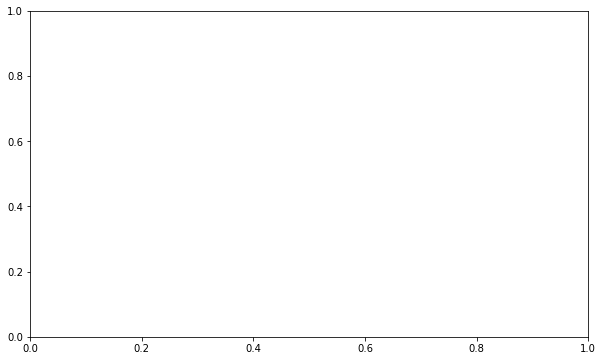

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400_ez_features/file_0_9_1.csv'
csv_file_path1 = '../files/rois_cc400_aal_features/file_0_9_1.csv'
csv_file_path2 = '../files/rois_cc400_ho_features/file_0_9_1.csv'

all_fc_matrices_path_df = pd.read_csv(csv_file_path)
all_fc_matrices_path_df1 = pd.read_csv(csv_file_path1)
all_fc_matrices_path_df2 = pd.read_csv(csv_file_path2)

# Extract data from DataFrame
# acc_train = all_fc_matrices_path_df['acc_train'].tolist()
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
acc_test1 = all_fc_matrices_path_df1['acc_val'].tolist()
acc_test2 = all_fc_matrices_path_df2['acc_val'].tolist()

epochs = range(1, len(acc_test) + 1)  # Assuming each entry corresponds to one epoch
epochs1 = range(1, len(acc_test1) + 1)
epochs2 = range(1, len(acc_test2) + 1)

epochs = 121

print(epochs,epochs1,epochs2)
# acc_train = [float(value.split('(')[1].split(')')[0]) for value in acc_train]
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]
acc_test1 = [float(value.split('(')[1].split(')')[0]) for value in acc_test1]
acc_test2 = [float(value.split('(')[1].split(')')[0]) for value in acc_test2]

acc_test = acc_test[0:epochs]
acc_test1 = acc_test1[0:epochs]
acc_test2 = acc_test2[0:epochs]



# epochs = 121
# Set figure size and background color
fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed


# Plotting
plt.plot(epochs, acc_test, label='acc_val_for_cc400_ez')
plt.plot(epochs, acc_test1, label='acc_val_for_cc400_ez')
plt.plot(epochs, acc_test2, label='acc_val_for_cc400_ez')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

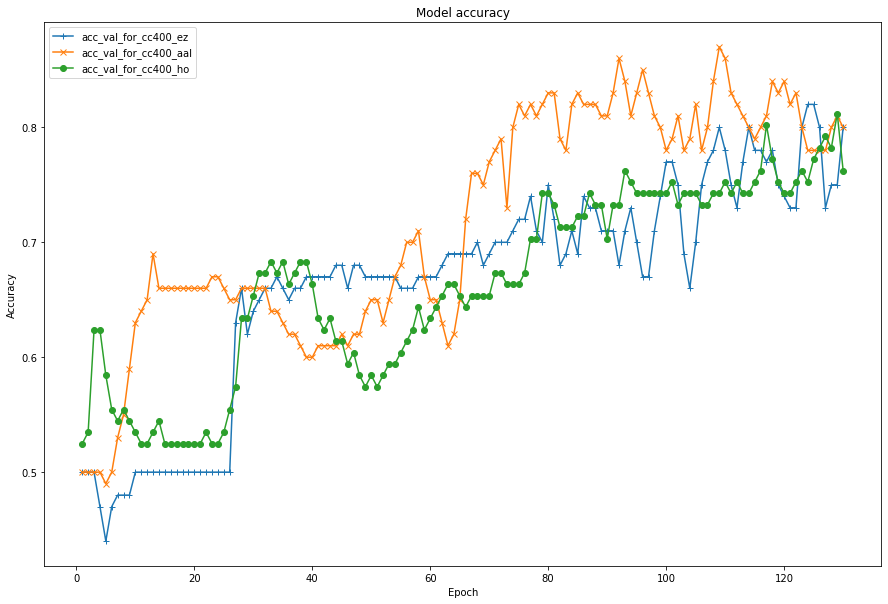

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
csv_file_path = '../files/rois_cc400_ez_features/file_0_9_1.csv'
csv_file_path1 = '../files/rois_cc400_aal_features/file_0_9_1.csv'
csv_file_path2 = '../files/rois_cc400_ho_features/file_9_9_10.csv'

all_fc_matrices_path_df = pd.read_csv(csv_file_path)
all_fc_matrices_path_df1 = pd.read_csv(csv_file_path1)
all_fc_matrices_path_df2 = pd.read_csv(csv_file_path2)

# Extract data from DataFrame
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
acc_test1 = all_fc_matrices_path_df1['acc_val'].tolist()
acc_test2 = all_fc_matrices_path_df2['acc_val'].tolist()

# Convert string values to float
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]
acc_test1 = [float(value.split('(')[1].split(')')[0]) for value in acc_test1]
acc_test2 = [float(value.split('(')[1].split(')')[0]) for value in acc_test2]

# Trim data to match the length of epochs
epochs = min(len(acc_test),len(acc_test1),len(acc_test2))
acc_test = acc_test[:epochs]
acc_test1 = acc_test1[:epochs]
acc_test2 = acc_test2[:epochs]

# Set figure size and background color
fig = plt.figure(figsize=(15, 10))  # Adjust dimensions as needed

# Plotting
plt.plot(range(1, epochs + 1), acc_test, label='acc_val_for_cc400_ez',marker='+')
plt.plot(range(1, epochs + 1), acc_test1, label='acc_val_for_cc400_aal',marker='x')
plt.plot(range(1, epochs + 1), acc_test2, label='acc_val_for_cc400_ho',marker='o')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


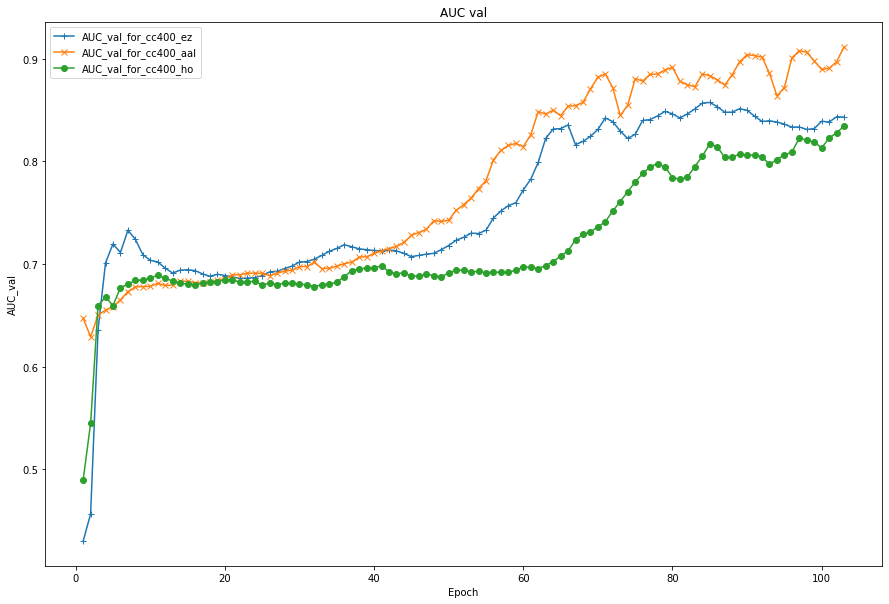

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
csv_file_path = '../files/rois_cc400_ez_features/file_9_9_10.csv'
csv_file_path1 = '../files/rois_cc400_aal_features/file_0_9_1.csv'
csv_file_path2 = '../files/rois_cc400_ho_features/file_9_9_10.csv'

all_fc_matrices_path_df = pd.read_csv(csv_file_path)
all_fc_matrices_path_df1 = pd.read_csv(csv_file_path1)
all_fc_matrices_path_df2 = pd.read_csv(csv_file_path2)

# Extract data from DataFrame
acc_test = all_fc_matrices_path_df['AUC_val'].tolist()
acc_test1 = all_fc_matrices_path_df1['AUC_val'].tolist()
acc_test2 = all_fc_matrices_path_df2['AUC_val'].tolist()

# Convert string values to float
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]
acc_test1 = [float(value.split('(')[1].split(')')[0]) for value in acc_test1]
acc_test2 = [float(value.split('(')[1].split(')')[0]) for value in acc_test2]

# Trim data to match the length of epochs
epochs = min(len(acc_test),len(acc_test1),len(acc_test2))
acc_test = acc_test[:epochs]
acc_test1 = acc_test1[:epochs]
acc_test2 = acc_test2[:epochs]

# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot(range(1, epochs + 1), acc_test, label='AUC_val_for_cc400_ez',marker='+')
plt.plot(range(1, epochs + 1), acc_test1, label='AUC_val_for_cc400_aal',marker='x')
plt.plot(range(1, epochs + 1), acc_test2, label='AUC_val_for_cc400_ho',marker='o')

plt.title('AUC val')
plt.ylabel('AUC_val')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


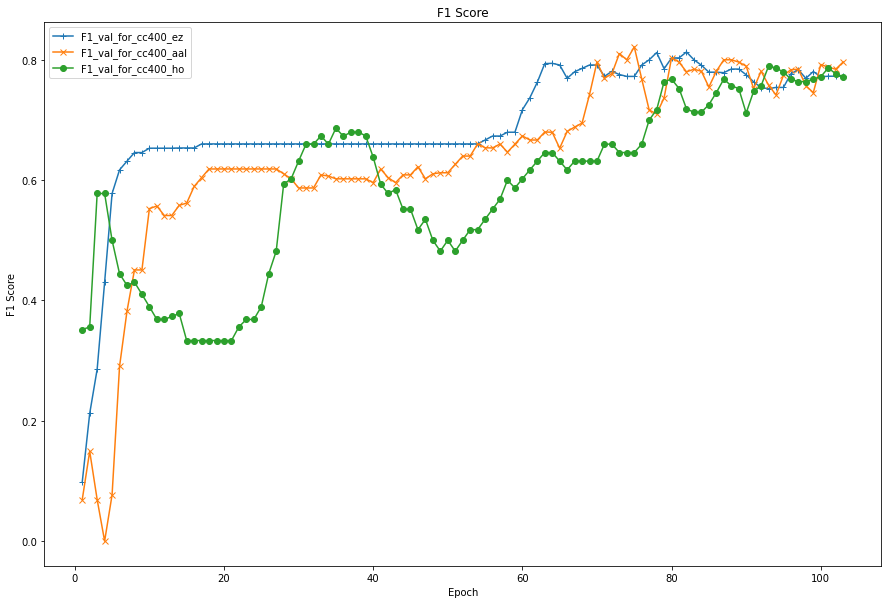

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
csv_file_path = '../files/rois_cc400_ez_features/file_9_9_10.csv'
csv_file_path1 = '../files/rois_cc400_aal_features/file_1_9_2.csv'
csv_file_path2 = '../files/rois_cc400_ho_features/file_9_9_10.csv'

all_fc_matrices_path_df = pd.read_csv(csv_file_path)
all_fc_matrices_path_df1 = pd.read_csv(csv_file_path1)
all_fc_matrices_path_df2 = pd.read_csv(csv_file_path2)

# Extract data from DataFrame
acc_test = all_fc_matrices_path_df['F1_val'].tolist()
acc_test1 = all_fc_matrices_path_df1['F1_val'].tolist()
acc_test2 = all_fc_matrices_path_df2['F1_val'].tolist()

# Convert string values to float
# Convert string values to float
acc_test = [float(value.split('(')[1].split(')')[0]) if isinstance(value, str) else value for value in acc_test]
acc_test1 = [float(value.split('(')[1].split(')')[0]) if isinstance(value, str) else value for value in acc_test1]
acc_test2 = [float(value.split('(')[1].split(')')[0]) if isinstance(value, str) else value for value in acc_test2]


# Trim data to match the length of epochs
epochs = min(len(acc_test),len(acc_test1),len(acc_test2))
acc_test = acc_test[:epochs]
acc_test1 = acc_test1[:epochs]
acc_test2 = acc_test2[:epochs]

# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot(range(1, epochs + 1), acc_test, label='F1_val_for_cc400_ez', marker='+')
plt.plot(range(1, epochs + 1), acc_test1, label='F1_val_for_cc400_aal', marker='x')
plt.plot(range(1, epochs + 1), acc_test2, label='F1_val_for_cc400_ho', marker='o')

plt.title('F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


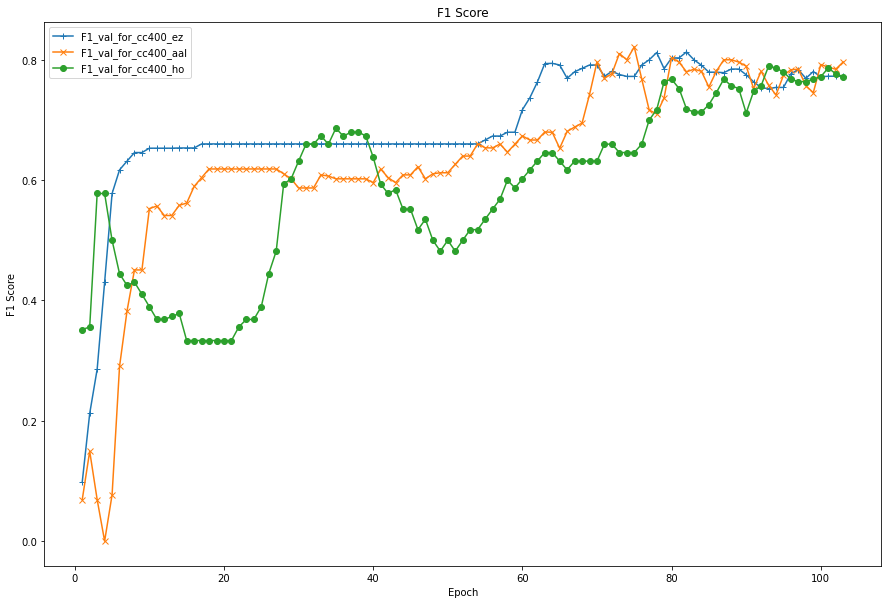

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
csv_file_path = '../files/rois_cc400_ez_features/file_9_9_10.csv'
csv_file_path1 = '../files/rois_cc400_aal_features/file_1_9_2.csv'
csv_file_path2 = '../files/rois_cc400_ho_features/file_9_9_10.csv'

all_fc_matrices_path_df = pd.read_csv(csv_file_path)
all_fc_matrices_path_df1 = pd.read_csv(csv_file_path1)
all_fc_matrices_path_df2 = pd.read_csv(csv_file_path2)

# Extract data from DataFrame
acc_test = all_fc_matrices_path_df['F1_val'].tolist()
acc_test1 = all_fc_matrices_path_df1['F1_val'].tolist()
acc_test2 = all_fc_matrices_path_df2['F1_val'].tolist()

# Convert string values to float
acc_test = [float(value.split('(')[1].split(')')[0]) if isinstance(value, str) else value for value in acc_test]
acc_test1 = [float(value.split('(')[1].split(')')[0]) if isinstance(value, str) else value for value in acc_test1]
acc_test2 = [float(value.split('(')[1].split(')')[0]) if isinstance(value, str) else value for value in acc_test2]

# Trim data to match the length of epochs
epochs = min(len(acc_test), len(acc_test1), len(acc_test2))
acc_test = acc_test[:epochs]
acc_test1 = acc_test1[:epochs]
acc_test2 = acc_test2[:epochs]

# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot(range(1, epochs + 1), acc_test, label='F1_val_for_cc400_ez', marker='+')
plt.plot(range(1, epochs + 1), acc_test1, label='F1_val_for_cc400_aal', marker='x')
plt.plot(range(1, epochs + 1), acc_test2, label='F1_val_for_cc400_ho', marker='o')

plt.title('F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()
